In [4]:
import torch.optim as optim
from torch import nn
from torchvision import models

from preprocessing_last20 import *
from classifier2 import FaceRecognizer2 as FaceRecognizer
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
from d2c_encoder import D2CEncoder
from d2c_decoder import D2CDecoder

In [5]:
device = torch.device('cuda:0')
train_data = train_data.to(device)
test_data = test_data.to(device)
vgg11 = models.vgg11(pretrained=False).to(device)
classifier = FaceRecognizer(vgg11).to(device)
d2c_encoder = D2CEncoder().to(device)
d2c_decoder = D2CDecoder().to(device)
d2c_ddpm = DDPM(eps_model=NaiveUnet(16, 16, n_feat=128), betas=(1e-4, 0.02), n_T=200).to(device)
attack_targets = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]).to(device)

In [6]:
classifier.load_state_dict(torch.load('eval_classifier_no_overfit.pt'))
d2c_encoder.load_state_dict(torch.load('d2c_encoder.pth'))
d2c_decoder.load_state_dict(torch.load('d2c_decoder.pth'))
d2c_ddpm.load_state_dict(torch.load('d2c_ddpm.pth'))

<All keys matched successfully>

In [7]:
z = d2c_encoder(test_data[32])

In [8]:
z.shape

torch.Size([1, 16, 32, 32])

# generate image using random z

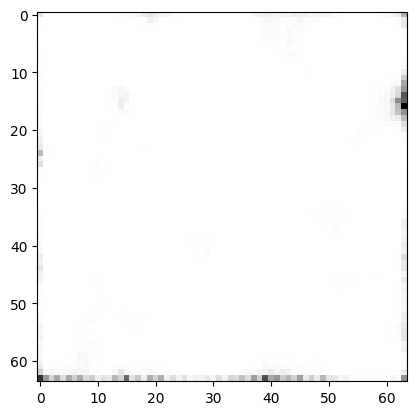

In [9]:
z = torch.randn(1, 16, 32, 32).to(device)
tensor_to_picture(d2c_decoder(z).detach().cpu().numpy()[0][0])

# generate image using avg z

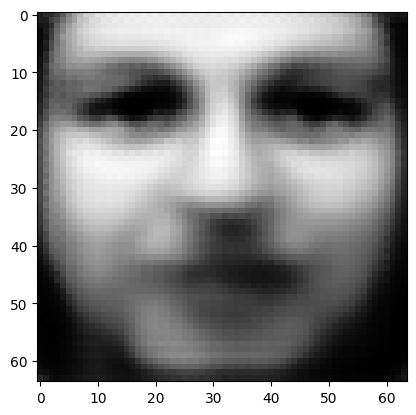

In [10]:
def init_avg_z():
    z = torch.zeros(1, 16, 32, 32).to(device)
    for i in range(200):
        z += d2c_encoder(train_data[i])
    z = z/200
    return z
avg = d2c_decoder(init_avg_z()).detach()
tensor_to_picture(avg.detach().cpu().numpy()[0][0])

In [11]:
def optimize_z(z, decoder, classifier, optimizer_z, criterion, target, reg):
    decoder.eval()
    classifier.eval()
    optimizer_z.zero_grad()
    generated = decoder(z)
    result = classifier(generated)
    print(torch.softmax(result,-1))
    loss = criterion(result,attack_targets[target])
    loss += torch.sum((generated-avg)**2) * reg
    loss.backward()
    optimizer_z.step()
    return loss.item()

In [12]:
def optimize_z_eps(z, eps, lr, reg, lr_decay, target=8):
    for epoch in range(eps): 
        optimizer_z = optim.SGD([z], lr=lr*lr_decay**epoch, momentum=0.9, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss = optimize_z(z, d2c_decoder, classifier, optimizer_z, criterion, target, reg)
        print("loss(generator): ", epoch_loss)
        if epoch%5 == 0:
            tensor_to_picture(d2c_decoder(z).detach().cpu().numpy()[0][0])

In [13]:
for param in classifier.parameters():
    param.requires_grad = False
for param in d2c_decoder.parameters():
    param.requires_grad = False   
z = init_avg_z().detach()
z = z.requires_grad_(True)

tensor([[3.4713e-03, 1.2601e-03, 7.9833e-03, 5.4270e-03, 8.8898e-02, 8.4707e-04,
         1.6127e-03, 1.4663e-03, 1.4164e-03, 1.3463e-04, 4.2232e-04, 1.0595e-03,
         9.2519e-03, 2.0949e-02, 2.3434e-03, 6.2844e-04, 2.3632e-02, 5.2971e-03,
         2.1626e-03, 8.3675e-04, 1.5805e-02, 4.6692e-03, 2.9303e-01, 2.5239e-03,
         1.1666e-01, 2.3455e-02, 2.2279e-03, 3.2929e-03, 9.4658e-04, 5.7554e-03,
         3.6073e-03, 7.6531e-03, 1.2323e-02, 1.4340e-02, 1.1156e-02, 3.3076e-02,
         2.3484e-01, 2.0808e-02, 9.6893e-03, 5.0422e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  5.663237571716309


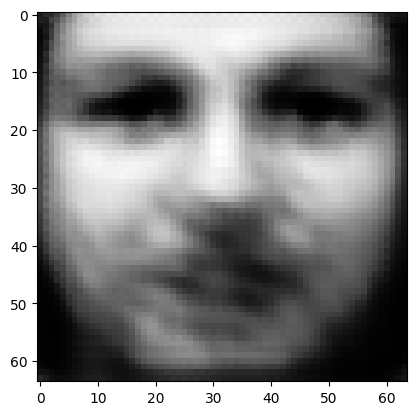

tensor([[3.1966e-03, 2.2439e-03, 5.8535e-03, 6.2701e-03, 5.5609e-02, 1.0540e-03,
         1.5293e-03, 1.3789e-03, 2.3743e-03, 1.9755e-04, 7.6214e-04, 1.4857e-03,
         7.4437e-03, 1.9614e-02, 2.1965e-03, 7.9012e-04, 2.1442e-02, 4.1533e-03,
         2.4437e-03, 7.2621e-04, 1.6572e-02, 4.2543e-03, 2.8886e-01, 2.4008e-03,
         1.0754e-01, 7.0960e-02, 2.3481e-03, 2.3290e-03, 1.1149e-03, 1.0383e-02,
         3.0736e-03, 7.3155e-03, 1.0189e-02, 1.2360e-02, 1.6596e-02, 2.7571e-02,
         2.3628e-01, 2.7243e-02, 7.3762e-03, 4.4747e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  5.745678901672363
tensor([[0.0038, 0.0021, 0.0038, 0.0036, 0.0652, 0.0012, 0.0022, 0.0020, 0.0027,
         0.0004, 0.0012, 0.0018, 0.0053, 0.0235, 0.0036, 0.0009, 0.0221, 0.0082,
         0.0023, 0.0009, 0.0213, 0.0051, 0.2122, 0.0029, 0.1634, 0.0490, 0.0023,
         0.0029, 0.0008, 0.0071, 0.0023, 0.0131, 0.0166, 0.0120, 0.0135, 0.0604,
         0.2234, 0.0256, 0.0057, 0.0034]], d

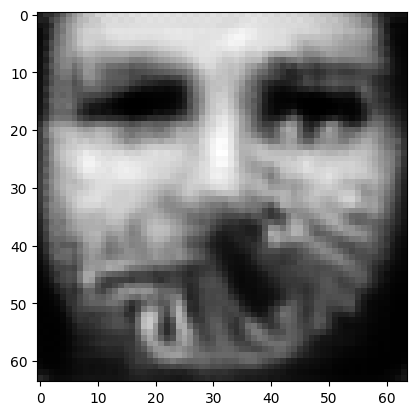

tensor([[0.1540, 0.0017, 0.0542, 0.0033, 0.0218, 0.0428, 0.0715, 0.0711, 0.0004,
         0.0026, 0.0030, 0.0059, 0.0025, 0.0005, 0.0057, 0.0185, 0.0254, 0.1756,
         0.0040, 0.0101, 0.0057, 0.0134, 0.0004, 0.1198, 0.0447, 0.0005, 0.0103,
         0.0236, 0.0131, 0.0023, 0.0007, 0.0129, 0.0162, 0.0056, 0.0043, 0.0066,
         0.0223, 0.0071, 0.0135, 0.0024]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  1.870972752571106
tensor([[0.2040, 0.0015, 0.0594, 0.0029, 0.0198, 0.0413, 0.0769, 0.0739, 0.0003,
         0.0024, 0.0022, 0.0050, 0.0018, 0.0003, 0.0046, 0.0206, 0.0220, 0.1663,
         0.0039, 0.0083, 0.0046, 0.0102, 0.0003, 0.1166, 0.0295, 0.0004, 0.0096,
         0.0220, 0.0148, 0.0019, 0.0004, 0.0100, 0.0114, 0.0041, 0.0039, 0.0047,
         0.0194, 0.0053, 0.0116, 0.0020]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  1.5894321203231812
tensor([[2.6483e-01, 1.1949e-03, 6.8960e-02, 2.2129e-03, 1.6976e-02, 4.3250e-02,
         7

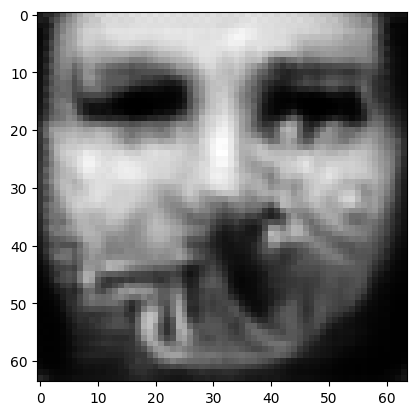

tensor([[4.4752e-01, 7.5219e-04, 4.0339e-02, 1.4119e-03, 9.6345e-03, 2.9924e-02,
         6.5700e-02, 8.0012e-02, 2.5983e-05, 1.5510e-03, 1.1052e-03, 1.4210e-03,
         4.8215e-04, 4.2237e-05, 2.1987e-03, 2.0868e-02, 1.6417e-02, 9.4052e-02,
         3.8770e-03, 3.4797e-03, 1.3091e-03, 3.5393e-03, 3.0353e-05, 1.0674e-01,
         5.5113e-03, 7.2558e-05, 3.8880e-03, 1.7466e-02, 1.6332e-02, 9.5272e-04,
         6.4731e-05, 3.5216e-03, 3.6827e-03, 1.1455e-03, 1.8068e-03, 1.2533e-03,
         5.7484e-03, 1.7822e-03, 3.8307e-03, 4.9968e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.8040229082107544
tensor([[4.9716e-01, 5.4851e-04, 3.5169e-02, 1.1220e-03, 8.3151e-03, 2.3398e-02,
         5.8189e-02, 8.1474e-02, 1.5836e-05, 1.3919e-03, 1.0117e-03, 9.0345e-04,
         3.5574e-04, 2.8798e-05, 1.9401e-03, 1.8054e-02, 1.6909e-02, 7.3788e-02,
         3.6657e-03, 2.7242e-03, 9.5951e-04, 2.8510e-03, 1.8955e-05, 1.1368e-01,
         4.5115e-03, 5.8530e-05, 2.3989e-03

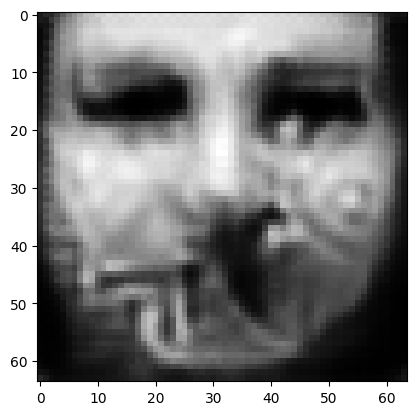

tensor([[6.5859e-01, 3.2704e-04, 2.3881e-02, 7.9836e-04, 4.3876e-03, 1.4379e-02,
         4.4604e-02, 5.4237e-02, 4.9231e-06, 1.2700e-03, 7.5917e-04, 4.4428e-04,
         1.9599e-04, 1.0429e-05, 1.1169e-03, 1.6190e-02, 1.2715e-02, 4.0230e-02,
         3.5483e-03, 1.6173e-03, 4.9391e-04, 1.3792e-03, 5.1788e-06, 8.2821e-02,
         1.6184e-03, 2.3827e-05, 1.3563e-03, 1.0028e-02, 1.4224e-02, 5.3290e-04,
         1.6840e-05, 1.1280e-03, 1.3863e-03, 4.4634e-04, 9.2083e-04, 4.0592e-04,
         1.6733e-03, 8.0297e-04, 1.2958e-03, 1.3730e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.41765883564949036
tensor([[6.8693e-01, 3.1592e-04, 2.1808e-02, 7.3846e-04, 3.7679e-03, 1.4620e-02,
         4.4915e-02, 5.0252e-02, 4.1306e-06, 1.1959e-03, 6.9848e-04, 4.4330e-04,
         1.7931e-04, 8.5525e-06, 9.8333e-04, 1.5861e-02, 1.0204e-02, 4.0668e-02,
         3.3434e-03, 1.5358e-03, 4.3923e-04, 1.1795e-03, 3.9924e-06, 6.7232e-02,
         1.2678e-03, 1.8259e-05, 1.4462e-0

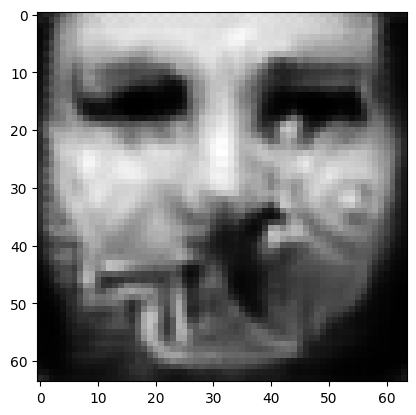

tensor([[7.5952e-01, 2.4563e-04, 1.6412e-02, 5.6882e-04, 2.5976e-03, 1.1018e-02,
         3.7608e-02, 3.7326e-02, 2.1824e-06, 1.0496e-03, 6.0341e-04, 3.1631e-04,
         1.3010e-04, 5.2550e-06, 7.2362e-04, 1.3731e-02, 7.3479e-03, 3.0474e-02,
         2.8324e-03, 1.1505e-03, 3.0615e-04, 7.8036e-04, 1.7942e-06, 5.1469e-02,
         6.9542e-04, 1.0282e-05, 1.0888e-03, 6.3463e-03, 1.0581e-02, 3.1476e-04,
         6.8963e-06, 7.8952e-04, 7.7265e-04, 2.6980e-04, 6.7287e-04, 2.4832e-04,
         8.6002e-04, 4.8465e-04, 5.6738e-04, 7.4255e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.2750740051269531
tensor([[7.7226e-01, 2.3865e-04, 1.5065e-02, 5.4751e-04, 2.3873e-03, 1.0115e-02,
         3.6598e-02, 3.4143e-02, 1.9647e-06, 1.0245e-03, 5.9786e-04, 2.9464e-04,
         1.2356e-04, 5.0251e-06, 7.1802e-04, 1.3489e-02, 6.8586e-03, 2.9320e-02,
         2.7556e-03, 1.1180e-03, 2.8965e-04, 7.1172e-04, 1.5152e-06, 4.9215e-02,
         6.2131e-04, 8.9241e-06, 1.0303e-03

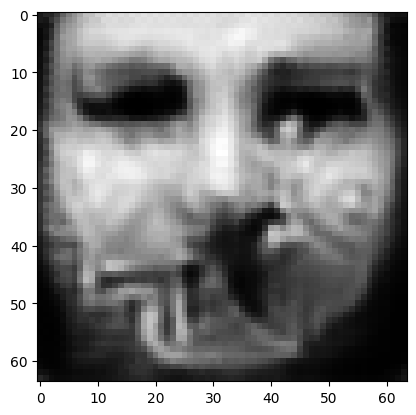

tensor([[8.1014e-01, 2.0822e-04, 1.2632e-02, 4.7326e-04, 1.9731e-03, 8.8522e-03,
         3.0938e-02, 3.0756e-02, 1.3083e-06, 9.3932e-04, 5.0098e-04, 2.5000e-04,
         9.6812e-05, 3.3953e-06, 5.5819e-04, 1.1886e-02, 5.2688e-03, 2.4038e-02,
         2.3586e-03, 9.1283e-04, 2.1860e-04, 5.3825e-04, 9.0164e-07, 3.9017e-02,
         4.3175e-04, 6.1509e-06, 8.8573e-04, 4.6946e-03, 7.8940e-03, 2.1647e-04,
         4.1598e-06, 6.0846e-04, 5.0110e-04, 1.9516e-04, 5.3782e-04, 1.8001e-04,
         5.5163e-04, 3.4644e-04, 3.3426e-04, 4.7631e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.21054361760616302
tensor([[8.1686e-01, 2.0538e-04, 1.2181e-02, 4.6717e-04, 1.9203e-03, 8.5753e-03,
         2.9832e-02, 2.9579e-02, 1.2177e-06, 9.1721e-04, 4.8499e-04, 2.4296e-04,
         9.2697e-05, 3.2288e-06, 5.4601e-04, 1.1778e-02, 5.0614e-03, 2.3487e-02,
         2.2894e-03, 8.7740e-04, 2.1056e-04, 5.0282e-04, 8.1672e-07, 3.7119e-02,
         4.0559e-04, 5.6741e-06, 8.6199e-0

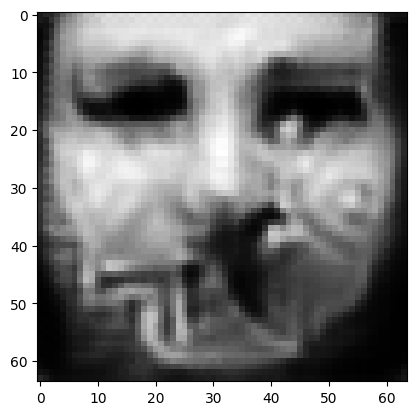

tensor([[8.3863e-01, 1.8695e-04, 1.0715e-02, 4.1764e-04, 1.6470e-03, 7.7415e-03,
         2.6431e-02, 2.6840e-02, 9.1792e-07, 8.2289e-04, 4.2571e-04, 2.2226e-04,
         7.6856e-05, 2.5373e-06, 4.7242e-04, 1.0985e-02, 4.1613e-03, 2.0974e-02,
         2.0396e-03, 7.4599e-04, 1.7782e-04, 4.1021e-04, 5.7088e-07, 3.1853e-02,
         3.1091e-04, 4.1906e-06, 7.7538e-04, 3.8292e-03, 6.3455e-03, 1.6290e-04,
         2.9231e-06, 5.0725e-04, 3.5452e-04, 1.5536e-04, 4.6469e-04, 1.4186e-04,
         4.3048e-04, 2.6869e-04, 2.2745e-04, 3.4762e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.175982266664505
tensor([[8.4327e-01, 1.8212e-04, 1.0434e-02, 4.0690e-04, 1.5887e-03, 7.5703e-03,
         2.5644e-02, 2.6448e-02, 8.6163e-07, 8.1087e-04, 4.1602e-04, 2.1688e-04,
         7.3642e-05, 2.3837e-06, 4.5339e-04, 1.0770e-02, 3.9814e-03, 2.0248e-02,
         1.9927e-03, 7.2086e-04, 1.6985e-04, 3.9111e-04, 5.2127e-07, 3.0740e-02,
         2.9130e-04, 3.9351e-06, 7.5267e-04,

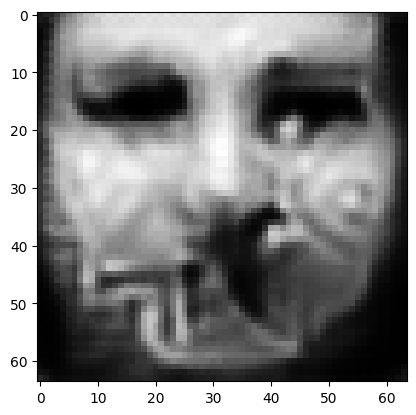

tensor([[8.6052e-01, 1.7114e-04, 9.4703e-03, 3.8238e-04, 1.3969e-03, 7.0142e-03,
         2.2878e-02, 2.4214e-02, 6.7653e-07, 7.5135e-04, 3.6819e-04, 2.0503e-04,
         6.2701e-05, 1.9016e-06, 3.9234e-04, 1.0312e-02, 3.3010e-03, 1.8167e-02,
         1.8195e-03, 6.2125e-04, 1.4688e-04, 3.2023e-04, 3.7217e-07, 2.5940e-02,
         2.2170e-04, 2.9762e-06, 6.9874e-04, 3.1198e-03, 5.3018e-03, 1.2530e-04,
         2.1773e-06, 4.3274e-04, 2.5427e-04, 1.2719e-04, 4.0121e-04, 1.1387e-04,
         3.3364e-04, 2.1656e-04, 1.6475e-04, 2.7178e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.15021975338459015
tensor([[8.6395e-01, 1.6888e-04, 9.2327e-03, 3.7857e-04, 1.3673e-03, 6.8413e-03,
         2.2241e-02, 2.3608e-02, 6.4357e-07, 7.4156e-04, 3.6012e-04, 2.0196e-04,
         6.0795e-05, 1.8263e-06, 3.8255e-04, 1.0263e-02, 3.1999e-03, 1.7712e-02,
         1.7880e-03, 6.0305e-04, 1.4320e-04, 3.0878e-04, 3.4956e-07, 2.5250e-02,
         2.1131e-04, 2.8211e-06, 6.8183e-0

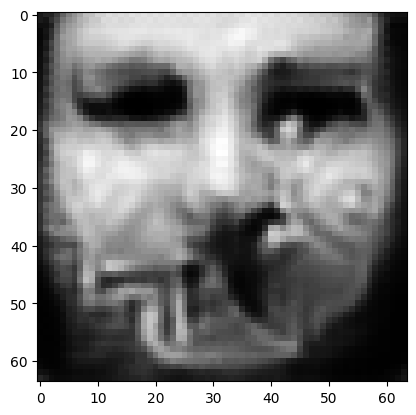

tensor([[8.7537e-01, 1.5773e-04, 8.3938e-03, 3.5291e-04, 1.2341e-03, 6.2507e-03,
         2.0472e-02, 2.2352e-02, 5.4403e-07, 6.8941e-04, 3.2669e-04, 1.8851e-04,
         5.3455e-05, 1.5280e-06, 3.4138e-04, 9.7109e-03, 2.7861e-03, 1.6174e-02,
         1.6482e-03, 5.4256e-04, 1.2803e-04, 2.7309e-04, 2.7953e-07, 2.2702e-02,
         1.7836e-04, 2.3030e-06, 6.2636e-04, 2.6911e-03, 4.4834e-03, 1.0387e-04,
         1.7777e-06, 3.8096e-04, 2.0209e-04, 1.0855e-04, 3.5822e-04, 9.7602e-05,
         2.7632e-04, 1.8367e-04, 1.3084e-04, 2.2205e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.13310670852661133
tensor([[8.7804e-01, 1.5571e-04, 8.2373e-03, 3.4874e-04, 1.2094e-03, 6.1568e-03,
         2.0038e-02, 2.1990e-02, 5.2745e-07, 6.8359e-04, 3.2066e-04, 1.8591e-04,
         5.2024e-05, 1.4661e-06, 3.3301e-04, 9.6414e-03, 2.6881e-03, 1.5843e-02,
         1.6177e-03, 5.3125e-04, 1.2497e-04, 2.6510e-04, 2.6368e-07, 2.1936e-02,
         1.7093e-04, 2.2006e-06, 6.1752e-0

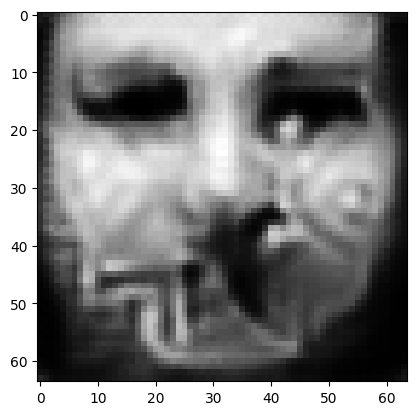

tensor([[8.8729e-01, 1.4600e-04, 7.6328e-03, 3.2873e-04, 1.1246e-03, 5.7160e-03,
         1.8318e-02, 2.0494e-02, 4.6170e-07, 6.6189e-04, 3.0273e-04, 1.7639e-04,
         4.6736e-05, 1.2682e-06, 3.0315e-04, 9.4209e-03, 2.4029e-03, 1.4408e-02,
         1.5102e-03, 4.8894e-04, 1.1516e-04, 2.4373e-04, 2.1493e-07, 2.0168e-02,
         1.4818e-04, 1.8882e-06, 5.6730e-04, 2.4037e-03, 3.9422e-03, 9.1178e-05,
         1.5199e-06, 3.3993e-04, 1.6402e-04, 9.5818e-05, 3.3225e-04, 8.5989e-05,
         2.3757e-04, 1.5952e-04, 1.0942e-04, 1.8911e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.11958480626344681
tensor([[8.8933e-01, 1.4447e-04, 7.4964e-03, 3.2548e-04, 1.1082e-03, 5.6321e-03,
         1.7947e-02, 2.0124e-02, 4.5093e-07, 6.5540e-04, 2.9781e-04, 1.7436e-04,
         4.5717e-05, 1.2279e-06, 2.9734e-04, 9.3883e-03, 2.3378e-03, 1.4169e-02,
         1.4858e-03, 4.7942e-04, 1.1323e-04, 2.3834e-04, 2.0530e-07, 1.9696e-02,
         1.4383e-04, 1.8205e-06, 5.5871e-0

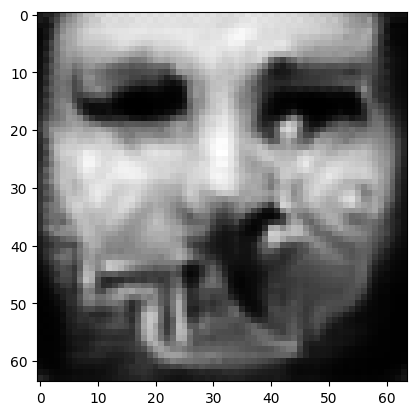

tensor([[8.9666e-01, 1.3916e-04, 6.9394e-03, 3.0358e-04, 1.0159e-03, 5.3437e-03,
         1.6784e-02, 1.8640e-02, 4.0969e-07, 6.2482e-04, 2.7990e-04, 1.6806e-04,
         4.2342e-05, 1.0874e-06, 2.7587e-04, 9.3007e-03, 2.0658e-03, 1.3431e-02,
         1.3904e-03, 4.5459e-04, 1.0662e-04, 2.2239e-04, 1.7322e-07, 1.8037e-02,
         1.2524e-04, 1.5520e-06, 5.3488e-04, 2.1631e-03, 3.4805e-03, 8.1130e-05,
         1.3150e-06, 3.1274e-04, 1.3733e-04, 8.5752e-05, 3.1087e-04, 7.8321e-05,
         2.0720e-04, 1.3883e-04, 9.3665e-05, 1.6583e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10907378047704697
tensor([[8.9821e-01, 1.3769e-04, 6.7904e-03, 2.9824e-04, 9.9288e-04, 5.2525e-03,
         1.6584e-02, 1.8266e-02, 4.0150e-07, 6.1431e-04, 2.7517e-04, 1.6554e-04,
         4.1627e-05, 1.0598e-06, 2.7240e-04, 9.2617e-03, 2.0163e-03, 1.3303e-02,
         1.3734e-03, 4.4928e-04, 1.0532e-04, 2.1821e-04, 1.6766e-07, 1.7765e-02,
         1.2186e-04, 1.4955e-06, 5.2773e-0

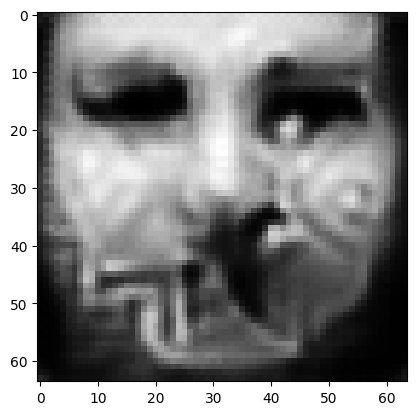

tensor([[9.0363e-01, 1.3331e-04, 6.2964e-03, 2.8275e-04, 9.3351e-04, 4.9750e-03,
         1.5739e-02, 1.7074e-02, 3.7013e-07, 5.8274e-04, 2.5887e-04, 1.5708e-04,
         3.9140e-05, 9.6784e-07, 2.6022e-04, 9.1493e-03, 1.8424e-03, 1.2875e-02,
         1.2979e-03, 4.3010e-04, 1.0056e-04, 2.0352e-04, 1.4727e-07, 1.6701e-02,
         1.1044e-04, 1.3157e-06, 5.0213e-04, 1.9750e-03, 3.1149e-03, 7.3663e-05,
         1.1595e-06, 2.9065e-04, 1.1992e-04, 7.7169e-05, 2.9671e-04, 7.3203e-05,
         1.8538e-04, 1.2288e-04, 8.1266e-05, 1.4663e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1013389378786087
tensor([[9.0483e-01, 1.3206e-04, 6.1911e-03, 2.7996e-04, 9.2084e-04, 4.8970e-03,
         1.5530e-02, 1.6771e-02, 3.6349e-07, 5.7678e-04, 2.5547e-04, 1.5470e-04,
         3.8584e-05, 9.4878e-07, 2.5744e-04, 9.1392e-03, 1.8157e-03, 1.2715e-02,
         1.2886e-03, 4.2483e-04, 9.9651e-05, 1.9992e-04, 1.4338e-07, 1.6553e-02,
         1.0807e-04, 1.2830e-06, 4.9459e-04

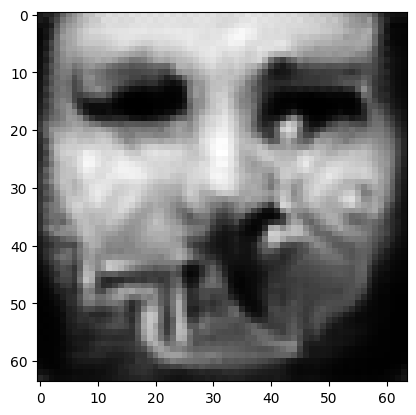

tensor([[9.0912e-01, 1.2742e-04, 5.8484e-03, 2.6747e-04, 8.7325e-04, 4.6821e-03,
         1.4830e-02, 1.5933e-02, 3.3733e-07, 5.5436e-04, 2.4368e-04, 1.4790e-04,
         3.6466e-05, 8.7777e-07, 2.4598e-04, 8.9937e-03, 1.6879e-03, 1.2226e-02,
         1.2306e-03, 4.0691e-04, 9.5352e-05, 1.8835e-04, 1.2797e-07, 1.5752e-02,
         9.9161e-05, 1.1610e-06, 4.7198e-04, 1.8313e-03, 2.8622e-03, 6.8225e-05,
         1.0483e-06, 2.7200e-04, 1.0692e-04, 7.0751e-05, 2.8464e-04, 6.8694e-05,
         1.6907e-04, 1.1176e-04, 7.2287e-05, 1.3224e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09527378529310226
tensor([[9.1014e-01, 1.2661e-04, 5.7656e-03, 2.6499e-04, 8.6232e-04, 4.6335e-03,
         1.4676e-02, 1.5726e-02, 3.3197e-07, 5.4739e-04, 2.4092e-04, 1.4643e-04,
         3.5986e-05, 8.6255e-07, 2.4369e-04, 8.9638e-03, 1.6576e-03, 1.2161e-02,
         1.2146e-03, 4.0283e-04, 9.4595e-05, 1.8499e-04, 1.2423e-07, 1.5507e-02,
         9.7006e-05, 1.1283e-06, 4.6709e-0

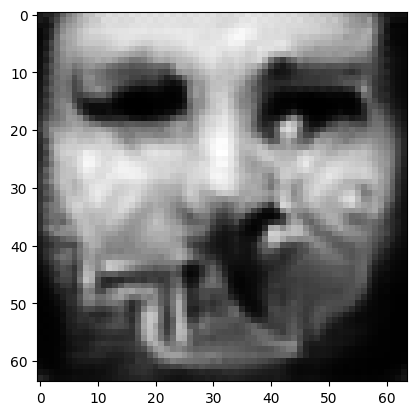

tensor([[9.1397e-01, 1.2190e-04, 5.4990e-03, 2.5400e-04, 8.2337e-04, 4.4345e-03,
         1.3975e-02, 1.5044e-02, 3.0749e-07, 5.3433e-04, 2.3256e-04, 1.4046e-04,
         3.4101e-05, 8.0129e-07, 2.3221e-04, 8.8246e-03, 1.5593e-03, 1.1524e-02,
         1.1729e-03, 3.8657e-04, 9.0478e-05, 1.7547e-04, 1.1092e-07, 1.4912e-02,
         8.9066e-05, 1.0381e-06, 4.4202e-04, 1.7149e-03, 2.6594e-03, 6.3502e-05,
         9.5835e-07, 2.5437e-04, 9.5955e-05, 6.5786e-05, 2.7223e-04, 6.4198e-05,
         1.5486e-04, 1.0231e-04, 6.4917e-05, 1.1954e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08995738625526428
tensor([[9.1483e-01, 1.2078e-04, 5.4385e-03, 2.5078e-04, 8.1282e-04, 4.4079e-03,
         1.3852e-02, 1.4928e-02, 3.0170e-07, 5.3058e-04, 2.3023e-04, 1.3933e-04,
         3.3661e-05, 7.8495e-07, 2.2892e-04, 8.7762e-03, 1.5289e-03, 1.1410e-02,
         1.1591e-03, 3.8342e-04, 8.9243e-05, 1.7324e-04, 1.0781e-07, 1.4706e-02,
         8.7015e-05, 1.0139e-06, 4.3832e-0

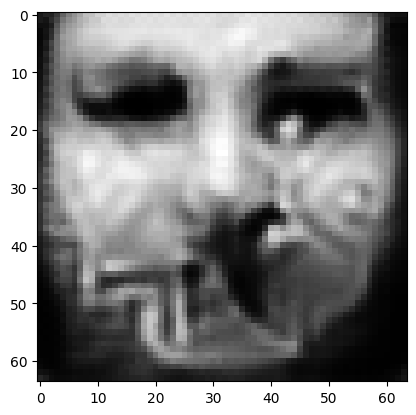

tensor([[9.1804e-01, 1.1644e-04, 5.1858e-03, 2.3941e-04, 7.7766e-04, 4.2611e-03,
         1.3354e-02, 1.4358e-02, 2.8219e-07, 5.1698e-04, 2.2188e-04, 1.3446e-04,
         3.2171e-05, 7.3100e-07, 2.1813e-04, 8.6208e-03, 1.4290e-03, 1.1003e-02,
         1.1139e-03, 3.7223e-04, 8.5235e-05, 1.6549e-04, 9.7613e-08, 1.4088e-02,
         8.0607e-05, 9.3283e-07, 4.2169e-04, 1.6131e-03, 2.4713e-03, 5.8772e-05,
         8.7559e-07, 2.4269e-04, 8.7934e-05, 6.1533e-05, 2.5789e-04, 6.0535e-05,
         1.4273e-04, 9.4786e-05, 5.9273e-05, 1.0902e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08551420271396637
tensor([[9.1882e-01, 1.1524e-04, 5.1285e-03, 2.3676e-04, 7.6947e-04, 4.2289e-03,
         1.3229e-02, 1.4252e-02, 2.7703e-07, 5.1403e-04, 2.2000e-04, 1.3319e-04,
         3.1785e-05, 7.1711e-07, 2.1529e-04, 8.5725e-03, 1.4057e-03, 1.0884e-02,
         1.1028e-03, 3.6921e-04, 8.4104e-05, 1.6359e-04, 9.4887e-08, 1.3928e-02,
         7.9023e-05, 9.1396e-07, 4.1693e-0

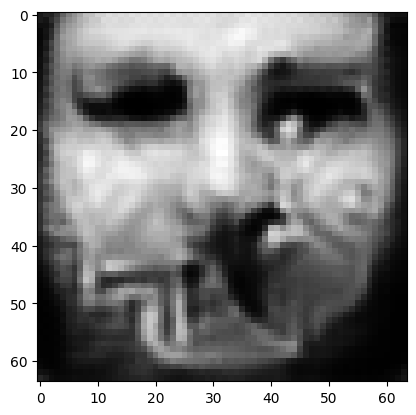

tensor([[9.2168e-01, 1.1141e-04, 4.9075e-03, 2.2788e-04, 7.3989e-04, 4.0973e-03,
         1.2762e-02, 1.3814e-02, 2.5926e-07, 5.0195e-04, 2.1220e-04, 1.2855e-04,
         3.0356e-05, 6.6593e-07, 2.0514e-04, 8.4406e-03, 1.3206e-03, 1.0490e-02,
         1.0642e-03, 3.5758e-04, 8.0360e-05, 1.5598e-04, 8.5639e-08, 1.3351e-02,
         7.3222e-05, 8.4269e-07, 4.0063e-04, 1.5238e-03, 2.3082e-03, 5.4456e-05,
         8.0395e-07, 2.3105e-04, 8.0358e-05, 5.7580e-05, 2.4452e-04, 5.7105e-05,
         1.3204e-04, 8.7924e-05, 5.4353e-05, 9.9541e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08155277371406555
tensor([[9.2237e-01, 1.1070e-04, 4.8491e-03, 2.2587e-04, 7.3287e-04, 4.0655e-03,
         1.2656e-02, 1.3688e-02, 2.5558e-07, 4.9813e-04, 2.1010e-04, 1.2742e-04,
         3.0053e-05, 6.5479e-07, 2.0318e-04, 8.4129e-03, 1.2989e-03, 1.0428e-02,
         1.0544e-03, 3.5509e-04, 7.9553e-05, 1.5399e-04, 8.3584e-08, 1.3199e-02,
         7.1905e-05, 8.2430e-07, 3.9745e-0

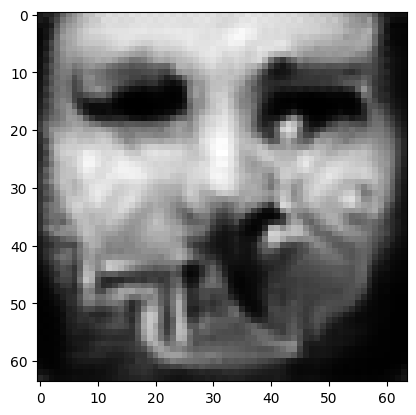

tensor([[9.2485e-01, 1.0734e-04, 4.6578e-03, 2.1823e-04, 7.0784e-04, 3.9579e-03,
         1.2272e-02, 1.3277e-02, 2.4102e-07, 4.8630e-04, 2.0367e-04, 1.2345e-04,
         2.8917e-05, 6.1375e-07, 1.9444e-04, 8.2785e-03, 1.2275e-03, 1.0152e-02,
         1.0167e-03, 3.4574e-04, 7.6401e-05, 1.4704e-04, 7.6375e-08, 1.2667e-02,
         6.7291e-05, 7.6517e-07, 3.8425e-04, 1.4443e-03, 2.1557e-03, 5.0594e-05,
         7.4143e-07, 2.2146e-04, 7.4108e-05, 5.4033e-05, 2.3440e-04, 5.4555e-05,
         1.2335e-04, 8.2122e-05, 5.0075e-05, 9.1848e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.07812798768281937
tensor([[9.2540e-01, 1.0662e-04, 4.6150e-03, 2.1657e-04, 7.0253e-04, 3.9316e-03,
         1.2181e-02, 1.3180e-02, 2.3790e-07, 4.8386e-04, 2.0223e-04, 1.2253e-04,
         2.8678e-05, 6.0553e-07, 1.9267e-04, 8.2468e-03, 1.2123e-03, 1.0087e-02,
         1.0091e-03, 3.4373e-04, 7.5710e-05, 1.4557e-04, 7.4937e-08, 1.2560e-02,
         6.6352e-05, 7.5337e-07, 3.8127e-0

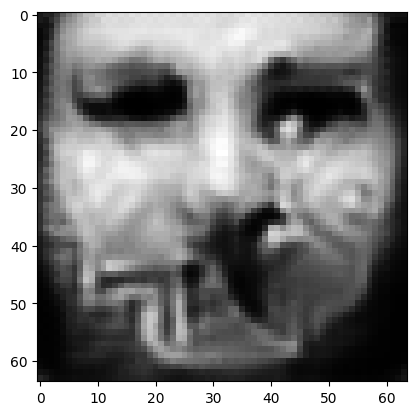

tensor([[9.2760e-01, 1.0389e-04, 4.4303e-03, 2.0870e-04, 6.7914e-04, 3.8383e-03,
         1.1826e-02, 1.2837e-02, 2.2452e-07, 4.7307e-04, 1.9642e-04, 1.1897e-04,
         2.7612e-05, 5.6942e-07, 1.8540e-04, 8.1275e-03, 1.1492e-03, 9.8196e-03,
         9.7501e-04, 3.3615e-04, 7.2674e-05, 1.4013e-04, 6.8823e-08, 1.2107e-02,
         6.2272e-05, 7.0318e-07, 3.6930e-04, 1.3753e-03, 2.0277e-03, 4.7369e-05,
         6.8727e-07, 2.1384e-04, 6.8973e-05, 5.1143e-05, 2.2482e-04, 5.2250e-05,
         1.1605e-04, 7.7359e-05, 4.6464e-05, 8.5159e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.07514955848455429
tensor([[9.2815e-01, 1.0326e-04, 4.3765e-03, 2.0671e-04, 6.7257e-04, 3.8100e-03,
         1.1757e-02, 1.2731e-02, 2.2160e-07, 4.6961e-04, 1.9476e-04, 1.1801e-04,
         2.7368e-05, 5.6172e-07, 1.8387e-04, 8.1003e-03, 1.1339e-03, 9.7789e-03,
         9.6699e-04, 3.3457e-04, 7.2004e-05, 1.3863e-04, 6.7576e-08, 1.1988e-02,
         6.1338e-05, 6.9002e-07, 3.6696e-0

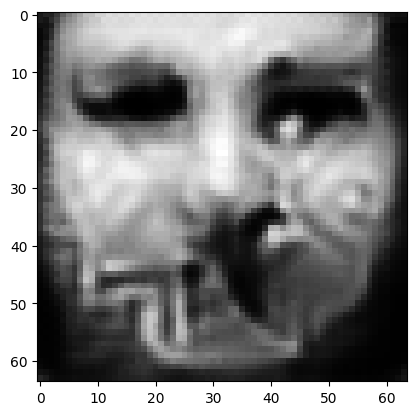

tensor([[9.3042e-01, 1.0053e-04, 4.1874e-03, 1.9923e-04, 6.5023e-04, 3.7029e-03,
         1.1351e-02, 1.2319e-02, 2.0883e-07, 4.6401e-04, 1.8862e-04, 1.1408e-04,
         2.6304e-05, 5.2588e-07, 1.7685e-04, 8.0539e-03, 1.0760e-03, 9.4329e-03,
         9.4306e-04, 3.2699e-04, 6.9028e-05, 1.3368e-04, 6.2223e-08, 1.1576e-02,
         5.7235e-05, 6.4522e-07, 3.5521e-04, 1.3013e-03, 1.9154e-03, 4.4498e-05,
         6.3574e-07, 2.0709e-04, 6.3879e-05, 4.8249e-05, 2.1544e-04, 4.9827e-05,
         1.0867e-04, 7.2772e-05, 4.3042e-05, 7.9260e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.07212395966053009
tensor([[9.3095e-01, 9.9944e-05, 4.1431e-03, 1.9734e-04, 6.4415e-04, 3.6807e-03,
         1.1262e-02, 1.2224e-02, 2.0593e-07, 4.6231e-04, 1.8699e-04, 1.1320e-04,
         2.6040e-05, 5.1689e-07, 1.7510e-04, 8.0453e-03, 1.0613e-03, 9.3566e-03,
         9.3744e-04, 3.2514e-04, 6.8311e-05, 1.3246e-04, 6.0985e-08, 1.1460e-02,
         5.6171e-05, 6.3361e-07, 3.5300e-0

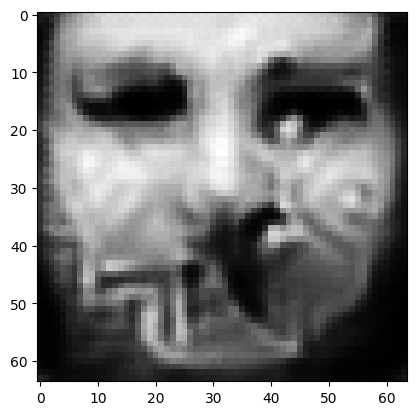

tensor([[9.3297e-01, 9.7588e-05, 3.9848e-03, 1.9036e-04, 6.2080e-04, 3.6034e-03,
         1.0949e-02, 1.1887e-02, 1.9519e-07, 4.5564e-04, 1.8091e-04, 1.1005e-04,
         2.5086e-05, 4.8339e-07, 1.6831e-04, 7.9873e-03, 1.0045e-03, 9.0864e-03,
         9.1363e-04, 3.1858e-04, 6.5511e-05, 1.2768e-04, 5.6352e-08, 1.0980e-02,
         5.2294e-05, 5.9084e-07, 3.4494e-04, 1.2320e-03, 1.8178e-03, 4.1728e-05,
         5.8556e-07, 2.0164e-04, 5.9265e-05, 4.5561e-05, 2.0635e-04, 4.7438e-05,
         1.0158e-04, 6.8477e-05, 4.0011e-05, 7.4588e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.06937706470489502
tensor([[9.3345e-01, 9.6888e-05, 3.9511e-03, 1.8886e-04, 6.1651e-04, 3.5797e-03,
         1.0866e-02, 1.1811e-02, 1.9266e-07, 4.5403e-04, 1.7956e-04, 1.0920e-04,
         2.4850e-05, 4.7602e-07, 1.6669e-04, 7.9621e-03, 9.9406e-04, 9.0155e-03,
         9.0794e-04, 3.1653e-04, 6.4867e-05, 1.2657e-04, 5.5322e-08, 1.0891e-02,
         5.1543e-05, 5.8271e-07, 3.4191e-0

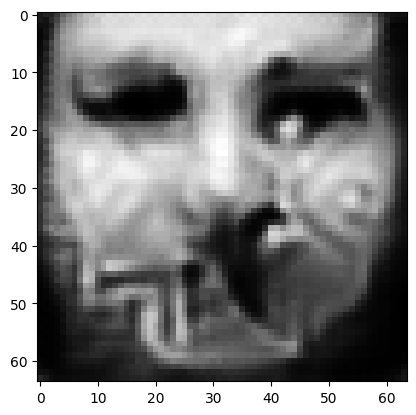

tensor([[9.3524e-01, 9.4596e-05, 3.8124e-03, 1.8284e-04, 5.9971e-04, 3.4882e-03,
         1.0549e-02, 1.1506e-02, 1.8355e-07, 4.4867e-04, 1.7421e-04, 1.0606e-04,
         2.3987e-05, 4.4890e-07, 1.6121e-04, 7.9051e-03, 9.5169e-04, 8.7530e-03,
         8.8877e-04, 3.0952e-04, 6.2501e-05, 1.2283e-04, 5.1587e-08, 1.0543e-02,
         4.8661e-05, 5.5115e-07, 3.3211e-04, 1.1748e-03, 1.7407e-03, 3.9462e-05,
         5.4668e-07, 1.9595e-04, 5.5380e-05, 4.3292e-05, 1.9910e-04, 4.5360e-05,
         9.5957e-05, 6.5011e-05, 3.7495e-05, 7.0071e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.06695690006017685
tensor([[9.3563e-01, 9.4174e-05, 3.7785e-03, 1.8143e-04, 5.9550e-04, 3.4651e-03,
         1.0476e-02, 1.1433e-02, 1.8156e-07, 4.4715e-04, 1.7306e-04, 1.0534e-04,
         2.3794e-05, 4.4313e-07, 1.6017e-04, 7.8976e-03, 9.4162e-04, 8.6957e-03,
         8.8495e-04, 3.0798e-04, 6.2001e-05, 1.2208e-04, 5.0774e-08, 1.0472e-02,
         4.7994e-05, 5.4373e-07, 3.2998e-0

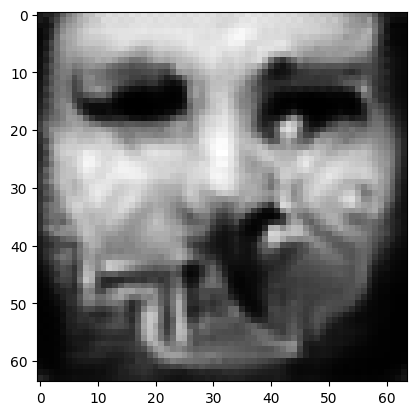

tensor([[9.3723e-01, 9.2230e-05, 3.6801e-03, 1.7653e-04, 5.8303e-04, 3.4248e-03,
         1.0227e-02, 1.1252e-02, 1.7446e-07, 4.4074e-04, 1.6768e-04, 1.0284e-04,
         2.3048e-05, 4.1690e-07, 1.5457e-04, 7.8018e-03, 8.9706e-04, 8.4934e-03,
         8.6058e-04, 3.0130e-04, 5.9563e-05, 1.1795e-04, 4.7299e-08, 9.9985e-03,
         4.5400e-05, 5.1441e-07, 3.2442e-04, 1.1247e-03, 1.6695e-03, 3.7230e-05,
         5.0994e-07, 1.9195e-04, 5.1890e-05, 4.1292e-05, 1.9282e-04, 4.3560e-05,
         9.0709e-05, 6.1706e-05, 3.5502e-05, 6.6716e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.06483111530542374
tensor([[9.3760e-01, 9.1689e-05, 3.6645e-03, 1.7548e-04, 5.8139e-04, 3.4171e-03,
         1.0146e-02, 1.1218e-02, 1.7265e-07, 4.4085e-04, 1.6670e-04, 1.0226e-04,
         2.2877e-05, 4.1118e-07, 1.5325e-04, 7.7780e-03, 8.8844e-04, 8.4182e-03,
         8.5553e-04, 2.9975e-04, 5.8949e-05, 1.1721e-04, 4.6484e-08, 9.9069e-03,
         4.4856e-05, 5.0997e-07, 3.2245e-0

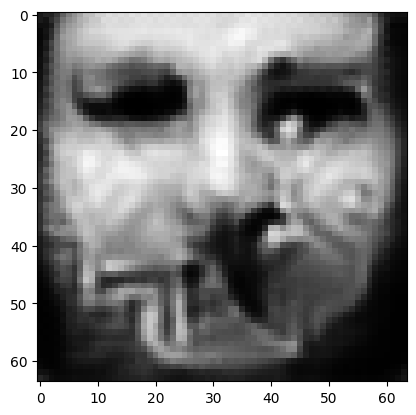

tensor([[9.3896e-01, 9.0379e-05, 3.5578e-03, 1.7110e-04, 5.6858e-04, 3.3534e-03,
         9.9226e-03, 1.0976e-02, 1.6706e-07, 4.3369e-04, 1.6251e-04, 9.9897e-05,
         2.2270e-05, 3.9355e-07, 1.4989e-04, 7.7195e-03, 8.5490e-04, 8.2723e-03,
         8.3817e-04, 2.9475e-04, 5.7292e-05, 1.1394e-04, 4.3993e-08, 9.5982e-03,
         4.2888e-05, 4.8541e-07, 3.1670e-04, 1.0824e-03, 1.6103e-03, 3.5555e-05,
         4.8134e-07, 1.8814e-04, 4.9116e-05, 3.9705e-05, 1.8805e-04, 4.2111e-05,
         8.6283e-05, 5.8955e-05, 3.3769e-05, 6.3771e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.06298123300075531
tensor([[9.3927e-01, 8.9979e-05, 3.5348e-03, 1.6990e-04, 5.6543e-04, 3.3376e-03,
         9.8664e-03, 1.0924e-02, 1.6552e-07, 4.3249e-04, 1.6166e-04, 9.9393e-05,
         2.2123e-05, 3.8918e-07, 1.4892e-04, 7.7056e-03, 8.4751e-04, 8.2238e-03,
         8.3449e-04, 2.9347e-04, 5.6880e-05, 1.1338e-04, 4.3409e-08, 9.5474e-03,
         4.2401e-05, 4.8032e-07, 3.1482e-0

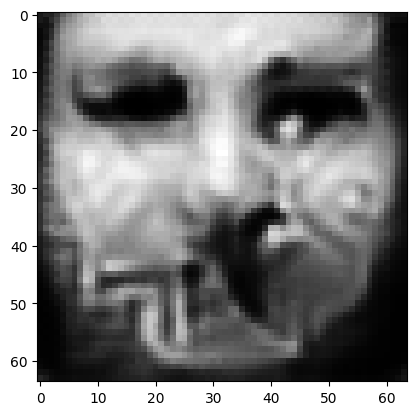

tensor([[9.4042e-01, 8.8659e-05, 3.4609e-03, 1.6624e-04, 5.5435e-04, 3.2882e-03,
         9.6665e-03, 1.0698e-02, 1.6057e-07, 4.2677e-04, 1.5856e-04, 9.7691e-05,
         2.1598e-05, 3.7535e-07, 1.4595e-04, 7.6575e-03, 8.2228e-04, 8.0895e-03,
         8.1849e-04, 2.8895e-04, 5.5603e-05, 1.1063e-04, 4.1343e-08, 9.2985e-03,
         4.0778e-05, 4.6136e-07, 3.0934e-04, 1.0474e-03, 1.5600e-03, 3.4181e-05,
         4.5836e-07, 1.8434e-04, 4.6815e-05, 3.8380e-05, 1.8418e-04, 4.0825e-05,
         8.2798e-05, 5.6738e-05, 3.2219e-05, 6.1249e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.061429984867572784
tensor([[9.4069e-01, 8.8380e-05, 3.4441e-03, 1.6558e-04, 5.5215e-04, 3.2771e-03,
         9.6178e-03, 1.0645e-02, 1.5949e-07, 4.2522e-04, 1.5777e-04, 9.7226e-05,
         2.1471e-05, 3.7216e-07, 1.4534e-04, 7.6495e-03, 8.1688e-04, 8.0610e-03,
         8.1468e-04, 2.8778e-04, 5.5320e-05, 1.0983e-04, 4.0829e-08, 9.2359e-03,
         4.0414e-05, 4.5681e-07, 3.0799e-

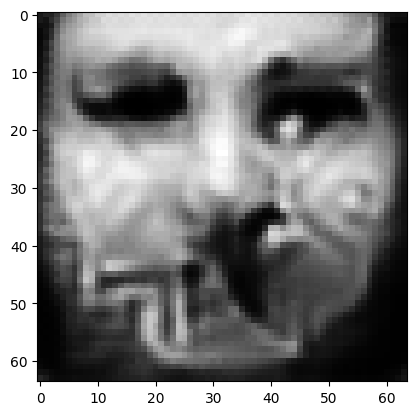

tensor([[9.4174e-01, 8.6860e-05, 3.3790e-03, 1.6191e-04, 5.4361e-04, 3.2386e-03,
         9.4335e-03, 1.0465e-02, 1.5483e-07, 4.1743e-04, 1.5488e-04, 9.5577e-05,
         2.0953e-05, 3.6048e-07, 1.4258e-04, 7.5632e-03, 7.9574e-04, 7.9684e-03,
         7.9458e-04, 2.8339e-04, 5.4063e-05, 1.0706e-04, 3.8874e-08, 8.9979e-03,
         3.9126e-05, 4.3971e-07, 3.0174e-04, 1.0167e-03, 1.5059e-03, 3.2804e-05,
         4.3656e-07, 1.8041e-04, 4.4713e-05, 3.7135e-05, 1.8116e-04, 3.9655e-05,
         7.9901e-05, 5.4668e-05, 3.0736e-05, 5.8814e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.06002182886004448
tensor([[9.4199e-01, 8.6568e-05, 3.3582e-03, 1.6105e-04, 5.4157e-04, 3.2248e-03,
         9.3938e-03, 1.0426e-02, 1.5387e-07, 4.1599e-04, 1.5412e-04, 9.5042e-05,
         2.0846e-05, 3.5764e-07, 1.4200e-04, 7.5425e-03, 7.9047e-04, 7.9402e-03,
         7.9139e-04, 2.8262e-04, 5.3734e-05, 1.0654e-04, 3.8476e-08, 8.9564e-03,
         3.8825e-05, 4.3594e-07, 3.0030e-0

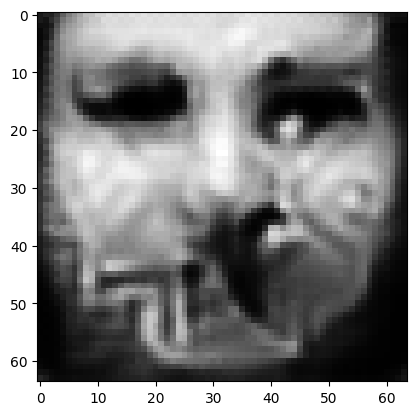

tensor([[9.4289e-01, 8.5303e-05, 3.3015e-03, 1.5811e-04, 5.3359e-04, 3.1898e-03,
         9.2387e-03, 1.0261e-02, 1.5002e-07, 4.0971e-04, 1.5161e-04, 9.3584e-05,
         2.0413e-05, 3.4787e-07, 1.3976e-04, 7.4810e-03, 7.7271e-04, 7.8553e-03,
         7.7620e-04, 2.7903e-04, 5.2703e-05, 1.0412e-04, 3.6890e-08, 8.7572e-03,
         3.7682e-05, 4.2139e-07, 2.9522e-04, 9.8943e-04, 1.4588e-03, 3.1655e-05,
         4.1856e-07, 1.7720e-04, 4.2984e-05, 3.6066e-05, 1.7819e-04, 3.8698e-05,
         7.7348e-05, 5.2917e-05, 2.9501e-05, 5.6711e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05880987271666527
tensor([[9.4310e-01, 8.4941e-05, 3.2880e-03, 1.5713e-04, 5.3077e-04, 3.1828e-03,
         9.2049e-03, 1.0223e-02, 1.4886e-07, 4.0772e-04, 1.5115e-04, 9.3348e-05,
         2.0301e-05, 3.4563e-07, 1.3912e-04, 7.4610e-03, 7.6778e-04, 7.8400e-03,
         7.7175e-04, 2.7806e-04, 5.2446e-05, 1.0355e-04, 3.6484e-08, 8.7076e-03,
         3.7365e-05, 4.1727e-07, 2.9398e-0

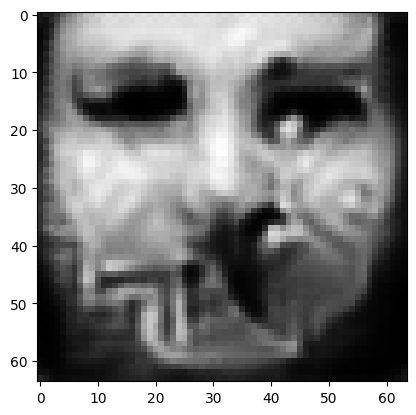

tensor([[9.4390e-01, 8.3676e-05, 3.2348e-03, 1.5424e-04, 5.2260e-04, 3.1490e-03,
         9.0692e-03, 1.0083e-02, 1.4537e-07, 4.0225e-04, 1.4908e-04, 9.1928e-05,
         1.9918e-05, 3.3704e-07, 1.3711e-04, 7.3968e-03, 7.5283e-04, 7.7478e-03,
         7.5940e-04, 2.7495e-04, 5.1485e-05, 1.0158e-04, 3.5101e-08, 8.5543e-03,
         3.6344e-05, 4.0480e-07, 2.8871e-04, 9.6585e-04, 1.4169e-03, 3.0609e-05,
         4.0191e-07, 1.7408e-04, 4.1469e-05, 3.5158e-05, 1.7505e-04, 3.7723e-05,
         7.5163e-05, 5.1372e-05, 2.8353e-05, 5.4736e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.057734180241823196
tensor([[9.4408e-01, 8.3396e-05, 3.2253e-03, 1.5379e-04, 5.2140e-04, 3.1420e-03,
         9.0374e-03, 1.0054e-02, 1.4472e-07, 4.0136e-04, 1.4852e-04, 9.1575e-05,
         1.9832e-05, 3.3491e-07, 1.3662e-04, 7.3827e-03, 7.4986e-04, 7.7237e-03,
         7.5685e-04, 2.7423e-04, 5.1268e-05, 1.0110e-04, 3.4802e-08, 8.5148e-03,
         3.6135e-05, 4.0247e-07, 2.8759e-

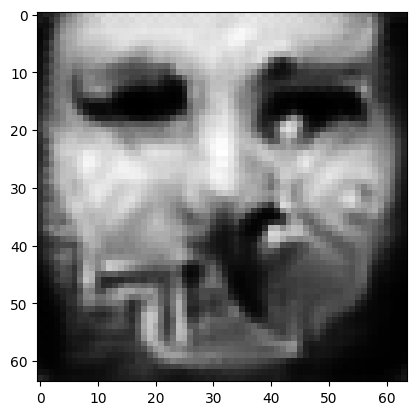

tensor([[9.4477e-01, 8.2294e-05, 3.1867e-03, 1.5121e-04, 5.1262e-04, 3.1137e-03,
         8.9173e-03, 9.9342e-03, 1.4131e-07, 3.9946e-04, 1.4691e-04, 9.0526e-05,
         1.9483e-05, 3.2588e-07, 1.3430e-04, 7.3586e-03, 7.3632e-04, 7.5868e-03,
         7.5129e-04, 2.7122e-04, 5.0355e-05, 9.9775e-05, 3.3598e-08, 8.3942e-03,
         3.4972e-05, 3.9240e-07, 2.8347e-04, 9.4446e-04, 1.3923e-03, 2.9853e-05,
         3.8913e-07, 1.7164e-04, 4.0149e-05, 3.4398e-05, 1.7195e-04, 3.6805e-05,
         7.3147e-05, 5.0144e-05, 2.7487e-05, 5.3298e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05681862309575081
tensor([[9.4494e-01, 8.2027e-05, 3.1814e-03, 1.5056e-04, 5.1030e-04, 3.1115e-03,
         8.8875e-03, 9.8986e-03, 1.4041e-07, 3.9823e-04, 1.4652e-04, 9.0455e-05,
         1.9392e-05, 3.2390e-07, 1.3368e-04, 7.3534e-03, 7.3271e-04, 7.5683e-03,
         7.4818e-04, 2.7023e-04, 5.0183e-05, 9.9255e-05, 3.3286e-08, 8.3438e-03,
         3.4684e-05, 3.8931e-07, 2.8279e-0

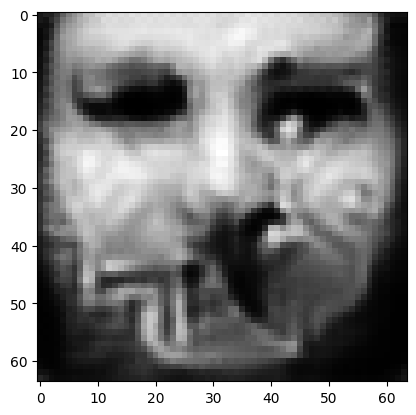

tensor([[9.4556e-01, 8.1072e-05, 3.1415e-03, 1.4819e-04, 5.0238e-04, 3.0806e-03,
         8.7771e-03, 9.7773e-03, 1.3741e-07, 3.9539e-04, 1.4480e-04, 8.9494e-05,
         1.9074e-05, 3.1626e-07, 1.3177e-04, 7.3343e-03, 7.2064e-04, 7.4641e-03,
         7.4240e-04, 2.6740e-04, 4.9436e-05, 9.7919e-05, 3.2311e-08, 8.2367e-03,
         3.3736e-05, 3.7972e-07, 2.7919e-04, 9.2479e-04, 1.3686e-03, 2.9117e-05,
         3.7680e-07, 1.6940e-04, 3.8987e-05, 3.3683e-05, 1.6922e-04, 3.5927e-05,
         7.1430e-05, 4.8991e-05, 2.6622e-05, 5.1994e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.055975496768951416
tensor([[9.4571e-01, 8.0924e-05, 3.1304e-03, 1.4783e-04, 5.0097e-04, 3.0687e-03,
         8.7473e-03, 9.7427e-03, 1.3684e-07, 3.9506e-04, 1.4430e-04, 8.9134e-05,
         1.9003e-05, 3.1457e-07, 1.3148e-04, 7.3363e-03, 7.1875e-04, 7.4349e-03,
         7.4250e-04, 2.6675e-04, 4.9291e-05, 9.7586e-05, 3.2126e-08, 8.2207e-03,
         3.3541e-05, 3.7793e-07, 2.7820e-

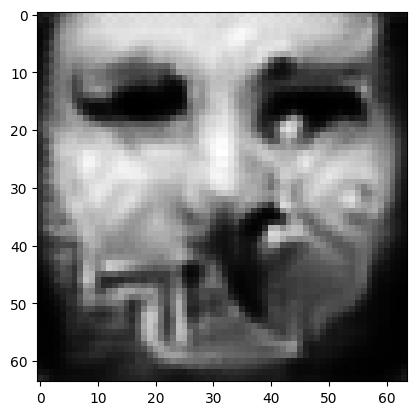

tensor([[9.4627e-01, 8.0014e-05, 3.0924e-03, 1.4561e-04, 4.9387e-04, 3.0362e-03,
         8.6458e-03, 9.6301e-03, 1.3407e-07, 3.9184e-04, 1.4273e-04, 8.8255e-05,
         1.8716e-05, 3.0811e-07, 1.2976e-04, 7.3099e-03, 7.0808e-04, 7.3503e-03,
         7.3665e-04, 2.6402e-04, 4.8640e-05, 9.6503e-05, 3.1313e-08, 8.1377e-03,
         3.2759e-05, 3.6965e-07, 2.7455e-04, 9.0695e-04, 1.3460e-03, 2.8532e-05,
         3.6732e-07, 1.6730e-04, 3.8014e-05, 3.3030e-05, 1.6679e-04, 3.5264e-05,
         6.9907e-05, 4.8043e-05, 2.5903e-05, 5.0729e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.055223483592271805
tensor([[9.4641e-01, 7.9847e-05, 3.0841e-03, 1.4516e-04, 4.9202e-04, 3.0281e-03,
         8.6214e-03, 9.5916e-03, 1.3346e-07, 3.9062e-04, 1.4243e-04, 8.8122e-05,
         1.8651e-05, 3.0715e-07, 1.2951e-04, 7.3073e-03, 7.0568e-04, 7.3419e-03,
         7.3479e-04, 2.6334e-04, 4.8556e-05, 9.6147e-05, 3.1124e-08, 8.1102e-03,
         3.2582e-05, 3.6735e-07, 2.7389e-

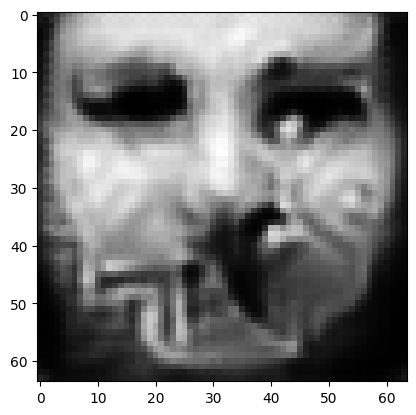

tensor([[9.4693e-01, 7.9065e-05, 3.0517e-03, 1.4343e-04, 4.8572e-04, 2.9969e-03,
         8.5262e-03, 9.4873e-03, 1.3108e-07, 3.8844e-04, 1.4105e-04, 8.7216e-05,
         1.8390e-05, 3.0120e-07, 1.2812e-04, 7.2896e-03, 6.9676e-04, 7.2527e-03,
         7.3122e-04, 2.6094e-04, 4.7967e-05, 9.5173e-05, 3.0372e-08, 8.0345e-03,
         3.1870e-05, 3.6035e-07, 2.7061e-04, 8.9157e-04, 1.3279e-03, 2.8028e-05,
         3.5860e-07, 1.6533e-04, 3.7141e-05, 3.2481e-05, 1.6481e-04, 3.4670e-05,
         6.8593e-05, 4.7173e-05, 2.5247e-05, 4.9644e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05453434959053993
tensor([[9.4705e-01, 7.8904e-05, 3.0453e-03, 1.4300e-04, 4.8434e-04, 2.9937e-03,
         8.5090e-03, 9.4554e-03, 1.3059e-07, 3.8672e-04, 1.4067e-04, 8.7168e-05,
         1.8333e-05, 3.0029e-07, 1.2781e-04, 7.2829e-03, 6.9412e-04, 7.2585e-03,
         7.2791e-04, 2.6029e-04, 4.7900e-05, 9.4749e-05, 3.0209e-08, 7.9967e-03,
         3.1740e-05, 3.5800e-07, 2.7023e-0

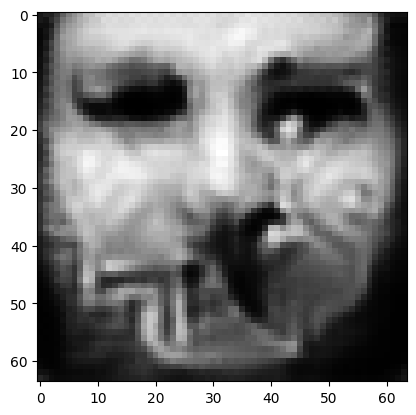

tensor([[9.4754e-01, 7.8147e-05, 3.0154e-03, 1.4132e-04, 4.7828e-04, 2.9653e-03,
         8.4160e-03, 9.3573e-03, 1.2832e-07, 3.8449e-04, 1.3937e-04, 8.6328e-05,
         1.8082e-05, 2.9454e-07, 1.2641e-04, 7.2655e-03, 6.8595e-04, 7.1715e-03,
         7.2416e-04, 2.5786e-04, 4.7343e-05, 9.3843e-05, 2.9507e-08, 7.9267e-03,
         3.1071e-05, 3.5152e-07, 2.6699e-04, 8.7694e-04, 1.3082e-03, 2.7499e-05,
         3.5012e-07, 1.6341e-04, 3.6313e-05, 3.1928e-05, 1.6301e-04, 3.4080e-05,
         6.7384e-05, 4.6346e-05, 2.4620e-05, 4.8645e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05388924479484558
tensor([[9.4765e-01, 7.7958e-05, 3.0049e-03, 1.4075e-04, 4.7626e-04, 2.9562e-03,
         8.3973e-03, 9.3311e-03, 1.2769e-07, 3.8361e-04, 1.3913e-04, 8.6130e-05,
         1.8025e-05, 2.9347e-07, 1.2614e-04, 7.2572e-03, 6.8368e-04, 7.1556e-03,
         7.2313e-04, 2.5739e-04, 4.7212e-05, 9.3682e-05, 2.9354e-08, 7.9168e-03,
         3.0917e-05, 3.4968e-07, 2.6616e-0

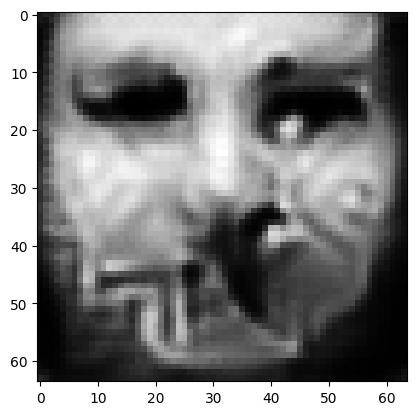

tensor([[9.4811e-01, 7.7266e-05, 2.9760e-03, 1.3921e-04, 4.7066e-04, 2.9294e-03,
         8.3144e-03, 9.2405e-03, 1.2567e-07, 3.8143e-04, 1.3790e-04, 8.5343e-05,
         1.7801e-05, 2.8822e-07, 1.2485e-04, 7.2380e-03, 6.7576e-04, 7.0763e-03,
         7.1969e-04, 2.5521e-04, 4.6692e-05, 9.2881e-05, 2.8733e-08, 7.8522e-03,
         3.0320e-05, 3.4379e-07, 2.6326e-04, 8.6306e-04, 1.2905e-03, 2.7055e-05,
         3.4279e-07, 1.6181e-04, 3.5608e-05, 3.1441e-05, 1.6097e-04, 3.3565e-05,
         6.6201e-05, 4.5619e-05, 2.4072e-05, 4.7653e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05328565463423729
tensor([[9.4822e-01, 7.7108e-05, 2.9684e-03, 1.3879e-04, 4.6909e-04, 2.9221e-03,
         8.2946e-03, 9.2133e-03, 1.2516e-07, 3.8051e-04, 1.3764e-04, 8.5196e-05,
         1.7747e-05, 2.8739e-07, 1.2466e-04, 7.2314e-03, 6.7383e-04, 7.0660e-03,
         7.1835e-04, 2.5469e-04, 4.6599e-05, 9.2655e-05, 2.8596e-08, 7.8354e-03,
         3.0194e-05, 3.4216e-07, 2.6263e-0

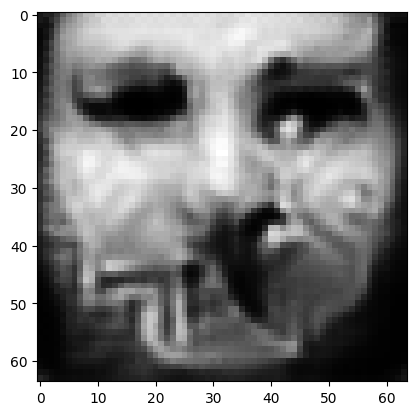

tensor([[9.4864e-01, 7.6431e-05, 2.9438e-03, 1.3742e-04, 4.6414e-04, 2.8989e-03,
         8.2180e-03, 9.1327e-03, 1.2330e-07, 3.7834e-04, 1.3651e-04, 8.4491e-05,
         1.7540e-05, 2.8279e-07, 1.2350e-04, 7.2059e-03, 6.6668e-04, 6.9971e-03,
         7.1453e-04, 2.5262e-04, 4.6119e-05, 9.1879e-05, 2.8034e-08, 7.7723e-03,
         2.9681e-05, 3.3697e-07, 2.5997e-04, 8.5086e-04, 1.2752e-03, 2.6650e-05,
         3.3599e-07, 1.6022e-04, 3.4996e-05, 3.1018e-05, 1.5926e-04, 3.3076e-05,
         6.5184e-05, 4.4962e-05, 2.3584e-05, 4.6797e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05272512882947922
tensor([[9.4874e-01, 7.6273e-05, 2.9380e-03, 1.3708e-04, 4.6288e-04, 2.8935e-03,
         8.2011e-03, 9.1092e-03, 1.2284e-07, 3.7740e-04, 1.3627e-04, 8.4382e-05,
         1.7491e-05, 2.8197e-07, 1.2326e-04, 7.1992e-03, 6.6489e-04, 6.9896e-03,
         7.1294e-04, 2.5208e-04, 4.6035e-05, 9.1628e-05, 2.7900e-08, 7.7520e-03,
         2.9567e-05, 3.3543e-07, 2.5940e-0

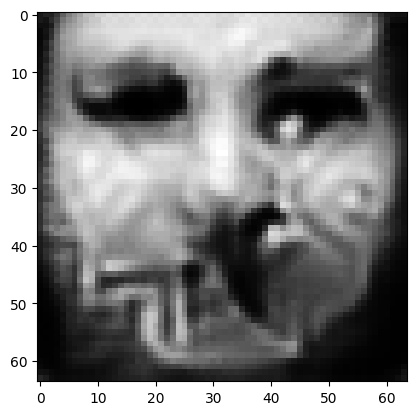

tensor([[9.4913e-01, 7.5706e-05, 2.9131e-03, 1.3589e-04, 4.5854e-04, 2.8719e-03,
         8.1376e-03, 9.0328e-03, 1.2123e-07, 3.7489e-04, 1.3509e-04, 8.3746e-05,
         1.7308e-05, 2.7805e-07, 1.2226e-04, 7.1729e-03, 6.5738e-04, 6.9403e-03,
         7.0859e-04, 2.5024e-04, 4.5604e-05, 9.0869e-05, 2.7420e-08, 7.6844e-03,
         2.9121e-05, 3.3036e-07, 2.5737e-04, 8.3952e-04, 1.2593e-03, 2.6237e-05,
         3.2971e-07, 1.5885e-04, 3.4427e-05, 3.0612e-05, 1.5777e-04, 3.2674e-05,
         6.4302e-05, 4.4355e-05, 2.3136e-05, 4.6030e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05221203714609146
tensor([[9.4922e-01, 7.5549e-05, 2.9087e-03, 1.3564e-04, 4.5755e-04, 2.8671e-03,
         8.1178e-03, 9.0218e-03, 1.2077e-07, 3.7510e-04, 1.3484e-04, 8.3533e-05,
         1.7256e-05, 2.7663e-07, 1.2193e-04, 7.1702e-03, 6.5594e-04, 6.9103e-03,
         7.0883e-04, 2.4978e-04, 4.5454e-05, 9.0752e-05, 2.7273e-08, 7.6735e-03,
         2.8979e-05, 3.2950e-07, 2.5669e-0

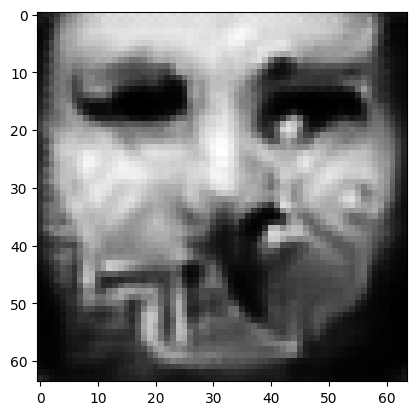

tensor([[9.4958e-01, 7.5100e-05, 2.8846e-03, 1.3453e-04, 4.5301e-04, 2.8481e-03,
         8.0611e-03, 8.9508e-03, 1.1931e-07, 3.7249e-04, 1.3379e-04, 8.2980e-05,
         1.7084e-05, 2.7303e-07, 1.2107e-04, 7.1490e-03, 6.4829e-04, 6.8698e-03,
         7.0459e-04, 2.4811e-04, 4.5064e-05, 8.9962e-05, 2.6788e-08, 7.6007e-03,
         2.8527e-05, 3.2403e-07, 2.5513e-04, 8.2876e-04, 1.2459e-03, 2.5872e-05,
         3.2386e-07, 1.5772e-04, 3.3870e-05, 3.0244e-05, 1.5620e-04, 3.2272e-05,
         6.3315e-05, 4.3744e-05, 2.2745e-05, 4.5356e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.051735468208789825
tensor([[9.4967e-01, 7.4951e-05, 2.8791e-03, 1.3413e-04, 4.5146e-04, 2.8441e-03,
         8.0476e-03, 8.9319e-03, 1.1884e-07, 3.7188e-04, 1.3360e-04, 8.2910e-05,
         1.7040e-05, 2.7209e-07, 1.2079e-04, 7.1451e-03, 6.4616e-04, 6.8579e-03,
         7.0351e-04, 2.4767e-04, 4.4968e-05, 8.9830e-05, 2.6660e-08, 7.5865e-03,
         2.8392e-05, 3.2257e-07, 2.5474e-

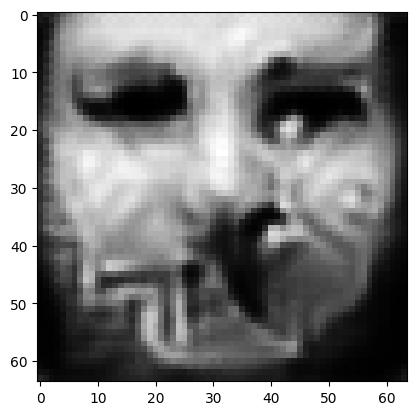

tensor([[9.5000e-01, 7.4525e-05, 2.8577e-03, 1.3312e-04, 4.4721e-04, 2.8268e-03,
         7.9935e-03, 8.8635e-03, 1.1746e-07, 3.6977e-04, 1.3267e-04, 8.2403e-05,
         1.6879e-05, 2.6865e-07, 1.1993e-04, 7.1302e-03, 6.3936e-04, 6.8144e-03,
         7.0005e-04, 2.4613e-04, 4.4609e-05, 8.9088e-05, 2.6207e-08, 7.5186e-03,
         2.7953e-05, 3.1761e-07, 2.5322e-04, 8.1864e-04, 1.2321e-03, 2.5513e-05,
         3.1820e-07, 1.5667e-04, 3.3348e-05, 2.9900e-05, 1.5477e-04, 3.1896e-05,
         6.2456e-05, 4.3168e-05, 2.2342e-05, 4.4713e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.051291290670633316
tensor([[9.5008e-01, 7.4408e-05, 2.8514e-03, 1.3286e-04, 4.4623e-04, 2.8212e-03,
         7.9797e-03, 8.8501e-03, 1.1712e-07, 3.6939e-04, 1.3240e-04, 8.2216e-05,
         1.6840e-05, 2.6771e-07, 1.1970e-04, 7.1245e-03, 6.3775e-04, 6.7994e-03,
         6.9950e-04, 2.4576e-04, 4.4499e-05, 8.8946e-05, 2.6104e-08, 7.5077e-03,
         2.7854e-05, 3.1657e-07, 2.5272e-

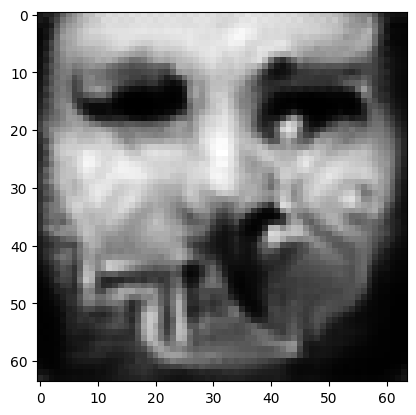

tensor([[9.5040e-01, 7.3991e-05, 2.8293e-03, 1.3184e-04, 4.4223e-04, 2.8026e-03,
         7.9279e-03, 8.7851e-03, 1.1580e-07, 3.6735e-04, 1.3153e-04, 8.1705e-05,
         1.6688e-05, 2.6458e-07, 1.1896e-04, 7.1096e-03, 6.3148e-04, 6.7588e-03,
         6.9631e-04, 2.4433e-04, 4.4168e-05, 8.8333e-05, 2.5691e-08, 7.4539e-03,
         2.7470e-05, 3.1205e-07, 2.5112e-04, 8.0911e-04, 1.2188e-03, 2.5196e-05,
         3.1335e-07, 1.5568e-04, 3.2877e-05, 2.9576e-05, 1.5341e-04, 3.1577e-05,
         6.1621e-05, 4.2641e-05, 2.1996e-05, 4.4078e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.050874900072813034
tensor([[9.5047e-01, 7.3883e-05, 2.8239e-03, 1.3153e-04, 4.4105e-04, 2.7985e-03,
         7.9179e-03, 8.7670e-03, 1.1546e-07, 3.6659e-04, 1.3134e-04, 8.1642e-05,
         1.6653e-05, 2.6399e-07, 1.1879e-04, 7.1043e-03, 6.2968e-04, 6.7549e-03,
         6.9511e-04, 2.4399e-04, 4.4101e-05, 8.8192e-05, 2.5598e-08, 7.4402e-03,
         2.7379e-05, 3.1078e-07, 2.5083e-

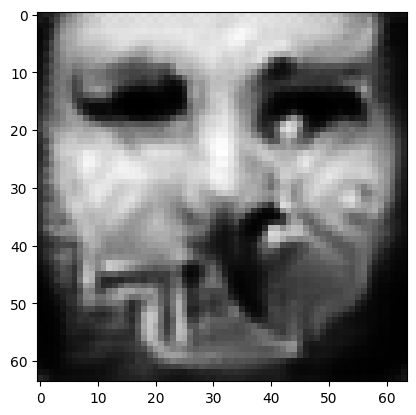

tensor([[9.5076e-01, 7.3512e-05, 2.8018e-03, 1.3067e-04, 4.3772e-04, 2.7790e-03,
         7.8691e-03, 8.7079e-03, 1.1434e-07, 3.6468e-04, 1.3047e-04, 8.1076e-05,
         1.6515e-05, 2.6121e-07, 1.1814e-04, 7.0874e-03, 6.2418e-04, 6.7192e-03,
         6.9219e-04, 2.4268e-04, 4.3794e-05, 8.7580e-05, 2.5243e-08, 7.3919e-03,
         2.7058e-05, 3.0681e-07, 2.4927e-04, 8.0037e-04, 1.2053e-03, 2.4894e-05,
         3.0890e-07, 1.5474e-04, 3.2454e-05, 2.9275e-05, 1.5226e-04, 3.1309e-05,
         6.0875e-05, 4.2157e-05, 2.1662e-05, 4.3481e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05048973485827446
tensor([[9.5083e-01, 7.3391e-05, 2.7975e-03, 1.3037e-04, 4.3665e-04, 2.7760e-03,
         7.8582e-03, 8.6938e-03, 1.1398e-07, 3.6409e-04, 1.3030e-04, 8.1012e-05,
         1.6478e-05, 2.6050e-07, 1.1793e-04, 7.0828e-03, 6.2257e-04, 6.7122e-03,
         6.9103e-04, 2.4232e-04, 4.3717e-05, 8.7443e-05, 2.5142e-08, 7.3781e-03,
         2.6966e-05, 3.0566e-07, 2.4896e-0

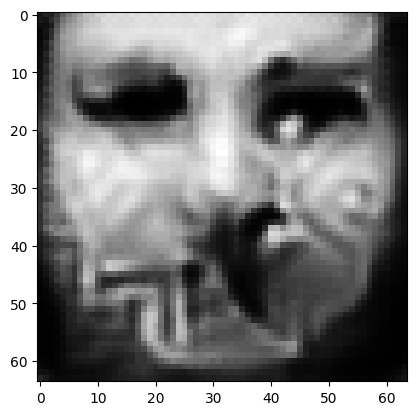

tensor([[9.5111e-01, 7.3014e-05, 2.7788e-03, 1.2963e-04, 4.3388e-04, 2.7582e-03,
         7.8086e-03, 8.6435e-03, 1.1291e-07, 3.6262e-04, 1.2950e-04, 8.0473e-05,
         1.6345e-05, 2.5779e-07, 1.1726e-04, 7.0662e-03, 6.1791e-04, 6.6720e-03,
         6.8845e-04, 2.4098e-04, 4.3413e-05, 8.6892e-05, 2.4804e-08, 7.3361e-03,
         2.6674e-05, 3.0235e-07, 2.4730e-04, 7.9244e-04, 1.1938e-03, 2.4626e-05,
         3.0481e-07, 1.5379e-04, 3.2053e-05, 2.8995e-05, 1.5115e-04, 3.1024e-05,
         6.0187e-05, 4.1714e-05, 2.1366e-05, 4.2929e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05013015493750572
tensor([[9.5117e-01, 7.2963e-05, 2.7731e-03, 1.2940e-04, 4.3282e-04, 2.7541e-03,
         7.8000e-03, 8.6227e-03, 1.1266e-07, 3.6168e-04, 1.2935e-04, 8.0429e-05,
         1.6318e-05, 2.5745e-07, 1.1718e-04, 7.0643e-03, 6.1640e-04, 6.6751e-03,
         6.8720e-04, 2.4070e-04, 4.3388e-05, 8.6720e-05, 2.4731e-08, 7.3215e-03,
         2.6604e-05, 3.0106e-07, 2.4714e-0

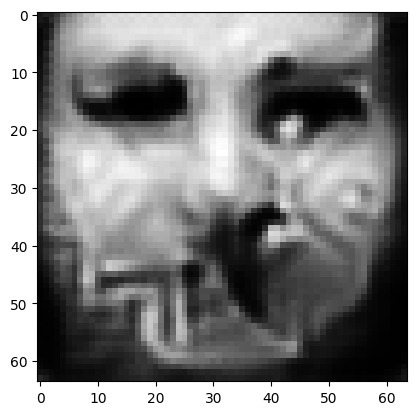

tensor([[9.5142e-01, 7.2561e-05, 2.7591e-03, 1.2872e-04, 4.3053e-04, 2.7393e-03,
         7.7503e-03, 8.5769e-03, 1.1160e-07, 3.6029e-04, 1.2864e-04, 8.0006e-05,
         1.6189e-05, 2.5505e-07, 1.1650e-04, 7.0480e-03, 6.1253e-04, 6.6381e-03,
         6.8415e-04, 2.3926e-04, 4.3120e-05, 8.6177e-05, 2.4406e-08, 7.2792e-03,
         2.6346e-05, 2.9814e-07, 2.4548e-04, 7.8556e-04, 1.1830e-03, 2.4373e-05,
         3.0098e-07, 1.5281e-04, 3.1676e-05, 2.8742e-05, 1.5034e-04, 3.0761e-05,
         5.9618e-05, 4.1308e-05, 2.1068e-05, 4.2419e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04979528486728668
tensor([[9.5149e-01, 7.2430e-05, 2.7561e-03, 1.2855e-04, 4.3011e-04, 2.7361e-03,
         7.7369e-03, 8.5712e-03, 1.1131e-07, 3.6016e-04, 1.2844e-04, 7.9862e-05,
         1.6154e-05, 2.5422e-07, 1.1626e-04, 7.0419e-03, 6.1157e-04, 6.6228e-03,
         6.8349e-04, 2.3887e-04, 4.3020e-05, 8.6064e-05, 2.4315e-08, 7.2699e-03,
         2.6277e-05, 2.9759e-07, 2.4496e-0

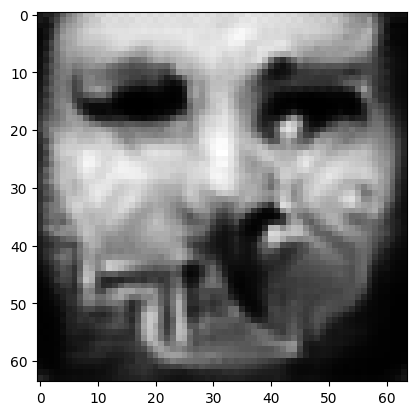

tensor([[9.5173e-01, 7.2090e-05, 2.7395e-03, 1.2780e-04, 4.2728e-04, 2.7203e-03,
         7.6953e-03, 8.5185e-03, 1.1031e-07, 3.5856e-04, 1.2779e-04, 7.9483e-05,
         1.6041e-05, 2.5210e-07, 1.1565e-04, 7.0302e-03, 6.0730e-04, 6.5948e-03,
         6.8074e-04, 2.3765e-04, 4.2788e-05, 8.5587e-05, 2.4033e-08, 7.2338e-03,
         2.6015e-05, 2.9438e-07, 2.4364e-04, 7.7859e-04, 1.1728e-03, 2.4142e-05,
         2.9756e-07, 1.5193e-04, 3.1327e-05, 2.8494e-05, 1.4936e-04, 3.0509e-05,
         5.9016e-05, 4.0935e-05, 2.0810e-05, 4.1931e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04947811737656593
tensor([[9.5178e-01, 7.1981e-05, 2.7370e-03, 1.2768e-04, 4.2689e-04, 2.7169e-03,
         7.6828e-03, 8.5101e-03, 1.1005e-07, 3.5855e-04, 1.2761e-04, 7.9357e-05,
         1.6009e-05, 2.5138e-07, 1.1543e-04, 7.0278e-03, 6.0658e-04, 6.5802e-03,
         6.8044e-04, 2.3728e-04, 4.2709e-05, 8.5471e-05, 2.3957e-08, 7.2254e-03,
         2.5948e-05, 2.9388e-07, 2.4320e-0

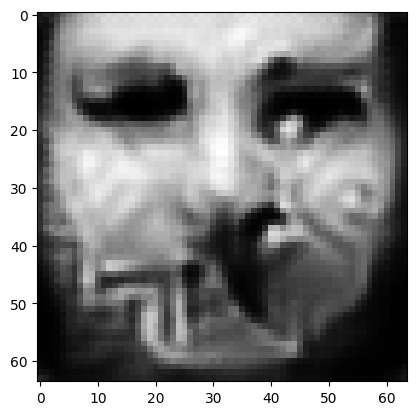

tensor([[9.5201e-01, 7.1649e-05, 2.7232e-03, 1.2703e-04, 4.2454e-04, 2.7030e-03,
         7.6419e-03, 8.4637e-03, 1.0910e-07, 3.5714e-04, 1.2698e-04, 7.8997e-05,
         1.5898e-05, 2.4932e-07, 1.1482e-04, 7.0170e-03, 6.0292e-04, 6.5514e-03,
         6.7771e-04, 2.3604e-04, 4.2484e-05, 8.4973e-05, 2.3685e-08, 7.1879e-03,
         2.5708e-05, 2.9102e-07, 2.4189e-04, 7.7219e-04, 1.1646e-03, 2.3930e-05,
         2.9438e-07, 1.5106e-04, 3.0987e-05, 2.8257e-05, 1.4854e-04, 3.0256e-05,
         5.8478e-05, 4.0599e-05, 2.0566e-05, 4.1505e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.049181390553712845
tensor([[9.5206e-01, 7.1561e-05, 2.7204e-03, 1.2683e-04, 4.2384e-04, 2.7003e-03,
         7.6324e-03, 8.4519e-03, 1.0884e-07, 3.5684e-04, 1.2686e-04, 7.8943e-05,
         1.5871e-05, 2.4883e-07, 1.1466e-04, 7.0155e-03, 6.0201e-04, 6.5442e-03,
         6.7702e-04, 2.3575e-04, 4.2432e-05, 8.4863e-05, 2.3615e-08, 7.1790e-03,
         2.5642e-05, 2.9027e-07, 2.4160e-

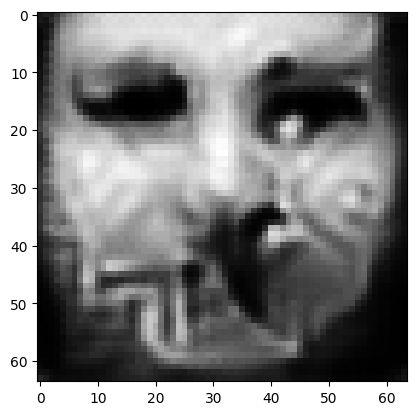

tensor([[9.5227e-01, 7.1249e-05, 2.7071e-03, 1.2626e-04, 4.2198e-04, 2.6869e-03,
         7.5924e-03, 8.4126e-03, 1.0800e-07, 3.5574e-04, 1.2621e-04, 7.8542e-05,
         1.5766e-05, 2.4672e-07, 1.1406e-04, 7.0045e-03, 5.9859e-04, 6.5132e-03,
         6.7459e-04, 2.3459e-04, 4.2197e-05, 8.4411e-05, 2.3360e-08, 7.1448e-03,
         2.5425e-05, 2.8778e-07, 2.4030e-04, 7.6615e-04, 1.1562e-03, 2.3730e-05,
         2.9139e-07, 1.5027e-04, 3.0670e-05, 2.8035e-05, 1.4777e-04, 3.0030e-05,
         5.7961e-05, 4.0272e-05, 2.0340e-05, 4.1102e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.048904553055763245
tensor([[9.5232e-01, 7.1196e-05, 2.7041e-03, 1.2612e-04, 4.2138e-04, 2.6842e-03,
         7.5833e-03, 8.3989e-03, 1.0779e-07, 3.5524e-04, 1.2609e-04, 7.8499e-05,
         1.5742e-05, 2.4640e-07, 1.1396e-04, 7.0035e-03, 5.9773e-04, 6.5112e-03,
         6.7373e-04, 2.3431e-04, 4.2168e-05, 8.4261e-05, 2.3300e-08, 7.1324e-03,
         2.5371e-05, 2.8700e-07, 2.4009e-

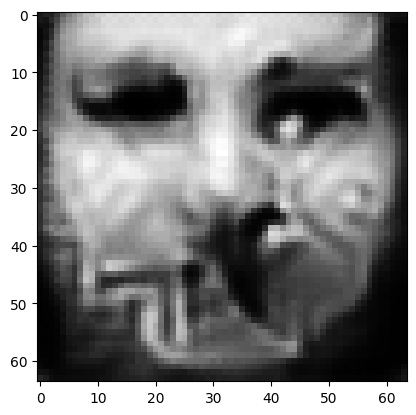

tensor([[9.5252e-01, 7.0875e-05, 2.6918e-03, 1.2548e-04, 4.1932e-04, 2.6720e-03,
         7.5455e-03, 8.3619e-03, 1.0692e-07, 3.5412e-04, 1.2551e-04, 7.8155e-05,
         1.5640e-05, 2.4440e-07, 1.1337e-04, 6.9915e-03, 5.9423e-04, 6.4818e-03,
         6.7118e-04, 2.3319e-04, 4.1936e-05, 8.3859e-05, 2.3047e-08, 7.1009e-03,
         2.5155e-05, 2.8449e-07, 2.3884e-04, 7.6059e-04, 1.1478e-03, 2.3529e-05,
         2.8837e-07, 1.4951e-04, 3.0369e-05, 2.7827e-05, 1.4705e-04, 2.9812e-05,
         5.7492e-05, 3.9954e-05, 2.0111e-05, 4.0707e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04863933473825455
tensor([[9.5257e-01, 7.0828e-05, 2.6883e-03, 1.2540e-04, 4.1901e-04, 2.6686e-03,
         7.5367e-03, 8.3520e-03, 1.0678e-07, 3.5388e-04, 1.2534e-04, 7.8042e-05,
         1.5619e-05, 2.4397e-07, 1.1326e-04, 6.9895e-03, 5.9353e-04, 6.4760e-03,
         6.7077e-04, 2.3298e-04, 4.1886e-05, 8.3732e-05, 2.2997e-08, 7.0919e-03,
         2.5112e-05, 2.8395e-07, 2.3858e-0

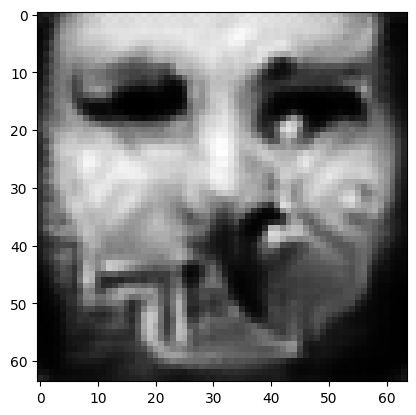

tensor([[9.5276e-01, 7.0537e-05, 2.6769e-03, 1.2479e-04, 4.1692e-04, 2.6582e-03,
         7.5017e-03, 8.3153e-03, 1.0594e-07, 3.5257e-04, 1.2481e-04, 7.7745e-05,
         1.5521e-05, 2.4217e-07, 1.1275e-04, 6.9792e-03, 5.9018e-04, 6.4526e-03,
         6.6808e-04, 2.3191e-04, 4.1681e-05, 8.3280e-05, 2.2747e-08, 7.0563e-03,
         2.4901e-05, 2.8134e-07, 2.3749e-04, 7.5528e-04, 1.1401e-03, 2.3337e-05,
         2.8542e-07, 1.4879e-04, 3.0077e-05, 2.7622e-05, 1.4639e-04, 2.9604e-05,
         5.7022e-05, 3.9639e-05, 1.9895e-05, 4.0341e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04838813096284866
tensor([[9.5281e-01, 7.0455e-05, 2.6739e-03, 1.2467e-04, 4.1664e-04, 2.6552e-03,
         7.4930e-03, 8.3094e-03, 1.0578e-07, 3.5241e-04, 1.2465e-04, 7.7629e-05,
         1.5499e-05, 2.4167e-07, 1.1260e-04, 6.9746e-03, 5.8947e-04, 6.4442e-03,
         6.6756e-04, 2.3168e-04, 4.1614e-05, 8.3194e-05, 2.2693e-08, 7.0507e-03,
         2.4862e-05, 2.8090e-07, 2.3715e-0

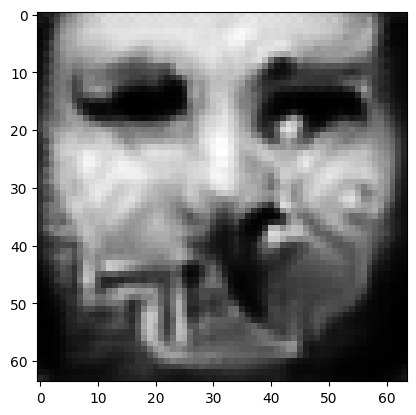

tensor([[9.5299e-01, 7.0206e-05, 2.6624e-03, 1.2412e-04, 4.1471e-04, 2.6451e-03,
         7.4612e-03, 8.2731e-03, 1.0503e-07, 3.5103e-04, 1.2413e-04, 7.7347e-05,
         1.5410e-05, 2.4006e-07, 1.1215e-04, 6.9657e-03, 5.8622e-04, 6.4258e-03,
         6.6488e-04, 2.3071e-04, 4.1433e-05, 8.2759e-05, 2.2467e-08, 7.0156e-03,
         2.4673e-05, 2.7839e-07, 2.3620e-04, 7.5023e-04, 1.1322e-03, 2.3153e-05,
         2.8271e-07, 1.4813e-04, 2.9810e-05, 2.7430e-05, 1.4574e-04, 2.9417e-05,
         5.6572e-05, 3.9341e-05, 1.9699e-05, 3.9990e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.048152316361665726
tensor([[9.5303e-01, 7.0139e-05, 2.6593e-03, 1.2400e-04, 4.1436e-04, 2.6420e-03,
         7.4527e-03, 8.2673e-03, 1.0486e-07, 3.5090e-04, 1.2398e-04, 7.7231e-05,
         1.5387e-05, 2.3956e-07, 1.1202e-04, 6.9629e-03, 5.8559e-04, 6.4168e-03,
         6.6456e-04, 2.3048e-04, 4.1372e-05, 8.2672e-05, 2.2412e-08, 7.0105e-03,
         2.4629e-05, 2.7793e-07, 2.3587e-

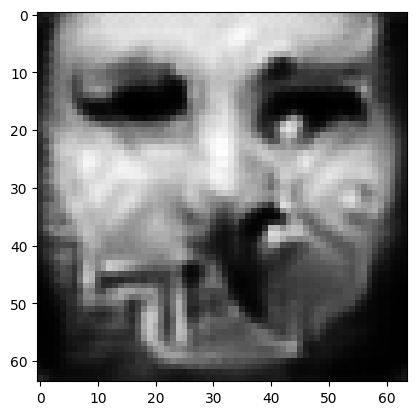

tensor([[9.5320e-01, 6.9890e-05, 2.6484e-03, 1.2349e-04, 4.1266e-04, 2.6321e-03,
         7.4217e-03, 8.2340e-03, 1.0416e-07, 3.4960e-04, 1.2350e-04, 7.6957e-05,
         1.5303e-05, 2.3809e-07, 1.1159e-04, 6.9522e-03, 5.8267e-04, 6.3995e-03,
         6.6192e-04, 2.2954e-04, 4.1200e-05, 8.2262e-05, 2.2203e-08, 6.9793e-03,
         2.4462e-05, 2.7569e-07, 2.3488e-04, 7.4551e-04, 1.1249e-03, 2.2984e-05,
         2.8017e-07, 1.4748e-04, 2.9559e-05, 2.7249e-05, 1.4513e-04, 2.9237e-05,
         5.6146e-05, 3.9065e-05, 1.9513e-05, 3.9650e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04792928323149681
tensor([[9.5324e-01, 6.9843e-05, 2.6452e-03, 1.2341e-04, 4.1243e-04, 2.6293e-03,
         7.4145e-03, 8.2270e-03, 1.0404e-07, 3.4934e-04, 1.2334e-04, 7.6853e-05,
         1.5285e-05, 2.3771e-07, 1.1150e-04, 6.9491e-03, 5.8201e-04, 6.3950e-03,
         6.6143e-04, 2.2935e-04, 4.1153e-05, 8.2157e-05, 2.2159e-08, 6.9720e-03,
         2.4429e-05, 2.7522e-07, 2.3464e-0

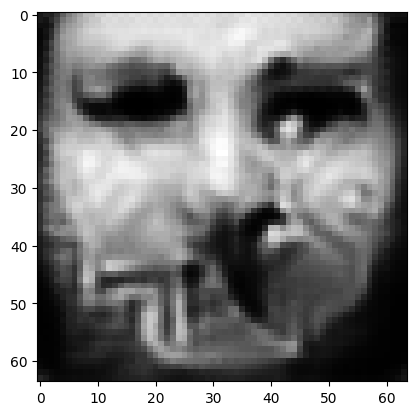

tensor([[9.5340e-01, 6.9608e-05, 2.6354e-03, 1.2292e-04, 4.1089e-04, 2.6206e-03,
         7.3855e-03, 8.1969e-03, 1.0340e-07, 3.4815e-04, 1.2287e-04, 7.6598e-05,
         1.5206e-05, 2.3633e-07, 1.1109e-04, 6.9388e-03, 5.7926e-04, 6.3786e-03,
         6.5888e-04, 2.2847e-04, 4.0987e-05, 8.1769e-05, 2.1963e-08, 6.9413e-03,
         2.4273e-05, 2.7315e-07, 2.3374e-04, 7.4106e-04, 1.1178e-03, 2.2820e-05,
         2.7776e-07, 1.4689e-04, 2.9322e-05, 2.7078e-05, 1.4462e-04, 2.9076e-05,
         5.5757e-05, 3.8804e-05, 1.9340e-05, 3.9342e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.047719839960336685
tensor([[9.5344e-01, 6.9532e-05, 2.6327e-03, 1.2274e-04, 4.1033e-04, 2.6188e-03,
         7.3798e-03, 8.1921e-03, 1.0319e-07, 3.4795e-04, 1.2278e-04, 7.6543e-05,
         1.5187e-05, 2.3587e-07, 1.1094e-04, 6.9347e-03, 5.7834e-04, 6.3717e-03,
         6.5836e-04, 2.2828e-04, 4.0926e-05, 8.1723e-05, 2.1909e-08, 6.9358e-03,
         2.4223e-05, 2.7263e-07, 2.3351e-

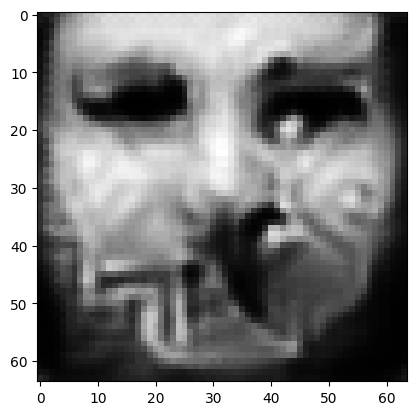

tensor([[9.5359e-01, 6.9324e-05, 2.6233e-03, 1.2239e-04, 4.0920e-04, 2.6099e-03,
         7.3520e-03, 8.1646e-03, 1.0265e-07, 3.4702e-04, 1.2231e-04, 7.6251e-05,
         1.5116e-05, 2.3458e-07, 1.1058e-04, 6.9250e-03, 5.7607e-04, 6.3545e-03,
         6.5633e-04, 2.2751e-04, 4.0768e-05, 8.1346e-05, 2.1736e-08, 6.9082e-03,
         2.4092e-05, 2.7090e-07, 2.3263e-04, 7.3689e-04, 1.1115e-03, 2.2672e-05,
         2.7558e-07, 1.4637e-04, 2.9108e-05, 2.6923e-05, 1.4407e-04, 2.8924e-05,
         5.5387e-05, 3.8570e-05, 1.9186e-05, 3.9052e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04752456396818161
tensor([[9.5362e-01, 6.9268e-05, 2.6211e-03, 1.2225e-04, 4.0874e-04, 2.6080e-03,
         7.3454e-03, 8.1577e-03, 1.0248e-07, 3.4671e-04, 1.2222e-04, 7.6201e-05,
         1.5096e-05, 2.3424e-07, 1.1047e-04, 6.9228e-03, 5.7538e-04, 6.3505e-03,
         6.5571e-04, 2.2728e-04, 4.0730e-05, 8.1257e-05, 2.1685e-08, 6.9008e-03,
         2.4050e-05, 2.7036e-07, 2.3242e-0

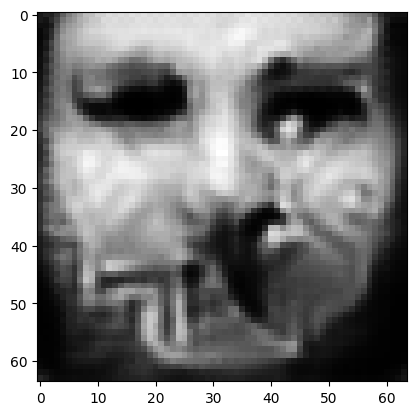

tensor([[9.5376e-01, 6.9052e-05, 2.6116e-03, 1.2179e-04, 4.0732e-04, 2.5995e-03,
         7.3206e-03, 8.1317e-03, 1.0190e-07, 3.4577e-04, 1.2181e-04, 7.5958e-05,
         1.5028e-05, 2.3297e-07, 1.1010e-04, 6.9129e-03, 5.7283e-04, 6.3337e-03,
         6.5374e-04, 2.2656e-04, 4.0572e-05, 8.0971e-05, 2.1519e-08, 6.8777e-03,
         2.3911e-05, 2.6859e-07, 2.3159e-04, 7.3305e-04, 1.1051e-03, 2.2528e-05,
         2.7342e-07, 1.4589e-04, 2.8903e-05, 2.6777e-05, 1.4351e-04, 2.8779e-05,
         5.5055e-05, 3.8344e-05, 1.9032e-05, 3.8761e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04733948037028313
tensor([[9.5380e-01, 6.9012e-05, 2.6089e-03, 1.2174e-04, 4.0723e-04, 2.5970e-03,
         7.3145e-03, 8.1251e-03, 1.0181e-07, 3.4554e-04, 1.2168e-04, 7.5870e-05,
         1.5014e-05, 2.3272e-07, 1.1004e-04, 6.9102e-03, 5.7238e-04, 6.3313e-03,
         6.5330e-04, 2.2641e-04, 4.0538e-05, 8.0878e-05, 2.1488e-08, 6.8719e-03,
         2.3892e-05, 2.6824e-07, 2.3139e-0

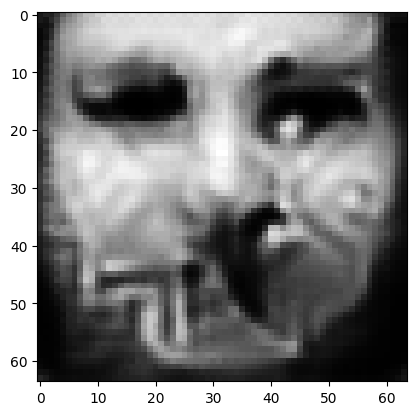

tensor([[9.5393e-01, 6.8790e-05, 2.5998e-03, 1.2128e-04, 4.0590e-04, 2.5893e-03,
         7.2919e-03, 8.1025e-03, 1.0125e-07, 3.4463e-04, 1.2128e-04, 7.5629e-05,
         1.4949e-05, 2.3144e-07, 1.0967e-04, 6.8985e-03, 5.6980e-04, 6.3151e-03,
         6.5131e-04, 2.2573e-04, 4.0372e-05, 8.0603e-05, 2.1324e-08, 6.8489e-03,
         2.3760e-05, 2.6652e-07, 2.3060e-04, 7.2936e-04, 1.0991e-03, 2.2393e-05,
         2.7146e-07, 1.4545e-04, 2.8717e-05, 2.6635e-05, 1.4300e-04, 2.8659e-05,
         5.4724e-05, 3.8129e-05, 1.8900e-05, 3.8492e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.047165170311927795
tensor([[9.5396e-01, 6.8757e-05, 2.5976e-03, 1.2120e-04, 4.0559e-04, 2.5873e-03,
         7.2861e-03, 8.0939e-03, 1.0114e-07, 3.4429e-04, 1.2118e-04, 7.5584e-05,
         1.4934e-05, 2.3126e-07, 1.0962e-04, 6.8971e-03, 5.6926e-04, 6.3145e-03,
         6.5072e-04, 2.2555e-04, 4.0351e-05, 8.0503e-05, 2.1290e-08, 6.8413e-03,
         2.3733e-05, 2.6606e-07, 2.3046e-

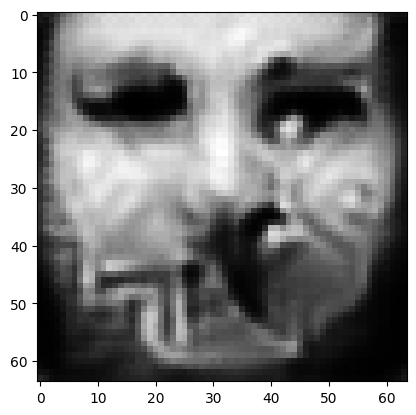

tensor([[9.5409e-01, 6.8578e-05, 2.5895e-03, 1.2085e-04, 4.0450e-04, 2.5803e-03,
         7.2640e-03, 8.0696e-03, 1.0066e-07, 3.4337e-04, 1.2080e-04, 7.5369e-05,
         1.4875e-05, 2.3019e-07, 1.0932e-04, 6.8881e-03, 5.6702e-04, 6.3024e-03,
         6.4879e-04, 2.2492e-04, 4.0219e-05, 8.0204e-05, 2.1142e-08, 6.8164e-03,
         2.3617e-05, 2.6447e-07, 2.2980e-04, 7.2604e-04, 1.0936e-03, 2.2266e-05,
         2.6955e-07, 1.4500e-04, 2.8535e-05, 2.6505e-05, 1.4264e-04, 2.8544e-05,
         5.4443e-05, 3.7924e-05, 1.8763e-05, 3.8258e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0469990149140358
tensor([[9.5412e-01, 6.8519e-05, 2.5877e-03, 1.2073e-04, 4.0413e-04, 2.5788e-03,
         7.2585e-03, 8.0648e-03, 1.0051e-07, 3.4319e-04, 1.2071e-04, 7.5316e-05,
         1.4859e-05, 2.2986e-07, 1.0923e-04, 6.8858e-03, 5.6644e-04, 6.2973e-03,
         6.4839e-04, 2.2475e-04, 4.0178e-05, 8.0147e-05, 2.1099e-08, 6.8114e-03,
         2.3582e-05, 2.6408e-07, 2.2960e-04

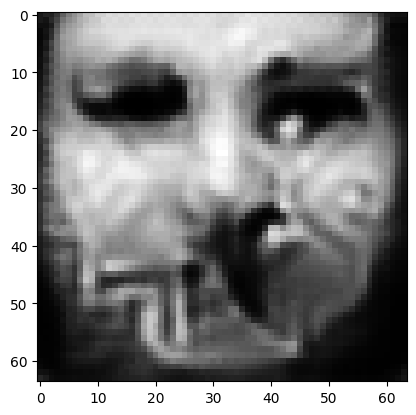

tensor([[9.5424e-01, 6.8346e-05, 2.5801e-03, 1.2039e-04, 4.0304e-04, 2.5723e-03,
         7.2381e-03, 8.0429e-03, 1.0005e-07, 3.4232e-04, 1.2036e-04, 7.5112e-05,
         1.4803e-05, 2.2886e-07, 1.0894e-04, 6.8768e-03, 5.6434e-04, 6.2854e-03,
         6.4662e-04, 2.2416e-04, 4.0049e-05, 7.9871e-05, 2.0959e-08, 6.7890e-03,
         2.3472e-05, 2.6257e-07, 2.2896e-04, 7.2291e-04, 1.0887e-03, 2.2147e-05,
         2.6772e-07, 1.4459e-04, 2.8368e-05, 2.6386e-05, 1.4218e-04, 2.8424e-05,
         5.4165e-05, 3.7728e-05, 1.8641e-05, 3.8027e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.046844322234392166
tensor([[9.5426e-01, 6.8320e-05, 2.5777e-03, 1.2034e-04, 4.0292e-04, 2.5701e-03,
         7.2333e-03, 8.0364e-03, 9.9993e-08, 3.4212e-04, 1.2024e-04, 7.5040e-05,
         1.4793e-05, 2.2865e-07, 1.0890e-04, 6.8750e-03, 5.6388e-04, 6.2838e-03,
         6.4629e-04, 2.2405e-04, 4.0022e-05, 7.9798e-05, 2.0936e-08, 6.7838e-03,
         2.3454e-05, 2.6225e-07, 2.2882e-

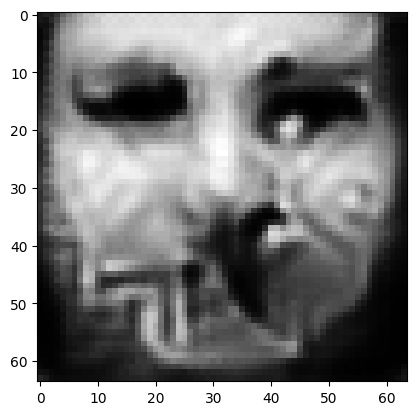

tensor([[9.5438e-01, 6.8157e-05, 2.5699e-03, 1.1997e-04, 4.0170e-04, 2.5638e-03,
         7.2147e-03, 8.0157e-03, 9.9535e-08, 3.4124e-04, 1.1991e-04, 7.4846e-05,
         1.4739e-05, 2.2766e-07, 1.0863e-04, 6.8665e-03, 5.6175e-04, 6.2724e-03,
         6.4465e-04, 2.2349e-04, 3.9895e-05, 7.9547e-05, 2.0801e-08, 6.7632e-03,
         2.3341e-05, 2.6074e-07, 2.2823e-04, 7.1984e-04, 1.0835e-03, 2.2035e-05,
         2.6605e-07, 1.4422e-04, 2.8212e-05, 2.6267e-05, 1.4178e-04, 2.8326e-05,
         5.3884e-05, 3.7541e-05, 1.8527e-05, 3.7812e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.046698592603206635
tensor([[9.5440e-01, 6.8130e-05, 2.5679e-03, 1.1989e-04, 4.0145e-04, 2.5621e-03,
         7.2103e-03, 8.0086e-03, 9.9444e-08, 3.4096e-04, 1.1983e-04, 7.4810e-05,
         1.4728e-05, 2.2750e-07, 1.0858e-04, 6.8654e-03, 5.6125e-04, 6.2718e-03,
         6.4417e-04, 2.2336e-04, 3.9877e-05, 7.9479e-05, 2.0775e-08, 6.7574e-03,
         2.3318e-05, 2.6036e-07, 2.2812e-

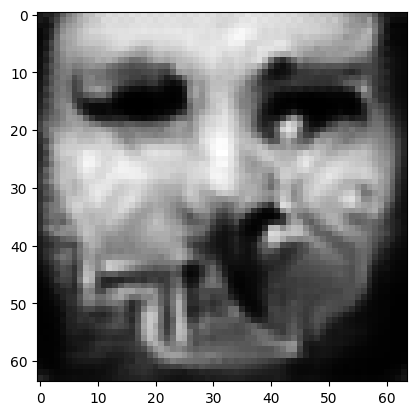

tensor([[9.5451e-01, 6.7986e-05, 2.5610e-03, 1.1958e-04, 4.0041e-04, 2.5563e-03,
         7.1919e-03, 7.9884e-03, 9.9029e-08, 3.4018e-04, 1.1952e-04, 7.4637e-05,
         1.4678e-05, 2.2660e-07, 1.0832e-04, 6.8586e-03, 5.5935e-04, 6.2610e-03,
         6.4266e-04, 2.2283e-04, 3.9766e-05, 7.9237e-05, 2.0651e-08, 6.7374e-03,
         2.3216e-05, 2.5900e-07, 2.2757e-04, 7.1709e-04, 1.0787e-03, 2.1929e-05,
         2.6450e-07, 1.4386e-04, 2.8061e-05, 2.6161e-05, 1.4143e-04, 2.8229e-05,
         5.3640e-05, 3.7367e-05, 1.8414e-05, 3.7613e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04656148701906204
tensor([[9.5453e-01, 6.7945e-05, 2.5591e-03, 1.1951e-04, 4.0022e-04, 2.5545e-03,
         7.1876e-03, 7.9849e-03, 9.8941e-08, 3.4011e-04, 1.1943e-04, 7.4569e-05,
         1.4666e-05, 2.2632e-07, 1.0825e-04, 6.8564e-03, 5.5892e-04, 6.2562e-03,
         6.4249e-04, 2.2273e-04, 3.9729e-05, 7.9196e-05, 2.0623e-08, 6.7345e-03,
         2.3192e-05, 2.5874e-07, 2.2740e-0

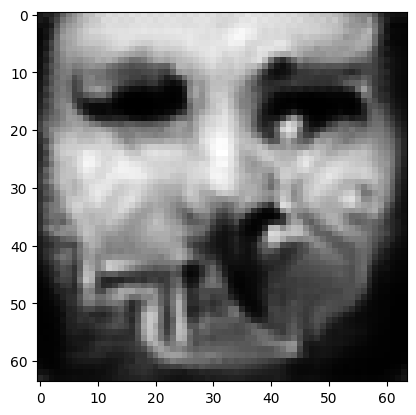

tensor([[9.5463e-01, 6.7817e-05, 2.5519e-03, 1.1922e-04, 3.9927e-04, 2.5484e-03,
         7.1710e-03, 7.9641e-03, 9.8580e-08, 3.3929e-04, 1.1912e-04, 7.4396e-05,
         1.4623e-05, 2.2556e-07, 1.0804e-04, 6.8494e-03, 5.5713e-04, 6.2484e-03,
         6.4103e-04, 2.2227e-04, 3.9633e-05, 7.8976e-05, 2.0517e-08, 6.7170e-03,
         2.3106e-05, 2.5748e-07, 2.2689e-04, 7.1438e-04, 1.0743e-03, 2.1836e-05,
         2.6314e-07, 1.4354e-04, 2.7929e-05, 2.6060e-05, 1.4107e-04, 2.8148e-05,
         5.3396e-05, 3.7208e-05, 1.8319e-05, 3.7422e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04643324390053749
tensor([[9.5465e-01, 6.7794e-05, 2.5501e-03, 1.1915e-04, 3.9899e-04, 2.5467e-03,
         7.1668e-03, 7.9576e-03, 9.8491e-08, 3.3907e-04, 1.1906e-04, 7.4367e-05,
         1.4613e-05, 2.2543e-07, 1.0801e-04, 6.8486e-03, 5.5670e-04, 6.2475e-03,
         6.4069e-04, 2.2216e-04, 3.9618e-05, 7.8921e-05, 2.0494e-08, 6.7127e-03,
         2.3084e-05, 2.5715e-07, 2.2679e-0

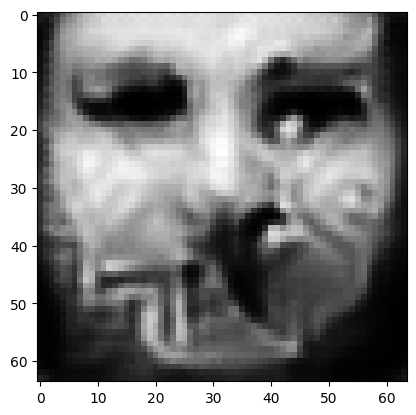

tensor([[9.5474e-01, 6.7660e-05, 2.5436e-03, 1.1884e-04, 3.9800e-04, 2.5411e-03,
         7.1508e-03, 7.9398e-03, 9.8113e-08, 3.3838e-04, 1.1879e-04, 7.4205e-05,
         1.4569e-05, 2.2461e-07, 1.0778e-04, 6.8421e-03, 5.5498e-04, 6.2371e-03,
         6.3939e-04, 2.2171e-04, 3.9517e-05, 7.8732e-05, 2.0386e-08, 6.6970e-03,
         2.2992e-05, 2.5595e-07, 2.2626e-04, 7.1192e-04, 1.0700e-03, 2.1744e-05,
         2.6181e-07, 1.4322e-04, 2.7801e-05, 2.5969e-05, 1.4072e-04, 2.8064e-05,
         5.3176e-05, 3.7056e-05, 1.8220e-05, 3.7236e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04631181061267853
tensor([[9.5477e-01, 6.7641e-05, 2.5418e-03, 1.1879e-04, 3.9779e-04, 2.5396e-03,
         7.1472e-03, 7.9338e-03, 9.8041e-08, 3.3811e-04, 1.1873e-04, 7.4175e-05,
         1.4560e-05, 2.2451e-07, 1.0775e-04, 6.8408e-03, 5.5459e-04, 6.2376e-03,
         6.3896e-04, 2.2162e-04, 3.9505e-05, 7.8668e-05, 2.0365e-08, 6.6920e-03,
         2.2976e-05, 2.5563e-07, 2.2618e-0

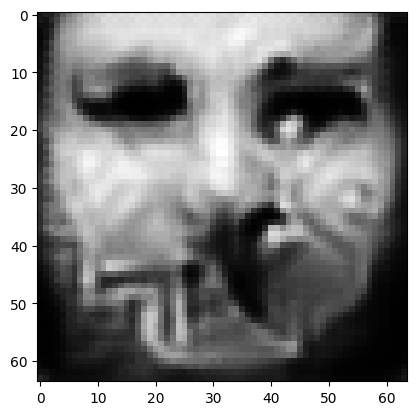

tensor([[9.5485e-01, 6.7520e-05, 2.5353e-03, 1.1853e-04, 3.9698e-04, 2.5339e-03,
         7.1321e-03, 7.9177e-03, 9.7718e-08, 3.3754e-04, 1.1845e-04, 7.3996e-05,
         1.4521e-05, 2.2374e-07, 1.0755e-04, 6.8341e-03, 5.5304e-04, 6.2270e-03,
         6.3792e-04, 2.2122e-04, 3.9406e-05, 7.8496e-05, 2.0270e-08, 6.6787e-03,
         2.2896e-05, 2.5459e-07, 2.2566e-04, 7.0956e-04, 1.0659e-03, 2.1661e-05,
         2.6063e-07, 1.4293e-04, 2.7684e-05, 2.5880e-05, 1.4041e-04, 2.7993e-05,
         5.2960e-05, 3.6915e-05, 1.8133e-05, 3.7066e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04619799181818962
tensor([[9.5487e-01, 6.7487e-05, 2.5338e-03, 1.1844e-04, 3.9667e-04, 2.5326e-03,
         7.1284e-03, 7.9136e-03, 9.7613e-08, 3.3735e-04, 1.1840e-04, 7.3966e-05,
         1.4510e-05, 2.2355e-07, 1.0749e-04, 6.8325e-03, 5.5260e-04, 6.2248e-03,
         6.3754e-04, 2.2112e-04, 3.9383e-05, 7.8457e-05, 2.0242e-08, 6.6752e-03,
         2.2873e-05, 2.5428e-07, 2.2554e-0

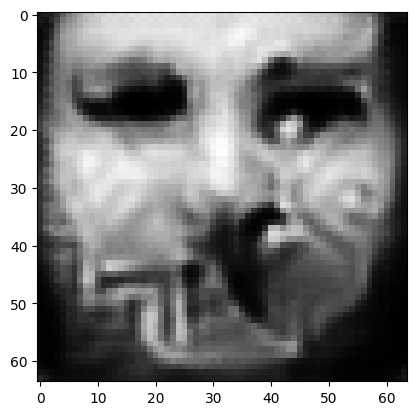

tensor([[9.5496e-01, 6.7379e-05, 2.5274e-03, 1.1818e-04, 3.9582e-04, 2.5270e-03,
         7.1146e-03, 7.8956e-03, 9.7305e-08, 3.3665e-04, 1.1815e-04, 7.3819e-05,
         1.4473e-05, 2.2294e-07, 1.0732e-04, 6.8265e-03, 5.5110e-04, 6.2184e-03,
         6.3634e-04, 2.2075e-04, 3.9305e-05, 7.8282e-05, 2.0157e-08, 6.6618e-03,
         2.2800e-05, 2.5322e-07, 2.2510e-04, 7.0738e-04, 1.0618e-03, 2.1579e-05,
         2.5946e-07, 1.4265e-04, 2.7576e-05, 2.5800e-05, 1.4008e-04, 2.7923e-05,
         5.2763e-05, 3.6781e-05, 1.8045e-05, 3.6894e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.046089619398117065
tensor([[9.5498e-01, 6.7347e-05, 2.5261e-03, 1.1811e-04, 3.9558e-04, 2.5259e-03,
         7.1111e-03, 7.8921e-03, 9.7212e-08, 3.3649e-04, 1.1809e-04, 7.3785e-05,
         1.4463e-05, 2.2275e-07, 1.0727e-04, 6.8249e-03, 5.5071e-04, 6.2159e-03,
         6.3604e-04, 2.2064e-04, 3.9281e-05, 7.8239e-05, 2.0131e-08, 6.6581e-03,
         2.2778e-05, 2.5295e-07, 2.2498e-

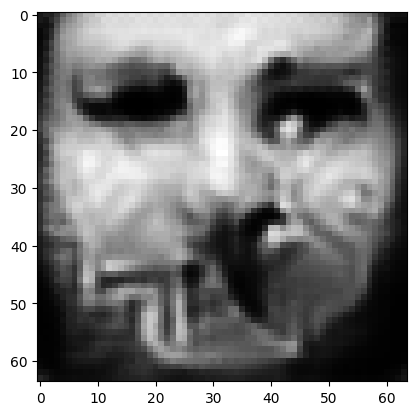

tensor([[9.5505e-01, 6.7247e-05, 2.5203e-03, 1.1787e-04, 3.9478e-04, 2.5209e-03,
         7.0978e-03, 7.8758e-03, 9.6909e-08, 3.3586e-04, 1.1786e-04, 7.3650e-05,
         1.4428e-05, 2.2214e-07, 1.0710e-04, 6.8199e-03, 5.4929e-04, 6.2090e-03,
         6.3491e-04, 2.2028e-04, 3.9204e-05, 7.8069e-05, 2.0045e-08, 6.6445e-03,
         2.2706e-05, 2.5193e-07, 2.2456e-04, 7.0530e-04, 1.0581e-03, 2.1500e-05,
         2.5833e-07, 1.4238e-04, 2.7466e-05, 2.5721e-05, 1.3978e-04, 2.7851e-05,
         5.2578e-05, 3.6650e-05, 1.7962e-05, 3.6736e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04598715901374817
tensor([[9.5507e-01, 6.7218e-05, 2.5188e-03, 1.1782e-04, 3.9463e-04, 2.5194e-03,
         7.0942e-03, 7.8728e-03, 9.6843e-08, 3.3578e-04, 1.1780e-04, 7.3596e-05,
         1.4419e-05, 2.2195e-07, 1.0706e-04, 6.8180e-03, 5.4903e-04, 6.2056e-03,
         6.3478e-04, 2.2021e-04, 3.9179e-05, 7.8034e-05, 2.0025e-08, 6.6427e-03,
         2.2690e-05, 2.5174e-07, 2.2442e-0

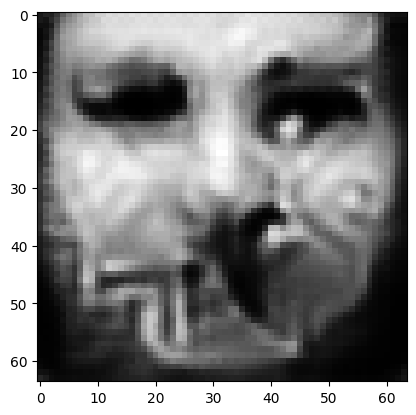

tensor([[9.5515e-01, 6.7107e-05, 2.5137e-03, 1.1758e-04, 3.9383e-04, 2.5147e-03,
         7.0816e-03, 7.8581e-03, 9.6541e-08, 3.3522e-04, 1.1759e-04, 7.3469e-05,
         1.4384e-05, 2.2135e-07, 1.0688e-04, 6.8125e-03, 5.4772e-04, 6.1978e-03,
         6.3373e-04, 2.1985e-04, 3.9103e-05, 7.7885e-05, 1.9944e-08, 6.6311e-03,
         2.2620e-05, 2.5082e-07, 2.2398e-04, 7.0332e-04, 1.0548e-03, 2.1432e-05,
         2.5733e-07, 1.4212e-04, 2.7369e-05, 2.5649e-05, 1.3947e-04, 2.7782e-05,
         5.2394e-05, 3.6535e-05, 1.7889e-05, 3.6586e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.045890722423791885
tensor([[9.5516e-01, 6.7089e-05, 2.5123e-03, 1.1753e-04, 3.9365e-04, 2.5135e-03,
         7.0787e-03, 7.8535e-03, 9.6482e-08, 3.3503e-04, 1.1754e-04, 7.3443e-05,
         1.4377e-05, 2.2125e-07, 1.0685e-04, 6.8113e-03, 5.4737e-04, 6.1976e-03,
         6.3341e-04, 2.1978e-04, 3.9090e-05, 7.7845e-05, 1.9927e-08, 6.6276e-03,
         2.2606e-05, 2.5058e-07, 2.2391e-

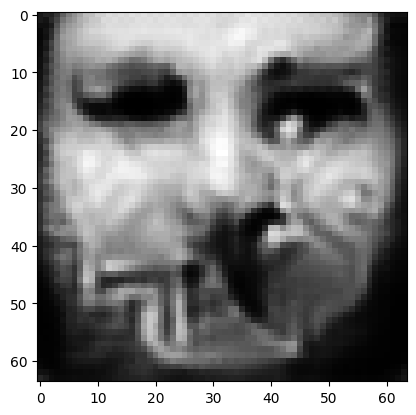

tensor([[9.5523e-01, 6.6988e-05, 2.5073e-03, 1.1732e-04, 3.9300e-04, 2.5087e-03,
         7.0665e-03, 7.8405e-03, 9.6219e-08, 3.3458e-04, 1.1733e-04, 7.3302e-05,
         1.4345e-05, 2.2066e-07, 1.0669e-04, 6.8059e-03, 5.4620e-04, 6.1888e-03,
         6.3258e-04, 2.1946e-04, 3.9014e-05, 7.7713e-05, 1.9852e-08, 6.6179e-03,
         2.2544e-05, 2.4978e-07, 2.2347e-04, 7.0147e-04, 1.0516e-03, 2.1368e-05,
         2.5644e-07, 1.4188e-04, 2.7278e-05, 2.5582e-05, 1.3921e-04, 2.7726e-05,
         5.2226e-05, 3.6427e-05, 1.7822e-05, 3.6447e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04580042511224747
tensor([[9.5525e-01, 6.6970e-05, 2.5058e-03, 1.1726e-04, 3.9280e-04, 2.5074e-03,
         7.0637e-03, 7.8357e-03, 9.6156e-08, 3.3437e-04, 1.1728e-04, 7.3279e-05,
         1.4338e-05, 2.2059e-07, 1.0667e-04, 6.8050e-03, 5.4592e-04, 6.1890e-03,
         6.3226e-04, 2.1939e-04, 3.9005e-05, 7.7666e-05, 1.9836e-08, 6.6148e-03,
         2.2531e-05, 2.4953e-07, 2.2339e-0

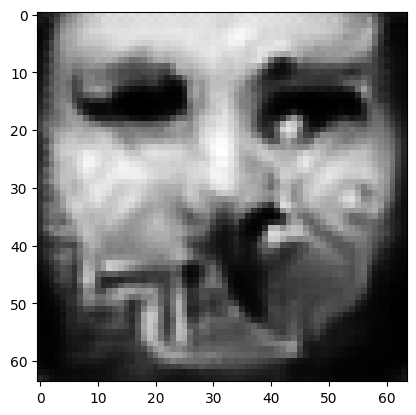

tensor([[9.5532e-01, 6.6871e-05, 2.5015e-03, 1.1706e-04, 3.9212e-04, 2.5034e-03,
         7.0520e-03, 7.8230e-03, 9.5890e-08, 3.3391e-04, 1.1710e-04, 7.3169e-05,
         1.4307e-05, 2.2004e-07, 1.0651e-04, 6.8000e-03, 5.4475e-04, 6.1815e-03,
         6.3132e-04, 2.1908e-04, 3.8937e-05, 7.7537e-05, 1.9762e-08, 6.6040e-03,
         2.2469e-05, 2.4875e-07, 2.2301e-04, 6.9980e-04, 1.0485e-03, 2.1304e-05,
         2.5553e-07, 1.4165e-04, 2.7192e-05, 2.5520e-05, 1.3897e-04, 2.7667e-05,
         5.2079e-05, 3.6325e-05, 1.7753e-05, 3.6315e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04571399465203285
tensor([[9.5533e-01, 6.6844e-05, 2.5002e-03, 1.1701e-04, 3.9201e-04, 2.5021e-03,
         7.0492e-03, 7.8207e-03, 9.5834e-08, 3.3384e-04, 1.1705e-04, 7.3124e-05,
         1.4300e-05, 2.1988e-07, 1.0647e-04, 6.7985e-03, 5.4452e-04, 6.1788e-03,
         6.3118e-04, 2.1901e-04, 3.8916e-05, 7.7509e-05, 1.9745e-08, 6.6026e-03,
         2.2456e-05, 2.4859e-07, 2.2289e-0

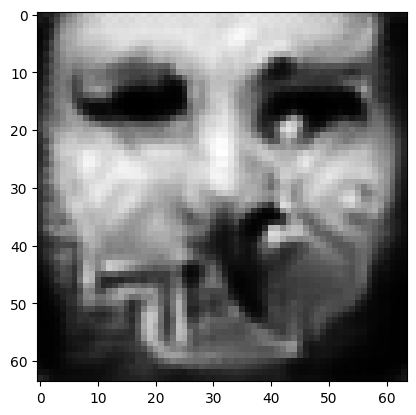

tensor([[9.5539e-01, 6.6755e-05, 2.4960e-03, 1.1682e-04, 3.9138e-04, 2.4982e-03,
         7.0384e-03, 7.8080e-03, 9.5592e-08, 3.3335e-04, 1.1687e-04, 7.3020e-05,
         1.4272e-05, 2.1941e-07, 1.0633e-04, 6.7937e-03, 5.4345e-04, 6.1729e-03,
         6.3026e-04, 2.1872e-04, 3.8856e-05, 7.7376e-05, 1.9678e-08, 6.5924e-03,
         2.2401e-05, 2.4784e-07, 2.2253e-04, 6.9815e-04, 1.0457e-03, 2.1246e-05,
         2.5472e-07, 1.4142e-04, 2.7112e-05, 2.5459e-05, 1.3873e-04, 2.7612e-05,
         5.1930e-05, 3.6230e-05, 1.7692e-05, 3.6189e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.045633476227521896
tensor([[9.5541e-01, 6.6731e-05, 2.4951e-03, 1.1677e-04, 3.9122e-04, 2.4974e-03,
         7.0357e-03, 7.8053e-03, 9.5528e-08, 3.3324e-04, 1.1683e-04, 7.3000e-05,
         1.4265e-05, 2.1928e-07, 1.0629e-04, 6.7925e-03, 5.4316e-04, 6.1714e-03,
         6.2999e-04, 2.1865e-04, 3.8840e-05, 7.7346e-05, 1.9659e-08, 6.5894e-03,
         2.2386e-05, 2.4765e-07, 2.2245e-

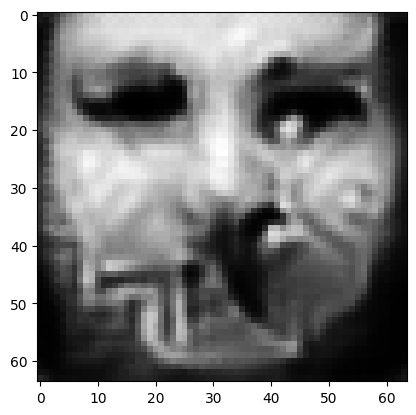

tensor([[9.5547e-01, 6.6648e-05, 2.4910e-03, 1.1660e-04, 3.9065e-04, 2.4935e-03,
         7.0256e-03, 7.7927e-03, 9.5311e-08, 3.3276e-04, 1.1667e-04, 7.2899e-05,
         1.4239e-05, 2.1886e-07, 1.0616e-04, 6.7880e-03, 5.4220e-04, 6.1666e-03,
         6.2912e-04, 2.1838e-04, 3.8787e-05, 7.7217e-05, 1.9602e-08, 6.5801e-03,
         2.2338e-05, 2.4695e-07, 2.2212e-04, 6.9663e-04, 1.0430e-03, 2.1189e-05,
         2.5393e-07, 1.4122e-04, 2.7036e-05, 2.5402e-05, 1.3852e-04, 2.7561e-05,
         5.1801e-05, 3.6142e-05, 1.7631e-05, 3.6074e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0455569364130497
tensor([[9.5548e-01, 6.6625e-05, 2.4899e-03, 1.1656e-04, 3.9056e-04, 2.4926e-03,
         7.0232e-03, 7.7909e-03, 9.5261e-08, 3.3271e-04, 1.1661e-04, 7.2861e-05,
         1.4232e-05, 2.1871e-07, 1.0612e-04, 6.7865e-03, 5.4197e-04, 6.1640e-03,
         6.2897e-04, 2.1832e-04, 3.8767e-05, 7.7191e-05, 1.9585e-08, 6.5780e-03,
         2.2325e-05, 2.4682e-07, 2.2202e-04

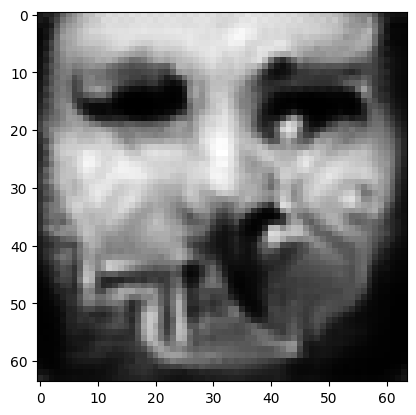

tensor([[9.5553e-01, 6.6543e-05, 2.4864e-03, 1.1639e-04, 3.9002e-04, 2.4893e-03,
         7.0132e-03, 7.7798e-03, 9.5043e-08, 3.3229e-04, 1.1646e-04, 7.2772e-05,
         1.4207e-05, 2.1828e-07, 1.0599e-04, 6.7825e-03, 5.4102e-04, 6.1586e-03,
         6.2812e-04, 2.1805e-04, 3.8713e-05, 7.7073e-05, 1.9526e-08, 6.5684e-03,
         2.2276e-05, 2.4616e-07, 2.2170e-04, 6.9518e-04, 1.0406e-03, 2.1135e-05,
         2.5318e-07, 1.4102e-04, 2.6962e-05, 2.5348e-05, 1.3831e-04, 2.7510e-05,
         5.1673e-05, 3.6058e-05, 1.7578e-05, 3.5966e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04548460617661476
tensor([[9.5555e-01, 6.6516e-05, 2.4855e-03, 1.1634e-04, 3.8986e-04, 2.4884e-03,
         7.0107e-03, 7.7773e-03, 9.4979e-08, 3.3220e-04, 1.1642e-04, 7.2750e-05,
         1.4200e-05, 2.1815e-07, 1.0595e-04, 6.7813e-03, 5.4079e-04, 6.1565e-03,
         6.2796e-04, 2.1798e-04, 3.8697e-05, 7.7053e-05, 1.9510e-08, 6.5670e-03,
         2.2262e-05, 2.4601e-07, 2.2161e-0

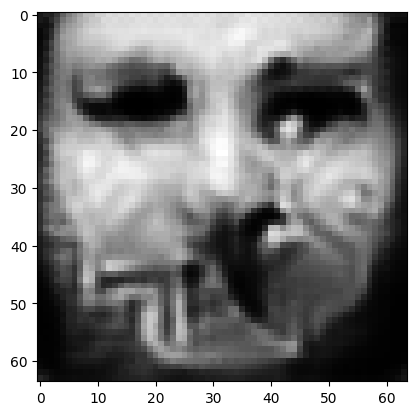

tensor([[9.5560e-01, 6.6439e-05, 2.4818e-03, 1.1619e-04, 3.8940e-04, 2.4849e-03,
         7.0012e-03, 7.7673e-03, 9.4782e-08, 3.3183e-04, 1.1626e-04, 7.2643e-05,
         1.4176e-05, 2.1773e-07, 1.0583e-04, 6.7769e-03, 5.3997e-04, 6.1504e-03,
         6.2725e-04, 2.1773e-04, 3.8642e-05, 7.6943e-05, 1.9456e-08, 6.5593e-03,
         2.2219e-05, 2.4543e-07, 2.2127e-04, 6.9379e-04, 1.0383e-03, 2.1088e-05,
         2.5249e-07, 1.4082e-04, 2.6895e-05, 2.5296e-05, 1.3810e-04, 2.7461e-05,
         5.1551e-05, 3.5979e-05, 1.7527e-05, 3.5860e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04541546106338501
tensor([[9.5561e-01, 6.6416e-05, 2.4810e-03, 1.1614e-04, 3.8925e-04, 2.4843e-03,
         6.9990e-03, 7.7652e-03, 9.4722e-08, 3.3174e-04, 1.1622e-04, 7.2624e-05,
         1.4170e-05, 2.1761e-07, 1.0579e-04, 6.7757e-03, 5.3972e-04, 6.1488e-03,
         6.2702e-04, 2.1767e-04, 3.8627e-05, 7.6917e-05, 1.9440e-08, 6.5568e-03,
         2.2205e-05, 2.4526e-07, 2.2120e-0

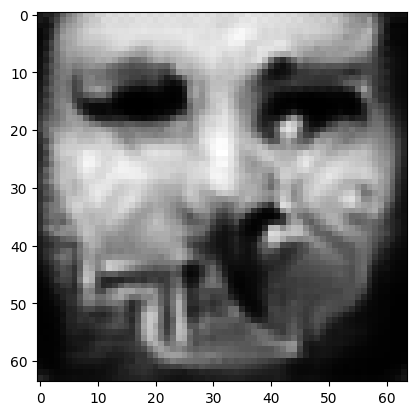

tensor([[9.5566e-01, 6.6338e-05, 2.4775e-03, 1.1599e-04, 3.8881e-04, 2.4810e-03,
         6.9900e-03, 7.7559e-03, 9.4531e-08, 3.3143e-04, 1.1607e-04, 7.2522e-05,
         1.4147e-05, 2.1719e-07, 1.0567e-04, 6.7716e-03, 5.3894e-04, 6.1422e-03,
         6.2642e-04, 2.1744e-04, 3.8572e-05, 7.6821e-05, 1.9388e-08, 6.5500e-03,
         2.2163e-05, 2.4473e-07, 2.2087e-04, 6.9246e-04, 1.0362e-03, 2.1041e-05,
         2.5183e-07, 1.4064e-04, 2.6832e-05, 2.5247e-05, 1.3789e-04, 2.7414e-05,
         5.1435e-05, 3.5904e-05, 1.7480e-05, 3.5762e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04535052925348282
tensor([[9.5567e-01, 6.6324e-05, 2.4766e-03, 1.1595e-04, 3.8868e-04, 2.4801e-03,
         6.9880e-03, 7.7527e-03, 9.4489e-08, 3.3129e-04, 1.1604e-04, 7.2508e-05,
         1.4142e-05, 2.1713e-07, 1.0565e-04, 6.7708e-03, 5.3870e-04, 6.1420e-03,
         6.2618e-04, 2.1739e-04, 3.8564e-05, 7.6795e-05, 1.9378e-08, 6.5478e-03,
         2.2153e-05, 2.4458e-07, 2.2082e-0

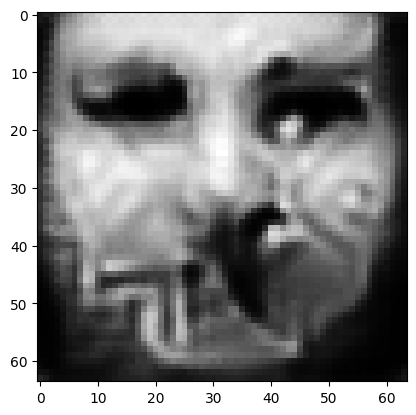

tensor([[9.5572e-01, 6.6247e-05, 2.4735e-03, 1.1580e-04, 3.8820e-04, 2.4773e-03,
         6.9794e-03, 7.7442e-03, 9.4293e-08, 3.3097e-04, 1.1591e-04, 7.2423e-05,
         1.4120e-05, 2.1672e-07, 1.0553e-04, 6.7668e-03, 5.3791e-04, 6.1360e-03,
         6.2552e-04, 2.1716e-04, 3.8512e-05, 7.6701e-05, 1.9324e-08, 6.5405e-03,
         2.2110e-05, 2.4403e-07, 2.2052e-04, 6.9124e-04, 1.0341e-03, 2.0996e-05,
         2.5118e-07, 1.4048e-04, 2.6772e-05, 2.5202e-05, 1.3771e-04, 2.7371e-05,
         5.1332e-05, 3.5832e-05, 1.7432e-05, 3.5668e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04528855159878731
tensor([[9.5573e-01, 6.6236e-05, 2.4724e-03, 1.1578e-04, 3.8815e-04, 2.4763e-03,
         6.9776e-03, 7.7413e-03, 9.4269e-08, 3.3088e-04, 1.1587e-04, 7.2395e-05,
         1.4116e-05, 2.1666e-07, 1.0552e-04, 6.7660e-03, 5.3776e-04, 6.1354e-03,
         6.2540e-04, 2.1712e-04, 3.8504e-05, 7.6679e-05, 1.9318e-08, 6.5394e-03,
         2.2104e-05, 2.4393e-07, 2.2046e-0

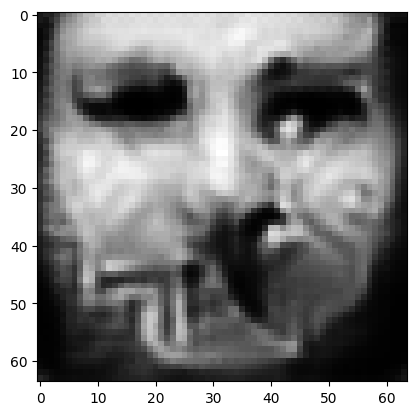

tensor([[9.5578e-01, 6.6161e-05, 2.4696e-03, 1.1562e-04, 3.8769e-04, 2.4738e-03,
         6.9693e-03, 7.7335e-03, 9.4074e-08, 3.3056e-04, 1.1574e-04, 7.2319e-05,
         1.4094e-05, 2.1626e-07, 1.0540e-04, 6.7621e-03, 5.3698e-04, 6.1295e-03,
         6.2472e-04, 2.1689e-04, 3.8452e-05, 7.6589e-05, 1.9265e-08, 6.5321e-03,
         2.2061e-05, 2.4340e-07, 2.2018e-04, 6.9004e-04, 1.0321e-03, 2.0955e-05,
         2.5059e-07, 1.4032e-04, 2.6714e-05, 2.5158e-05, 1.3753e-04, 2.7331e-05,
         5.1231e-05, 3.5765e-05, 1.7388e-05, 3.5579e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04522976279258728
tensor([[9.5579e-01, 6.6145e-05, 2.4688e-03, 1.1559e-04, 3.8756e-04, 2.4730e-03,
         6.9675e-03, 7.7307e-03, 9.4031e-08, 3.3047e-04, 1.1572e-04, 7.2302e-05,
         1.4089e-05, 2.1619e-07, 1.0537e-04, 6.7614e-03, 5.3680e-04, 6.1287e-03,
         6.2456e-04, 2.1685e-04, 3.8444e-05, 7.6568e-05, 1.9255e-08, 6.5306e-03,
         2.2052e-05, 2.4327e-07, 2.2012e-0

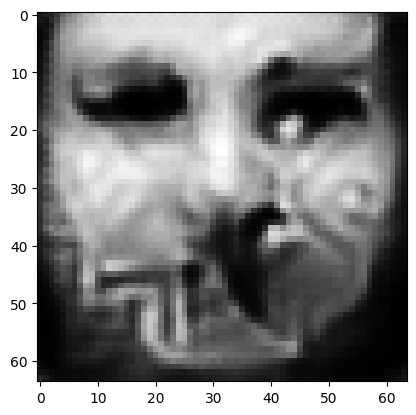

tensor([[9.5583e-01, 6.6079e-05, 2.4660e-03, 1.1547e-04, 3.8721e-04, 2.4703e-03,
         6.9595e-03, 7.7231e-03, 9.3869e-08, 3.3022e-04, 1.1559e-04, 7.2218e-05,
         1.4069e-05, 2.1583e-07, 1.0527e-04, 6.7581e-03, 5.3615e-04, 6.1229e-03,
         6.2404e-04, 2.1664e-04, 3.8398e-05, 7.6484e-05, 1.9211e-08, 6.5245e-03,
         2.2016e-05, 2.4283e-07, 2.1984e-04, 6.8893e-04, 1.0303e-03, 2.0917e-05,
         2.5005e-07, 1.4016e-04, 2.6660e-05, 2.5117e-05, 1.3737e-04, 2.7293e-05,
         5.1135e-05, 3.5703e-05, 1.7348e-05, 3.5497e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04517427086830139
tensor([[9.5584e-01, 6.6061e-05, 2.4652e-03, 1.1542e-04, 3.8708e-04, 2.4696e-03,
         6.9579e-03, 7.7208e-03, 9.3824e-08, 3.3011e-04, 1.1556e-04, 7.2203e-05,
         1.4065e-05, 2.1576e-07, 1.0524e-04, 6.7570e-03, 5.3595e-04, 6.1221e-03,
         6.2384e-04, 2.1659e-04, 3.8388e-05, 7.6463e-05, 1.9200e-08, 6.5229e-03,
         2.2007e-05, 2.4270e-07, 2.1978e-0

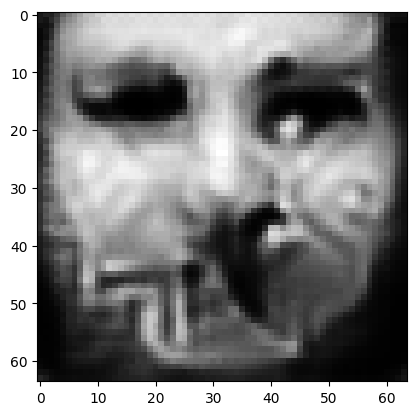

tensor([[9.5588e-01, 6.6002e-05, 2.4623e-03, 1.1531e-04, 3.8675e-04, 2.4669e-03,
         6.9505e-03, 7.7132e-03, 9.3675e-08, 3.2985e-04, 1.1543e-04, 7.2122e-05,
         1.4047e-05, 2.1543e-07, 1.0515e-04, 6.7538e-03, 5.3531e-04, 6.1172e-03,
         6.2333e-04, 2.1640e-04, 3.8345e-05, 7.6383e-05, 1.9159e-08, 6.5171e-03,
         2.1973e-05, 2.4226e-07, 2.1953e-04, 6.8786e-04, 1.0285e-03, 2.0880e-05,
         2.4953e-07, 1.4002e-04, 2.6609e-05, 2.5077e-05, 1.3721e-04, 2.7258e-05,
         5.1043e-05, 3.5642e-05, 1.7309e-05, 3.5417e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04512174427509308
tensor([[9.5589e-01, 6.5986e-05, 2.4618e-03, 1.1528e-04, 3.8664e-04, 2.4663e-03,
         6.9487e-03, 7.7110e-03, 9.3634e-08, 3.2977e-04, 1.1541e-04, 7.2109e-05,
         1.4042e-05, 2.1536e-07, 1.0513e-04, 6.7531e-03, 5.3514e-04, 6.1164e-03,
         6.2317e-04, 2.1636e-04, 3.8336e-05, 7.6363e-05, 1.9149e-08, 6.5153e-03,
         2.1964e-05, 2.4215e-07, 2.1948e-0

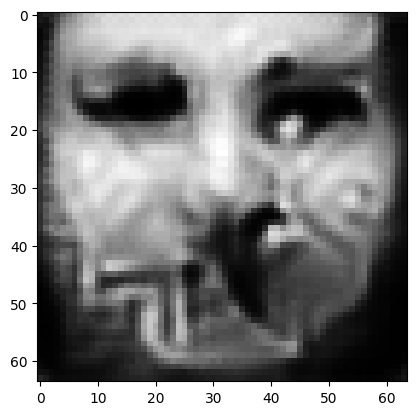

tensor([[9.5593e-01, 6.5927e-05, 2.4590e-03, 1.1516e-04, 3.8627e-04, 2.4638e-03,
         6.9419e-03, 7.7030e-03, 9.3487e-08, 3.2946e-04, 1.1530e-04, 7.2042e-05,
         1.4025e-05, 2.1508e-07, 1.0504e-04, 6.7499e-03, 5.3451e-04, 6.1127e-03,
         6.2260e-04, 2.1618e-04, 3.8299e-05, 7.6286e-05, 1.9110e-08, 6.5097e-03,
         2.1933e-05, 2.4171e-07, 2.1924e-04, 6.8688e-04, 1.0268e-03, 2.0844e-05,
         2.4902e-07, 1.3988e-04, 2.6563e-05, 2.5041e-05, 1.3707e-04, 2.7225e-05,
         5.0964e-05, 3.5586e-05, 1.7270e-05, 3.5340e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04507149010896683
tensor([[9.5594e-01, 6.5912e-05, 2.4584e-03, 1.1513e-04, 3.8621e-04, 2.4632e-03,
         6.9401e-03, 7.7020e-03, 9.3453e-08, 3.2944e-04, 1.1527e-04, 7.2018e-05,
         1.4020e-05, 2.1497e-07, 1.0502e-04, 6.7490e-03, 5.3436e-04, 6.1106e-03,
         6.2253e-04, 2.1613e-04, 3.8285e-05, 7.6271e-05, 1.9099e-08, 6.5085e-03,
         2.1925e-05, 2.4163e-07, 2.1917e-0

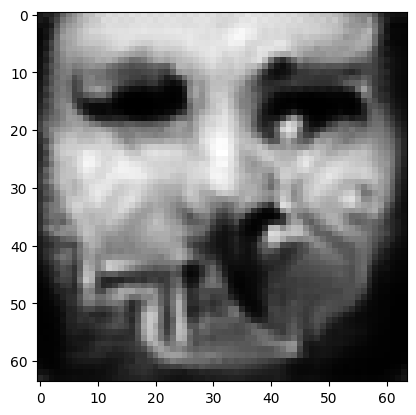

tensor([[9.5597e-01, 6.5858e-05, 2.4559e-03, 1.1502e-04, 3.8585e-04, 2.4609e-03,
         6.9337e-03, 7.6944e-03, 9.3313e-08, 3.2914e-04, 1.1516e-04, 7.1957e-05,
         1.4004e-05, 2.1470e-07, 1.0493e-04, 6.7461e-03, 5.3375e-04, 6.1073e-03,
         6.2197e-04, 2.1596e-04, 3.8251e-05, 7.6195e-05, 1.9062e-08, 6.5027e-03,
         2.1894e-05, 2.4121e-07, 2.1896e-04, 6.8592e-04, 1.0252e-03, 2.0811e-05,
         2.4854e-07, 1.3975e-04, 2.6516e-05, 2.5005e-05, 1.3694e-04, 2.7193e-05,
         5.0880e-05, 3.5531e-05, 1.7235e-05, 3.5270e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04502397030591965
tensor([[9.5598e-01, 6.5842e-05, 2.4553e-03, 1.1499e-04, 3.8575e-04, 2.4604e-03,
         6.9321e-03, 7.6926e-03, 9.3274e-08, 3.2908e-04, 1.1514e-04, 7.1942e-05,
         1.4000e-05, 2.1463e-07, 1.0491e-04, 6.7453e-03, 5.3361e-04, 6.1062e-03,
         6.2184e-04, 2.1592e-04, 3.8241e-05, 7.6179e-05, 1.9052e-08, 6.5015e-03,
         2.1886e-05, 2.4111e-07, 2.1890e-0

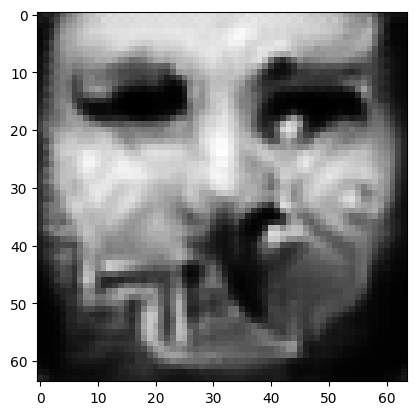

tensor([[9.5602e-01, 6.5791e-05, 2.4529e-03, 1.1489e-04, 3.8547e-04, 2.4581e-03,
         6.9260e-03, 7.6860e-03, 9.3153e-08, 3.2884e-04, 1.1504e-04, 7.1873e-05,
         1.3985e-05, 2.1435e-07, 1.0483e-04, 6.7423e-03, 5.3306e-04, 6.1023e-03,
         6.2139e-04, 2.1576e-04, 3.8206e-05, 7.6112e-05, 1.9019e-08, 6.4966e-03,
         2.1859e-05, 2.4075e-07, 2.1869e-04, 6.8499e-04, 1.0237e-03, 2.0780e-05,
         2.4811e-07, 1.3963e-04, 2.6474e-05, 2.4971e-05, 1.3681e-04, 2.7164e-05,
         5.0802e-05, 3.5482e-05, 1.7203e-05, 3.5203e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044978611171245575
tensor([[9.5603e-01, 6.5777e-05, 2.4523e-03, 1.1486e-04, 3.8538e-04, 2.4576e-03,
         6.9244e-03, 7.6843e-03, 9.3117e-08, 3.2879e-04, 1.1502e-04, 7.1861e-05,
         1.3981e-05, 2.1429e-07, 1.0481e-04, 6.7417e-03, 5.3291e-04, 6.1013e-03,
         6.2128e-04, 2.1573e-04, 3.8197e-05, 7.6095e-05, 1.9009e-08, 6.4952e-03,
         2.1851e-05, 2.4065e-07, 2.1864e-

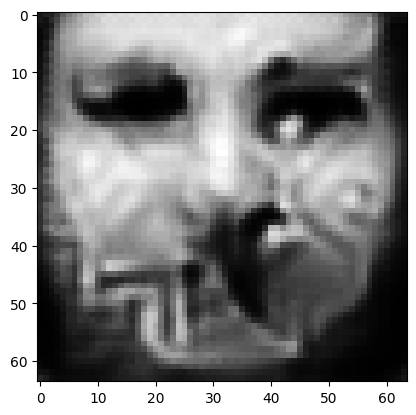

tensor([[9.5606e-01, 6.5724e-05, 2.4501e-03, 1.1476e-04, 3.8506e-04, 2.4556e-03,
         6.9185e-03, 7.6781e-03, 9.2985e-08, 3.2853e-04, 1.1493e-04, 7.1803e-05,
         1.3966e-05, 2.1403e-07, 1.0473e-04, 6.7386e-03, 5.3236e-04, 6.0977e-03,
         6.2076e-04, 2.1557e-04, 3.8163e-05, 7.6029e-05, 1.8974e-08, 6.4901e-03,
         2.1823e-05, 2.4027e-07, 2.1844e-04, 6.8416e-04, 1.0222e-03, 2.0749e-05,
         2.4766e-07, 1.3951e-04, 2.6433e-05, 2.4941e-05, 1.3667e-04, 2.7133e-05,
         5.0731e-05, 3.5432e-05, 1.7170e-05, 3.5136e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04493553191423416
tensor([[9.5607e-01, 6.5714e-05, 2.4495e-03, 1.1474e-04, 3.8503e-04, 2.4550e-03,
         6.9171e-03, 7.6766e-03, 9.2963e-08, 3.2849e-04, 1.1489e-04, 7.1783e-05,
         1.3963e-05, 2.1396e-07, 1.0471e-04, 6.7379e-03, 5.3225e-04, 6.0968e-03,
         6.2068e-04, 2.1554e-04, 3.8154e-05, 7.6012e-05, 1.8968e-08, 6.4889e-03,
         2.1818e-05, 2.4020e-07, 2.1839e-0

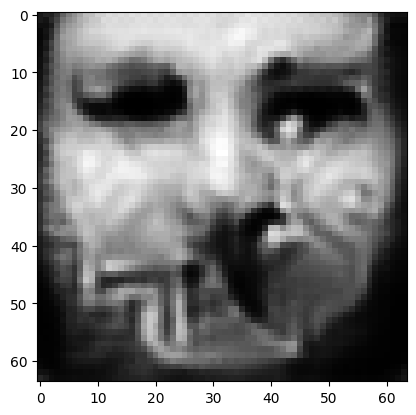

tensor([[9.5610e-01, 6.5660e-05, 2.4475e-03, 1.1464e-04, 3.8471e-04, 2.4531e-03,
         6.9114e-03, 7.6710e-03, 9.2834e-08, 3.2827e-04, 1.1481e-04, 7.1729e-05,
         1.3948e-05, 2.1371e-07, 1.0463e-04, 6.7350e-03, 5.3174e-04, 6.0927e-03,
         6.2022e-04, 2.1538e-04, 3.8120e-05, 7.5951e-05, 1.8933e-08, 6.4844e-03,
         2.1791e-05, 2.3985e-07, 2.1818e-04, 6.8333e-04, 1.0209e-03, 2.0721e-05,
         2.4726e-07, 1.3939e-04, 2.6394e-05, 2.4911e-05, 1.3655e-04, 2.7104e-05,
         5.0660e-05, 3.5387e-05, 1.7141e-05, 3.5075e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0448945015668869
tensor([[9.5611e-01, 6.5652e-05, 2.4468e-03, 1.1462e-04, 3.8464e-04, 2.4525e-03,
         6.9100e-03, 7.6686e-03, 9.2809e-08, 3.2819e-04, 1.1479e-04, 7.1718e-05,
         1.3946e-05, 2.1368e-07, 1.0463e-04, 6.7346e-03, 5.3162e-04, 6.0927e-03,
         6.2010e-04, 2.1535e-04, 3.8116e-05, 7.5935e-05, 1.8928e-08, 6.4832e-03,
         2.1786e-05, 2.3976e-07, 2.1815e-04

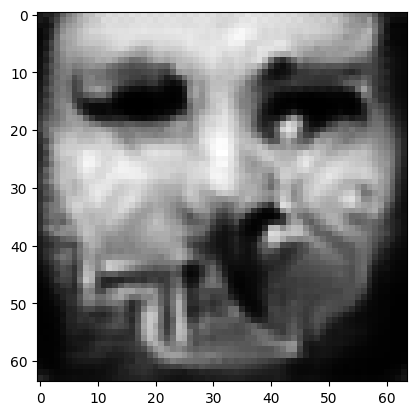

tensor([[9.5614e-01, 6.5599e-05, 2.4449e-03, 1.1452e-04, 3.8437e-04, 2.4505e-03,
         6.9042e-03, 7.6631e-03, 9.2686e-08, 3.2799e-04, 1.1471e-04, 7.1662e-05,
         1.3932e-05, 2.1344e-07, 1.0455e-04, 6.7318e-03, 5.3119e-04, 6.0886e-03,
         6.1968e-04, 2.1520e-04, 3.8084e-05, 7.5875e-05, 1.8895e-08, 6.4792e-03,
         2.1760e-05, 2.3945e-07, 2.1792e-04, 6.8254e-04, 1.0195e-03, 2.0694e-05,
         2.4688e-07, 1.3928e-04, 2.6356e-05, 2.4883e-05, 1.3644e-04, 2.7077e-05,
         5.0597e-05, 3.5345e-05, 1.7111e-05, 3.5014e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04485449567437172
tensor([[9.5614e-01, 6.5585e-05, 2.4444e-03, 1.1450e-04, 3.8434e-04, 2.4500e-03,
         6.9029e-03, 7.6621e-03, 9.2662e-08, 3.2796e-04, 1.1468e-04, 7.1642e-05,
         1.3928e-05, 2.1338e-07, 1.0453e-04, 6.7308e-03, 5.3111e-04, 6.0874e-03,
         6.1959e-04, 2.1517e-04, 3.8074e-05, 7.5859e-05, 1.8889e-08, 6.4784e-03,
         2.1756e-05, 2.3940e-07, 2.1786e-0

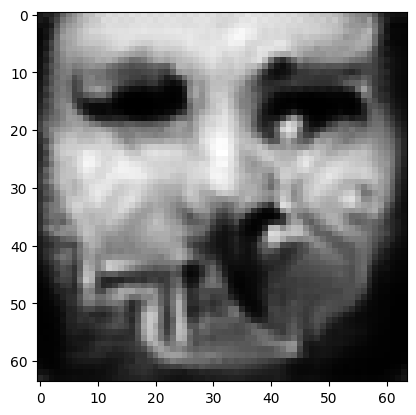

tensor([[9.5617e-01, 6.5540e-05, 2.4425e-03, 1.1442e-04, 3.8409e-04, 2.4481e-03,
         6.8977e-03, 7.6562e-03, 9.2556e-08, 3.2775e-04, 1.1461e-04, 7.1592e-05,
         1.3916e-05, 2.1318e-07, 1.0446e-04, 6.7281e-03, 5.3068e-04, 6.0846e-03,
         6.1917e-04, 2.1503e-04, 3.8047e-05, 7.5801e-05, 1.8862e-08, 6.4744e-03,
         2.1734e-05, 2.3909e-07, 2.1767e-04, 6.8177e-04, 1.0182e-03, 2.0669e-05,
         2.4654e-07, 1.3917e-04, 2.6321e-05, 2.4855e-05, 1.3634e-04, 2.7054e-05,
         5.0535e-05, 3.5306e-05, 1.7084e-05, 3.4957e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044817108660936356
tensor([[9.5618e-01, 6.5529e-05, 2.4421e-03, 1.1440e-04, 3.8403e-04, 2.4477e-03,
         6.8962e-03, 7.6548e-03, 9.2524e-08, 3.2770e-04, 1.1459e-04, 7.1584e-05,
         1.3913e-05, 2.1313e-07, 1.0444e-04, 6.7277e-03, 5.3058e-04, 6.0836e-03,
         6.1906e-04, 2.1499e-04, 3.8041e-05, 7.5786e-05, 1.8853e-08, 6.4731e-03,
         2.1727e-05, 2.3901e-07, 2.1763e-

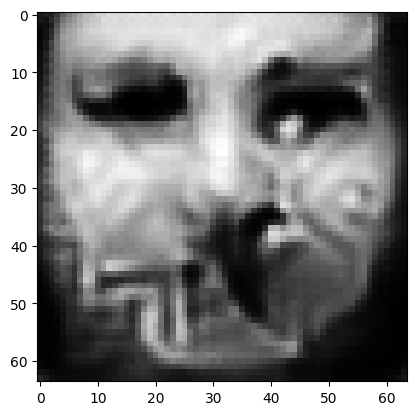

tensor([[9.5621e-01, 6.5483e-05, 2.4404e-03, 1.1431e-04, 3.8378e-04, 2.4460e-03,
         6.8912e-03, 7.6496e-03, 9.2416e-08, 3.2751e-04, 1.1452e-04, 7.1536e-05,
         1.3900e-05, 2.1293e-07, 1.0438e-04, 6.7252e-03, 5.3017e-04, 6.0804e-03,
         6.1866e-04, 2.1486e-04, 3.8013e-05, 7.5732e-05, 1.8825e-08, 6.4694e-03,
         2.1704e-05, 2.3873e-07, 2.1744e-04, 6.8108e-04, 1.0170e-03, 2.0644e-05,
         2.4618e-07, 1.3907e-04, 2.6286e-05, 2.4830e-05, 1.3624e-04, 2.7027e-05,
         5.0478e-05, 3.5268e-05, 1.7057e-05, 3.4902e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04478120431303978
tensor([[9.5621e-01, 6.5471e-05, 2.4399e-03, 1.1429e-04, 3.8371e-04, 2.4455e-03,
         6.8899e-03, 7.6481e-03, 9.2389e-08, 3.2746e-04, 1.1450e-04, 7.1525e-05,
         1.3898e-05, 2.1288e-07, 1.0436e-04, 6.7245e-03, 5.3008e-04, 6.0798e-03,
         6.1855e-04, 2.1483e-04, 3.8007e-05, 7.5717e-05, 1.8819e-08, 6.4686e-03,
         2.1699e-05, 2.3865e-07, 2.1739e-0

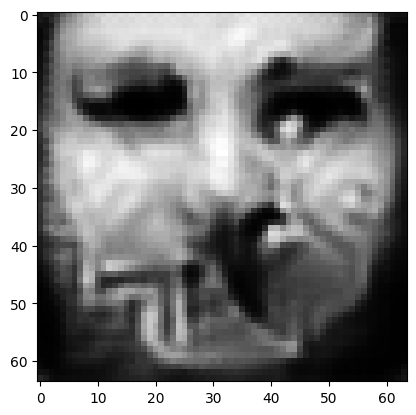

tensor([[9.5624e-01, 6.5426e-05, 2.4384e-03, 1.1421e-04, 3.8349e-04, 2.4440e-03,
         6.8850e-03, 7.6437e-03, 9.2283e-08, 3.2730e-04, 1.1444e-04, 7.1480e-05,
         1.3886e-05, 2.1268e-07, 1.0429e-04, 6.7222e-03, 5.2971e-04, 6.0761e-03,
         6.1819e-04, 2.1470e-04, 3.7979e-05, 7.5665e-05, 1.8791e-08, 6.4649e-03,
         2.1677e-05, 2.3839e-07, 2.1721e-04, 6.8042e-04, 1.0159e-03, 2.0621e-05,
         2.4585e-07, 1.3897e-04, 2.6253e-05, 2.4806e-05, 1.3613e-04, 2.7001e-05,
         5.0423e-05, 3.5232e-05, 1.7031e-05, 3.4849e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04474746063351631
tensor([[9.5625e-01, 6.5420e-05, 2.4378e-03, 1.1420e-04, 3.8347e-04, 2.4434e-03,
         6.8839e-03, 7.6420e-03, 9.2273e-08, 3.2726e-04, 1.1441e-04, 7.1464e-05,
         1.3884e-05, 2.1264e-07, 1.0429e-04, 6.7218e-03, 5.2963e-04, 6.0758e-03,
         6.1813e-04, 2.1468e-04, 3.7974e-05, 7.5652e-05, 1.8787e-08, 6.4642e-03,
         2.1674e-05, 2.3834e-07, 2.1717e-0

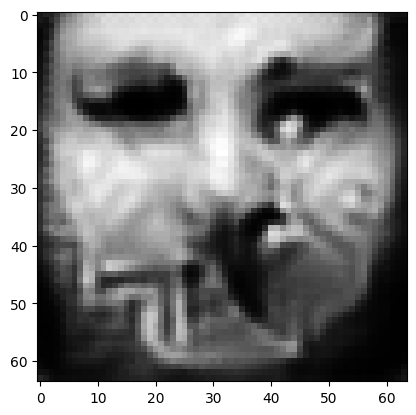

tensor([[9.5627e-01, 6.5378e-05, 2.4364e-03, 1.1413e-04, 3.8327e-04, 2.4420e-03,
         6.8793e-03, 7.6381e-03, 9.2173e-08, 3.2708e-04, 1.1435e-04, 7.1419e-05,
         1.3872e-05, 2.1245e-07, 1.0422e-04, 6.7190e-03, 5.2928e-04, 6.0726e-03,
         6.1773e-04, 2.1455e-04, 3.7947e-05, 7.5597e-05, 1.8760e-08, 6.4604e-03,
         2.1654e-05, 2.3808e-07, 2.1700e-04, 6.7979e-04, 1.0148e-03, 2.0599e-05,
         2.4555e-07, 1.3887e-04, 2.6222e-05, 2.4782e-05, 1.3605e-04, 2.6979e-05,
         5.0369e-05, 3.5197e-05, 1.7008e-05, 3.4801e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044715315103530884
tensor([[9.5628e-01, 6.5367e-05, 2.4360e-03, 1.1411e-04, 3.8321e-04, 2.4416e-03,
         6.8782e-03, 7.6369e-03, 9.2147e-08, 3.2704e-04, 1.1433e-04, 7.1411e-05,
         1.3869e-05, 2.1241e-07, 1.0421e-04, 6.7185e-03, 5.2919e-04, 6.0720e-03,
         6.1764e-04, 2.1452e-04, 3.7941e-05, 7.5585e-05, 1.8753e-08, 6.4594e-03,
         2.1649e-05, 2.3802e-07, 2.1696e-

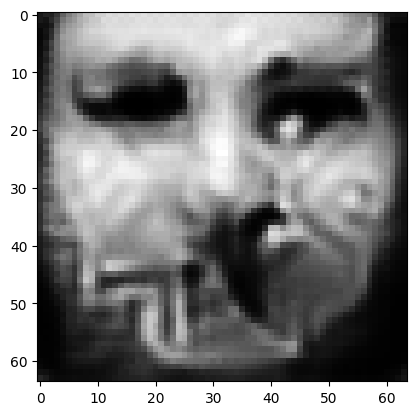

tensor([[9.5630e-01, 6.5327e-05, 2.4347e-03, 1.1404e-04, 3.8303e-04, 2.4403e-03,
         6.8739e-03, 7.6331e-03, 9.2057e-08, 3.2688e-04, 1.1427e-04, 7.1370e-05,
         1.3859e-05, 2.1223e-07, 1.0415e-04, 6.7161e-03, 5.2884e-04, 6.0691e-03,
         6.1727e-04, 2.1441e-04, 3.7915e-05, 7.5535e-05, 1.8728e-08, 6.4557e-03,
         2.1630e-05, 2.3777e-07, 2.1680e-04, 6.7921e-04, 1.0138e-03, 2.0578e-05,
         2.4525e-07, 1.3878e-04, 2.6192e-05, 2.4761e-05, 1.3596e-04, 2.6956e-05,
         5.0321e-05, 3.5164e-05, 1.6986e-05, 3.4755e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04468487575650215
tensor([[9.5630e-01, 6.5320e-05, 2.4343e-03, 1.1403e-04, 3.8298e-04, 2.4400e-03,
         6.8728e-03, 7.6317e-03, 9.2038e-08, 3.2682e-04, 1.1426e-04, 7.1362e-05,
         1.3856e-05, 2.1220e-07, 1.0414e-04, 6.7157e-03, 5.2876e-04, 6.0690e-03,
         6.1716e-04, 2.1438e-04, 3.7912e-05, 7.5518e-05, 1.8722e-08, 6.4545e-03,
         2.1626e-05, 2.3771e-07, 2.1677e-0

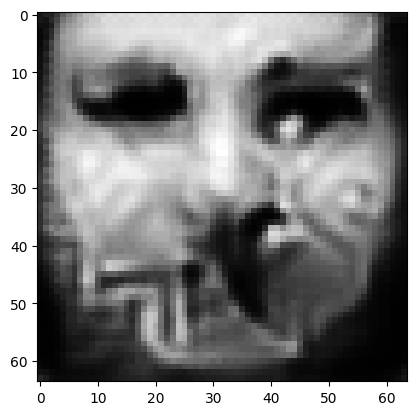

tensor([[9.5633e-01, 6.5283e-05, 2.4330e-03, 1.1397e-04, 3.8281e-04, 2.4387e-03,
         6.8687e-03, 7.6279e-03, 9.1953e-08, 3.2667e-04, 1.1420e-04, 7.1322e-05,
         1.3846e-05, 2.1203e-07, 1.0408e-04, 6.7134e-03, 5.2843e-04, 6.0662e-03,
         6.1683e-04, 2.1428e-04, 3.7888e-05, 7.5472e-05, 1.8699e-08, 6.4511e-03,
         2.1608e-05, 2.3748e-07, 2.1662e-04, 6.7866e-04, 1.0128e-03, 2.0557e-05,
         2.4497e-07, 1.3870e-04, 2.6164e-05, 2.4740e-05, 1.3589e-04, 2.6936e-05,
         5.0275e-05, 3.5132e-05, 1.6964e-05, 3.4711e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044655691832304
tensor([[9.5633e-01, 6.5272e-05, 2.4327e-03, 1.1395e-04, 3.8276e-04, 2.4385e-03,
         6.8678e-03, 7.6273e-03, 9.1927e-08, 3.2663e-04, 1.1418e-04, 7.1314e-05,
         1.3844e-05, 2.1198e-07, 1.0407e-04, 6.7127e-03, 5.2834e-04, 6.0655e-03,
         6.1672e-04, 2.1425e-04, 3.7881e-05, 7.5459e-05, 1.8692e-08, 6.4501e-03,
         2.1603e-05, 2.3742e-07, 2.1658e-04,

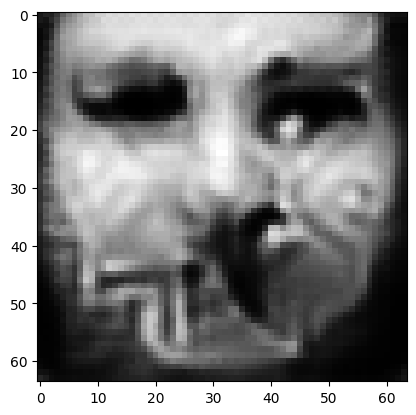

tensor([[9.5635e-01, 6.5237e-05, 2.4314e-03, 1.1389e-04, 3.8259e-04, 2.4373e-03,
         6.8638e-03, 7.6237e-03, 9.1846e-08, 3.2648e-04, 1.1413e-04, 7.1277e-05,
         1.3834e-05, 2.1183e-07, 1.0401e-04, 6.7105e-03, 5.2803e-04, 6.0630e-03,
         6.1637e-04, 2.1414e-04, 3.7859e-05, 7.5412e-05, 1.8669e-08, 6.4466e-03,
         2.1586e-05, 2.3720e-07, 2.1644e-04, 6.7813e-04, 1.0118e-03, 2.0537e-05,
         2.4468e-07, 1.3861e-04, 2.6136e-05, 2.4720e-05, 1.3581e-04, 2.6914e-05,
         5.0230e-05, 3.5100e-05, 1.6943e-05, 3.4669e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04462799057364464
tensor([[9.5636e-01, 6.5231e-05, 2.4310e-03, 1.1388e-04, 3.8257e-04, 2.4368e-03,
         6.8628e-03, 7.6227e-03, 9.1835e-08, 3.2645e-04, 1.1411e-04, 7.1263e-05,
         1.3832e-05, 2.1180e-07, 1.0401e-04, 6.7099e-03, 5.2797e-04, 6.0625e-03,
         6.1632e-04, 2.1413e-04, 3.7854e-05, 7.5400e-05, 1.8665e-08, 6.4460e-03,
         2.1583e-05, 2.3716e-07, 2.1640e-0

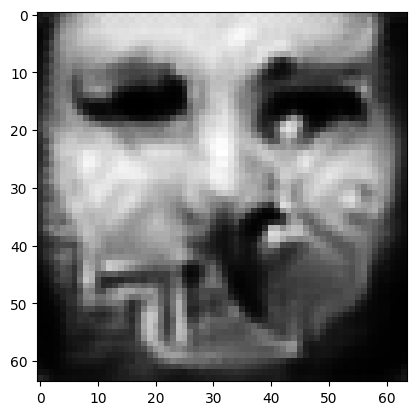

tensor([[9.5638e-01, 6.5197e-05, 2.4299e-03, 1.1383e-04, 3.8242e-04, 2.4358e-03,
         6.8591e-03, 7.6194e-03, 9.1758e-08, 3.2631e-04, 1.1406e-04, 7.1229e-05,
         1.3823e-05, 2.1165e-07, 1.0396e-04, 6.7078e-03, 5.2768e-04, 6.0601e-03,
         6.1600e-04, 2.1403e-04, 3.7832e-05, 7.5354e-05, 1.8643e-08, 6.4426e-03,
         2.1567e-05, 2.3695e-07, 2.1627e-04, 6.7761e-04, 1.0109e-03, 2.0519e-05,
         2.4443e-07, 1.3854e-04, 2.6110e-05, 2.4701e-05, 1.3574e-04, 2.6896e-05,
         5.0186e-05, 3.5072e-05, 1.6925e-05, 3.4630e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044601768255233765
tensor([[9.5638e-01, 6.5187e-05, 2.4296e-03, 1.1381e-04, 3.8238e-04, 2.4355e-03,
         6.8582e-03, 7.6186e-03, 9.1736e-08, 3.2628e-04, 1.1405e-04, 7.1221e-05,
         1.3821e-05, 2.1161e-07, 1.0394e-04, 6.7072e-03, 5.2761e-04, 6.0594e-03,
         6.1591e-04, 2.1400e-04, 3.7826e-05, 7.5344e-05, 1.8637e-08, 6.4419e-03,
         2.1562e-05, 2.3690e-07, 2.1623e-

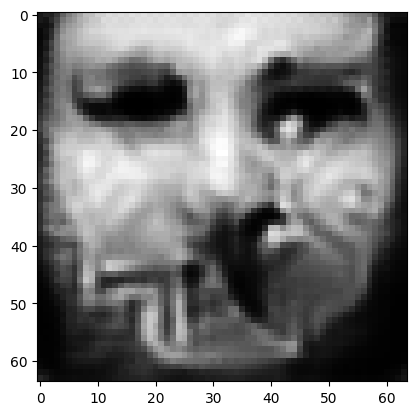

tensor([[9.5640e-01, 6.5155e-05, 2.4286e-03, 1.1375e-04, 3.8221e-04, 2.4345e-03,
         6.8547e-03, 7.6153e-03, 9.1661e-08, 3.2613e-04, 1.1400e-04, 7.1192e-05,
         1.3812e-05, 2.1147e-07, 1.0389e-04, 6.7052e-03, 5.2731e-04, 6.0574e-03,
         6.1556e-04, 2.1390e-04, 3.7806e-05, 7.5299e-05, 1.8616e-08, 6.4383e-03,
         2.1546e-05, 2.3669e-07, 2.1611e-04, 6.7714e-04, 1.0101e-03, 2.0500e-05,
         2.4417e-07, 1.3846e-04, 2.6085e-05, 2.4684e-05, 1.3567e-04, 2.6876e-05,
         5.0147e-05, 3.5044e-05, 1.6905e-05, 3.4592e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044576458632946014
tensor([[9.5641e-01, 6.5148e-05, 2.4282e-03, 1.1374e-04, 3.8219e-04, 2.4342e-03,
         6.8538e-03, 7.6145e-03, 9.1648e-08, 3.2612e-04, 1.1398e-04, 7.1179e-05,
         1.3810e-05, 2.1143e-07, 1.0388e-04, 6.7047e-03, 5.2726e-04, 6.0567e-03,
         6.1553e-04, 2.1389e-04, 3.7801e-05, 7.5291e-05, 1.8611e-08, 6.4379e-03,
         2.1543e-05, 2.3666e-07, 2.1607e-

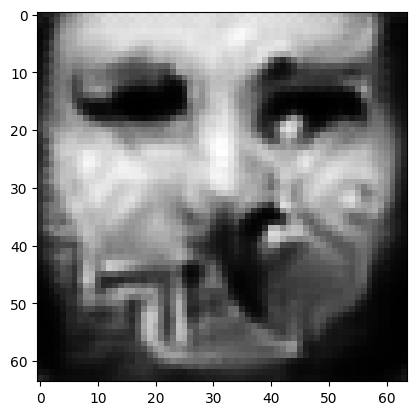

tensor([[9.5643e-01, 6.5117e-05, 2.4272e-03, 1.1369e-04, 3.8203e-04, 2.4332e-03,
         6.8505e-03, 7.6113e-03, 9.1576e-08, 3.2597e-04, 1.1394e-04, 7.1151e-05,
         1.3802e-05, 2.1130e-07, 1.0384e-04, 6.7028e-03, 5.2697e-04, 6.0549e-03,
         6.1520e-04, 2.1380e-04, 3.7782e-05, 7.5247e-05, 1.8591e-08, 6.4345e-03,
         2.1528e-05, 2.3645e-07, 2.1596e-04, 6.7668e-04, 1.0092e-03, 2.0483e-05,
         2.4393e-07, 1.3839e-04, 2.6062e-05, 2.4667e-05, 1.3561e-04, 2.6859e-05,
         5.0107e-05, 3.5017e-05, 1.6887e-05, 3.4557e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044552627950906754
tensor([[9.5643e-01, 6.5113e-05, 2.4268e-03, 1.1368e-04, 3.8201e-04, 2.4329e-03,
         6.8498e-03, 7.6107e-03, 9.1565e-08, 3.2594e-04, 1.1392e-04, 7.1139e-05,
         1.3800e-05, 2.1127e-07, 1.0383e-04, 6.7023e-03, 5.2691e-04, 6.0545e-03,
         6.1514e-04, 2.1378e-04, 3.7777e-05, 7.5236e-05, 1.8587e-08, 6.4338e-03,
         2.1525e-05, 2.3641e-07, 2.1593e-

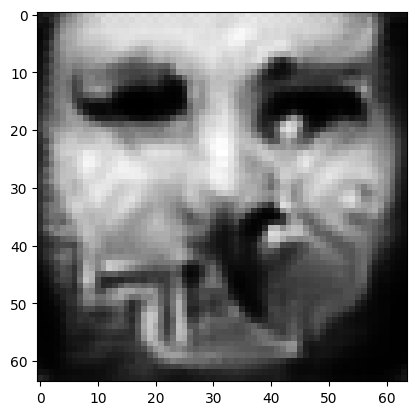

tensor([[9.5645e-01, 6.5084e-05, 2.4258e-03, 1.1363e-04, 3.8187e-04, 2.4320e-03,
         6.8467e-03, 7.6078e-03, 9.1502e-08, 3.2582e-04, 1.1388e-04, 7.1108e-05,
         1.3793e-05, 2.1114e-07, 1.0379e-04, 6.7003e-03, 5.2665e-04, 6.0526e-03,
         6.1486e-04, 2.1370e-04, 3.7758e-05, 7.5196e-05, 1.8569e-08, 6.4309e-03,
         2.1512e-05, 2.3623e-07, 2.1582e-04, 6.7623e-04, 1.0084e-03, 2.0467e-05,
         2.4371e-07, 1.3833e-04, 2.6040e-05, 2.4650e-05, 1.3555e-04, 2.6844e-05,
         5.0067e-05, 3.4992e-05, 1.6871e-05, 3.4523e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044530052691698074
tensor([[9.5645e-01, 6.5076e-05, 2.4256e-03, 1.1362e-04, 3.8183e-04, 2.4317e-03,
         6.8458e-03, 7.6070e-03, 9.1483e-08, 3.2580e-04, 1.1387e-04, 7.1101e-05,
         1.3791e-05, 2.1110e-07, 1.0378e-04, 6.7000e-03, 5.2659e-04, 6.0518e-03,
         6.1481e-04, 2.1368e-04, 3.7753e-05, 7.5189e-05, 1.8564e-08, 6.4303e-03,
         2.1507e-05, 2.3618e-07, 2.1578e-

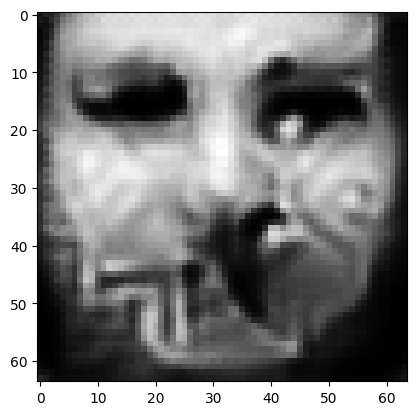

tensor([[9.5647e-01, 6.5050e-05, 2.4245e-03, 1.1358e-04, 3.8170e-04, 2.4308e-03,
         6.8429e-03, 7.6042e-03, 9.1423e-08, 3.2568e-04, 1.1382e-04, 7.1071e-05,
         1.3783e-05, 2.1098e-07, 1.0374e-04, 6.6982e-03, 5.2634e-04, 6.0500e-03,
         6.1455e-04, 2.1360e-04, 3.7735e-05, 7.5151e-05, 1.8546e-08, 6.4275e-03,
         2.1494e-05, 2.3601e-07, 2.1568e-04, 6.7581e-04, 1.0077e-03, 2.0453e-05,
         2.4349e-07, 1.3827e-04, 2.6019e-05, 2.4635e-05, 1.3548e-04, 2.6828e-05,
         5.0031e-05, 3.4967e-05, 1.6856e-05, 3.4491e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044508274644613266
tensor([[9.5647e-01, 6.5043e-05, 2.4243e-03, 1.1356e-04, 3.8166e-04, 2.4306e-03,
         6.8421e-03, 7.6037e-03, 9.1405e-08, 3.2566e-04, 1.1382e-04, 7.1066e-05,
         1.3781e-05, 2.1095e-07, 1.0373e-04, 6.6978e-03, 5.2628e-04, 6.0494e-03,
         6.1448e-04, 2.1358e-04, 3.7731e-05, 7.5142e-05, 1.8541e-08, 6.4268e-03,
         2.1490e-05, 2.3597e-07, 2.1565e-

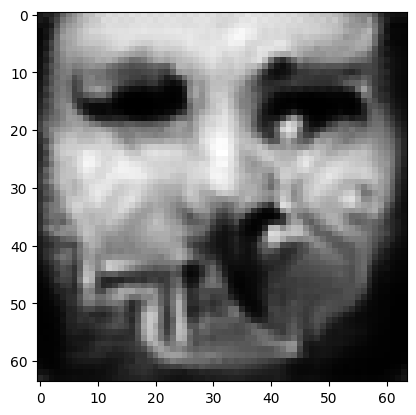

tensor([[9.5649e-01, 6.5017e-05, 2.4233e-03, 1.1352e-04, 3.8154e-04, 2.4297e-03,
         6.8394e-03, 7.6010e-03, 9.1350e-08, 3.2554e-04, 1.1377e-04, 7.1036e-05,
         1.3775e-05, 2.1084e-07, 1.0369e-04, 6.6960e-03, 5.2605e-04, 6.0478e-03,
         6.1423e-04, 2.1351e-04, 3.7714e-05, 7.5106e-05, 1.8525e-08, 6.4243e-03,
         2.1478e-05, 2.3580e-07, 2.1555e-04, 6.7542e-04, 1.0070e-03, 2.0438e-05,
         2.4328e-07, 1.3821e-04, 2.5999e-05, 2.4620e-05, 1.3543e-04, 2.6812e-05,
         4.9997e-05, 3.4944e-05, 1.6840e-05, 3.4461e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0444880947470665
tensor([[9.5649e-01, 6.5013e-05, 2.4231e-03, 1.1351e-04, 3.8150e-04, 2.4295e-03,
         6.8387e-03, 7.6001e-03, 9.1337e-08, 3.2550e-04, 1.1376e-04, 7.1031e-05,
         1.3773e-05, 2.1082e-07, 1.0368e-04, 6.6957e-03, 5.2598e-04, 6.0477e-03,
         6.1415e-04, 2.1349e-04, 3.7711e-05, 7.5096e-05, 1.8521e-08, 6.4235e-03,
         2.1475e-05, 2.3576e-07, 2.1553e-04

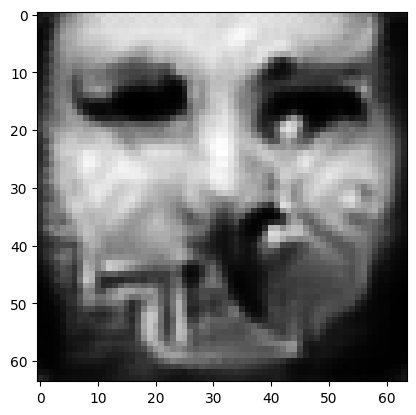

tensor([[9.5651e-01, 6.4988e-05, 2.4223e-03, 1.1347e-04, 3.8138e-04, 2.4287e-03,
         6.8360e-03, 7.5979e-03, 9.1279e-08, 3.2541e-04, 1.1372e-04, 7.1004e-05,
         1.3766e-05, 2.1069e-07, 1.0365e-04, 6.6942e-03, 5.2576e-04, 6.0455e-03,
         6.1394e-04, 2.1342e-04, 3.7693e-05, 7.5064e-05, 1.8504e-08, 6.4210e-03,
         2.1462e-05, 2.3560e-07, 2.1543e-04, 6.7505e-04, 1.0063e-03, 2.0424e-05,
         2.4308e-07, 1.3815e-04, 2.5979e-05, 2.4606e-05, 1.3537e-04, 2.6797e-05,
         4.9964e-05, 3.4922e-05, 1.6826e-05, 3.4432e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04446859657764435
tensor([[9.5651e-01, 6.4983e-05, 2.4220e-03, 1.1346e-04, 3.8135e-04, 2.4285e-03,
         6.8353e-03, 7.5970e-03, 9.1267e-08, 3.2537e-04, 1.1371e-04, 7.0998e-05,
         1.3765e-05, 2.1068e-07, 1.0364e-04, 6.6937e-03, 5.2571e-04, 6.0456e-03,
         6.1386e-04, 2.1341e-04, 3.7691e-05, 7.5053e-05, 1.8501e-08, 6.4203e-03,
         2.1460e-05, 2.3556e-07, 2.1541e-0

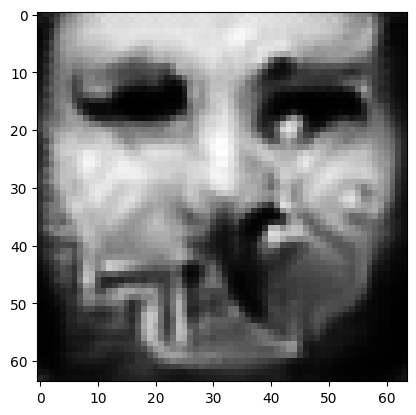

tensor([[9.5652e-01, 6.4959e-05, 2.4212e-03, 1.1342e-04, 3.8123e-04, 2.4277e-03,
         6.8328e-03, 7.5948e-03, 9.1214e-08, 3.2528e-04, 1.1368e-04, 7.0973e-05,
         1.3758e-05, 2.1057e-07, 1.0360e-04, 6.6922e-03, 5.2549e-04, 6.0437e-03,
         6.1364e-04, 2.1334e-04, 3.7675e-05, 7.5022e-05, 1.8486e-08, 6.4179e-03,
         2.1448e-05, 2.3541e-07, 2.1532e-04, 6.7469e-04, 1.0057e-03, 2.0411e-05,
         2.4289e-07, 1.3810e-04, 2.5961e-05, 2.4593e-05, 1.3532e-04, 2.6784e-05,
         4.9933e-05, 3.4901e-05, 1.6812e-05, 3.4405e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04445001110434532
tensor([[9.5653e-01, 6.4954e-05, 2.4210e-03, 1.1341e-04, 3.8120e-04, 2.4276e-03,
         6.8321e-03, 7.5941e-03, 9.1200e-08, 3.2525e-04, 1.1367e-04, 7.0968e-05,
         1.3757e-05, 2.1055e-07, 1.0360e-04, 6.6919e-03, 5.2543e-04, 6.0434e-03,
         6.1358e-04, 2.1332e-04, 3.7671e-05, 7.5014e-05, 1.8482e-08, 6.4173e-03,
         2.1445e-05, 2.3538e-07, 2.1530e-0

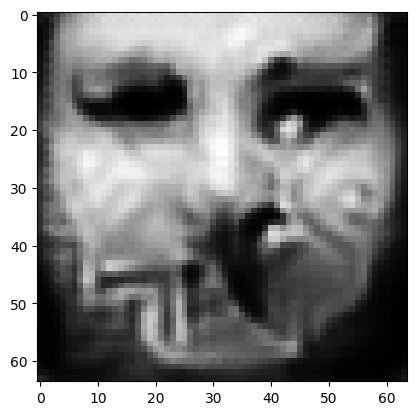

tensor([[9.5654e-01, 6.4932e-05, 2.4201e-03, 1.1337e-04, 3.8110e-04, 2.4268e-03,
         6.8297e-03, 7.5919e-03, 9.1152e-08, 3.2517e-04, 1.1363e-04, 7.0943e-05,
         1.3751e-05, 2.1044e-07, 1.0356e-04, 6.6905e-03, 5.2523e-04, 6.0417e-03,
         6.1338e-04, 2.1326e-04, 3.7656e-05, 7.4986e-05, 1.8468e-08, 6.4152e-03,
         2.1434e-05, 2.3524e-07, 2.1521e-04, 6.7435e-04, 1.0051e-03, 2.0398e-05,
         2.4272e-07, 1.3805e-04, 2.5944e-05, 2.4581e-05, 1.3527e-04, 2.6772e-05,
         4.9904e-05, 3.4882e-05, 1.6799e-05, 3.4379e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044432565569877625
tensor([[9.5654e-01, 6.4927e-05, 2.4200e-03, 1.1336e-04, 3.8106e-04, 2.4267e-03,
         6.8292e-03, 7.5915e-03, 9.1138e-08, 3.2514e-04, 1.1362e-04, 7.0939e-05,
         1.3749e-05, 2.1042e-07, 1.0355e-04, 6.6901e-03, 5.2517e-04, 6.0413e-03,
         6.1332e-04, 2.1324e-04, 3.7652e-05, 7.4978e-05, 1.8464e-08, 6.4145e-03,
         2.1431e-05, 2.3520e-07, 2.1519e-

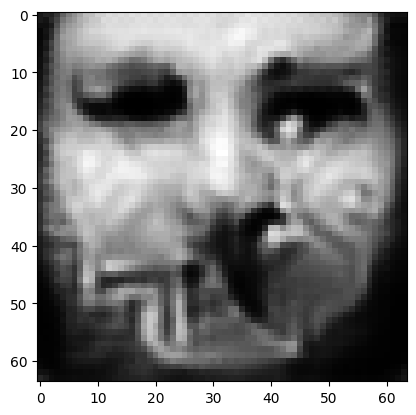

tensor([[9.5656e-01, 6.4907e-05, 2.4192e-03, 1.1332e-04, 3.8095e-04, 2.4259e-03,
         6.8269e-03, 7.5889e-03, 9.1092e-08, 3.2503e-04, 1.1359e-04, 7.0918e-05,
         1.3744e-05, 2.1034e-07, 1.0353e-04, 6.6888e-03, 5.2497e-04, 6.0404e-03,
         6.1310e-04, 2.1318e-04, 3.7640e-05, 7.4949e-05, 1.8451e-08, 6.4123e-03,
         2.1421e-05, 2.3506e-07, 2.1512e-04, 6.7403e-04, 1.0045e-03, 2.0386e-05,
         2.4254e-07, 1.3800e-04, 2.5928e-05, 2.4569e-05, 1.3523e-04, 2.6760e-05,
         4.9877e-05, 3.4863e-05, 1.6786e-05, 3.4354e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0444159172475338
tensor([[9.5656e-01, 6.4902e-05, 2.4190e-03, 1.1331e-04, 3.8094e-04, 2.4257e-03,
         6.8263e-03, 7.5887e-03, 9.1081e-08, 3.2503e-04, 1.1358e-04, 7.0910e-05,
         1.3743e-05, 2.1031e-07, 1.0352e-04, 6.6884e-03, 5.2494e-04, 6.0396e-03,
         6.1308e-04, 2.1317e-04, 3.7636e-05, 7.4944e-05, 1.8448e-08, 6.4120e-03,
         2.1418e-05, 2.3504e-07, 2.1509e-04

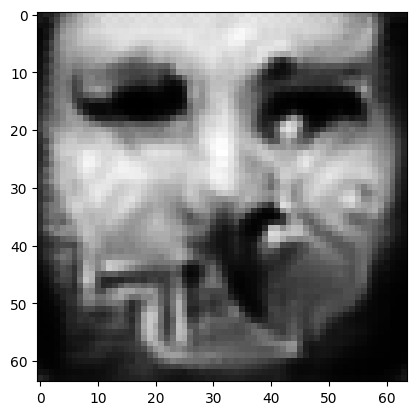

tensor([[9.5657e-01, 6.4882e-05, 2.4183e-03, 1.1328e-04, 3.8083e-04, 2.4251e-03,
         6.8242e-03, 7.5865e-03, 9.1034e-08, 3.2494e-04, 1.1355e-04, 7.0891e-05,
         1.3737e-05, 2.1022e-07, 1.0349e-04, 6.6872e-03, 5.2474e-04, 6.0383e-03,
         6.1288e-04, 2.1311e-04, 3.7623e-05, 7.4917e-05, 1.8435e-08, 6.4098e-03,
         2.1408e-05, 2.3491e-07, 2.1502e-04, 6.7372e-04, 1.0040e-03, 2.0375e-05,
         2.4239e-07, 1.3796e-04, 2.5913e-05, 2.4558e-05, 1.3518e-04, 2.6748e-05,
         4.9850e-05, 3.4846e-05, 1.6775e-05, 3.4331e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044400181621313095
tensor([[9.5657e-01, 6.4877e-05, 2.4181e-03, 1.1327e-04, 3.8081e-04, 2.4249e-03,
         6.8237e-03, 7.5861e-03, 9.1025e-08, 3.2493e-04, 1.1354e-04, 7.0883e-05,
         1.3736e-05, 2.1019e-07, 1.0348e-04, 6.6869e-03, 5.2470e-04, 6.0378e-03,
         6.1285e-04, 2.1310e-04, 3.7619e-05, 7.4912e-05, 1.8432e-08, 6.4095e-03,
         2.1406e-05, 2.3488e-07, 2.1500e-

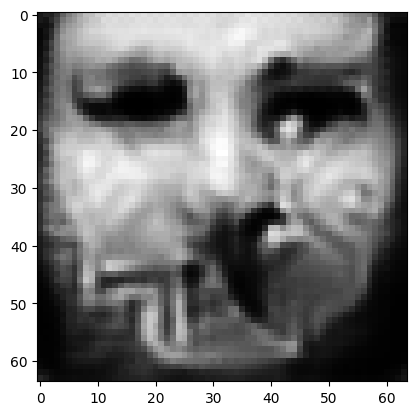

tensor([[9.5659e-01, 6.4860e-05, 2.4173e-03, 1.1324e-04, 3.8071e-04, 2.4242e-03,
         6.8217e-03, 7.5839e-03, 9.0983e-08, 3.2483e-04, 1.1351e-04, 7.0865e-05,
         1.3731e-05, 2.1012e-07, 1.0346e-04, 6.6857e-03, 5.2452e-04, 6.0370e-03,
         6.1265e-04, 2.1305e-04, 3.7608e-05, 7.4883e-05, 1.8421e-08, 6.4074e-03,
         2.1397e-05, 2.3475e-07, 2.1493e-04, 6.7343e-04, 1.0034e-03, 2.0365e-05,
         2.4224e-07, 1.3792e-04, 2.5899e-05, 2.4547e-05, 1.3514e-04, 2.6738e-05,
         4.9825e-05, 3.4829e-05, 1.6764e-05, 3.4310e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04438512772321701
tensor([[9.5659e-01, 6.4855e-05, 2.4172e-03, 1.1323e-04, 3.8070e-04, 2.4241e-03,
         6.8211e-03, 7.5836e-03, 9.0972e-08, 3.2483e-04, 1.1350e-04, 7.0858e-05,
         1.3730e-05, 2.1009e-07, 1.0345e-04, 6.6854e-03, 5.2449e-04, 6.0363e-03,
         6.1262e-04, 2.1303e-04, 3.7604e-05, 7.4878e-05, 1.8417e-08, 6.4071e-03,
         2.1394e-05, 2.3473e-07, 2.1490e-0

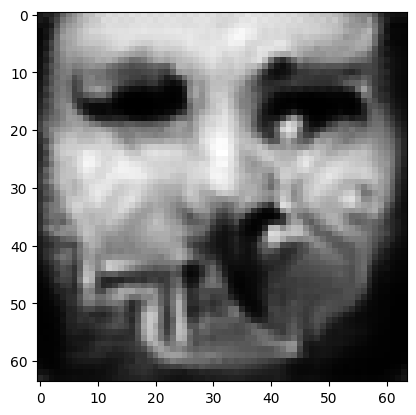

tensor([[9.5660e-01, 6.4837e-05, 2.4165e-03, 1.1320e-04, 3.8059e-04, 2.4235e-03,
         6.8191e-03, 7.5817e-03, 9.0929e-08, 3.2474e-04, 1.1348e-04, 7.0841e-05,
         1.3725e-05, 2.1001e-07, 1.0342e-04, 6.6843e-03, 5.2431e-04, 6.0351e-03,
         6.1244e-04, 2.1298e-04, 3.7592e-05, 7.4853e-05, 1.8405e-08, 6.4052e-03,
         2.1385e-05, 2.3461e-07, 2.1484e-04, 6.7315e-04, 1.0030e-03, 2.0355e-05,
         2.4209e-07, 1.3788e-04, 2.5884e-05, 2.4537e-05, 1.3510e-04, 2.6727e-05,
         4.9800e-05, 3.4813e-05, 1.6754e-05, 3.4289e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044370874762535095
tensor([[9.5660e-01, 6.4832e-05, 2.4164e-03, 1.1319e-04, 3.8057e-04, 2.4234e-03,
         6.8186e-03, 7.5813e-03, 9.0919e-08, 3.2473e-04, 1.1347e-04, 7.0836e-05,
         1.3724e-05, 2.0999e-07, 1.0341e-04, 6.6840e-03, 5.2427e-04, 6.0348e-03,
         6.1239e-04, 2.1297e-04, 3.7589e-05, 7.4848e-05, 1.8402e-08, 6.4048e-03,
         2.1383e-05, 2.3458e-07, 2.1482e-

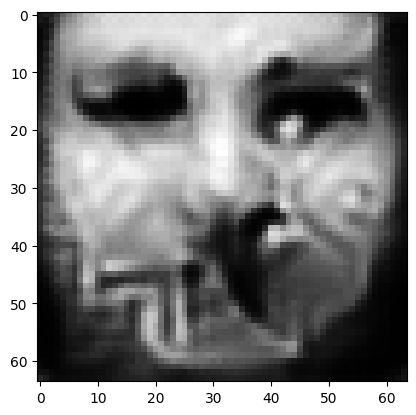

tensor([[9.5661e-01, 6.4815e-05, 2.4157e-03, 1.1316e-04, 3.8049e-04, 2.4228e-03,
         6.8168e-03, 7.5796e-03, 9.0880e-08, 3.2466e-04, 1.1344e-04, 7.0816e-05,
         1.3719e-05, 2.0991e-07, 1.0339e-04, 6.6829e-03, 5.2411e-04, 6.0335e-03,
         6.1224e-04, 2.1292e-04, 3.7578e-05, 7.4826e-05, 1.8391e-08, 6.4031e-03,
         2.1374e-05, 2.3448e-07, 2.1475e-04, 6.7289e-04, 1.0025e-03, 2.0345e-05,
         2.4196e-07, 1.3784e-04, 2.5871e-05, 2.4528e-05, 1.3506e-04, 2.6717e-05,
         4.9777e-05, 3.4798e-05, 1.6744e-05, 3.4269e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0443573035299778
tensor([[9.5661e-01, 6.4813e-05, 2.4156e-03, 1.1316e-04, 3.8047e-04, 2.4226e-03,
         6.8163e-03, 7.5790e-03, 9.0873e-08, 3.2463e-04, 1.1343e-04, 7.0813e-05,
         1.3718e-05, 2.0990e-07, 1.0338e-04, 6.6826e-03, 5.2408e-04, 6.0335e-03,
         6.1218e-04, 2.1291e-04, 3.7576e-05, 7.4818e-05, 1.8389e-08, 6.4025e-03,
         2.1373e-05, 2.3445e-07, 2.1474e-04

In [14]:
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=0)

tensor([[3.4713e-03, 1.2601e-03, 7.9833e-03, 5.4270e-03, 8.8898e-02, 8.4707e-04,
         1.6127e-03, 1.4663e-03, 1.4164e-03, 1.3463e-04, 4.2232e-04, 1.0595e-03,
         9.2519e-03, 2.0949e-02, 2.3434e-03, 6.2844e-04, 2.3632e-02, 5.2971e-03,
         2.1626e-03, 8.3675e-04, 1.5805e-02, 4.6692e-03, 2.9303e-01, 2.5239e-03,
         1.1666e-01, 2.3455e-02, 2.2279e-03, 3.2929e-03, 9.4658e-04, 5.7554e-03,
         3.6073e-03, 7.6531e-03, 1.2323e-02, 1.4340e-02, 1.1156e-02, 3.3076e-02,
         2.3484e-01, 2.0808e-02, 9.6893e-03, 5.0422e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  6.676576137542725


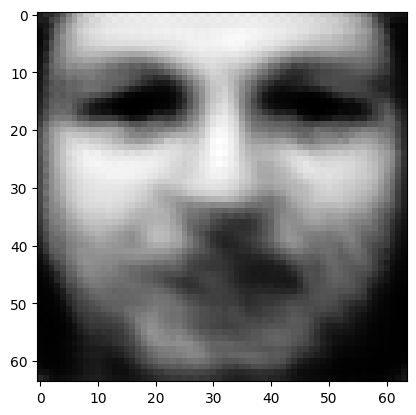

tensor([[0.0044, 0.0024, 0.0075, 0.0055, 0.0773, 0.0012, 0.0018, 0.0020, 0.0023,
         0.0003, 0.0007, 0.0015, 0.0073, 0.0229, 0.0029, 0.0010, 0.0228, 0.0058,
         0.0029, 0.0012, 0.0134, 0.0059, 0.2275, 0.0038, 0.1524, 0.0491, 0.0027,
         0.0032, 0.0010, 0.0091, 0.0039, 0.0096, 0.0143, 0.0140, 0.0126, 0.0291,
         0.2327, 0.0271, 0.0100, 0.0049]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  6.041886329650879
tensor([[0.0057, 0.0038, 0.0073, 0.0055, 0.0798, 0.0022, 0.0035, 0.0032, 0.0036,
         0.0006, 0.0019, 0.0025, 0.0065, 0.0287, 0.0063, 0.0017, 0.0301, 0.0135,
         0.0039, 0.0017, 0.0180, 0.0068, 0.1588, 0.0055, 0.1833, 0.0479, 0.0040,
         0.0049, 0.0018, 0.0133, 0.0034, 0.0127, 0.0207, 0.0125, 0.0163, 0.0461,
         0.1818, 0.0343, 0.0103, 0.0056]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  5.562577247619629
tensor([[0.0117, 0.0093, 0.0229, 0.0152, 0.0721, 0.0077, 0.0325, 0.0171, 0.0055,
         0.

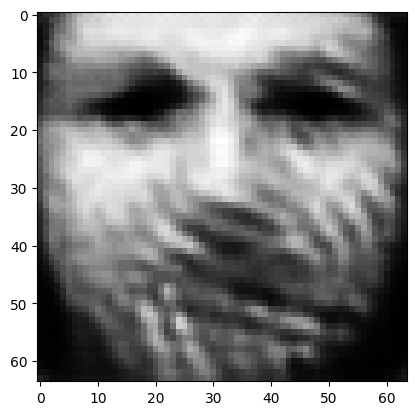

tensor([[6.7095e-04, 3.8856e-02, 1.5223e-03, 1.7000e-02, 5.9947e-03, 1.0955e-03,
         3.9748e-04, 3.6723e-03, 9.9164e-03, 6.1558e-04, 3.7415e-03, 4.6537e-03,
         9.5257e-03, 1.4646e-02, 1.8309e-03, 8.5286e-04, 2.6771e-03, 7.0700e-03,
         1.9680e-03, 7.8515e-04, 5.2098e-03, 7.1358e-04, 1.0406e-01, 9.6316e-04,
         1.2745e-02, 5.3422e-01, 1.0156e-03, 5.2424e-03, 1.4404e-03, 9.9046e-03,
         1.5703e-02, 3.4766e-03, 8.2892e-03, 1.9199e-03, 2.1933e-02, 9.2476e-02,
         3.2860e-02, 1.7464e-02, 1.4128e-03, 1.4611e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  3.247891664505005
tensor([[0.0045, 0.1385, 0.0169, 0.0442, 0.0126, 0.0251, 0.0052, 0.0145, 0.0414,
         0.0100, 0.0162, 0.0250, 0.0521, 0.0102, 0.0136, 0.0053, 0.0083, 0.0442,
         0.0108, 0.0255, 0.0301, 0.0009, 0.0141, 0.0017, 0.0106, 0.0204, 0.0154,
         0.0124, 0.0283, 0.0581, 0.0258, 0.0165, 0.0643, 0.0049, 0.0909, 0.0249,
         0.0082, 0.0154, 0.0138, 0.0194]], d

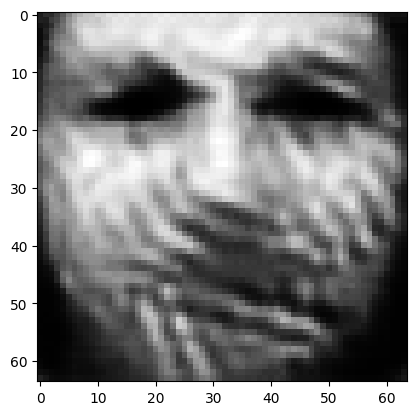

tensor([[0.0020, 0.3870, 0.0045, 0.0570, 0.0040, 0.0087, 0.0012, 0.0103, 0.0232,
         0.0057, 0.0160, 0.0261, 0.0177, 0.0061, 0.0044, 0.0030, 0.0028, 0.0227,
         0.0065, 0.0046, 0.0111, 0.0004, 0.0191, 0.0014, 0.0052, 0.0643, 0.0058,
         0.0069, 0.0145, 0.0337, 0.0225, 0.0162, 0.0248, 0.0014, 0.0488, 0.0673,
         0.0095, 0.0247, 0.0033, 0.0055]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.9493081569671631
tensor([[1.8812e-03, 4.0850e-01, 4.1492e-03, 5.5112e-02, 3.8007e-03, 8.6305e-03,
         1.1209e-03, 9.7266e-03, 2.1031e-02, 5.5050e-03, 1.5418e-02, 2.5406e-02,
         1.7201e-02, 5.6059e-03, 4.4549e-03, 3.0069e-03, 2.6928e-03, 2.2843e-02,
         6.2571e-03, 4.3289e-03, 1.0714e-02, 3.6695e-04, 1.8974e-02, 1.3919e-03,
         5.0197e-03, 6.1614e-02, 5.6700e-03, 6.4187e-03, 1.4149e-02, 3.1967e-02,
         1.9684e-02, 1.6244e-02, 2.3807e-02, 1.2419e-03, 4.7643e-02, 6.8144e-02,
         9.1949e-03, 2.2957e-02, 3.0082e-03, 5.1140e-03]], 

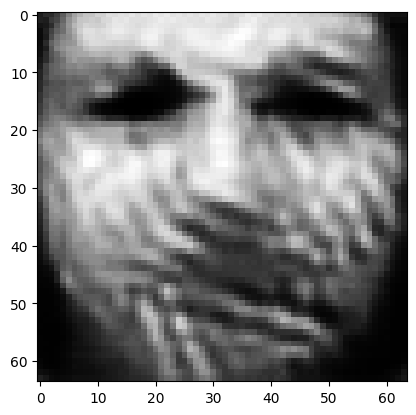

tensor([[1.5997e-03, 4.7471e-01, 3.0874e-03, 4.7156e-02, 3.0827e-03, 7.3525e-03,
         9.0896e-04, 8.0595e-03, 1.6081e-02, 4.4931e-03, 1.3343e-02, 2.2960e-02,
         1.4656e-02, 4.2886e-03, 3.9448e-03, 2.8327e-03, 2.2492e-03, 1.9545e-02,
         5.4359e-03, 3.5287e-03, 9.3403e-03, 2.6836e-04, 1.8580e-02, 1.1646e-03,
         4.1058e-03, 6.0170e-02, 4.6350e-03, 5.1071e-03, 1.2575e-02, 2.9485e-02,
         1.4229e-02, 1.5212e-02, 2.0982e-02, 9.3762e-04, 4.1673e-02, 6.8609e-02,
         7.7795e-03, 1.9219e-02, 2.3987e-03, 4.2102e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.7450459599494934
tensor([[1.7478e-03, 4.8844e-01, 3.3284e-03, 4.5971e-02, 3.1388e-03, 8.6042e-03,
         9.8234e-04, 8.9237e-03, 1.4891e-02, 4.8561e-03, 1.3405e-02, 2.3642e-02,
         1.4908e-02, 4.0208e-03, 4.2781e-03, 3.2343e-03, 2.3899e-03, 2.0236e-02,
         6.0185e-03, 3.9015e-03, 9.9936e-03, 2.6909e-04, 1.6962e-02, 1.2204e-03,
         3.8253e-03, 4.8032e-02, 5.1236e-03

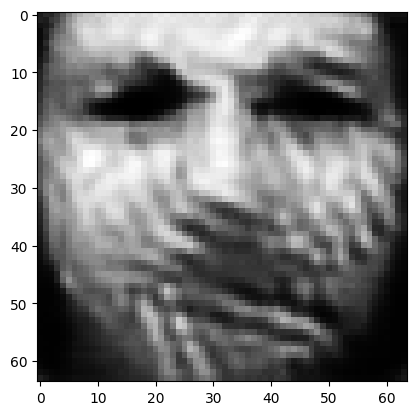

tensor([[1.4970e-03, 5.3589e-01, 2.7060e-03, 4.0752e-02, 2.7964e-03, 7.8897e-03,
         8.5716e-04, 7.2378e-03, 1.2019e-02, 4.4624e-03, 1.1761e-02, 2.2383e-02,
         1.3813e-02, 3.2105e-03, 4.1307e-03, 3.0782e-03, 2.2387e-03, 1.8366e-02,
         5.4234e-03, 3.4907e-03, 9.1593e-03, 2.2349e-04, 1.6591e-02, 1.1111e-03,
         3.5015e-03, 4.3397e-02, 4.6092e-03, 3.8809e-03, 1.2131e-02, 2.8314e-02,
         1.0263e-02, 1.5556e-02, 2.0359e-02, 7.4754e-04, 3.7970e-02, 6.0678e-02,
         6.2210e-03, 1.5095e-02, 2.1786e-03, 4.0123e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.6238324642181396
tensor([[1.3521e-03, 5.4649e-01, 2.3870e-03, 3.7696e-02, 2.5795e-03, 6.9689e-03,
         7.9086e-04, 6.3999e-03, 1.1773e-02, 4.2669e-03, 1.1244e-02, 2.1950e-02,
         1.3198e-02, 2.9939e-03, 3.8929e-03, 2.8160e-03, 2.0453e-03, 1.7107e-02,
         4.9510e-03, 3.2539e-03, 8.7601e-03, 2.0654e-04, 1.6456e-02, 9.9498e-04,
         3.3475e-03, 4.6406e-02, 4.2968e-03

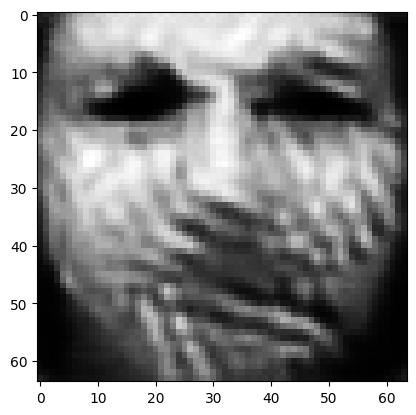

tensor([[1.1566e-03, 5.9596e-01, 1.8724e-03, 3.5455e-02, 2.2213e-03, 6.3303e-03,
         6.6980e-04, 5.0429e-03, 9.1589e-03, 3.7797e-03, 9.0752e-03, 2.0208e-02,
         1.2411e-02, 2.3317e-03, 3.5069e-03, 2.5810e-03, 1.9089e-03, 1.4116e-02,
         4.5875e-03, 2.8367e-03, 7.5357e-03, 1.6466e-04, 1.5916e-02, 8.5812e-04,
         3.0437e-03, 3.9631e-02, 3.7473e-03, 2.5950e-03, 9.7604e-03, 2.7615e-02,
         7.5594e-03, 1.3626e-02, 1.7281e-02, 6.3348e-04, 3.1702e-02, 6.1607e-02,
         4.8048e-03, 1.1169e-02, 1.8975e-03, 3.6412e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.5175784230232239
tensor([[1.3185e-03, 6.0747e-01, 1.9769e-03, 3.3862e-02, 2.3159e-03, 7.1601e-03,
         7.2681e-04, 5.5339e-03, 8.4718e-03, 3.9649e-03, 8.9958e-03, 2.0489e-02,
         1.2142e-02, 2.2105e-03, 3.8030e-03, 2.9602e-03, 1.9874e-03, 1.4954e-02,
         5.1898e-03, 3.1608e-03, 7.9217e-03, 1.7219e-04, 1.4248e-02, 9.2373e-04,
         2.7467e-03, 3.2266e-02, 4.1460e-03

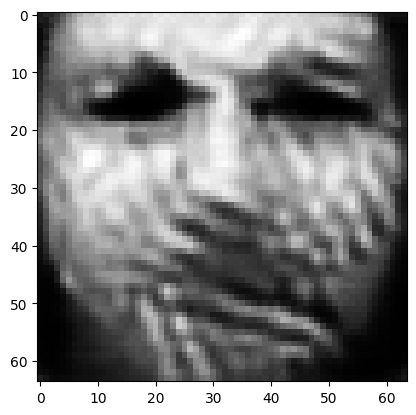

tensor([[1.1521e-03, 6.5758e-01, 1.4910e-03, 2.9094e-02, 2.1541e-03, 6.5262e-03,
         6.5943e-04, 4.5579e-03, 6.1957e-03, 3.5045e-03, 6.9183e-03, 1.8502e-02,
         1.1078e-02, 1.6856e-03, 3.5247e-03, 2.7205e-03, 1.9015e-03, 1.2290e-02,
         4.6292e-03, 2.9285e-03, 6.5429e-03, 1.4790e-04, 1.3594e-02, 8.5988e-04,
         2.5761e-03, 2.5528e-02, 3.4819e-03, 1.8216e-03, 8.6566e-03, 2.8007e-02,
         5.2787e-03, 1.2502e-02, 1.6329e-02, 5.3514e-04, 2.6218e-02, 5.1603e-02,
         3.7061e-03, 8.0205e-03, 1.7992e-03, 3.7020e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.4191938042640686
tensor([[1.1361e-03, 6.6922e-01, 1.4014e-03, 2.7759e-02, 2.1443e-03, 6.4631e-03,
         6.5316e-04, 4.4855e-03, 5.6520e-03, 3.4016e-03, 6.5628e-03, 1.7887e-02,
         1.0683e-02, 1.5774e-03, 3.4830e-03, 2.7288e-03, 1.9028e-03, 1.1881e-02,
         4.6033e-03, 2.8961e-03, 6.2020e-03, 1.4318e-04, 1.3203e-02, 8.5788e-04,
         2.5189e-03, 2.3921e-02, 3.3535e-03

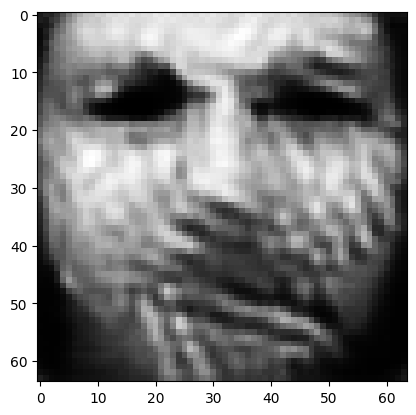

tensor([[9.5418e-04, 7.1036e-01, 1.0890e-03, 2.3976e-02, 1.8371e-03, 5.4853e-03,
         5.6265e-04, 3.7907e-03, 4.2584e-03, 2.8574e-03, 5.2721e-03, 1.5783e-02,
         9.5536e-03, 1.3009e-03, 2.9010e-03, 2.4788e-03, 1.7789e-03, 9.2414e-03,
         4.2341e-03, 2.5170e-03, 4.8999e-03, 1.2589e-04, 1.2403e-02, 7.6512e-04,
         2.3088e-03, 2.1368e-02, 2.7685e-03, 1.3458e-03, 7.0066e-03, 2.6543e-02,
         4.0925e-03, 1.0837e-02, 1.4127e-02, 4.6091e-04, 2.0248e-02, 4.6446e-02,
         3.0750e-03, 6.1051e-03, 1.6063e-03, 3.2343e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.3419806659221649
tensor([[9.7126e-04, 7.1886e-01, 1.0842e-03, 2.3338e-02, 1.8204e-03, 5.7141e-03,
         5.6627e-04, 3.8308e-03, 3.9995e-03, 2.8321e-03, 5.0769e-03, 1.5652e-02,
         9.4983e-03, 1.2492e-03, 2.8860e-03, 2.6035e-03, 1.8120e-03, 9.0597e-03,
         4.3858e-03, 2.6028e-03, 4.8285e-03, 1.2608e-04, 1.1891e-02, 7.9046e-04,
         2.2011e-03, 1.9548e-02, 2.7952e-03

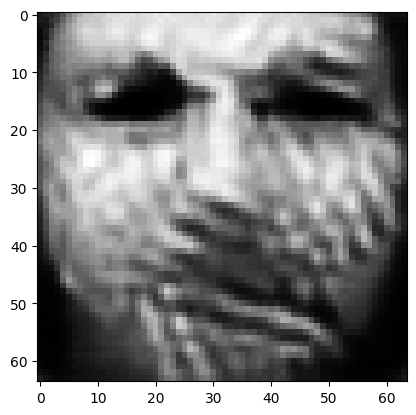

tensor([[8.8775e-04, 7.5104e-01, 9.1534e-04, 1.9418e-02, 1.5673e-03, 5.2280e-03,
         5.1649e-04, 3.4690e-03, 3.1303e-03, 2.5791e-03, 4.2245e-03, 1.4540e-02,
         8.5589e-03, 1.0556e-03, 2.5030e-03, 2.5954e-03, 1.7161e-03, 7.4486e-03,
         4.2320e-03, 2.4482e-03, 4.0391e-03, 1.1671e-04, 1.0642e-02, 7.4328e-04,
         1.8496e-03, 1.6918e-02, 2.5128e-03, 1.0744e-03, 6.1662e-03, 2.5331e-02,
         3.3403e-03, 9.7862e-03, 1.2550e-02, 4.1742e-04, 1.6153e-02, 3.8512e-02,
         2.5300e-03, 4.7867e-03, 1.4445e-03, 3.0142e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.2862970232963562
tensor([[8.6553e-04, 7.5770e-01, 8.7185e-04, 1.8878e-02, 1.4755e-03, 4.9687e-03,
         4.9799e-04, 3.3524e-03, 3.0107e-03, 2.4967e-03, 4.0767e-03, 1.4164e-02,
         8.3143e-03, 1.0204e-03, 2.4194e-03, 2.5112e-03, 1.6353e-03, 7.0778e-03,
         4.1398e-03, 2.3692e-03, 3.8419e-03, 1.1288e-04, 1.0286e-02, 7.0436e-04,
         1.7788e-03, 1.6374e-02, 2.4397e-03

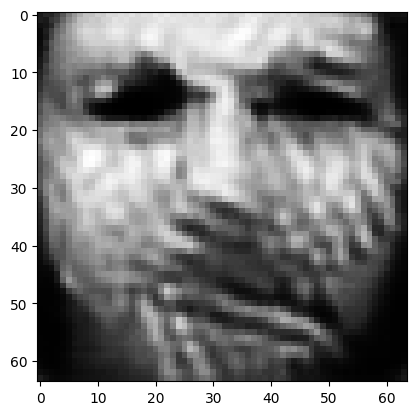

tensor([[8.2851e-04, 7.8227e-01, 7.8747e-04, 1.6695e-02, 1.3001e-03, 4.7342e-03,
         4.6280e-04, 3.1589e-03, 2.4618e-03, 2.3428e-03, 3.5383e-03, 1.3215e-02,
         7.7400e-03, 9.0394e-04, 2.1768e-03, 2.4654e-03, 1.5571e-03, 5.8668e-03,
         4.0040e-03, 2.3017e-03, 3.2686e-03, 1.0497e-04, 9.0040e-03, 6.6614e-04,
         1.5763e-03, 1.3610e-02, 2.2369e-03, 8.4746e-04, 5.2728e-03, 2.3890e-02,
         2.8304e-03, 8.8306e-03, 1.1645e-02, 3.7972e-04, 1.2917e-02, 3.4159e-02,
         1.9620e-03, 3.9925e-03, 1.3673e-03, 2.6314e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.24555936455726624
tensor([[8.0827e-04, 7.8718e-01, 7.6276e-04, 1.6253e-02, 1.2576e-03, 4.6563e-03,
         4.5163e-04, 3.0648e-03, 2.3672e-03, 2.3093e-03, 3.4162e-03, 1.3033e-02,
         7.6181e-03, 8.8013e-04, 2.1051e-03, 2.4364e-03, 1.5344e-03, 5.5997e-03,
         3.9298e-03, 2.2650e-03, 3.1450e-03, 1.0254e-04, 8.7790e-03, 6.5266e-04,
         1.5341e-03, 1.3236e-02, 2.1862e-0

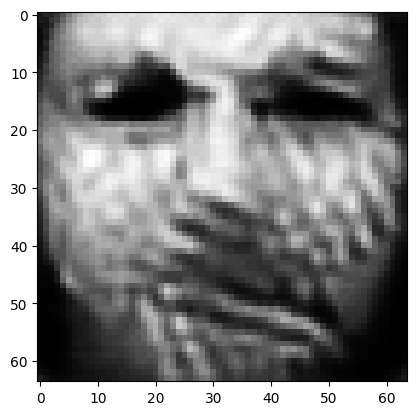

tensor([[7.8518e-04, 8.0343e-01, 7.1353e-04, 1.5098e-02, 1.1692e-03, 4.6545e-03,
         4.3001e-04, 2.9578e-03, 2.0389e-03, 2.2296e-03, 3.0545e-03, 1.2358e-02,
         7.2746e-03, 8.0363e-04, 1.9647e-03, 2.4523e-03, 1.5247e-03, 4.9954e-03,
         3.8643e-03, 2.2345e-03, 2.8372e-03, 9.5289e-05, 7.9980e-03, 6.3804e-04,
         1.3946e-03, 1.1337e-02, 2.0809e-03, 7.2545e-04, 4.7038e-03, 2.2339e-02,
         2.4539e-03, 8.0450e-03, 1.0757e-02, 3.4541e-04, 1.1183e-02, 3.0167e-02,
         1.6711e-03, 3.4462e-03, 1.2834e-03, 2.4622e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.21886040270328522
tensor([[7.6672e-04, 8.0677e-01, 6.8816e-04, 1.4784e-02, 1.1327e-03, 4.4649e-03,
         4.1924e-04, 2.8868e-03, 1.9794e-03, 2.1683e-03, 2.9748e-03, 1.2085e-02,
         7.1499e-03, 7.9048e-04, 1.9242e-03, 2.3841e-03, 1.4933e-03, 4.8559e-03,
         3.7925e-03, 2.1575e-03, 2.7423e-03, 9.2492e-05, 7.9512e-03, 6.1660e-04,
         1.3740e-03, 1.1252e-02, 2.0293e-0

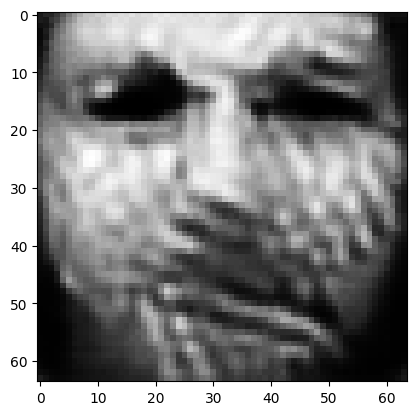

tensor([[7.2493e-04, 8.1776e-01, 6.3926e-04, 1.4222e-02, 1.0610e-03, 4.2891e-03,
         3.9397e-04, 2.7188e-03, 1.7977e-03, 2.0529e-03, 2.7014e-03, 1.1460e-02,
         6.9540e-03, 7.4307e-04, 1.8009e-03, 2.2959e-03, 1.4709e-03, 4.4632e-03,
         3.6302e-03, 2.0462e-03, 2.5147e-03, 8.5517e-05, 7.6709e-03, 5.8897e-04,
         1.3033e-03, 1.0382e-02, 1.9120e-03, 6.5240e-04, 4.1679e-03, 2.0923e-02,
         2.2401e-03, 7.4249e-03, 9.8525e-03, 3.1805e-04, 1.0118e-02, 2.8546e-02,
         1.5147e-03, 3.1093e-03, 1.1928e-03, 2.2600e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.2011895328760147
tensor([[7.1909e-04, 8.1992e-01, 6.3178e-04, 1.4063e-02, 1.0462e-03, 4.2534e-03,
         3.8931e-04, 2.6959e-03, 1.7619e-03, 2.0331e-03, 2.6518e-03, 1.1354e-02,
         6.9032e-03, 7.3427e-04, 1.7762e-03, 2.2843e-03, 1.4644e-03, 4.3836e-03,
         3.6114e-03, 2.0248e-03, 2.4705e-03, 8.4311e-05, 7.5939e-03, 5.8264e-04,
         1.2854e-03, 1.0216e-02, 1.8953e-03

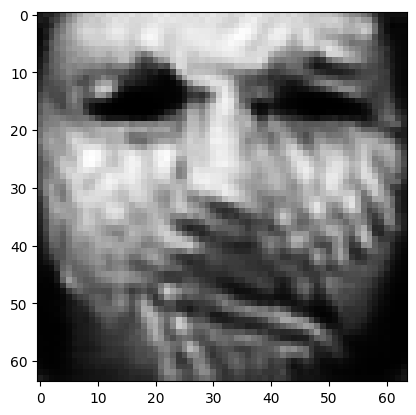

tensor([[7.2144e-04, 8.2948e-01, 6.2305e-04, 1.3509e-02, 1.0276e-03, 4.4398e-03,
         3.8383e-04, 2.6479e-03, 1.6012e-03, 2.0245e-03, 2.4374e-03, 1.1194e-02,
         6.7943e-03, 6.8631e-04, 1.7307e-03, 2.3818e-03, 1.5076e-03, 4.1153e-03,
         3.5778e-03, 2.0847e-03, 2.3485e-03, 8.3392e-05, 7.0339e-03, 6.0778e-04,
         1.2276e-03, 8.8996e-03, 1.8391e-03, 5.8830e-04, 3.9186e-03, 1.9598e-02,
         1.9998e-03, 7.0182e-03, 9.3038e-03, 3.0101e-04, 9.2690e-03, 2.5403e-02,
         1.3954e-03, 2.8000e-03, 1.1853e-03, 2.2100e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.18695415556430817
tensor([[7.2238e-04, 8.3163e-01, 6.2094e-04, 1.3329e-02, 1.0224e-03, 4.4701e-03,
         3.8227e-04, 2.6358e-03, 1.5615e-03, 2.0240e-03, 2.3857e-03, 1.1178e-02,
         6.7690e-03, 6.7480e-04, 1.7219e-03, 2.4035e-03, 1.5169e-03, 4.0428e-03,
         3.5654e-03, 2.0999e-03, 2.3198e-03, 8.3317e-05, 6.9141e-03, 6.1429e-04,
         1.2182e-03, 8.6433e-03, 1.8211e-0

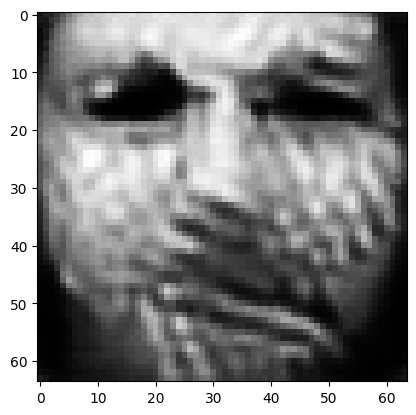

tensor([[7.2358e-04, 8.3864e-01, 5.9899e-04, 1.2892e-02, 9.9235e-04, 4.4344e-03,
         3.7412e-04, 2.5980e-03, 1.4372e-03, 1.9696e-03, 2.2387e-03, 1.0826e-02,
         6.5939e-03, 6.3755e-04, 1.7168e-03, 2.4052e-03, 1.5085e-03, 3.8727e-03,
         3.5182e-03, 2.0886e-03, 2.1996e-03, 8.0644e-05, 6.5545e-03, 6.1729e-04,
         1.1898e-03, 7.8535e-03, 1.7498e-03, 5.4096e-04, 3.7086e-03, 1.8340e-02,
         1.8289e-03, 6.8187e-03, 8.8249e-03, 2.8506e-04, 8.6258e-03, 2.3613e-02,
         1.2891e-03, 2.5719e-03, 1.1644e-03, 2.0798e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.17597585916519165
tensor([[7.2696e-04, 8.4021e-01, 5.9513e-04, 1.2740e-02, 9.8416e-04, 4.4406e-03,
         3.7319e-04, 2.5957e-03, 1.4079e-03, 1.9660e-03, 2.2110e-03, 1.0789e-02,
         6.5187e-03, 6.2707e-04, 1.7131e-03, 2.4245e-03, 1.5070e-03, 3.8239e-03,
         3.5239e-03, 2.0936e-03, 2.1789e-03, 8.0538e-05, 6.4139e-03, 6.1958e-04,
         1.1757e-03, 7.6751e-03, 1.7383e-0

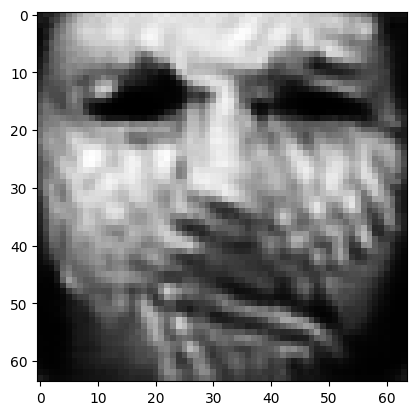

tensor([[7.1230e-04, 8.4627e-01, 5.6786e-04, 1.2384e-02, 9.5620e-04, 4.3291e-03,
         3.5812e-04, 2.5135e-03, 1.3185e-03, 1.8998e-03, 2.0762e-03, 1.0459e-02,
         6.3534e-03, 6.0042e-04, 1.6784e-03, 2.3866e-03, 1.4917e-03, 3.6577e-03,
         3.4073e-03, 2.0322e-03, 2.0554e-03, 7.7577e-05, 6.1986e-03, 6.1668e-04,
         1.1545e-03, 7.2628e-03, 1.6492e-03, 5.0496e-04, 3.5036e-03, 1.7459e-02,
         1.7081e-03, 6.6086e-03, 8.2876e-03, 2.7068e-04, 8.0708e-03, 2.2424e-02,
         1.2160e-03, 2.3902e-03, 1.1236e-03, 1.9606e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.16691160202026367
tensor([[6.9799e-04, 8.4768e-01, 5.5266e-04, 1.2277e-02, 9.3995e-04, 4.2054e-03,
         3.5106e-04, 2.4610e-03, 1.2999e-03, 1.8653e-03, 2.0408e-03, 1.0335e-02,
         6.2933e-03, 5.9499e-04, 1.6652e-03, 2.3272e-03, 1.4687e-03, 3.5972e-03,
         3.3415e-03, 1.9843e-03, 2.0069e-03, 7.6144e-05, 6.2091e-03, 6.0594e-04,
         1.1553e-03, 7.2765e-03, 1.6120e-0

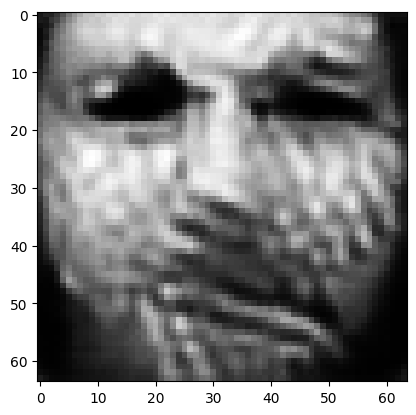

tensor([[6.7728e-04, 8.5286e-01, 5.2655e-04, 1.1905e-02, 9.0100e-04, 4.0499e-03,
         3.3478e-04, 2.3634e-03, 1.2259e-03, 1.8101e-03, 1.9310e-03, 1.0083e-02,
         6.1218e-03, 5.7116e-04, 1.6097e-03, 2.2706e-03, 1.4391e-03, 3.3878e-03,
         3.2280e-03, 1.9077e-03, 1.8901e-03, 7.3451e-05, 6.0290e-03, 5.9258e-04,
         1.1292e-03, 7.0589e-03, 1.5308e-03, 4.7487e-04, 3.2809e-03, 1.6801e-02,
         1.6405e-03, 6.3930e-03, 7.7587e-03, 2.5957e-04, 7.5375e-03, 2.2049e-02,
         1.1575e-03, 2.2416e-03, 1.0714e-03, 1.8293e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.15916253626346588
tensor([[6.7572e-04, 8.5411e-01, 5.2341e-04, 1.1795e-02, 8.9016e-04, 4.0328e-03,
         3.3137e-04, 2.3467e-03, 1.2101e-03, 1.8068e-03, 1.9094e-03, 1.0060e-02,
         6.0761e-03, 5.6517e-04, 1.5935e-03, 2.2744e-03, 1.4345e-03, 3.3329e-03,
         3.2158e-03, 1.8994e-03, 1.8721e-03, 7.3161e-05, 5.9518e-03, 5.8965e-04,
         1.1158e-03, 6.9886e-03, 1.5198e-0

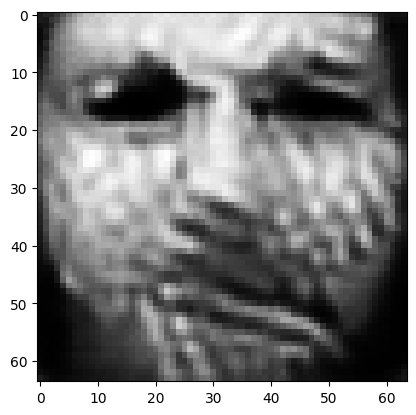

tensor([[6.5922e-04, 8.5873e-01, 5.0136e-04, 1.1442e-02, 8.5087e-04, 3.8765e-03,
         3.1619e-04, 2.2680e-03, 1.1463e-03, 1.7638e-03, 1.8271e-03, 9.8394e-03,
         5.8917e-03, 5.4484e-04, 1.5489e-03, 2.2279e-03, 1.4002e-03, 3.1573e-03,
         3.1345e-03, 1.8265e-03, 1.7712e-03, 7.0766e-05, 5.7444e-03, 5.7386e-04,
         1.0837e-03, 6.8003e-03, 1.4561e-03, 4.5068e-04, 3.1437e-03, 1.6317e-02,
         1.5795e-03, 6.1901e-03, 7.3199e-03, 2.4871e-04, 7.1036e-03, 2.1205e-02,
         1.0992e-03, 2.1322e-03, 1.0285e-03, 1.7343e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1523057371377945
tensor([[6.5270e-04, 8.5992e-01, 4.9412e-04, 1.1321e-02, 8.3934e-04, 3.8094e-03,
         3.1256e-04, 2.2446e-03, 1.1274e-03, 1.7493e-03, 1.8045e-03, 9.7689e-03,
         5.8397e-03, 5.3973e-04, 1.5360e-03, 2.2099e-03, 1.3913e-03, 3.1028e-03,
         3.1063e-03, 1.8037e-03, 1.7404e-03, 7.0182e-05, 5.7053e-03, 5.6995e-04,
         1.0779e-03, 6.7811e-03, 1.4330e-03

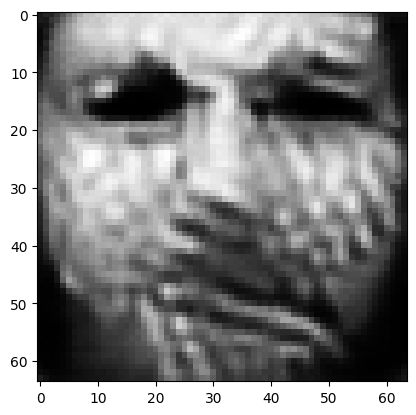

tensor([[6.3644e-04, 8.6398e-01, 4.7635e-04, 1.1005e-02, 8.0277e-04, 3.6676e-03,
         2.9991e-04, 2.1742e-03, 1.0748e-03, 1.7099e-03, 1.7304e-03, 9.5461e-03,
         5.6845e-03, 5.2317e-04, 1.4798e-03, 2.1672e-03, 1.3629e-03, 2.9352e-03,
         3.0289e-03, 1.7380e-03, 1.6520e-03, 6.8013e-05, 5.5415e-03, 5.5448e-04,
         1.0471e-03, 6.6535e-03, 1.3747e-03, 4.2979e-04, 3.0064e-03, 1.5866e-02,
         1.5320e-03, 5.9966e-03, 6.9407e-03, 2.4010e-04, 6.6975e-03, 2.0666e-02,
         1.0474e-03, 2.0332e-03, 9.9447e-04, 1.6370e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.14620867371559143
tensor([[6.3238e-04, 8.6490e-01, 4.7121e-04, 1.0917e-02, 7.9156e-04, 3.6199e-03,
         2.9667e-04, 2.1599e-03, 1.0643e-03, 1.6991e-03, 1.7154e-03, 9.4777e-03,
         5.6321e-03, 5.1889e-04, 1.4662e-03, 2.1501e-03, 1.3461e-03, 2.9005e-03,
         3.0186e-03, 1.7172e-03, 1.6328e-03, 6.7342e-05, 5.4993e-03, 5.4731e-04,
         1.0352e-03, 6.6394e-03, 1.3630e-0

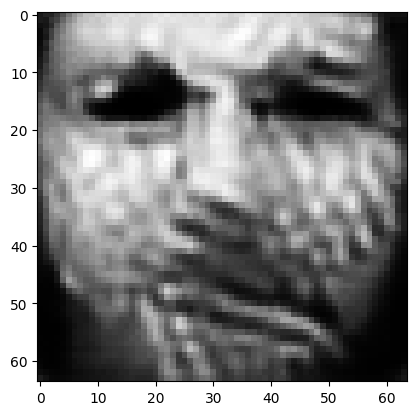

tensor([[6.2681e-04, 8.6834e-01, 4.6171e-04, 1.0632e-02, 7.6667e-04, 3.5659e-03,
         2.8828e-04, 2.1212e-03, 1.0201e-03, 1.6810e-03, 1.6620e-03, 9.3371e-03,
         5.5102e-03, 5.0470e-04, 1.4258e-03, 2.1505e-03, 1.3305e-03, 2.7826e-03,
         2.9857e-03, 1.6829e-03, 1.5760e-03, 6.6151e-05, 5.3089e-03, 5.3841e-04,
         9.9988e-04, 6.4280e-03, 1.3375e-03, 4.1364e-04, 2.9179e-03, 1.5536e-02,
         1.4802e-03, 5.8204e-03, 6.6528e-03, 2.3169e-04, 6.4323e-03, 1.9877e-02,
         1.0032e-03, 1.9623e-03, 9.6240e-04, 1.5774e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.14116863906383514
tensor([[6.2076e-04, 8.6921e-01, 4.5710e-04, 1.0602e-02, 7.5700e-04, 3.5346e-03,
         2.8424e-04, 2.0945e-03, 1.0130e-03, 1.6691e-03, 1.6446e-03, 9.2771e-03,
         5.4938e-03, 5.0214e-04, 1.4067e-03, 2.1280e-03, 1.3199e-03, 2.7437e-03,
         2.9540e-03, 1.6611e-03, 1.5554e-03, 6.5381e-05, 5.2969e-03, 5.3143e-04,
         9.9361e-04, 6.4180e-03, 1.3258e-0

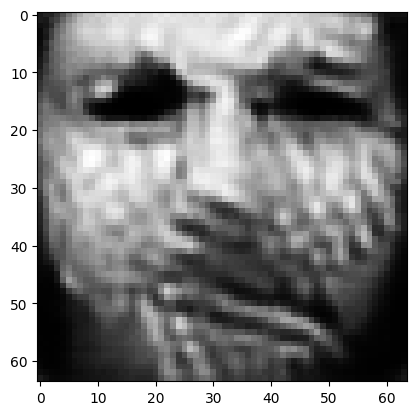

tensor([[6.1775e-04, 8.7241e-01, 4.4966e-04, 1.0349e-02, 7.3132e-04, 3.4907e-03,
         2.7577e-04, 2.0617e-03, 9.7348e-04, 1.6662e-03, 1.5952e-03, 9.1657e-03,
         5.3649e-03, 4.8655e-04, 1.3591e-03, 2.1293e-03, 1.2944e-03, 2.6143e-03,
         2.9332e-03, 1.6379e-03, 1.5019e-03, 6.4611e-05, 5.0742e-03, 5.2352e-04,
         9.5408e-04, 6.2416e-03, 1.2968e-03, 3.9721e-04, 2.8449e-03, 1.5301e-02,
         1.4307e-03, 5.6221e-03, 6.3734e-03, 2.2562e-04, 6.1758e-03, 1.9050e-02,
         9.6060e-04, 1.8886e-03, 9.3971e-04, 1.5314e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.13649959862232208
tensor([[6.1907e-04, 8.7314e-01, 4.4900e-04, 1.0283e-02, 7.2743e-04, 3.4914e-03,
         2.7452e-04, 2.0622e-03, 9.6284e-04, 1.6686e-03, 1.5841e-03, 9.1365e-03,
         5.3366e-03, 4.8255e-04, 1.3504e-03, 2.1381e-03, 1.2922e-03, 2.5882e-03,
         2.9398e-03, 1.6370e-03, 1.4919e-03, 6.4551e-05, 5.0181e-03, 5.2379e-04,
         9.4500e-04, 6.1842e-03, 1.2921e-0

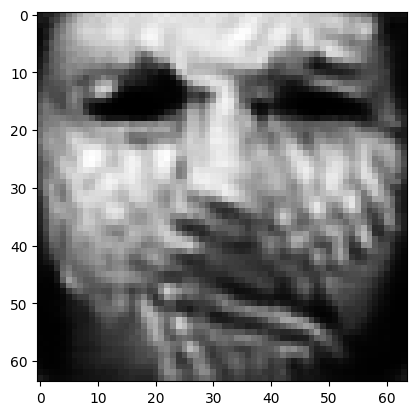

tensor([[6.1852e-04, 8.7592e-01, 4.4393e-04, 1.0127e-02, 7.0925e-04, 3.4691e-03,
         2.6741e-04, 2.0454e-03, 9.2900e-04, 1.6576e-03, 1.5414e-03, 8.9893e-03,
         5.2484e-03, 4.7085e-04, 1.3129e-03, 2.1422e-03, 1.2770e-03, 2.4989e-03,
         2.9321e-03, 1.6157e-03, 1.4494e-03, 6.3544e-05, 4.8489e-03, 5.1899e-04,
         9.1469e-04, 5.9988e-03, 1.2711e-03, 3.8615e-04, 2.7921e-03, 1.4988e-02,
         1.3823e-03, 5.4563e-03, 6.1308e-03, 2.1904e-04, 5.9816e-03, 1.8211e-02,
         9.2609e-04, 1.8279e-03, 9.2052e-04, 1.4926e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1324748694896698
tensor([[6.1280e-04, 8.7656e-01, 4.3953e-04, 1.0087e-02, 7.0271e-04, 3.4358e-03,
         2.6439e-04, 2.0241e-03, 9.2311e-04, 1.6475e-03, 1.5291e-03, 8.9537e-03,
         5.2307e-03, 4.6866e-04, 1.3011e-03, 2.1224e-03, 1.2670e-03, 2.4729e-03,
         2.9059e-03, 1.6012e-03, 1.4327e-03, 6.3029e-05, 4.8337e-03, 5.1451e-04,
         9.1044e-04, 5.9953e-03, 1.2601e-03

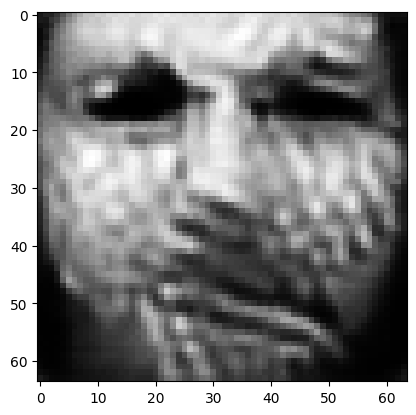

tensor([[6.0669e-04, 8.7908e-01, 4.3448e-04, 1.0010e-02, 6.8193e-04, 3.3772e-03,
         2.5537e-04, 1.9981e-03, 8.9714e-04, 1.6293e-03, 1.4896e-03, 8.7947e-03,
         5.1611e-03, 4.6057e-04, 1.2611e-03, 2.0982e-03, 1.2517e-03, 2.3716e-03,
         2.8852e-03, 1.5627e-03, 1.3837e-03, 6.1751e-05, 4.7280e-03, 5.0480e-04,
         8.8909e-04, 5.8898e-03, 1.2343e-03, 3.7452e-04, 2.7147e-03, 1.4718e-02,
         1.3592e-03, 5.2804e-03, 5.8720e-03, 2.1437e-04, 5.7822e-03, 1.7669e-02,
         8.9625e-04, 1.7849e-03, 8.9937e-04, 1.4422e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.12888500094413757
tensor([[6.0579e-04, 8.7967e-01, 4.3355e-04, 9.9881e-03, 6.7750e-04, 3.3671e-03,
         2.5339e-04, 1.9933e-03, 8.9175e-04, 1.6264e-03, 1.4802e-03, 8.7610e-03,
         5.1460e-03, 4.5854e-04, 1.2517e-03, 2.0933e-03, 1.2472e-03, 2.3497e-03,
         2.8810e-03, 1.5558e-03, 1.3734e-03, 6.1470e-05, 4.6979e-03, 5.0241e-04,
         8.8298e-04, 5.8569e-03, 1.2294e-0

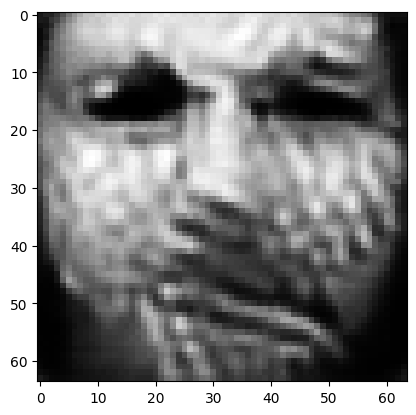

tensor([[5.9562e-04, 8.8194e-01, 4.2438e-04, 9.8970e-03, 6.6096e-04, 3.2950e-03,
         2.4450e-04, 1.9568e-03, 8.6697e-04, 1.5998e-03, 1.4410e-03, 8.5983e-03,
         5.0762e-03, 4.5071e-04, 1.2197e-03, 2.0545e-03, 1.2275e-03, 2.2734e-03,
         2.8446e-03, 1.5107e-03, 1.3222e-03, 5.9885e-05, 4.6187e-03, 4.9177e-04,
         8.6478e-04, 5.7942e-03, 1.2021e-03, 3.6589e-04, 2.6373e-03, 1.4423e-02,
         1.3357e-03, 5.1202e-03, 5.6182e-03, 2.0893e-04, 5.6096e-03, 1.7269e-02,
         8.7175e-04, 1.7451e-03, 8.7395e-04, 1.3938e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1256350874900818
tensor([[5.9524e-04, 8.8248e-01, 4.2281e-04, 9.8737e-03, 6.5742e-04, 3.2845e-03,
         2.4285e-04, 1.9549e-03, 8.6067e-04, 1.5953e-03, 1.4326e-03, 8.5594e-03,
         5.0540e-03, 4.4826e-04, 1.2138e-03, 2.0528e-03, 1.2224e-03, 2.2576e-03,
         2.8471e-03, 1.5036e-03, 1.3132e-03, 5.9595e-05, 4.5869e-03, 4.8997e-04,
         8.5797e-04, 5.7636e-03, 1.1982e-03

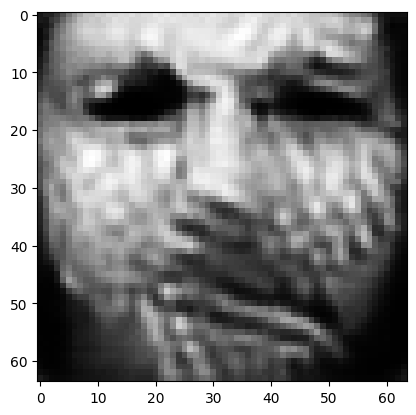

tensor([[5.8016e-04, 8.8460e-01, 4.1038e-04, 9.7104e-03, 6.3765e-04, 3.1853e-03,
         2.3414e-04, 1.8966e-03, 8.3841e-04, 1.5690e-03, 1.3929e-03, 8.4324e-03,
         4.9814e-03, 4.3959e-04, 1.1780e-03, 2.0007e-03, 1.1940e-03, 2.1751e-03,
         2.7944e-03, 1.4567e-03, 1.2643e-03, 5.8053e-05, 4.5204e-03, 4.7511e-04,
         8.3621e-04, 5.7387e-03, 1.1708e-03, 3.5711e-04, 2.5562e-03, 1.4231e-02,
         1.3122e-03, 4.9788e-03, 5.4030e-03, 2.0366e-04, 5.4321e-03, 1.7005e-02,
         8.4863e-04, 1.7012e-03, 8.4607e-04, 1.3501e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.12261589616537094
tensor([[5.7780e-04, 8.8510e-01, 4.0787e-04, 9.6705e-03, 6.3384e-04, 3.1665e-03,
         2.3240e-04, 1.8866e-03, 8.3204e-04, 1.5639e-03, 1.3838e-03, 8.4037e-03,
         4.9602e-03, 4.3727e-04, 1.1711e-03, 1.9923e-03, 1.1885e-03, 2.1572e-03,
         2.7875e-03, 1.4471e-03, 1.2536e-03, 5.7772e-05, 4.4985e-03, 4.7259e-04,
         8.3084e-04, 5.7236e-03, 1.1652e-0

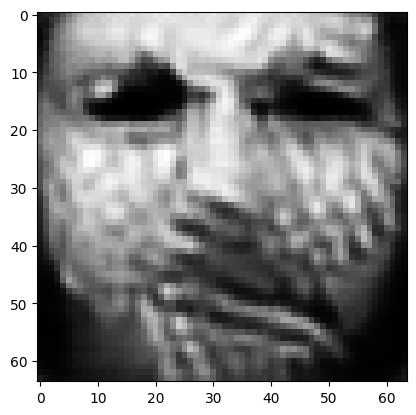

tensor([[5.6347e-04, 8.8699e-01, 3.9577e-04, 9.5229e-03, 6.1559e-04, 3.0668e-03,
         2.2443e-04, 1.8314e-03, 8.1066e-04, 1.5361e-03, 1.3486e-03, 8.2916e-03,
         4.8802e-03, 4.2937e-04, 1.1388e-03, 1.9390e-03, 1.1623e-03, 2.0775e-03,
         2.7405e-03, 1.4008e-03, 1.2079e-03, 5.6476e-05, 4.4496e-03, 4.5904e-04,
         8.1284e-04, 5.7181e-03, 1.1393e-03, 3.4893e-04, 2.4735e-03, 1.4059e-02,
         1.2955e-03, 4.8616e-03, 5.2208e-03, 1.9912e-04, 5.2510e-03, 1.6858e-02,
         8.3072e-04, 1.6623e-03, 8.1904e-04, 1.3087e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.11991921067237854
tensor([[5.6265e-04, 8.8745e-01, 3.9469e-04, 9.4826e-03, 6.1269e-04, 3.0590e-03,
         2.2324e-04, 1.8250e-03, 8.0594e-04, 1.5350e-03, 1.3420e-03, 8.2837e-03,
         4.8658e-03, 4.2714e-04, 1.1338e-03, 1.9381e-03, 1.1600e-03, 2.0603e-03,
         2.7371e-03, 1.4005e-03, 1.2017e-03, 5.6497e-05, 4.4214e-03, 4.5816e-04,
         8.0679e-04, 5.6843e-03, 1.1361e-0

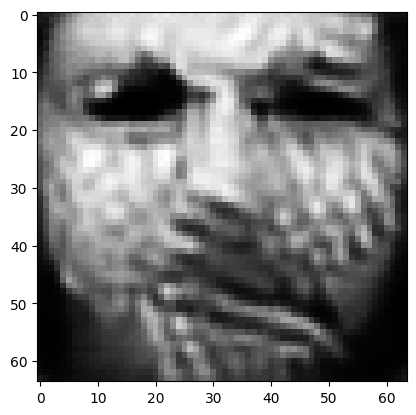

tensor([[5.5609e-04, 8.8936e-01, 3.8813e-04, 9.3223e-03, 5.9945e-04, 3.0114e-03,
         2.1761e-04, 1.7917e-03, 7.8280e-04, 1.5214e-03, 1.3107e-03, 8.2100e-03,
         4.7952e-03, 4.1846e-04, 1.1050e-03, 1.9194e-03, 1.1459e-03, 1.9899e-03,
         2.7171e-03, 1.3796e-03, 1.1683e-03, 5.5870e-05, 4.3362e-03, 4.5077e-04,
         7.8301e-04, 5.5918e-03, 1.1219e-03, 3.4175e-04, 2.4065e-03, 1.3927e-02,
         1.2767e-03, 4.7274e-03, 5.0727e-03, 1.9602e-04, 5.0729e-03, 1.6408e-02,
         8.1297e-04, 1.6187e-03, 8.0147e-04, 1.2884e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.11725371330976486
tensor([[5.5567e-04, 8.8981e-01, 3.8706e-04, 9.2785e-03, 5.9709e-04, 3.0045e-03,
         2.1665e-04, 1.7884e-03, 7.7647e-04, 1.5201e-03, 1.3038e-03, 8.1934e-03,
         4.7743e-03, 4.1605e-04, 1.0989e-03, 1.9199e-03, 1.1437e-03, 1.9735e-03,
         2.7188e-03, 1.3772e-03, 1.1610e-03, 5.5812e-05, 4.3074e-03, 4.5001e-04,
         7.7667e-04, 5.5638e-03, 1.1190e-0

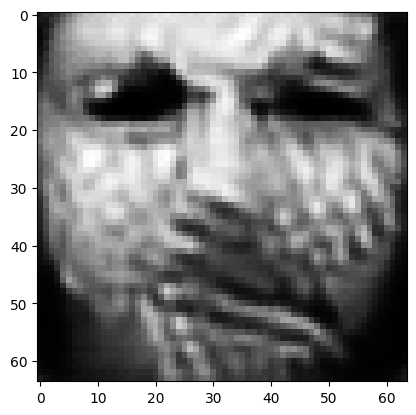

tensor([[5.4742e-04, 8.9157e-01, 3.8045e-04, 9.1416e-03, 5.8610e-04, 2.9485e-03,
         2.1123e-04, 1.7557e-03, 7.5687e-04, 1.4983e-03, 1.2738e-03, 8.1007e-03,
         4.7120e-03, 4.0937e-04, 1.0721e-03, 1.8904e-03, 1.1321e-03, 1.9110e-03,
         2.6904e-03, 1.3500e-03, 1.1267e-03, 5.4969e-05, 4.2516e-03, 4.4203e-04,
         7.5812e-04, 5.5041e-03, 1.1029e-03, 3.3682e-04, 2.3354e-03, 1.3763e-02,
         1.2629e-03, 4.5983e-03, 4.9268e-03, 1.9304e-04, 4.9125e-03, 1.6062e-02,
         8.0040e-04, 1.5793e-03, 7.8144e-04, 1.2669e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.11476732045412064
tensor([[5.4569e-04, 8.9200e-01, 3.7915e-04, 9.1077e-03, 5.8324e-04, 2.9341e-03,
         2.1000e-04, 1.7488e-03, 7.5258e-04, 1.4922e-03, 1.2673e-03, 8.0768e-03,
         4.6974e-03, 4.0796e-04, 1.0661e-03, 1.8836e-03, 1.1293e-03, 1.8965e-03,
         2.6849e-03, 1.3438e-03, 1.1187e-03, 5.4755e-05, 4.2379e-03, 4.3990e-04,
         7.5332e-04, 5.4892e-03, 1.0997e-0

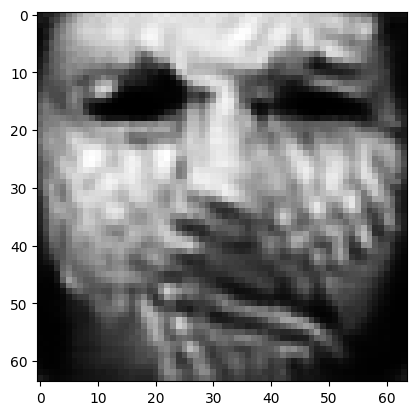

tensor([[5.3982e-04, 8.9376e-01, 3.7455e-04, 8.9666e-03, 5.7284e-04, 2.8816e-03,
         2.0535e-04, 1.7255e-03, 7.3317e-04, 1.4722e-03, 1.2401e-03, 7.9889e-03,
         4.6387e-03, 4.0190e-04, 1.0444e-03, 1.8622e-03, 1.1209e-03, 1.8377e-03,
         2.6710e-03, 1.3206e-03, 1.0879e-03, 5.4046e-05, 4.1763e-03, 4.3298e-04,
         7.3411e-04, 5.4119e-03, 1.0882e-03, 3.3330e-04, 2.2657e-03, 1.3590e-02,
         1.2558e-03, 4.4616e-03, 4.7903e-03, 1.9044e-04, 4.7557e-03, 1.5674e-02,
         7.8861e-04, 1.5403e-03, 7.6165e-04, 1.2456e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1123134046792984
tensor([[5.3788e-04, 8.9421e-01, 3.7291e-04, 8.9295e-03, 5.7025e-04, 2.8631e-03,
         2.0416e-04, 1.7190e-03, 7.2807e-04, 1.4648e-03, 1.2331e-03, 7.9598e-03,
         4.6229e-03, 4.0050e-04, 1.0401e-03, 1.8548e-03, 1.1186e-03, 1.8249e-03,
         2.6668e-03, 1.3133e-03, 1.0799e-03, 5.3830e-05, 4.1668e-03, 4.3115e-04,
         7.2999e-04, 5.3947e-03, 1.0849e-03

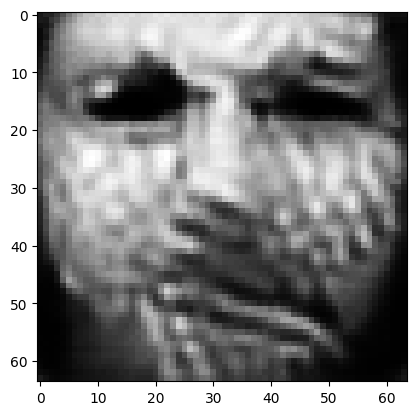

tensor([[5.2902e-04, 8.9588e-01, 3.6589e-04, 8.7958e-03, 5.6013e-04, 2.7967e-03,
         1.9929e-04, 1.6875e-03, 7.1001e-04, 1.4378e-03, 1.2048e-03, 7.8560e-03,
         4.5692e-03, 3.9483e-04, 1.0190e-03, 1.8211e-03, 1.1075e-03, 1.7732e-03,
         2.6412e-03, 1.2850e-03, 1.0491e-03, 5.2940e-05, 4.1332e-03, 4.2337e-04,
         7.1514e-04, 5.3404e-03, 1.0706e-03, 3.2916e-04, 2.1883e-03, 1.3386e-02,
         1.2470e-03, 4.3434e-03, 4.6558e-03, 1.8747e-04, 4.6024e-03, 1.5403e-02,
         7.7867e-04, 1.5023e-03, 7.4007e-04, 1.2196e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10995053499937057
tensor([[5.2560e-04, 8.9625e-01, 3.6356e-04, 8.7755e-03, 5.5688e-04, 2.7763e-03,
         1.9783e-04, 1.6751e-03, 7.0628e-04, 1.4302e-03, 1.1969e-03, 7.8307e-03,
         4.5614e-03, 3.9357e-04, 1.0121e-03, 1.8080e-03, 1.1041e-03, 1.7583e-03,
         2.6285e-03, 1.2763e-03, 1.0410e-03, 5.2651e-05, 4.1337e-03, 4.2067e-04,
         7.1278e-04, 5.3357e-03, 1.0653e-0

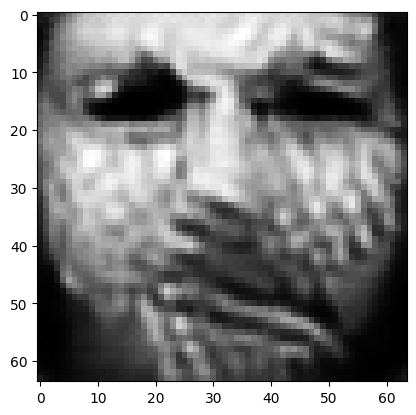

tensor([[5.1951e-04, 8.9763e-01, 3.5884e-04, 8.6769e-03, 5.4842e-04, 2.7269e-03,
         1.9400e-04, 1.6556e-03, 6.9103e-04, 1.4092e-03, 1.1749e-03, 7.7417e-03,
         4.5118e-03, 3.8889e-04, 9.9212e-04, 1.7858e-03, 1.0956e-03, 1.7125e-03,
         2.6154e-03, 1.2530e-03, 1.0162e-03, 5.1933e-05, 4.0951e-03, 4.1444e-04,
         6.9936e-04, 5.2900e-03, 1.0531e-03, 3.2505e-04, 2.1285e-03, 1.3232e-02,
         1.2397e-03, 4.2393e-03, 4.5439e-03, 1.8505e-04, 4.4796e-03, 1.5158e-02,
         7.6884e-04, 1.4731e-03, 7.2401e-04, 1.1984e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10799456387758255
tensor([[5.1525e-04, 8.9795e-01, 3.5617e-04, 8.6586e-03, 5.4514e-04, 2.7042e-03,
         1.9249e-04, 1.6423e-03, 6.8844e-04, 1.4005e-03, 1.1678e-03, 7.7144e-03,
         4.5046e-03, 3.8818e-04, 9.8464e-04, 1.7696e-03, 1.0911e-03, 1.6994e-03,
         2.5983e-03, 1.2426e-03, 1.0075e-03, 5.1566e-05, 4.1027e-03, 4.1125e-04,
         6.9797e-04, 5.3017e-03, 1.0470e-0

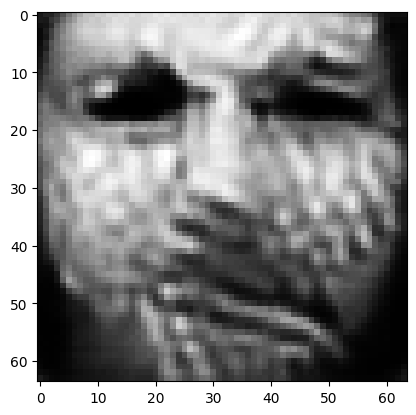

tensor([[5.0985e-04, 8.9921e-01, 3.5197e-04, 8.5715e-03, 5.3769e-04, 2.6614e-03,
         1.8900e-04, 1.6271e-03, 6.7385e-04, 1.3815e-03, 1.1474e-03, 7.6340e-03,
         4.4565e-03, 3.8344e-04, 9.6811e-04, 1.7497e-03, 1.0835e-03, 1.6591e-03,
         2.5856e-03, 1.2225e-03, 9.8426e-04, 5.0928e-05, 4.0670e-03, 4.0644e-04,
         6.8655e-04, 5.2598e-03, 1.0330e-03, 3.2186e-04, 2.0715e-03, 1.3063e-02,
         1.2359e-03, 4.1465e-03, 4.4359e-03, 1.8271e-04, 4.3693e-03, 1.4991e-02,
         7.6047e-04, 1.4465e-03, 7.0880e-04, 1.1763e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10624047368764877
tensor([[5.0744e-04, 8.9951e-01, 3.5020e-04, 8.5374e-03, 5.3490e-04, 2.6441e-03,
         1.8799e-04, 1.6190e-03, 6.7054e-04, 1.3768e-03, 1.1416e-03, 7.6184e-03,
         4.4434e-03, 3.8201e-04, 9.6355e-04, 1.7406e-03, 1.0793e-03, 1.6474e-03,
         2.5778e-03, 1.2166e-03, 9.7824e-04, 5.0760e-05, 4.0595e-03, 4.0438e-04,
         6.8385e-04, 5.2572e-03, 1.0286e-0

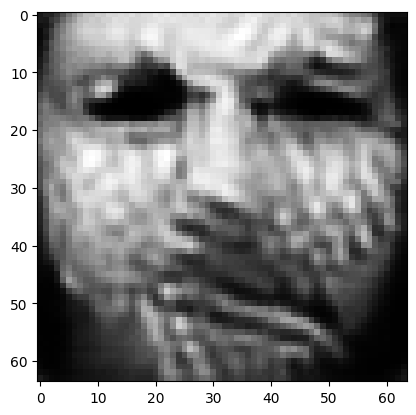

tensor([[5.0187e-04, 9.0066e-01, 3.4669e-04, 8.4575e-03, 5.2680e-04, 2.5998e-03,
         1.8449e-04, 1.6025e-03, 6.5724e-04, 1.3589e-03, 1.1220e-03, 7.5485e-03,
         4.4052e-03, 3.7790e-04, 9.4760e-04, 1.7188e-03, 1.0728e-03, 1.6085e-03,
         2.5634e-03, 1.1966e-03, 9.5658e-04, 5.0133e-05, 4.0314e-03, 3.9914e-04,
         6.7394e-04, 5.2261e-03, 1.0152e-03, 3.1903e-04, 2.0241e-03, 1.2919e-02,
         1.2354e-03, 4.0652e-03, 4.3466e-03, 1.8080e-04, 4.2646e-03, 1.4807e-02,
         7.5161e-04, 1.4220e-03, 6.9644e-04, 1.1546e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10462278872728348
tensor([[4.9817e-04, 9.0095e-01, 3.4439e-04, 8.4386e-03, 5.2363e-04, 2.5777e-03,
         1.8311e-04, 1.5917e-03, 6.5472e-04, 1.3500e-03, 1.1160e-03, 7.5199e-03,
         4.3959e-03, 3.7728e-04, 9.4221e-04, 1.7038e-03, 1.0684e-03, 1.5983e-03,
         2.5505e-03, 1.1869e-03, 9.4876e-04, 4.9778e-05, 4.0380e-03, 3.9617e-04,
         6.7285e-04, 5.2382e-03, 1.0097e-0

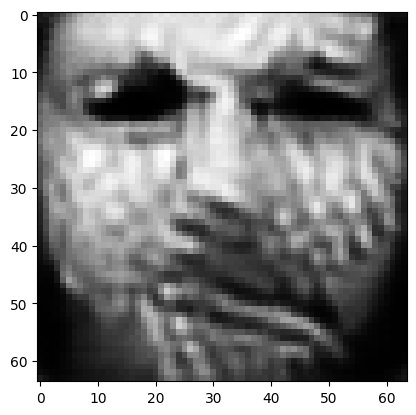

tensor([[4.9116e-04, 9.0204e-01, 3.4017e-04, 8.3553e-03, 5.1516e-04, 2.5282e-03,
         1.7956e-04, 1.5701e-03, 6.4304e-04, 1.3308e-03, 1.0964e-03, 7.4502e-03,
         4.3616e-03, 3.7365e-04, 9.2551e-04, 1.6762e-03, 1.0598e-03, 1.5609e-03,
         2.5289e-03, 1.1656e-03, 9.2717e-04, 4.9091e-05, 4.0203e-03, 3.8987e-04,
         6.6430e-04, 5.2213e-03, 9.9581e-04, 3.1575e-04, 1.9721e-03, 1.2770e-02,
         1.2366e-03, 3.9876e-03, 4.2572e-03, 1.7907e-04, 4.1663e-03, 1.4695e-02,
         7.4440e-04, 1.3991e-03, 6.8313e-04, 1.1311e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10309334844350815
tensor([[4.8871e-04, 9.0231e-01, 3.3860e-04, 8.3367e-03, 5.1292e-04, 2.5125e-03,
         1.7856e-04, 1.5638e-03, 6.4000e-04, 1.3242e-03, 1.0911e-03, 7.4264e-03,
         4.3521e-03, 3.7287e-04, 9.2104e-04, 1.6665e-03, 1.0568e-03, 1.5520e-03,
         2.5218e-03, 1.1585e-03, 9.2054e-04, 4.8835e-05, 4.0208e-03, 3.8798e-04,
         6.6273e-04, 5.2242e-03, 9.9124e-0

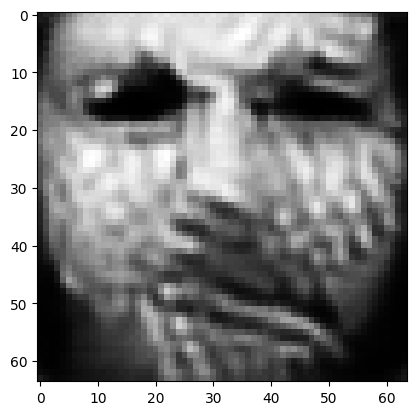

tensor([[4.8330e-04, 9.0335e-01, 3.3522e-04, 8.2579e-03, 5.0602e-04, 2.4729e-03,
         1.7571e-04, 1.5482e-03, 6.2842e-04, 1.3080e-03, 1.0729e-03, 7.3624e-03,
         4.3220e-03, 3.6926e-04, 9.0655e-04, 1.6450e-03, 1.0500e-03, 1.5194e-03,
         2.5059e-03, 1.1421e-03, 9.0120e-04, 4.8251e-05, 3.9983e-03, 3.8325e-04,
         6.5448e-04, 5.1898e-03, 9.7871e-04, 3.1315e-04, 1.9270e-03, 1.2608e-02,
         1.2349e-03, 3.9188e-03, 4.1779e-03, 1.7714e-04, 4.0760e-03, 1.4556e-02,
         7.3731e-04, 1.3766e-03, 6.7191e-04, 1.1107e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.10164611041545868
tensor([[4.8173e-04, 9.0360e-01, 3.3429e-04, 8.2417e-03, 5.0408e-04, 2.4630e-03,
         1.7492e-04, 1.5428e-03, 6.2628e-04, 1.3035e-03, 1.0685e-03, 7.3467e-03,
         4.3168e-03, 3.6855e-04, 9.0296e-04, 1.6382e-03, 1.0477e-03, 1.5120e-03,
         2.5002e-03, 1.1375e-03, 8.9669e-04, 4.8073e-05, 3.9951e-03, 3.8153e-04,
         6.5238e-04, 5.1817e-03, 9.7640e-0

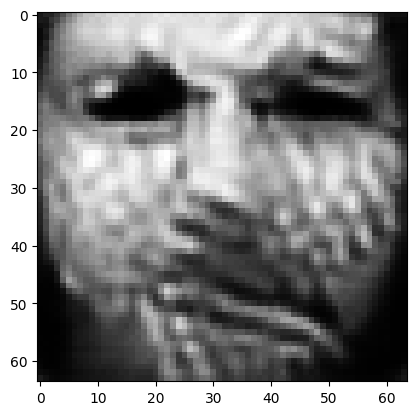

tensor([[4.7613e-04, 9.0453e-01, 3.3092e-04, 8.1965e-03, 4.9768e-04, 2.4278e-03,
         1.7207e-04, 1.5263e-03, 6.1673e-04, 1.2864e-03, 1.0513e-03, 7.2816e-03,
         4.2961e-03, 3.6562e-04, 8.8983e-04, 1.6160e-03, 1.0418e-03, 1.4835e-03,
         2.4825e-03, 1.1209e-03, 8.7911e-04, 4.7458e-05, 3.9848e-03, 3.7684e-04,
         6.4560e-04, 5.1509e-03, 9.6540e-04, 3.1041e-04, 1.8848e-03, 1.2468e-02,
         1.2324e-03, 3.8473e-03, 4.1003e-03, 1.7539e-04, 3.9998e-03, 1.4401e-02,
         7.3058e-04, 1.3563e-03, 6.6165e-04, 1.0943e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1003418117761612
tensor([[4.7488e-04, 9.0476e-01, 3.3018e-04, 8.1884e-03, 4.9623e-04, 2.4203e-03,
         1.7141e-04, 1.5228e-03, 6.1441e-04, 1.2820e-03, 1.0471e-03, 7.2640e-03,
         4.2914e-03, 3.6501e-04, 8.8682e-04, 1.6107e-03, 1.0405e-03, 1.4773e-03,
         2.4786e-03, 1.1166e-03, 8.7482e-04, 4.7297e-05, 3.9828e-03, 3.7568e-04,
         6.4398e-04, 5.1417e-03, 9.6314e-04

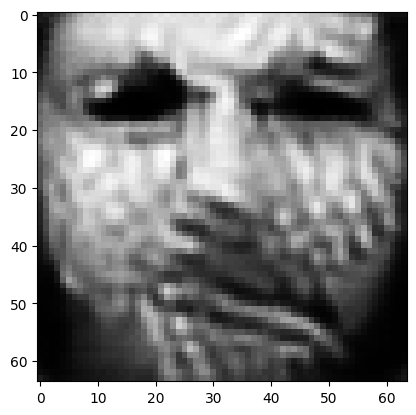

tensor([[4.6981e-04, 9.0568e-01, 3.2724e-04, 8.1309e-03, 4.8997e-04, 2.3885e-03,
         1.6883e-04, 1.5073e-03, 6.0485e-04, 1.2667e-03, 1.0308e-03, 7.2070e-03,
         4.2666e-03, 3.6203e-04, 8.7390e-04, 1.5912e-03, 1.0343e-03, 1.4496e-03,
         2.4627e-03, 1.1009e-03, 8.5785e-04, 4.6764e-05, 3.9663e-03, 3.7085e-04,
         6.3594e-04, 5.1085e-03, 9.5354e-04, 3.0823e-04, 1.8446e-03, 1.2321e-02,
         1.2300e-03, 3.7787e-03, 4.0289e-03, 1.7343e-04, 3.9275e-03, 1.4240e-02,
         7.2439e-04, 1.3371e-03, 6.5112e-04, 1.0797e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09906581789255142
tensor([[4.6799e-04, 9.0590e-01, 3.2612e-04, 8.1154e-03, 4.8815e-04, 2.3773e-03,
         1.6811e-04, 1.5022e-03, 6.0252e-04, 1.2619e-03, 1.0268e-03, 7.1890e-03,
         4.2587e-03, 3.6135e-04, 8.7054e-04, 1.5843e-03, 1.0320e-03, 1.4426e-03,
         2.4569e-03, 1.0958e-03, 8.5312e-04, 4.6591e-05, 3.9652e-03, 3.6938e-04,
         6.3455e-04, 5.1085e-03, 9.5008e-0

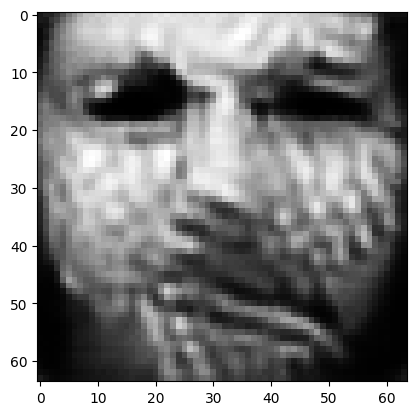

tensor([[4.6764e-04, 9.0668e-01, 3.2556e-04, 8.0863e-03, 4.8496e-04, 2.3689e-03,
         1.6676e-04, 1.5013e-03, 5.9444e-04, 1.2539e-03, 1.0147e-03, 7.1426e-03,
         4.2453e-03, 3.5835e-04, 8.6404e-04, 1.5807e-03, 1.0302e-03, 1.4261e-03,
         2.4570e-03, 1.0911e-03, 8.4345e-04, 4.6309e-05, 3.9303e-03, 3.6789e-04,
         6.2713e-04, 5.0336e-03, 9.4613e-04, 3.0616e-04, 1.8172e-03, 1.2186e-02,
         1.2232e-03, 3.7255e-03, 3.9723e-03, 1.7154e-04, 3.8745e-03, 1.4036e-02,
         7.1673e-04, 1.3216e-03, 6.4438e-04, 1.0677e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09796352684497833
tensor([[4.6704e-04, 9.0688e-01, 3.2507e-04, 8.0807e-03, 4.8393e-04, 2.3648e-03,
         1.6629e-04, 1.4996e-03, 5.9245e-04, 1.2510e-03, 1.0114e-03, 7.1272e-03,
         4.2416e-03, 3.5766e-04, 8.6217e-04, 1.5776e-03, 1.0291e-03, 1.4220e-03,
         2.4547e-03, 1.0887e-03, 8.4038e-04, 4.6181e-05, 3.9244e-03, 3.6718e-04,
         6.2568e-04, 5.0185e-03, 9.4457e-0

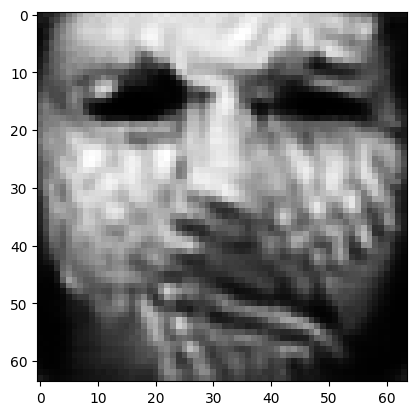

tensor([[4.6487e-04, 9.0764e-01, 3.2337e-04, 8.0573e-03, 4.8013e-04, 2.3502e-03,
         1.6452e-04, 1.4936e-03, 5.8492e-04, 1.2412e-03, 9.9822e-04, 7.0726e-03,
         4.2290e-03, 3.5490e-04, 8.5446e-04, 1.5669e-03, 1.0258e-03, 1.4052e-03,
         2.4468e-03, 1.0800e-03, 8.2898e-04, 4.5741e-05, 3.9008e-03, 3.6466e-04,
         6.1982e-04, 4.9618e-03, 9.3847e-04, 3.0369e-04, 1.7899e-03, 1.2045e-02,
         1.2151e-03, 3.6742e-03, 3.9091e-03, 1.6961e-04, 3.8288e-03, 1.3862e-02,
         7.0888e-04, 1.3067e-03, 6.3739e-04, 1.0545e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09690730273723602
tensor([[4.6407e-04, 9.0782e-01, 3.2280e-04, 8.0497e-03, 4.7901e-04, 2.3449e-03,
         1.6401e-04, 1.4911e-03, 5.8316e-04, 1.2384e-03, 9.9504e-04, 7.0601e-03,
         4.2251e-03, 3.5427e-04, 8.5258e-04, 1.5634e-03, 1.0247e-03, 1.4009e-03,
         2.4434e-03, 1.0776e-03, 8.2611e-04, 4.5635e-05, 3.8958e-03, 3.6391e-04,
         6.1844e-04, 4.9514e-03, 9.3658e-0

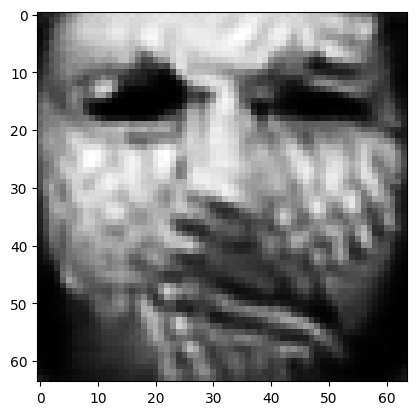

tensor([[4.6080e-04, 9.0853e-01, 3.2050e-04, 8.0165e-03, 4.7451e-04, 2.3231e-03,
         1.6209e-04, 1.4820e-03, 5.7610e-04, 1.2270e-03, 9.8267e-04, 7.0033e-03,
         4.2079e-03, 3.5185e-04, 8.4456e-04, 1.5485e-03, 1.0195e-03, 1.3834e-03,
         2.4325e-03, 1.0661e-03, 8.1381e-04, 4.5131e-05, 3.8785e-03, 3.6030e-04,
         6.1312e-04, 4.9179e-03, 9.2950e-04, 3.0140e-04, 1.7624e-03, 1.1925e-02,
         1.2098e-03, 3.6280e-03, 3.8500e-03, 1.6783e-04, 3.7816e-03, 1.3739e-02,
         7.0213e-04, 1.2936e-03, 6.2981e-04, 1.0404e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09592892229557037
tensor([[4.5868e-04, 9.0870e-01, 3.1926e-04, 8.0014e-03, 4.7268e-04, 2.3108e-03,
         1.6134e-04, 1.4757e-03, 5.7456e-04, 1.2217e-03, 9.7905e-04, 6.9851e-03,
         4.2018e-03, 3.5149e-04, 8.4196e-04, 1.5393e-03, 1.0167e-03, 1.3784e-03,
         2.4243e-03, 1.0603e-03, 8.0958e-04, 4.4917e-05, 3.8819e-03, 3.5839e-04,
         6.1232e-04, 4.9249e-03, 9.2646e-0

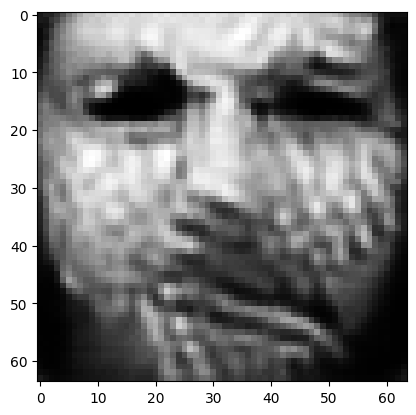

tensor([[4.5544e-04, 9.0935e-01, 3.1718e-04, 7.9702e-03, 4.6801e-04, 2.2872e-03,
         1.5954e-04, 1.4665e-03, 5.6821e-04, 1.2107e-03, 9.6737e-04, 6.9301e-03,
         4.1884e-03, 3.4938e-04, 8.3427e-04, 1.5234e-03, 1.0119e-03, 1.3606e-03,
         2.4132e-03, 1.0491e-03, 7.9804e-04, 4.4446e-05, 3.8692e-03, 3.5478e-04,
         6.0819e-04, 4.8956e-03, 9.1924e-04, 2.9919e-04, 1.7343e-03, 1.1817e-02,
         1.2079e-03, 3.5832e-03, 3.7961e-03, 1.6636e-04, 3.7339e-03, 1.3666e-02,
         6.9616e-04, 1.2810e-03, 6.2247e-04, 1.0247e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0950237363576889
tensor([[4.5418e-04, 9.0951e-01, 3.1639e-04, 7.9581e-03, 4.6674e-04, 2.2791e-03,
         1.5900e-04, 1.4626e-03, 5.6677e-04, 1.2070e-03, 9.6441e-04, 6.9157e-03,
         4.1839e-03, 3.4900e-04, 8.3247e-04, 1.5177e-03, 1.0100e-03, 1.3568e-03,
         2.4083e-03, 1.0454e-03, 7.9487e-04, 4.4302e-05, 3.8687e-03, 3.5353e-04,
         6.0715e-04, 4.8946e-03, 9.1732e-04

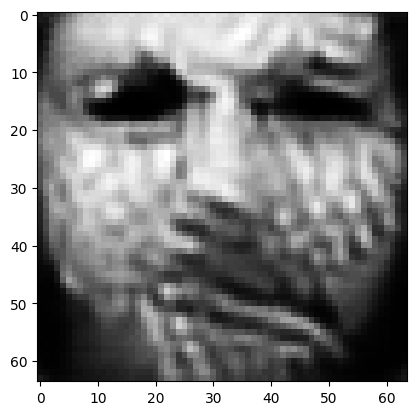

tensor([[4.5077e-04, 9.1012e-01, 3.1432e-04, 7.9232e-03, 4.6226e-04, 2.2552e-03,
         1.5720e-04, 1.4530e-03, 5.6080e-04, 1.1962e-03, 9.5351e-04, 6.8645e-03,
         4.1694e-03, 3.4706e-04, 8.2520e-04, 1.5018e-03, 1.0052e-03, 1.3395e-03,
         2.3968e-03, 1.0342e-03, 7.8379e-04, 4.3853e-05, 3.8572e-03, 3.4987e-04,
         6.0296e-04, 4.8741e-03, 9.1010e-04, 2.9744e-04, 1.7084e-03, 1.1720e-02,
         1.2068e-03, 3.5397e-03, 3.7449e-03, 1.6500e-04, 3.6881e-03, 1.3586e-02,
         6.9091e-04, 1.2694e-03, 6.1532e-04, 1.0110e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09417403489351273
tensor([[4.4976e-04, 9.1028e-01, 3.1374e-04, 7.9185e-03, 4.6114e-04, 2.2493e-03,
         1.5673e-04, 1.4505e-03, 5.5940e-04, 1.1934e-03, 9.5067e-04, 6.8495e-03,
         4.1671e-03, 3.4662e-04, 8.2312e-04, 1.4974e-03, 1.0042e-03, 1.3351e-03,
         2.3932e-03, 1.0311e-03, 7.8083e-04, 4.3717e-05, 3.8563e-03, 3.4892e-04,
         6.0228e-04, 4.8695e-03, 9.0795e-0

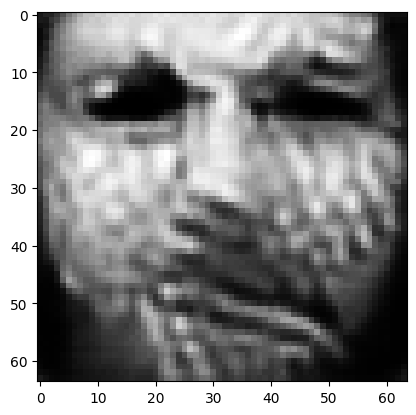

tensor([[4.4558e-04, 9.1086e-01, 3.1131e-04, 7.8886e-03, 4.5665e-04, 2.2247e-03,
         1.5484e-04, 1.4387e-03, 5.5409e-04, 1.1822e-03, 9.4006e-04, 6.7985e-03,
         4.1539e-03, 3.4492e-04, 8.1565e-04, 1.4793e-03, 9.9882e-04, 1.3193e-03,
         2.3772e-03, 1.0192e-03, 7.6978e-04, 4.3217e-05, 3.8494e-03, 3.4491e-04,
         5.9876e-04, 4.8562e-03, 8.9992e-04, 2.9528e-04, 1.6838e-03, 1.1629e-02,
         1.2042e-03, 3.4966e-03, 3.6933e-03, 1.6369e-04, 3.6450e-03, 1.3515e-02,
         6.8556e-04, 1.2583e-03, 6.0885e-04, 9.9782e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09336845576763153
tensor([[4.4501e-04, 9.1101e-01, 3.1103e-04, 7.8819e-03, 4.5575e-04, 2.2214e-03,
         1.5445e-04, 1.4370e-03, 5.5275e-04, 1.1806e-03, 9.3762e-04, 6.7884e-03,
         4.1509e-03, 3.4438e-04, 8.1388e-04, 1.4769e-03, 9.9797e-04, 1.3155e-03,
         2.3754e-03, 1.0172e-03, 7.6764e-04, 4.3126e-05, 3.8446e-03, 3.4414e-04,
         5.9747e-04, 4.8470e-03, 8.9868e-0

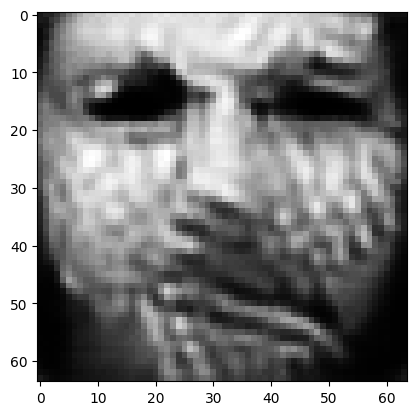

tensor([[4.4071e-04, 9.1160e-01, 3.0909e-04, 7.8397e-03, 4.5165e-04, 2.2001e-03,
         1.5255e-04, 1.4240e-03, 5.4734e-04, 1.1717e-03, 9.2689e-04, 6.7474e-03,
         4.1367e-03, 3.4245e-04, 8.0435e-04, 1.4619e-03, 9.9391e-04, 1.2972e-03,
         2.3587e-03, 1.0068e-03, 7.5704e-04, 4.2697e-05, 3.8347e-03, 3.4057e-04,
         5.9273e-04, 4.8377e-03, 8.9076e-04, 2.9335e-04, 1.6609e-03, 1.1558e-02,
         1.2020e-03, 3.4495e-03, 3.6457e-03, 1.6266e-04, 3.5993e-03, 1.3402e-02,
         6.8173e-04, 1.2451e-03, 6.0253e-04, 9.8982e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09255625307559967
tensor([[4.3971e-04, 9.1174e-01, 3.0863e-04, 7.8297e-03, 4.5065e-04, 2.1954e-03,
         1.5210e-04, 1.4208e-03, 5.4604e-04, 1.1697e-03, 9.2433e-04, 6.7387e-03,
         4.1336e-03, 3.4195e-04, 8.0203e-04, 1.4585e-03, 9.9299e-04, 1.2928e-03,
         2.3546e-03, 1.0046e-03, 7.5457e-04, 4.2600e-05, 3.8317e-03, 3.3980e-04,
         5.9160e-04, 4.8342e-03, 8.8881e-0

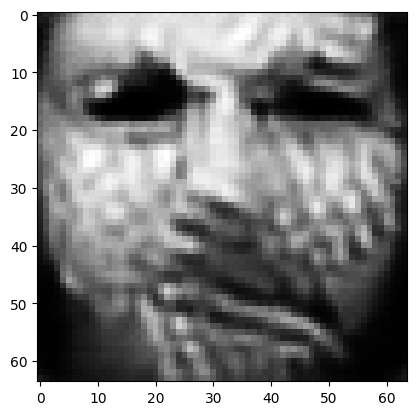

tensor([[4.3612e-04, 9.1230e-01, 3.0697e-04, 7.7829e-03, 4.4692e-04, 2.1760e-03,
         1.5045e-04, 1.4097e-03, 5.4071e-04, 1.1619e-03, 9.1472e-04, 6.7015e-03,
         4.1184e-03, 3.3998e-04, 7.9344e-04, 1.4457e-03, 9.8908e-04, 1.2761e-03,
         2.3414e-03, 9.9543e-04, 7.4495e-04, 4.2226e-05, 3.8193e-03, 3.3671e-04,
         5.8696e-04, 4.8226e-03, 8.8205e-04, 2.9166e-04, 1.6396e-03, 1.1489e-02,
         1.2006e-03, 3.4080e-03, 3.6028e-03, 1.6176e-04, 3.5551e-03, 1.3301e-02,
         6.7868e-04, 1.2320e-03, 5.9647e-04, 9.8231e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0917886346578598
tensor([[4.3463e-04, 9.1243e-01, 3.0623e-04, 7.7704e-03, 4.4575e-04, 2.1688e-03,
         1.4993e-04, 1.4052e-03, 5.3952e-04, 1.1590e-03, 9.1212e-04, 6.6907e-03,
         4.1140e-03, 3.3959e-04, 7.9087e-04, 1.4406e-03, 9.8749e-04, 1.2718e-03,
         2.3356e-03, 9.9207e-04, 7.4209e-04, 4.2096e-05, 3.8194e-03, 3.3562e-04,
         5.8599e-04, 4.8266e-03, 8.7979e-04

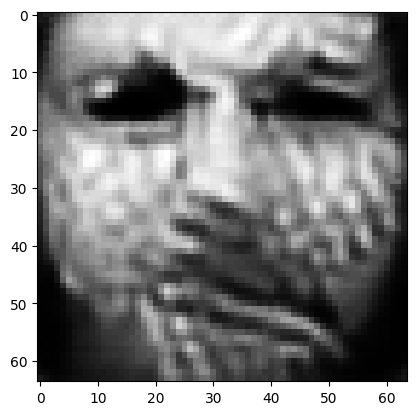

tensor([[4.3156e-04, 9.1295e-01, 3.0487e-04, 7.7290e-03, 4.4237e-04, 2.1519e-03,
         1.4844e-04, 1.3957e-03, 5.3464e-04, 1.1520e-03, 9.0346e-04, 6.6568e-03,
         4.1009e-03, 3.3782e-04, 7.8278e-04, 1.4296e-03, 9.8405e-04, 1.2565e-03,
         2.3244e-03, 9.8407e-04, 7.3318e-04, 4.1761e-05, 3.8061e-03, 3.3292e-04,
         5.8162e-04, 4.8140e-03, 8.7375e-04, 2.9016e-04, 1.6192e-03, 1.1421e-02,
         1.1998e-03, 3.3696e-03, 3.5633e-03, 1.6094e-04, 3.5133e-03, 1.3214e-02,
         6.7605e-04, 1.2200e-03, 5.9062e-04, 9.7497e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0910712480545044
tensor([[4.3095e-04, 9.1308e-01, 3.0458e-04, 7.7209e-03, 4.4161e-04, 2.1485e-03,
         1.4812e-04, 1.3938e-03, 5.3337e-04, 1.1505e-03, 9.0138e-04, 6.6489e-03,
         4.0982e-03, 3.3736e-04, 7.8080e-04, 1.4275e-03, 9.8357e-04, 1.2525e-03,
         2.3223e-03, 9.8247e-04, 7.3108e-04, 4.1694e-05, 3.8023e-03, 3.3245e-04,
         5.8061e-04, 4.8093e-03, 8.7219e-04

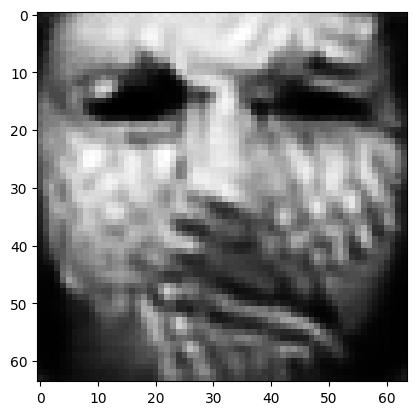

tensor([[4.2747e-04, 9.1356e-01, 3.0273e-04, 7.6823e-03, 4.3779e-04, 2.1282e-03,
         1.4659e-04, 1.3832e-03, 5.2892e-04, 1.1423e-03, 8.9320e-04, 6.6140e-03,
         4.0830e-03, 3.3580e-04, 7.7326e-04, 1.4143e-03, 9.7861e-04, 1.2381e-03,
         2.3102e-03, 9.7345e-04, 7.2204e-04, 4.1327e-05, 3.7925e-03, 3.2940e-04,
         5.7664e-04, 4.8065e-03, 8.6580e-04, 2.8867e-04, 1.6004e-03, 1.1353e-02,
         1.1989e-03, 3.3361e-03, 3.5273e-03, 1.6009e-04, 3.4745e-03, 1.3142e-02,
         6.7289e-04, 1.2096e-03, 5.8532e-04, 9.6678e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09041063487529755
tensor([[4.2726e-04, 9.1367e-01, 3.0263e-04, 7.6777e-03, 4.3717e-04, 2.1267e-03,
         1.4633e-04, 1.3824e-03, 5.2798e-04, 1.1414e-03, 8.9155e-04, 6.6084e-03,
         4.0808e-03, 3.3539e-04, 7.7196e-04, 1.4134e-03, 9.7803e-04, 1.2353e-03,
         2.3095e-03, 9.7257e-04, 7.2057e-04, 4.1285e-05, 3.7870e-03, 3.2904e-04,
         5.7546e-04, 4.7981e-03, 8.6510e-0

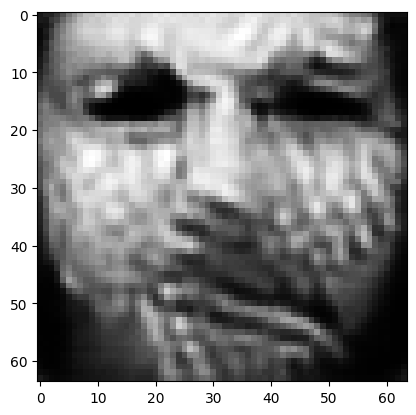

tensor([[4.2445e-04, 9.1409e-01, 3.0106e-04, 7.6453e-03, 4.3378e-04, 2.1109e-03,
         1.4504e-04, 1.3737e-03, 5.2399e-04, 1.1349e-03, 8.8448e-04, 6.5786e-03,
         4.0670e-03, 3.3381e-04, 7.6574e-04, 1.4025e-03, 9.7339e-04, 1.2234e-03,
         2.2997e-03, 9.6536e-04, 7.1291e-04, 4.0981e-05, 3.7759e-03, 3.2646e-04,
         5.7179e-04, 4.7905e-03, 8.5986e-04, 2.8722e-04, 1.5852e-03, 1.1294e-02,
         1.1970e-03, 3.3063e-03, 3.4967e-03, 1.5928e-04, 3.4423e-03, 1.3067e-02,
         6.6951e-04, 1.2003e-03, 5.8072e-04, 9.5987e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0898272842168808
tensor([[4.2408e-04, 9.1419e-01, 3.0086e-04, 7.6390e-03, 4.3314e-04, 2.1088e-03,
         1.4480e-04, 1.3723e-03, 5.2303e-04, 1.1339e-03, 8.8287e-04, 6.5728e-03,
         4.0649e-03, 3.3342e-04, 7.6456e-04, 1.4009e-03, 9.7278e-04, 1.2209e-03,
         2.2984e-03, 9.6418e-04, 7.1142e-04, 4.0928e-05, 3.7725e-03, 3.2603e-04,
         5.7089e-04, 4.7840e-03, 8.5913e-04

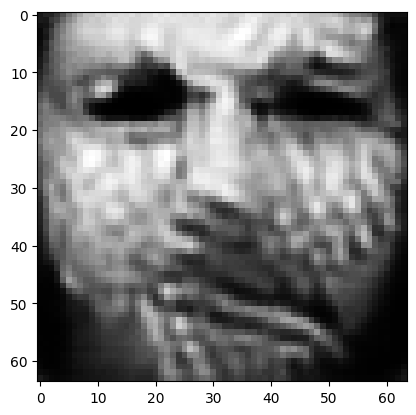

tensor([[4.2150e-04, 9.1458e-01, 2.9949e-04, 7.6115e-03, 4.3014e-04, 2.0952e-03,
         1.4361e-04, 1.3642e-03, 5.1936e-04, 1.1279e-03, 8.7621e-04, 6.5456e-03,
         4.0536e-03, 3.3199e-04, 7.5866e-04, 1.3910e-03, 9.6895e-04, 1.2101e-03,
         2.2889e-03, 9.5744e-04, 7.0458e-04, 4.0645e-05, 3.7633e-03, 3.2368e-04,
         5.6749e-04, 4.7750e-03, 8.5453e-04, 2.8586e-04, 1.5709e-03, 1.1234e-02,
         1.1953e-03, 3.2784e-03, 3.4683e-03, 1.5854e-04, 3.4132e-03, 1.2999e-02,
         6.6672e-04, 1.1915e-03, 5.7628e-04, 9.5372e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08928709477186203
tensor([[4.2070e-04, 9.1468e-01, 2.9905e-04, 7.6036e-03, 4.2934e-04, 2.0908e-03,
         1.4329e-04, 1.3619e-03, 5.1837e-04, 1.1260e-03, 8.7451e-04, 6.5374e-03,
         4.0499e-03, 3.3164e-04, 7.5719e-04, 1.3880e-03, 9.6782e-04, 1.2072e-03,
         2.2861e-03, 9.5536e-04, 7.0271e-04, 4.0564e-05, 3.7620e-03, 3.2305e-04,
         5.6673e-04, 4.7752e-03, 8.5305e-0

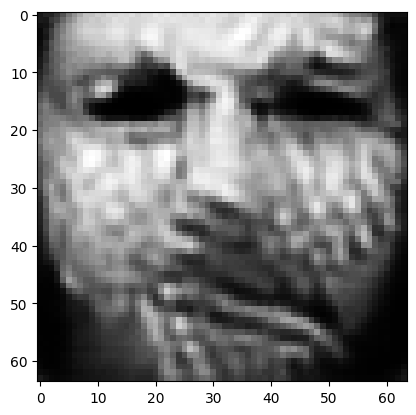

tensor([[4.1791e-04, 9.1508e-01, 2.9770e-04, 7.5743e-03, 4.2652e-04, 2.0755e-03,
         1.4209e-04, 1.3536e-03, 5.1458e-04, 1.1192e-03, 8.6770e-04, 6.5075e-03,
         4.0385e-03, 3.3032e-04, 7.5116e-04, 1.3777e-03, 9.6468e-04, 1.1953e-03,
         2.2753e-03, 9.4806e-04, 6.9596e-04, 4.0314e-05, 3.7574e-03, 3.2096e-04,
         5.6352e-04, 4.7697e-03, 8.4776e-04, 2.8442e-04, 1.5548e-03, 1.1179e-02,
         1.1942e-03, 3.2498e-03, 3.4372e-03, 1.5787e-04, 3.3799e-03, 1.2946e-02,
         6.6460e-04, 1.1827e-03, 5.7100e-04, 9.4695e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08874595910310745
tensor([[4.1735e-04, 9.1518e-01, 2.9743e-04, 7.5680e-03, 4.2594e-04, 2.0725e-03,
         1.4180e-04, 1.3521e-03, 5.1357e-04, 1.1172e-03, 8.6595e-04, 6.4981e-03,
         4.0363e-03, 3.3003e-04, 7.4971e-04, 1.3754e-03, 9.6403e-04, 1.1926e-03,
         2.2734e-03, 9.4605e-04, 6.9429e-04, 4.0244e-05, 3.7566e-03, 3.2042e-04,
         5.6269e-04, 4.7666e-03, 8.4676e-0

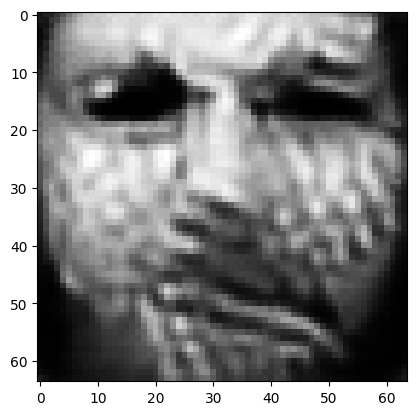

tensor([[4.1417e-04, 9.1558e-01, 2.9581e-04, 7.5413e-03, 4.2323e-04, 2.0560e-03,
         1.4049e-04, 1.3436e-03, 5.0990e-04, 1.1088e-03, 8.5890e-04, 6.4608e-03,
         4.0250e-03, 3.2894e-04, 7.4316e-04, 1.3632e-03, 9.6021e-04, 1.1811e-03,
         2.2616e-03, 9.3718e-04, 6.8690e-04, 3.9930e-05, 3.7559e-03, 3.1796e-04,
         5.5981e-04, 4.7677e-03, 8.4090e-04, 2.8320e-04, 1.5378e-03, 1.1108e-02,
         1.1929e-03, 3.2187e-03, 3.4044e-03, 1.5708e-04, 3.3484e-03, 1.2903e-02,
         6.6255e-04, 1.1744e-03, 5.6531e-04, 9.3893e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08819426596164703
tensor([[4.1337e-04, 9.1568e-01, 2.9539e-04, 7.5328e-03, 4.2256e-04, 2.0520e-03,
         1.4019e-04, 1.3413e-03, 5.0906e-04, 1.1069e-03, 8.5721e-04, 6.4522e-03,
         4.0219e-03, 3.2868e-04, 7.4161e-04, 1.3601e-03, 9.5916e-04, 1.1784e-03,
         2.2584e-03, 9.3498e-04, 6.8518e-04, 3.9856e-05, 3.7559e-03, 3.1730e-04,
         5.5904e-04, 4.7681e-03, 8.3963e-0

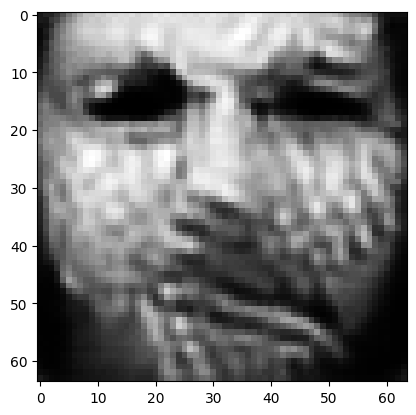

tensor([[4.1072e-04, 9.1604e-01, 2.9397e-04, 7.5060e-03, 4.2015e-04, 2.0372e-03,
         1.3910e-04, 1.3343e-03, 5.0550e-04, 1.0994e-03, 8.5094e-04, 6.4172e-03,
         4.0112e-03, 3.2763e-04, 7.3583e-04, 1.3497e-03, 9.5581e-04, 1.1679e-03,
         2.2492e-03, 9.2724e-04, 6.7863e-04, 3.9586e-05, 3.7544e-03, 3.1519e-04,
         5.5654e-04, 4.7672e-03, 8.3437e-04, 2.8204e-04, 1.5225e-03, 1.1045e-02,
         1.1913e-03, 3.1915e-03, 3.3764e-03, 1.5637e-04, 3.3194e-03, 1.2869e-02,
         6.6070e-04, 1.1666e-03, 5.6019e-04, 9.3152e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08769228309392929
tensor([[4.1002e-04, 9.1613e-01, 2.9354e-04, 7.5010e-03, 4.1955e-04, 2.0331e-03,
         1.3884e-04, 1.3325e-03, 5.0464e-04, 1.0973e-03, 8.4938e-04, 6.4077e-03,
         4.0086e-03, 3.2737e-04, 7.3449e-04, 1.3468e-03, 9.5482e-04, 1.1655e-03,
         2.2468e-03, 9.2525e-04, 6.7694e-04, 3.9514e-05, 3.7546e-03, 3.1467e-04,
         5.5608e-04, 4.7675e-03, 8.3290e-0

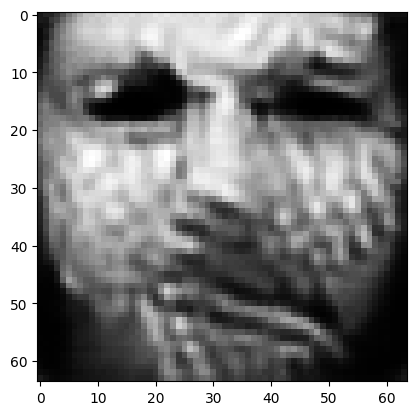

tensor([[4.0758e-04, 9.1646e-01, 2.9223e-04, 7.4794e-03, 4.1733e-04, 2.0199e-03,
         1.3784e-04, 1.3259e-03, 5.0157e-04, 1.0904e-03, 8.4366e-04, 6.3762e-03,
         3.9999e-03, 3.2646e-04, 7.2938e-04, 1.3371e-03, 9.5153e-04, 1.1562e-03,
         2.2377e-03, 9.1814e-04, 6.7098e-04, 3.9269e-05, 3.7539e-03, 3.1268e-04,
         5.5386e-04, 4.7654e-03, 8.2825e-04, 2.8083e-04, 1.5083e-03, 1.0985e-02,
         1.1895e-03, 3.1671e-03, 3.3507e-03, 1.5568e-04, 3.2933e-03, 1.2842e-02,
         6.5869e-04, 1.1598e-03, 5.5573e-04, 9.2440e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08724118769168854
tensor([[4.0724e-04, 9.1654e-01, 2.9205e-04, 7.4715e-03, 4.1692e-04, 2.0178e-03,
         1.3767e-04, 1.3249e-03, 5.0079e-04, 1.0893e-03, 8.4248e-04, 6.3700e-03,
         3.9976e-03, 3.2618e-04, 7.2843e-04, 1.3358e-03, 9.5092e-04, 1.1544e-03,
         2.2367e-03, 9.1697e-04, 6.6990e-04, 3.9230e-05, 3.7522e-03, 3.1231e-04,
         5.5310e-04, 4.7621e-03, 8.2758e-0

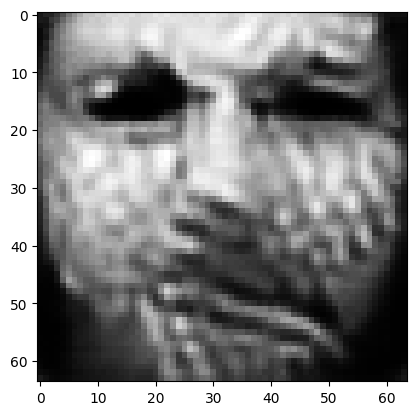

tensor([[4.0501e-04, 9.1685e-01, 2.9080e-04, 7.4513e-03, 4.1492e-04, 2.0056e-03,
         1.3675e-04, 1.3190e-03, 4.9776e-04, 1.0828e-03, 8.3711e-04, 6.3402e-03,
         3.9891e-03, 3.2527e-04, 7.2373e-04, 1.3268e-03, 9.4795e-04, 1.1457e-03,
         2.2285e-03, 9.1050e-04, 6.6428e-04, 3.9003e-05, 3.7509e-03, 3.1058e-04,
         5.5109e-04, 4.7586e-03, 8.2309e-04, 2.7981e-04, 1.4956e-03, 1.0931e-02,
         1.1874e-03, 3.1447e-03, 3.3276e-03, 1.5505e-04, 3.2695e-03, 1.2806e-02,
         6.5686e-04, 1.1533e-03, 5.5156e-04, 9.1827e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08681436628103256
tensor([[4.0458e-04, 9.1692e-01, 2.9059e-04, 7.4449e-03, 4.1451e-04, 2.0032e-03,
         1.3656e-04, 1.3180e-03, 4.9704e-04, 1.0816e-03, 8.3593e-04, 6.3340e-03,
         3.9867e-03, 3.2504e-04, 7.2273e-04, 1.3253e-03, 9.4736e-04, 1.1438e-03,
         2.2271e-03, 9.0916e-04, 6.6313e-04, 3.8961e-05, 3.7498e-03, 3.1023e-04,
         5.5045e-04, 4.7571e-03, 8.2224e-0

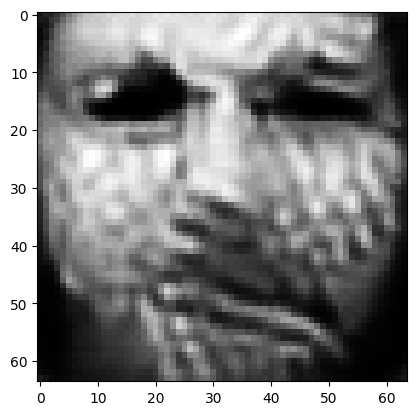

tensor([[4.0272e-04, 9.1721e-01, 2.8952e-04, 7.4258e-03, 4.1278e-04, 1.9928e-03,
         1.3577e-04, 1.3131e-03, 4.9421e-04, 1.0760e-03, 8.3101e-04, 6.3069e-03,
         3.9791e-03, 3.2415e-04, 7.1857e-04, 1.3177e-03, 9.4478e-04, 1.1361e-03,
         2.2206e-03, 9.0358e-04, 6.5811e-04, 3.8762e-05, 3.7475e-03, 3.0874e-04,
         5.4852e-04, 4.7510e-03, 8.1845e-04, 2.7889e-04, 1.4840e-03, 1.0878e-02,
         1.1854e-03, 3.1242e-03, 3.3058e-03, 1.5447e-04, 3.2477e-03, 1.2770e-02,
         6.5516e-04, 1.1472e-03, 5.4772e-04, 9.1265e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08641600608825684
tensor([[4.0201e-04, 9.1728e-01, 2.8909e-04, 7.4217e-03, 4.1225e-04, 1.9892e-03,
         1.3553e-04, 1.3111e-03, 4.9354e-04, 1.0742e-03, 8.2961e-04, 6.2989e-03,
         3.9774e-03, 3.2397e-04, 7.1734e-04, 1.3148e-03, 9.4383e-04, 1.1341e-03,
         2.2178e-03, 9.0179e-04, 6.5656e-04, 3.8695e-05, 3.7485e-03, 3.0826e-04,
         5.4827e-04, 4.7523e-03, 8.1716e-0

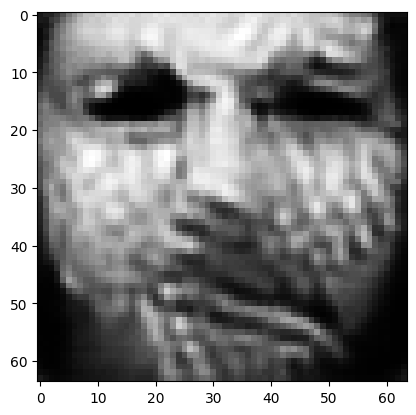

tensor([[4.0049e-04, 9.1755e-01, 2.8819e-04, 7.4014e-03, 4.1074e-04, 1.9804e-03,
         1.3486e-04, 1.3070e-03, 4.9094e-04, 1.0696e-03, 8.2533e-04, 6.2757e-03,
         3.9700e-03, 3.2311e-04, 7.1392e-04, 1.3089e-03, 9.4157e-04, 1.1274e-03,
         2.2127e-03, 8.9716e-04, 6.5232e-04, 3.8534e-05, 3.7451e-03, 3.0702e-04,
         5.4634e-04, 4.7443e-03, 8.1402e-04, 2.7797e-04, 1.4731e-03, 1.0826e-02,
         1.1835e-03, 3.1064e-03, 3.2859e-03, 1.5392e-04, 3.2279e-03, 1.2745e-02,
         6.5353e-04, 1.1416e-03, 5.4418e-04, 9.0711e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08605118095874786
tensor([[3.9999e-04, 9.1761e-01, 2.8789e-04, 7.3981e-03, 4.1032e-04, 1.9776e-03,
         1.3466e-04, 1.3057e-03, 4.9033e-04, 1.0681e-03, 8.2417e-04, 6.2688e-03,
         3.9684e-03, 3.2292e-04, 7.1291e-04, 1.3068e-03, 9.4091e-04, 1.1256e-03,
         2.2108e-03, 8.9578e-04, 6.5109e-04, 3.8482e-05, 3.7452e-03, 3.0666e-04,
         5.4603e-04, 4.7440e-03, 8.1296e-0

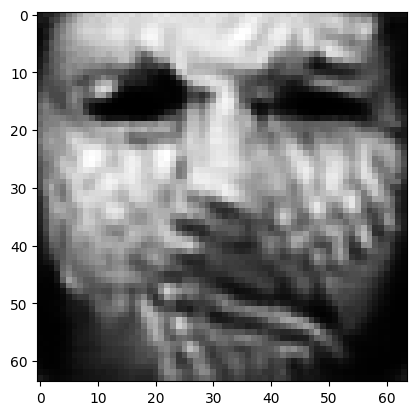

tensor([[3.9854e-04, 9.1786e-01, 2.8703e-04, 7.3784e-03, 4.0885e-04, 1.9691e-03,
         1.3405e-04, 1.3016e-03, 4.8792e-04, 1.0637e-03, 8.2014e-04, 6.2475e-03,
         3.9612e-03, 3.2210e-04, 7.0971e-04, 1.3012e-03, 9.3878e-04, 1.1193e-03,
         2.2057e-03, 8.9153e-04, 6.4724e-04, 3.8339e-05, 3.7421e-03, 3.0549e-04,
         5.4413e-04, 4.7369e-03, 8.1000e-04, 2.7712e-04, 1.4630e-03, 1.0782e-02,
         1.1817e-03, 3.0892e-03, 3.2682e-03, 1.5342e-04, 3.2090e-03, 1.2716e-02,
         6.5201e-04, 1.1364e-03, 5.4100e-04, 9.0236e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0857122614979744
tensor([[3.9795e-04, 9.1792e-01, 2.8668e-04, 7.3748e-03, 4.0840e-04, 1.9661e-03,
         1.3385e-04, 1.2999e-03, 4.8736e-04, 1.0622e-03, 8.1896e-04, 6.2409e-03,
         3.9597e-03, 3.2193e-04, 7.0870e-04, 1.2989e-03, 9.3801e-04, 1.1175e-03,
         2.2033e-03, 8.9003e-04, 6.4600e-04, 3.8284e-05, 3.7429e-03, 3.0509e-04,
         5.4387e-04, 4.7377e-03, 8.0895e-04

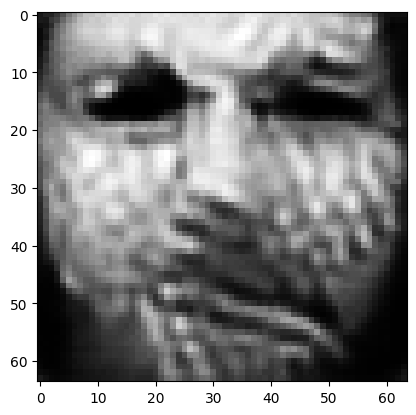

tensor([[3.9649e-04, 9.1815e-01, 2.8582e-04, 7.3580e-03, 4.0698e-04, 1.9579e-03,
         1.3325e-04, 1.2956e-03, 4.8510e-04, 1.0578e-03, 8.1502e-04, 6.2201e-03,
         3.9533e-03, 3.2116e-04, 7.0540e-04, 1.2933e-03, 9.3587e-04, 1.1113e-03,
         2.1980e-03, 8.8581e-04, 6.4220e-04, 3.8141e-05, 3.7405e-03, 3.0394e-04,
         5.4212e-04, 4.7320e-03, 8.0602e-04, 2.7621e-04, 1.4531e-03, 1.0740e-02,
         1.1800e-03, 3.0729e-03, 3.2513e-03, 1.5295e-04, 3.1908e-03, 1.2692e-02,
         6.5063e-04, 1.1314e-03, 5.3798e-04, 8.9785e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08539293706417084
tensor([[3.9630e-04, 9.1821e-01, 2.8570e-04, 7.3527e-03, 4.0673e-04, 1.9566e-03,
         1.3314e-04, 1.2951e-03, 4.8454e-04, 1.0570e-03, 8.1418e-04, 6.2159e-03,
         3.9516e-03, 3.2095e-04, 7.0479e-04, 1.2926e-03, 9.3547e-04, 1.1100e-03,
         2.1975e-03, 8.8505e-04, 6.4152e-04, 3.8118e-05, 3.7389e-03, 3.0373e-04,
         5.4154e-04, 4.7289e-03, 8.0562e-0

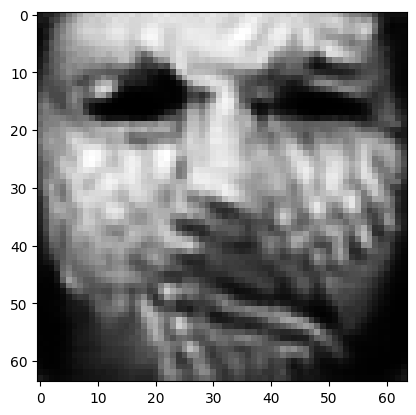

tensor([[3.9503e-04, 9.1843e-01, 2.8494e-04, 7.3351e-03, 4.0549e-04, 1.9494e-03,
         1.3261e-04, 1.2914e-03, 4.8242e-04, 1.0532e-03, 8.1060e-04, 6.1968e-03,
         3.9455e-03, 3.2021e-04, 7.0185e-04, 1.2878e-03, 9.3349e-04, 1.1045e-03,
         2.1930e-03, 8.8131e-04, 6.3813e-04, 3.7990e-05, 3.7361e-03, 3.0270e-04,
         5.3983e-04, 4.7225e-03, 8.0308e-04, 2.7554e-04, 1.4447e-03, 1.0703e-02,
         1.1782e-03, 3.0576e-03, 3.2367e-03, 1.5250e-04, 3.1754e-03, 1.2659e-02,
         6.4941e-04, 1.1268e-03, 5.3518e-04, 8.9436e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08509364724159241
tensor([[3.9449e-04, 9.1848e-01, 2.8461e-04, 7.3316e-03, 4.0507e-04, 1.9465e-03,
         1.3243e-04, 1.2898e-03, 4.8189e-04, 1.0517e-03, 8.0955e-04, 6.1907e-03,
         3.9440e-03, 3.2006e-04, 7.0094e-04, 1.2856e-03, 9.3275e-04, 1.1030e-03,
         2.1909e-03, 8.7989e-04, 6.3702e-04, 3.7940e-05, 3.7370e-03, 3.0231e-04,
         5.3960e-04, 4.7233e-03, 8.0213e-0

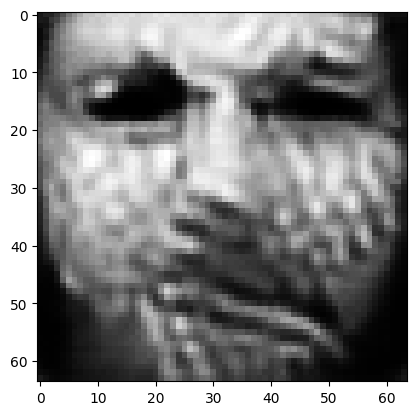

tensor([[3.9321e-04, 9.1868e-01, 2.8384e-04, 7.3148e-03, 4.0383e-04, 1.9392e-03,
         1.3192e-04, 1.2862e-03, 4.7992e-04, 1.0480e-03, 8.0619e-04, 6.1728e-03,
         3.9380e-03, 3.1936e-04, 6.9814e-04, 1.2808e-03, 9.3073e-04, 1.0977e-03,
         2.1863e-03, 8.7632e-04, 6.3381e-04, 3.7816e-05, 3.7344e-03, 3.0130e-04,
         5.3801e-04, 4.7181e-03, 7.9958e-04, 2.7473e-04, 1.4362e-03, 1.0667e-02,
         1.1766e-03, 3.0439e-03, 3.2224e-03, 1.5207e-04, 3.1596e-03, 1.2639e-02,
         6.4812e-04, 1.1224e-03, 5.3247e-04, 8.9031e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08481211960315704
tensor([[3.9276e-04, 9.1873e-01, 2.8357e-04, 7.3116e-03, 4.0346e-04, 1.9369e-03,
         1.3176e-04, 1.2849e-03, 4.7947e-04, 1.0467e-03, 8.0525e-04, 6.1675e-03,
         3.9367e-03, 3.1922e-04, 6.9734e-04, 1.2790e-03, 9.3008e-04, 1.0964e-03,
         2.1845e-03, 8.7512e-04, 6.3288e-04, 3.7772e-05, 3.7349e-03, 3.0096e-04,
         5.3774e-04, 4.7183e-03, 7.9882e-0

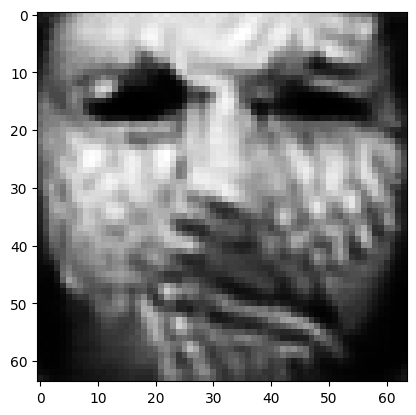

tensor([[3.9137e-04, 9.1892e-01, 2.8275e-04, 7.2960e-03, 4.0216e-04, 1.9294e-03,
         1.3124e-04, 1.2808e-03, 4.7768e-04, 1.0430e-03, 8.0202e-04, 6.1503e-03,
         3.9310e-03, 3.1858e-04, 6.9456e-04, 1.2738e-03, 9.2790e-04, 1.0914e-03,
         2.1794e-03, 8.7136e-04, 6.2977e-04, 3.7638e-05, 3.7336e-03, 2.9983e-04,
         5.3635e-04, 4.7160e-03, 7.9631e-04, 2.7394e-04, 1.4283e-03, 1.0634e-02,
         1.1751e-03, 3.0311e-03, 3.2090e-03, 1.5165e-04, 3.1457e-03, 1.2625e-02,
         6.4693e-04, 1.1184e-03, 5.2990e-04, 8.8648e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08455516397953033
tensor([[3.9122e-04, 9.1897e-01, 2.8265e-04, 7.2908e-03, 4.0193e-04, 1.9283e-03,
         1.3115e-04, 1.2803e-03, 4.7727e-04, 1.0424e-03, 8.0144e-04, 6.1477e-03,
         3.9293e-03, 3.1841e-04, 6.9421e-04, 1.2732e-03, 9.2750e-04, 1.0905e-03,
         2.1788e-03, 8.7092e-04, 6.2929e-04, 3.7623e-05, 3.7321e-03, 2.9966e-04,
         5.3587e-04, 4.7132e-03, 7.9602e-0

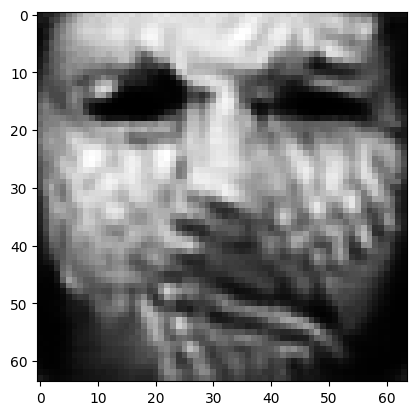

tensor([[3.9008e-04, 9.1914e-01, 2.8199e-04, 7.2766e-03, 4.0078e-04, 1.9219e-03,
         1.3069e-04, 1.2769e-03, 4.7563e-04, 1.0392e-03, 7.9856e-04, 6.1329e-03,
         3.9242e-03, 3.1783e-04, 6.9168e-04, 1.2689e-03, 9.2569e-04, 1.0859e-03,
         2.1746e-03, 8.6773e-04, 6.2651e-04, 3.7511e-05, 3.7300e-03, 2.9872e-04,
         5.3452e-04, 4.7099e-03, 7.9387e-04, 2.7332e-04, 1.4217e-03, 1.0607e-02,
         1.1738e-03, 3.0197e-03, 3.1980e-03, 1.5132e-04, 3.1328e-03, 1.2599e-02,
         6.4585e-04, 1.1147e-03, 5.2769e-04, 8.8355e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0843186303973198
tensor([[3.8971e-04, 9.1918e-01, 2.8176e-04, 7.2747e-03, 4.0044e-04, 1.9198e-03,
         1.3056e-04, 1.2759e-03, 4.7520e-04, 1.0382e-03, 7.9775e-04, 6.1278e-03,
         3.9231e-03, 3.1771e-04, 6.9092e-04, 1.2673e-03, 9.2518e-04, 1.0846e-03,
         2.1733e-03, 8.6667e-04, 6.2562e-04, 3.7472e-05, 3.7303e-03, 2.9845e-04,
         5.3436e-04, 4.7103e-03, 7.9310e-04

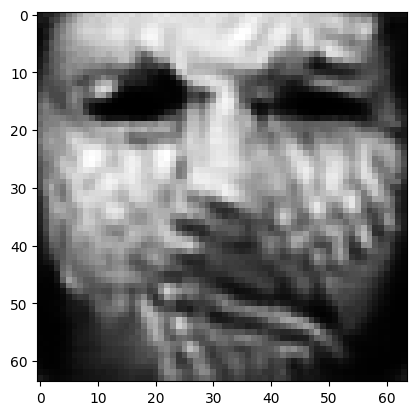

tensor([[3.8862e-04, 9.1934e-01, 2.8117e-04, 7.2610e-03, 3.9940e-04, 1.9143e-03,
         1.3014e-04, 1.2725e-03, 4.7368e-04, 1.0353e-03, 7.9498e-04, 6.1146e-03,
         3.9185e-03, 3.1717e-04, 6.8847e-04, 1.2634e-03, 9.2360e-04, 1.0802e-03,
         2.1692e-03, 8.6368e-04, 6.2312e-04, 3.7369e-05, 3.7280e-03, 2.9754e-04,
         5.3307e-04, 4.7064e-03, 7.9128e-04, 2.7269e-04, 1.4151e-03, 1.0579e-02,
         1.1726e-03, 3.0084e-03, 3.1872e-03, 1.5101e-04, 3.1201e-03, 1.2581e-02,
         6.4495e-04, 1.1111e-03, 5.2562e-04, 8.8052e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08409519493579865
tensor([[3.8818e-04, 9.1938e-01, 2.8092e-04, 7.2589e-03, 3.9907e-04, 1.9123e-03,
         1.3000e-04, 1.2713e-03, 4.7329e-04, 1.0342e-03, 7.9416e-04, 6.1097e-03,
         3.9175e-03, 3.1707e-04, 6.8767e-04, 1.2617e-03, 9.2306e-04, 1.0789e-03,
         2.1675e-03, 8.6252e-04, 6.2222e-04, 3.7328e-05, 3.7286e-03, 2.9724e-04,
         5.3294e-04, 4.7075e-03, 7.9053e-0

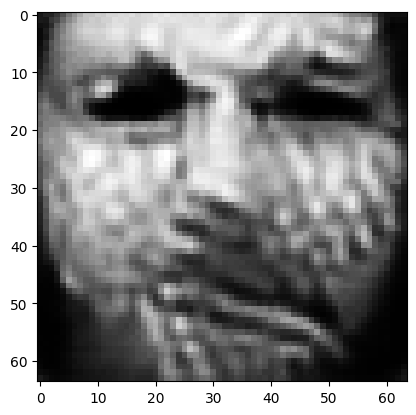

tensor([[3.8713e-04, 9.1954e-01, 2.8033e-04, 7.2464e-03, 3.9811e-04, 1.9071e-03,
         1.2960e-04, 1.2682e-03, 4.7185e-04, 1.0315e-03, 7.9151e-04, 6.0971e-03,
         3.9129e-03, 3.1657e-04, 6.8538e-04, 1.2580e-03, 9.2159e-04, 1.0747e-03,
         2.1635e-03, 8.5966e-04, 6.1984e-04, 3.7232e-05, 3.7263e-03, 2.9641e-04,
         5.3175e-04, 4.7038e-03, 7.8874e-04, 2.7206e-04, 1.4087e-03, 1.0553e-02,
         1.1713e-03, 2.9978e-03, 3.1764e-03, 1.5071e-04, 3.1077e-03, 1.2565e-02,
         6.4419e-04, 1.1077e-03, 5.2351e-04, 8.7761e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08388310670852661
tensor([[3.8679e-04, 9.1958e-01, 2.8015e-04, 7.2442e-03, 3.9784e-04, 1.9056e-03,
         1.2948e-04, 1.2673e-03, 4.7148e-04, 1.0307e-03, 7.9080e-04, 6.0934e-03,
         3.9119e-03, 3.1645e-04, 6.8471e-04, 1.2568e-03, 9.2124e-04, 1.0735e-03,
         2.1623e-03, 8.5883e-04, 6.1915e-04, 3.7203e-05, 3.7262e-03, 2.9619e-04,
         5.3156e-04, 4.7038e-03, 7.8811e-0

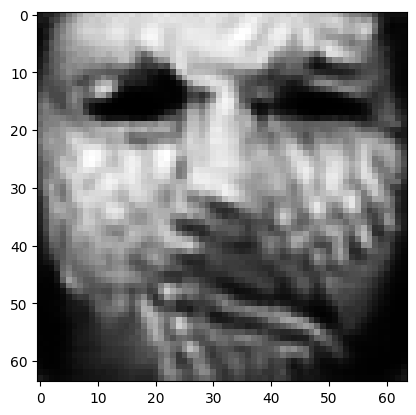

tensor([[3.8606e-04, 9.1972e-01, 2.7972e-04, 7.2355e-03, 3.9709e-04, 1.9019e-03,
         1.2915e-04, 1.2652e-03, 4.7016e-04, 1.0284e-03, 7.8852e-04, 6.0820e-03,
         3.9083e-03, 3.1600e-04, 6.8286e-04, 1.2542e-03, 9.2028e-04, 1.0700e-03,
         2.1595e-03, 8.5655e-04, 6.1717e-04, 3.7125e-05, 3.7237e-03, 2.9561e-04,
         5.3048e-04, 4.6972e-03, 7.8669e-04, 2.7149e-04, 1.4032e-03, 1.0528e-02,
         1.1698e-03, 2.9881e-03, 3.1666e-03, 1.5041e-04, 3.0967e-03, 1.2542e-02,
         6.4340e-04, 1.1047e-03, 5.2174e-04, 8.7518e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08368731290102005
tensor([[3.8610e-04, 9.1975e-01, 2.7975e-04, 7.2332e-03, 3.9702e-04, 1.9021e-03,
         1.2912e-04, 1.2653e-03, 4.6984e-04, 1.0283e-03, 7.8810e-04, 6.0804e-03,
         3.9077e-03, 3.1585e-04, 6.8260e-04, 1.2545e-03, 9.2033e-04, 1.0694e-03,
         2.1599e-03, 8.5647e-04, 6.1695e-04, 3.7123e-05, 3.7218e-03, 2.9560e-04,
         5.3007e-04, 4.6932e-03, 7.8664e-0

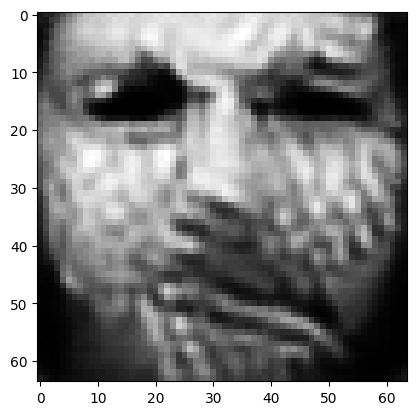

tensor([[3.8550e-04, 9.1989e-01, 2.7937e-04, 7.2272e-03, 3.9643e-04, 1.8992e-03,
         1.2883e-04, 1.2636e-03, 4.6860e-04, 1.0261e-03, 7.8595e-04, 6.0692e-03,
         3.9048e-03, 3.1542e-04, 6.8092e-04, 1.2523e-03, 9.1958e-04, 1.0662e-03,
         2.1575e-03, 8.5454e-04, 6.1515e-04, 3.7054e-05, 3.7192e-03, 2.9517e-04,
         5.2914e-04, 4.6852e-03, 7.8530e-04, 2.7102e-04, 1.3986e-03, 1.0504e-02,
         1.1679e-03, 2.9791e-03, 3.1581e-03, 1.5013e-04, 3.0877e-03, 1.2510e-02,
         6.4257e-04, 1.1019e-03, 5.2038e-04, 8.7351e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08350386470556259
tensor([[3.8543e-04, 9.1992e-01, 2.7933e-04, 7.2243e-03, 3.9631e-04, 1.8987e-03,
         1.2878e-04, 1.2633e-03, 4.6828e-04, 1.0258e-03, 7.8551e-04, 6.0674e-03,
         3.9039e-03, 3.1529e-04, 6.8064e-04, 1.2521e-03, 9.1948e-04, 1.0655e-03,
         2.1573e-03, 8.5429e-04, 6.1482e-04, 3.7047e-05, 3.7179e-03, 2.9511e-04,
         5.2882e-04, 4.6825e-03, 7.8509e-0

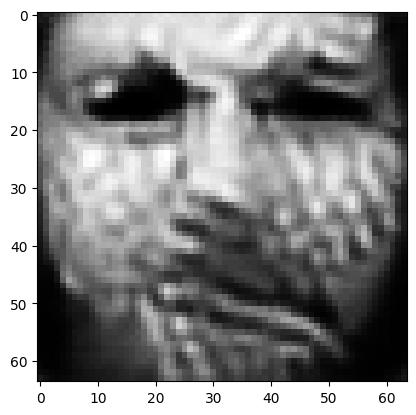

tensor([[3.8482e-04, 9.2005e-01, 2.7899e-04, 7.2184e-03, 3.9573e-04, 1.8959e-03,
         1.2848e-04, 1.2616e-03, 4.6707e-04, 1.0236e-03, 7.8341e-04, 6.0562e-03,
         3.9012e-03, 3.1491e-04, 6.7881e-04, 1.2500e-03, 9.1884e-04, 1.0623e-03,
         2.1547e-03, 8.5228e-04, 6.1301e-04, 3.6977e-05, 3.7159e-03, 2.9469e-04,
         5.2788e-04, 4.6762e-03, 7.8375e-04, 2.7055e-04, 1.3939e-03, 1.0481e-02,
         1.1662e-03, 2.9700e-03, 3.1493e-03, 1.4988e-04, 3.0783e-03, 1.2481e-02,
         6.4200e-04, 1.0991e-03, 5.1887e-04, 8.7179e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08332488685846329
tensor([[3.8455e-04, 9.2008e-01, 2.7882e-04, 7.2179e-03, 3.9555e-04, 1.8947e-03,
         1.2838e-04, 1.2609e-03, 4.6679e-04, 1.0228e-03, 7.8279e-04, 6.0524e-03,
         3.9007e-03, 3.1485e-04, 6.7824e-04, 1.2490e-03, 9.1857e-04, 1.0614e-03,
         2.1535e-03, 8.5152e-04, 6.1239e-04, 3.6949e-05, 3.7163e-03, 2.9452e-04,
         5.2778e-04, 4.6760e-03, 7.8325e-0

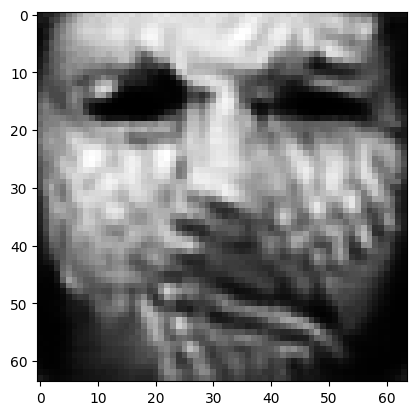

tensor([[3.8403e-04, 9.2021e-01, 2.7855e-04, 7.2104e-03, 3.9502e-04, 1.8922e-03,
         1.2811e-04, 1.2593e-03, 4.6562e-04, 1.0209e-03, 7.8087e-04, 6.0426e-03,
         3.8980e-03, 3.1449e-04, 6.7661e-04, 1.2472e-03, 9.1801e-04, 1.0584e-03,
         2.1513e-03, 8.4979e-04, 6.1078e-04, 3.6891e-05, 3.7141e-03, 2.9414e-04,
         5.2678e-04, 4.6694e-03, 7.8216e-04, 2.7007e-04, 1.3891e-03, 1.0458e-02,
         1.1647e-03, 2.9612e-03, 3.1406e-03, 1.4963e-04, 3.0691e-03, 1.2456e-02,
         6.4154e-04, 1.0964e-03, 5.1731e-04, 8.6996e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08315366506576538
tensor([[3.8375e-04, 9.2024e-01, 2.7838e-04, 7.2096e-03, 3.9483e-04, 1.8910e-03,
         1.2800e-04, 1.2586e-03, 4.6534e-04, 1.0201e-03, 7.8027e-04, 6.0391e-03,
         3.8975e-03, 3.1442e-04, 6.7604e-04, 1.2462e-03, 9.1771e-04, 1.0575e-03,
         2.1501e-03, 8.4904e-04, 6.1018e-04, 3.6863e-05, 3.7146e-03, 2.9398e-04,
         5.2668e-04, 4.6694e-03, 7.8165e-0

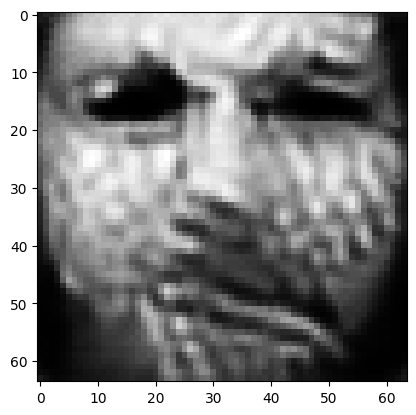

tensor([[3.8317e-04, 9.2036e-01, 2.7806e-04, 7.2038e-03, 3.9429e-04, 1.8882e-03,
         1.2772e-04, 1.2569e-03, 4.6425e-04, 1.0180e-03, 7.7837e-04, 6.0287e-03,
         3.8950e-03, 3.1408e-04, 6.7440e-04, 1.2442e-03, 9.1708e-04, 1.0547e-03,
         2.1476e-03, 8.4717e-04, 6.0850e-04, 3.6797e-05, 3.7133e-03, 2.9357e-04,
         5.2584e-04, 4.6641e-03, 7.8045e-04, 2.6957e-04, 1.3844e-03, 1.0435e-02,
         1.1632e-03, 2.9528e-03, 3.1318e-03, 1.4939e-04, 3.0603e-03, 1.2436e-02,
         6.4105e-04, 1.0939e-03, 5.1580e-04, 8.6799e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08299019932746887
tensor([[3.8322e-04, 9.2039e-01, 2.7810e-04, 7.2021e-03, 3.9428e-04, 1.8886e-03,
         1.2770e-04, 1.2570e-03, 4.6393e-04, 1.0180e-03, 7.7803e-04, 6.0277e-03,
         3.8945e-03, 3.1396e-04, 6.7408e-04, 1.2446e-03, 9.1722e-04, 1.0540e-03,
         2.1479e-03, 8.4712e-04, 6.0829e-04, 3.6797e-05, 3.7114e-03, 2.9363e-04,
         5.2545e-04, 4.6608e-03, 7.8041e-0

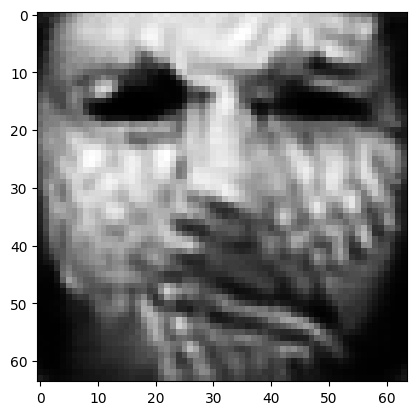

tensor([[3.8317e-04, 9.2051e-01, 2.7804e-04, 7.1968e-03, 3.9407e-04, 1.8886e-03,
         1.2754e-04, 1.2569e-03, 4.6259e-04, 1.0170e-03, 7.7644e-04, 6.0206e-03,
         3.8922e-03, 3.1350e-04, 6.7252e-04, 1.2450e-03, 9.1732e-04, 1.0510e-03,
         2.1479e-03, 8.4631e-04, 6.0696e-04, 3.6770e-05, 3.7057e-03, 2.9370e-04,
         5.2428e-04, 4.6508e-03, 7.7961e-04, 2.6923e-04, 1.3815e-03, 1.0411e-02,
         1.1612e-03, 2.9452e-03, 3.1249e-03, 1.4913e-04, 3.0519e-03, 1.2393e-02,
         6.4077e-04, 1.0916e-03, 5.1465e-04, 8.6733e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08282452076673508
tensor([[3.8315e-04, 9.2054e-01, 2.7801e-04, 7.1956e-03, 3.9402e-04, 1.8885e-03,
         1.2750e-04, 1.2569e-03, 4.6227e-04, 1.0167e-03, 7.7607e-04, 6.0187e-03,
         3.8915e-03, 3.1339e-04, 6.7218e-04, 1.2450e-03, 9.1730e-04, 1.0503e-03,
         2.1478e-03, 8.4612e-04, 6.0663e-04, 3.6764e-05, 3.7043e-03, 2.9372e-04,
         5.2402e-04, 4.6484e-03, 7.7937e-0

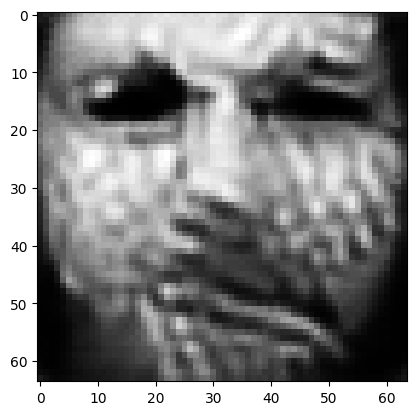

tensor([[3.8320e-04, 9.2066e-01, 2.7801e-04, 7.1900e-03, 3.9388e-04, 1.8888e-03,
         1.2738e-04, 1.2570e-03, 4.6102e-04, 1.0160e-03, 7.7467e-04, 6.0125e-03,
         3.8893e-03, 3.1294e-04, 6.7089e-04, 1.2456e-03, 9.1750e-04, 1.0476e-03,
         2.1481e-03, 8.4559e-04, 6.0553e-04, 3.6748e-05, 3.6984e-03, 2.9385e-04,
         5.2290e-04, 4.6375e-03, 7.7877e-04, 2.6889e-04, 1.3787e-03, 1.0389e-02,
         1.1591e-03, 2.9384e-03, 3.1187e-03, 1.4889e-04, 3.0438e-03, 1.2353e-02,
         6.4038e-04, 1.0894e-03, 5.1368e-04, 8.6660e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08266747742891312
tensor([[3.8321e-04, 9.2069e-01, 2.7800e-04, 7.1893e-03, 3.9384e-04, 1.8889e-03,
         1.2735e-04, 1.2571e-03, 4.6071e-04, 1.0157e-03, 7.7430e-04, 6.0106e-03,
         3.8888e-03, 3.1282e-04, 6.7053e-04, 1.2458e-03, 9.1753e-04, 1.0469e-03,
         2.1483e-03, 8.4542e-04, 6.0521e-04, 3.6742e-05, 3.6969e-03, 2.9388e-04,
         5.2265e-04, 4.6349e-03, 7.7855e-0

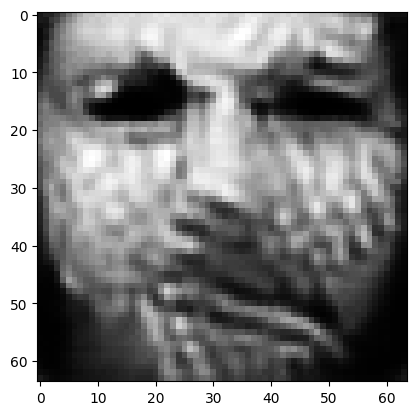

tensor([[3.8327e-04, 9.2080e-01, 2.7800e-04, 7.1837e-03, 3.9373e-04, 1.8893e-03,
         1.2724e-04, 1.2573e-03, 4.5949e-04, 1.0151e-03, 7.7296e-04, 6.0048e-03,
         3.8865e-03, 3.1237e-04, 6.6931e-04, 1.2465e-03, 9.1771e-04, 1.0444e-03,
         2.1486e-03, 8.4498e-04, 6.0414e-04, 3.6728e-05, 3.6908e-03, 2.9403e-04,
         5.2155e-04, 4.6241e-03, 7.7794e-04, 2.6856e-04, 1.3761e-03, 1.0367e-02,
         1.1570e-03, 2.9319e-03, 3.1129e-03, 1.4865e-04, 3.0361e-03, 1.2314e-02,
         6.3997e-04, 1.0873e-03, 5.1277e-04, 8.6594e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08251502364873886
tensor([[3.8329e-04, 9.2083e-01, 2.7801e-04, 7.1831e-03, 3.9370e-04, 1.8893e-03,
         1.2721e-04, 1.2574e-03, 4.5918e-04, 1.0149e-03, 7.7261e-04, 6.0030e-03,
         3.8860e-03, 3.1226e-04, 6.6896e-04, 1.2466e-03, 9.1778e-04, 1.0437e-03,
         2.1487e-03, 8.4480e-04, 6.0384e-04, 3.6723e-05, 3.6895e-03, 2.9406e-04,
         5.2131e-04, 4.6216e-03, 7.7776e-0

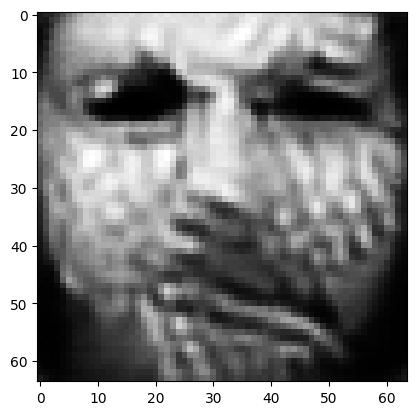

tensor([[3.8325e-04, 9.2093e-01, 2.7798e-04, 7.1776e-03, 3.9355e-04, 1.8894e-03,
         1.2707e-04, 1.2573e-03, 4.5801e-04, 1.0142e-03, 7.7123e-04, 5.9971e-03,
         3.8839e-03, 3.1183e-04, 6.6762e-04, 1.2470e-03, 9.1791e-04, 1.0410e-03,
         2.1487e-03, 8.4414e-04, 6.0272e-04, 3.6704e-05, 3.6842e-03, 2.9412e-04,
         5.2028e-04, 4.6127e-03, 7.7709e-04, 2.6823e-04, 1.3736e-03, 1.0347e-02,
         1.1552e-03, 2.9250e-03, 3.1068e-03, 1.4843e-04, 3.0286e-03, 1.2276e-02,
         6.3969e-04, 1.0852e-03, 5.1185e-04, 8.6533e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08236902207136154
tensor([[3.8325e-04, 9.2096e-01, 2.7796e-04, 7.1765e-03, 3.9351e-04, 1.8893e-03,
         1.2704e-04, 1.2573e-03, 4.5773e-04, 1.0140e-03, 7.7090e-04, 5.9956e-03,
         3.8833e-03, 3.1173e-04, 6.6733e-04, 1.2471e-03, 9.1791e-04, 1.0404e-03,
         2.1487e-03, 8.4400e-04, 6.0243e-04, 3.6700e-05, 3.6828e-03, 2.9414e-04,
         5.2005e-04, 4.6104e-03, 7.7689e-0

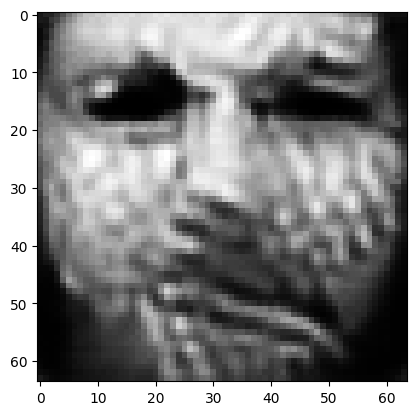

tensor([[3.8325e-04, 9.2106e-01, 2.7796e-04, 7.1711e-03, 3.9337e-04, 1.8895e-03,
         1.2692e-04, 1.2573e-03, 4.5662e-04, 1.0134e-03, 7.6962e-04, 5.9903e-03,
         3.8812e-03, 3.1133e-04, 6.6613e-04, 1.2476e-03, 9.1805e-04, 1.0379e-03,
         2.1488e-03, 8.4349e-04, 6.0141e-04, 3.6686e-05, 3.6776e-03, 2.9423e-04,
         5.1905e-04, 4.6015e-03, 7.7630e-04, 2.6792e-04, 1.3712e-03, 1.0329e-02,
         1.1534e-03, 2.9188e-03, 3.1014e-03, 1.4823e-04, 3.0213e-03, 1.2241e-02,
         6.3940e-04, 1.0833e-03, 5.1098e-04, 8.6475e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08223067969083786
tensor([[3.8311e-04, 9.2108e-01, 2.7789e-04, 7.1699e-03, 3.9326e-04, 1.8889e-03,
         1.2686e-04, 1.2569e-03, 4.5635e-04, 1.0130e-03, 7.6918e-04, 5.9881e-03,
         3.8806e-03, 3.1125e-04, 6.6566e-04, 1.2472e-03, 9.1795e-04, 1.0371e-03,
         2.1482e-03, 8.4304e-04, 6.0098e-04, 3.6671e-05, 3.6772e-03, 2.9415e-04,
         5.1889e-04, 4.6011e-03, 7.7596e-0

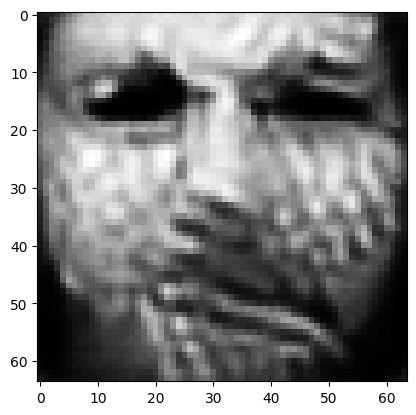

tensor([[3.8300e-04, 9.2118e-01, 2.7780e-04, 7.1658e-03, 3.9307e-04, 1.8885e-03,
         1.2671e-04, 1.2566e-03, 4.5532e-04, 1.0122e-03, 7.6787e-04, 5.9820e-03,
         3.8788e-03, 3.1089e-04, 6.6441e-04, 1.2471e-03, 9.1796e-04, 1.0347e-03,
         2.1477e-03, 8.4229e-04, 5.9985e-04, 3.6645e-05, 3.6731e-03, 2.9418e-04,
         5.1808e-04, 4.5939e-03, 7.7518e-04, 2.6757e-04, 1.3684e-03, 1.0310e-02,
         1.1519e-03, 2.9127e-03, 3.0954e-03, 1.4803e-04, 3.0142e-03, 1.2214e-02,
         6.3913e-04, 1.0814e-03, 5.1005e-04, 8.6379e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08209913223981857
tensor([[3.8301e-04, 9.2120e-01, 2.7781e-04, 7.1651e-03, 3.9305e-04, 1.8887e-03,
         1.2669e-04, 1.2566e-03, 4.5508e-04, 1.0120e-03, 7.6757e-04, 5.9808e-03,
         3.8785e-03, 3.1080e-04, 6.6411e-04, 1.2473e-03, 9.1804e-04, 1.0342e-03,
         2.1478e-03, 8.4218e-04, 5.9961e-04, 3.6641e-05, 3.6719e-03, 2.9420e-04,
         5.1786e-04, 4.5917e-03, 7.7507e-0

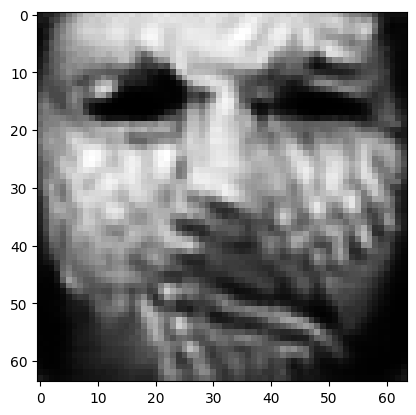

tensor([[3.8271e-04, 9.2129e-01, 2.7762e-04, 7.1592e-03, 3.9279e-04, 1.8872e-03,
         1.2652e-04, 1.2559e-03, 4.5413e-04, 1.0108e-03, 7.6631e-04, 5.9735e-03,
         3.8759e-03, 3.1051e-04, 6.6286e-04, 1.2465e-03, 9.1769e-04, 1.0320e-03,
         2.1467e-03, 8.4098e-04, 5.9838e-04, 3.6600e-05, 3.6695e-03, 2.9406e-04,
         5.1711e-04, 4.5881e-03, 7.7420e-04, 2.6731e-04, 1.3657e-03, 1.0291e-02,
         1.1506e-03, 2.9072e-03, 3.0899e-03, 1.4781e-04, 3.0080e-03, 1.2192e-02,
         6.3895e-04, 1.0797e-03, 5.0900e-04, 8.6279e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08197756111621857
tensor([[3.8274e-04, 9.2131e-01, 2.7763e-04, 7.1569e-03, 3.9277e-04, 1.8873e-03,
         1.2650e-04, 1.2559e-03, 4.5390e-04, 1.0106e-03, 7.6608e-04, 5.9726e-03,
         3.8751e-03, 3.1042e-04, 6.6270e-04, 1.2467e-03, 9.1768e-04, 1.0317e-03,
         2.1468e-03, 8.4092e-04, 5.9824e-04, 3.6600e-05, 3.6682e-03, 2.9407e-04,
         5.1684e-04, 4.5861e-03, 7.7416e-0

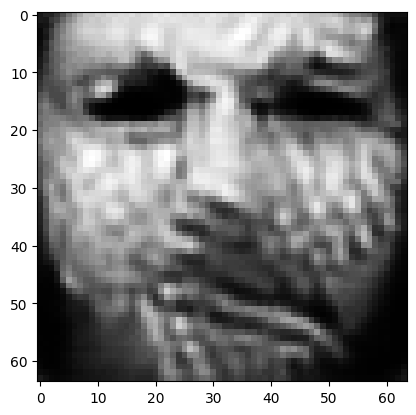

tensor([[3.8242e-04, 9.2140e-01, 2.7742e-04, 7.1523e-03, 3.9250e-04, 1.8858e-03,
         1.2633e-04, 1.2551e-03, 4.5299e-04, 1.0094e-03, 7.6485e-04, 5.9657e-03,
         3.8727e-03, 3.1015e-04, 6.6143e-04, 1.2458e-03, 9.1733e-04, 1.0295e-03,
         2.1455e-03, 8.3969e-04, 5.9700e-04, 3.6558e-05, 3.6661e-03, 2.9392e-04,
         5.1619e-04, 4.5831e-03, 7.7325e-04, 2.6706e-04, 1.3631e-03, 1.0274e-02,
         1.1495e-03, 2.9021e-03, 3.0848e-03, 1.4762e-04, 3.0021e-03, 1.2172e-02,
         6.3880e-04, 1.0781e-03, 5.0796e-04, 8.6180e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08186322450637817
tensor([[3.8238e-04, 9.2142e-01, 2.7740e-04, 7.1513e-03, 3.9245e-04, 1.8857e-03,
         1.2629e-04, 1.2550e-03, 4.5278e-04, 1.0091e-03, 7.6456e-04, 5.9641e-03,
         3.8723e-03, 3.1007e-04, 6.6114e-04, 1.2457e-03, 9.1729e-04, 1.0290e-03,
         2.1454e-03, 8.3945e-04, 5.9675e-04, 3.6549e-05, 3.6654e-03, 2.9391e-04,
         5.1601e-04, 4.5819e-03, 7.7310e-0

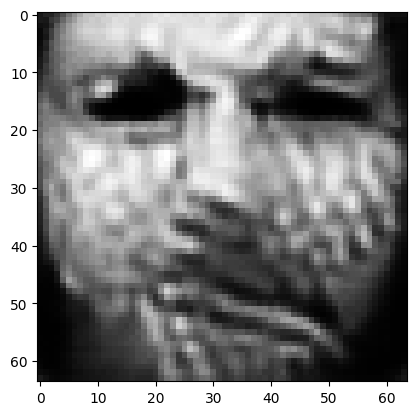

tensor([[3.8223e-04, 9.2150e-01, 2.7728e-04, 7.1454e-03, 3.9228e-04, 1.8849e-03,
         1.2617e-04, 1.2546e-03, 4.5191e-04, 1.0083e-03, 7.6352e-04, 5.9588e-03,
         3.8698e-03, 3.0977e-04, 6.6015e-04, 1.2455e-03, 9.1707e-04, 1.0272e-03,
         2.1448e-03, 8.3865e-04, 5.9579e-04, 3.6525e-05, 3.6621e-03, 2.9385e-04,
         5.1526e-04, 4.5770e-03, 7.7250e-04, 2.6684e-04, 1.3608e-03, 1.0259e-02,
         1.1483e-03, 2.8974e-03, 3.0801e-03, 1.4743e-04, 2.9966e-03, 1.2150e-02,
         6.3866e-04, 1.0766e-03, 5.0701e-04, 8.6105e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08175414800643921
tensor([[3.8216e-04, 9.2152e-01, 2.7723e-04, 7.1441e-03, 3.9221e-04, 1.8846e-03,
         1.2613e-04, 1.2544e-03, 4.5169e-04, 1.0080e-03, 7.6324e-04, 5.9572e-03,
         3.8692e-03, 3.0970e-04, 6.5986e-04, 1.2454e-03, 9.1699e-04, 1.0267e-03,
         2.1446e-03, 8.3839e-04, 5.9551e-04, 3.6517e-05, 3.6615e-03, 2.9383e-04,
         5.1510e-04, 4.5762e-03, 7.7228e-0

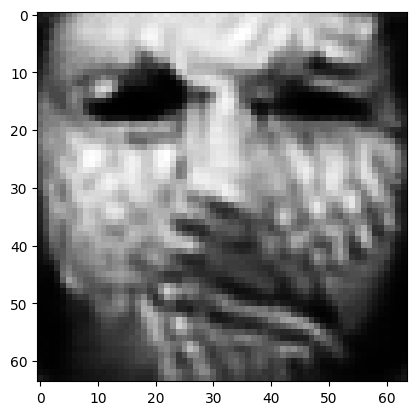

tensor([[3.8199e-04, 9.2160e-01, 2.7711e-04, 7.1393e-03, 3.9204e-04, 1.8838e-03,
         1.2600e-04, 1.2540e-03, 4.5083e-04, 1.0071e-03, 7.6221e-04, 5.9515e-03,
         3.8669e-03, 3.0943e-04, 6.5884e-04, 1.2451e-03, 9.1680e-04, 1.0249e-03,
         2.1440e-03, 8.3751e-04, 5.9453e-04, 3.6489e-05, 3.6588e-03, 2.9378e-04,
         5.1444e-04, 4.5721e-03, 7.7161e-04, 2.6661e-04, 1.3585e-03, 1.0243e-02,
         1.1471e-03, 2.8929e-03, 3.0753e-03, 1.4725e-04, 2.9912e-03, 1.2132e-02,
         6.3854e-04, 1.0752e-03, 5.0606e-04, 8.6012e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08164902031421661
tensor([[3.8195e-04, 9.2161e-01, 2.7708e-04, 7.1382e-03, 3.9200e-04, 1.8836e-03,
         1.2597e-04, 1.2539e-03, 4.5062e-04, 1.0069e-03, 7.6195e-04, 5.9501e-03,
         3.8664e-03, 3.0936e-04, 6.5858e-04, 1.2450e-03, 9.1678e-04, 1.0244e-03,
         2.1439e-03, 8.3731e-04, 5.9428e-04, 3.6482e-05, 3.6581e-03, 2.9378e-04,
         5.1428e-04, 4.5711e-03, 7.7144e-0

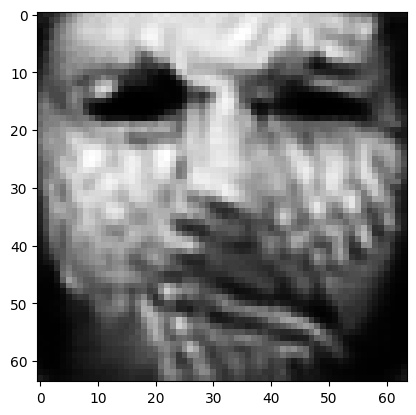

tensor([[3.8189e-04, 9.2169e-01, 2.7701e-04, 7.1332e-03, 3.9187e-04, 1.8833e-03,
         1.2586e-04, 1.2537e-03, 4.4976e-04, 1.0061e-03, 7.6100e-04, 5.9448e-03,
         3.8641e-03, 3.0908e-04, 6.5764e-04, 1.2451e-03, 9.1671e-04, 1.0227e-03,
         2.1437e-03, 8.3660e-04, 5.9337e-04, 3.6459e-05, 3.6550e-03, 2.9380e-04,
         5.1361e-04, 4.5664e-03, 7.7089e-04, 2.6641e-04, 1.3564e-03, 1.0227e-02,
         1.1459e-03, 2.8886e-03, 3.0709e-03, 1.4707e-04, 2.9860e-03, 1.2112e-02,
         6.3843e-04, 1.0738e-03, 5.0516e-04, 8.5935e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08154761046171188
tensor([[3.8191e-04, 9.2171e-01, 2.7701e-04, 7.1317e-03, 3.9185e-04, 1.8833e-03,
         1.2584e-04, 1.2537e-03, 4.4955e-04, 1.0059e-03, 7.6078e-04, 5.9437e-03,
         3.8636e-03, 3.0901e-04, 6.5745e-04, 1.2452e-03, 9.1672e-04, 1.0223e-03,
         2.1438e-03, 8.3651e-04, 5.9319e-04, 3.6457e-05, 3.6541e-03, 2.9382e-04,
         5.1343e-04, 4.5649e-03, 7.7080e-0

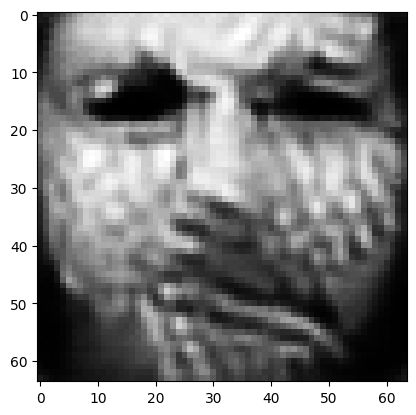

tensor([[3.8188e-04, 9.2178e-01, 2.7696e-04, 7.1268e-03, 3.9174e-04, 1.8831e-03,
         1.2575e-04, 1.2536e-03, 4.4873e-04, 1.0052e-03, 7.5989e-04, 5.9388e-03,
         3.8615e-03, 3.0873e-04, 6.5656e-04, 1.2453e-03, 9.1670e-04, 1.0207e-03,
         2.1438e-03, 8.3589e-04, 5.9234e-04, 3.6438e-05, 3.6510e-03, 2.9386e-04,
         5.1279e-04, 4.5602e-03, 7.7029e-04, 2.6624e-04, 1.3545e-03, 1.0213e-02,
         1.1449e-03, 2.8846e-03, 3.0671e-03, 1.4691e-04, 2.9811e-03, 1.2091e-02,
         6.3835e-04, 1.0725e-03, 5.0436e-04, 8.5873e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08145058900117874
tensor([[3.8186e-04, 9.2180e-01, 2.7694e-04, 7.1259e-03, 3.9171e-04, 1.8830e-03,
         1.2572e-04, 1.2535e-03, 4.4853e-04, 1.0050e-03, 7.5967e-04, 5.9375e-03,
         3.8610e-03, 3.0867e-04, 6.5633e-04, 1.2453e-03, 9.1669e-04, 1.0203e-03,
         2.1438e-03, 8.3571e-04, 5.9211e-04, 3.6432e-05, 3.6503e-03, 2.9387e-04,
         5.1264e-04, 4.5593e-03, 7.7014e-0

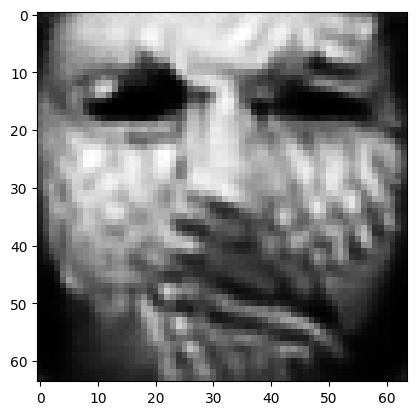

tensor([[3.8184e-04, 9.2186e-01, 2.7690e-04, 7.1214e-03, 3.9161e-04, 1.8828e-03,
         1.2563e-04, 1.2534e-03, 4.4776e-04, 1.0044e-03, 7.5882e-04, 5.9331e-03,
         3.8590e-03, 3.0840e-04, 6.5550e-04, 1.2455e-03, 9.1669e-04, 1.0187e-03,
         2.1438e-03, 8.3516e-04, 5.9133e-04, 3.6416e-05, 3.6472e-03, 2.9392e-04,
         5.1202e-04, 4.5547e-03, 7.6965e-04, 2.6607e-04, 1.3527e-03, 1.0199e-02,
         1.1439e-03, 2.8807e-03, 3.0632e-03, 1.4675e-04, 2.9764e-03, 1.2071e-02,
         6.3825e-04, 1.0713e-03, 5.0359e-04, 8.5809e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08135861158370972
tensor([[3.8181e-04, 9.2188e-01, 2.7688e-04, 7.1205e-03, 3.9157e-04, 1.8827e-03,
         1.2560e-04, 1.2533e-03, 4.4757e-04, 1.0042e-03, 7.5860e-04, 5.9319e-03,
         3.8585e-03, 3.0834e-04, 6.5528e-04, 1.2455e-03, 9.1667e-04, 1.0183e-03,
         2.1438e-03, 8.3497e-04, 5.9111e-04, 3.6410e-05, 3.6466e-03, 2.9392e-04,
         5.1189e-04, 4.5538e-03, 7.6950e-0

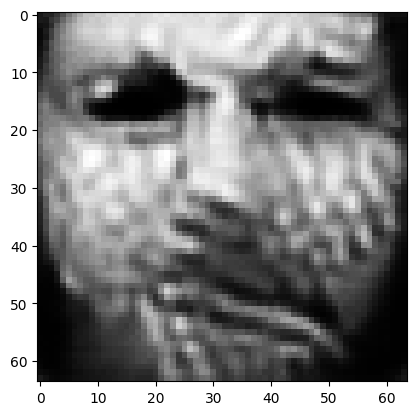

tensor([[3.8174e-04, 9.2194e-01, 2.7682e-04, 7.1164e-03, 3.9144e-04, 1.8823e-03,
         1.2550e-04, 1.2531e-03, 4.4684e-04, 1.0035e-03, 7.5775e-04, 5.9274e-03,
         3.8566e-03, 3.0809e-04, 6.5442e-04, 1.2455e-03, 9.1662e-04, 1.0168e-03,
         2.1436e-03, 8.3432e-04, 5.9030e-04, 3.6389e-05, 3.6441e-03, 2.9393e-04,
         5.1132e-04, 4.5501e-03, 7.6897e-04, 2.6591e-04, 1.3508e-03, 1.0185e-02,
         1.1431e-03, 2.8768e-03, 3.0592e-03, 1.4660e-04, 2.9720e-03, 1.2055e-02,
         6.3816e-04, 1.0701e-03, 5.0283e-04, 8.5739e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0812714546918869
tensor([[3.8172e-04, 9.2196e-01, 2.7680e-04, 7.1156e-03, 3.9140e-04, 1.8822e-03,
         1.2547e-04, 1.2531e-03, 4.4666e-04, 1.0033e-03, 7.5754e-04, 5.9262e-03,
         3.8561e-03, 3.0803e-04, 6.5422e-04, 1.2454e-03, 9.1660e-04, 1.0164e-03,
         2.1436e-03, 8.3412e-04, 5.9010e-04, 3.6384e-05, 3.6435e-03, 2.9393e-04,
         5.1119e-04, 4.5493e-03, 7.6884e-04

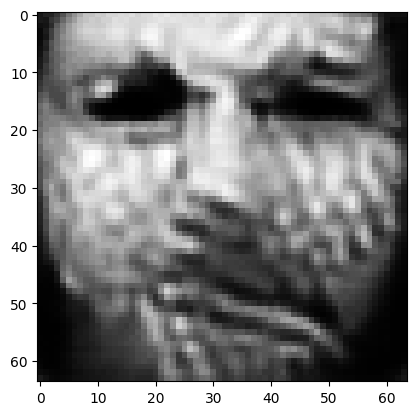

tensor([[3.8166e-04, 9.2202e-01, 2.7674e-04, 7.1114e-03, 3.9128e-04, 1.8818e-03,
         1.2538e-04, 1.2529e-03, 4.4597e-04, 1.0027e-03, 7.5675e-04, 5.9221e-03,
         3.8543e-03, 3.0780e-04, 6.5348e-04, 1.2454e-03, 9.1653e-04, 1.0150e-03,
         2.1435e-03, 8.3354e-04, 5.8935e-04, 3.6366e-05, 3.6411e-03, 2.9395e-04,
         5.1067e-04, 4.5458e-03, 7.6835e-04, 2.6577e-04, 1.3491e-03, 1.0173e-02,
         1.1423e-03, 2.8734e-03, 3.0556e-03, 1.4647e-04, 2.9677e-03, 1.2039e-02,
         6.3805e-04, 1.0690e-03, 5.0212e-04, 8.5669e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08118990808725357
tensor([[3.8166e-04, 9.2203e-01, 2.7673e-04, 7.1107e-03, 3.9124e-04, 1.8817e-03,
         1.2536e-04, 1.2528e-03, 4.4579e-04, 1.0025e-03, 7.5654e-04, 5.9210e-03,
         3.8539e-03, 3.0775e-04, 6.5327e-04, 1.2454e-03, 9.1654e-04, 1.0146e-03,
         2.1435e-03, 8.3337e-04, 5.8916e-04, 3.6361e-05, 3.6405e-03, 2.9395e-04,
         5.1054e-04, 4.5449e-03, 7.6824e-0

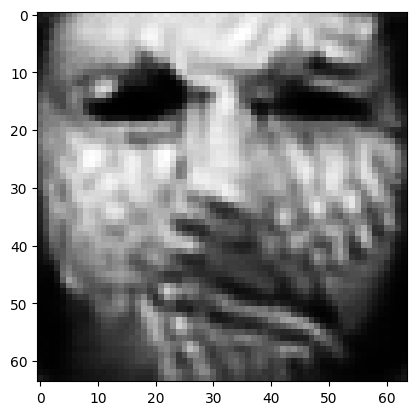

tensor([[3.8157e-04, 9.2209e-01, 2.7667e-04, 7.1071e-03, 3.9110e-04, 1.8812e-03,
         1.2526e-04, 1.2526e-03, 4.4512e-04, 1.0019e-03, 7.5574e-04, 5.9168e-03,
         3.8521e-03, 3.0753e-04, 6.5248e-04, 1.2453e-03, 9.1647e-04, 1.0132e-03,
         2.1434e-03, 8.3268e-04, 5.8839e-04, 3.6339e-05, 3.6384e-03, 2.9395e-04,
         5.1004e-04, 4.5419e-03, 7.6773e-04, 2.6564e-04, 1.3475e-03, 1.0160e-02,
         1.1416e-03, 2.8698e-03, 3.0519e-03, 1.4633e-04, 2.9635e-03, 1.2024e-02,
         6.3795e-04, 1.0679e-03, 5.0141e-04, 8.5595e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08111076802015305
tensor([[3.8155e-04, 9.2211e-01, 2.7666e-04, 7.1064e-03, 3.9106e-04, 1.8811e-03,
         1.2523e-04, 1.2525e-03, 4.4495e-04, 1.0017e-03, 7.5555e-04, 5.9158e-03,
         3.8517e-03, 3.0748e-04, 6.5228e-04, 1.2453e-03, 9.1646e-04, 1.0128e-03,
         2.1434e-03, 8.3252e-04, 5.8821e-04, 3.6334e-05, 3.6379e-03, 2.9394e-04,
         5.0992e-04, 4.5411e-03, 7.6761e-0

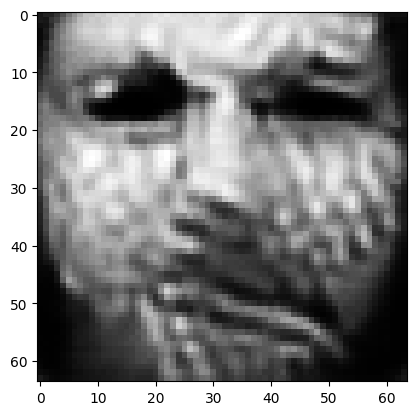

tensor([[3.8147e-04, 9.2216e-01, 2.7660e-04, 7.1031e-03, 3.9092e-04, 1.8806e-03,
         1.2514e-04, 1.2523e-03, 4.4430e-04, 1.0011e-03, 7.5478e-04, 5.9117e-03,
         3.8501e-03, 3.0728e-04, 6.5152e-04, 1.2451e-03, 9.1641e-04, 1.0115e-03,
         2.1432e-03, 8.3184e-04, 5.8747e-04, 3.6313e-05, 3.6360e-03, 2.9394e-04,
         5.0946e-04, 4.5383e-03, 7.6713e-04, 2.6551e-04, 1.3459e-03, 1.0148e-02,
         1.1410e-03, 2.8664e-03, 3.0483e-03, 1.4619e-04, 2.9596e-03, 1.2010e-02,
         6.3786e-04, 1.0669e-03, 5.0074e-04, 8.5525e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0810357928276062
tensor([[3.8145e-04, 9.2217e-01, 2.7658e-04, 7.1023e-03, 3.9089e-04, 1.8806e-03,
         1.2512e-04, 1.2523e-03, 4.4415e-04, 1.0009e-03, 7.5459e-04, 5.9107e-03,
         3.8497e-03, 3.0723e-04, 6.5134e-04, 1.2451e-03, 9.1641e-04, 1.0112e-03,
         2.1432e-03, 8.3168e-04, 5.8730e-04, 3.6307e-05, 3.6355e-03, 2.9394e-04,
         5.0935e-04, 4.5376e-03, 7.6702e-04

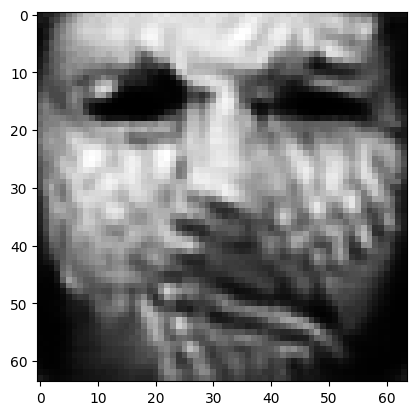

tensor([[3.8138e-04, 9.2223e-01, 2.7652e-04, 7.0992e-03, 3.9076e-04, 1.8801e-03,
         1.2503e-04, 1.2520e-03, 4.4353e-04, 1.0003e-03, 7.5387e-04, 5.9068e-03,
         3.8481e-03, 3.0704e-04, 6.5063e-04, 1.2450e-03, 9.1636e-04, 1.0099e-03,
         2.1430e-03, 8.3105e-04, 5.8660e-04, 3.6288e-05, 3.6338e-03, 2.9395e-04,
         5.0891e-04, 4.5349e-03, 7.6654e-04, 2.6539e-04, 1.3443e-03, 1.0136e-02,
         1.1404e-03, 2.8632e-03, 3.0448e-03, 1.4606e-04, 2.9559e-03, 1.1997e-02,
         6.3779e-04, 1.0659e-03, 5.0008e-04, 8.5457e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08096400648355484
tensor([[3.8136e-04, 9.2224e-01, 2.7651e-04, 7.0983e-03, 3.9074e-04, 1.8800e-03,
         1.2501e-04, 1.2520e-03, 4.4338e-04, 1.0001e-03, 7.5369e-04, 5.9058e-03,
         3.8478e-03, 3.0699e-04, 6.5046e-04, 1.2450e-03, 9.1636e-04, 1.0096e-03,
         2.1430e-03, 8.3091e-04, 5.8645e-04, 3.6283e-05, 3.6333e-03, 2.9395e-04,
         5.0880e-04, 4.5341e-03, 7.6645e-0

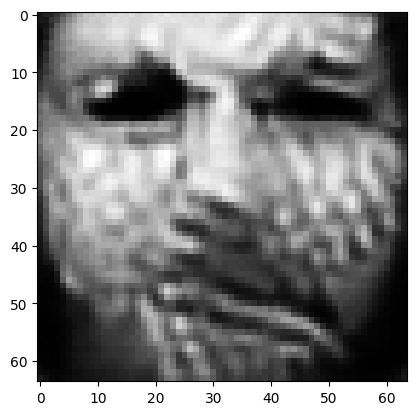

tensor([[3.8129e-04, 9.2229e-01, 2.7646e-04, 7.0951e-03, 3.9062e-04, 1.8796e-03,
         1.2493e-04, 1.2518e-03, 4.4279e-04, 9.9954e-04, 7.5299e-04, 5.9020e-03,
         3.8463e-03, 3.0680e-04, 6.4979e-04, 1.2449e-03, 9.1632e-04, 1.0084e-03,
         2.1429e-03, 8.3030e-04, 5.8580e-04, 3.6265e-05, 3.6317e-03, 2.9396e-04,
         5.0837e-04, 4.5315e-03, 7.6601e-04, 2.6528e-04, 1.3428e-03, 1.0125e-02,
         1.1398e-03, 2.8601e-03, 3.0415e-03, 1.4594e-04, 2.9523e-03, 1.1985e-02,
         6.3773e-04, 1.0650e-03, 4.9945e-04, 8.5393e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0808950737118721
tensor([[3.8126e-04, 9.2230e-01, 2.7644e-04, 7.0943e-03, 3.9058e-04, 1.8795e-03,
         1.2490e-04, 1.2517e-03, 4.4263e-04, 9.9938e-04, 7.5282e-04, 5.9011e-03,
         3.8459e-03, 3.0676e-04, 6.4961e-04, 1.2448e-03, 9.1630e-04, 1.0081e-03,
         2.1428e-03, 8.3013e-04, 5.8562e-04, 3.6260e-05, 3.6313e-03, 2.9396e-04,
         5.0827e-04, 4.5311e-03, 7.6588e-04

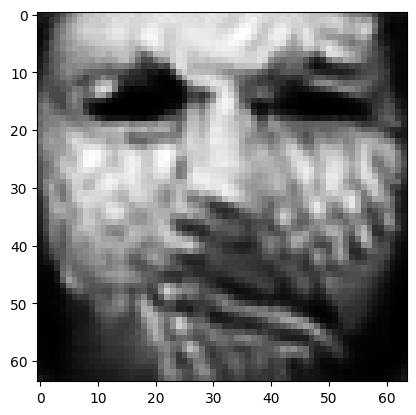

tensor([[3.8117e-04, 9.2235e-01, 2.7638e-04, 7.0911e-03, 3.9046e-04, 1.8790e-03,
         1.2482e-04, 1.2514e-03, 4.4207e-04, 9.9879e-04, 7.5216e-04, 5.8975e-03,
         3.8445e-03, 3.0659e-04, 6.4898e-04, 1.2447e-03, 9.1625e-04, 1.0069e-03,
         2.1426e-03, 8.2955e-04, 5.8500e-04, 3.6243e-05, 3.6298e-03, 2.9396e-04,
         5.0788e-04, 4.5287e-03, 7.6545e-04, 2.6516e-04, 1.3414e-03, 1.0114e-02,
         1.1392e-03, 2.8573e-03, 3.0384e-03, 1.4582e-04, 2.9488e-03, 1.1974e-02,
         6.3769e-04, 1.0641e-03, 4.9884e-04, 8.5328e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08082998543977737
tensor([[3.8114e-04, 9.2236e-01, 2.7636e-04, 7.0904e-03, 3.9042e-04, 1.8788e-03,
         1.2480e-04, 1.2513e-03, 4.4194e-04, 9.9863e-04, 7.5199e-04, 5.8966e-03,
         3.8441e-03, 3.0655e-04, 6.4881e-04, 1.2446e-03, 9.1623e-04, 1.0066e-03,
         2.1425e-03, 8.2938e-04, 5.8484e-04, 3.6237e-05, 3.6296e-03, 2.9395e-04,
         5.0779e-04, 4.5283e-03, 7.6532e-0

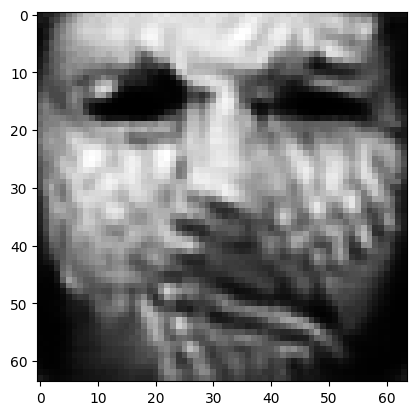

tensor([[3.8104e-04, 9.2241e-01, 2.7630e-04, 7.0873e-03, 3.9030e-04, 1.8783e-03,
         1.2472e-04, 1.2510e-03, 4.4142e-04, 9.9806e-04, 7.5136e-04, 5.8932e-03,
         3.8428e-03, 3.0639e-04, 6.4819e-04, 1.2444e-03, 9.1616e-04, 1.0055e-03,
         2.1422e-03, 8.2882e-04, 5.8426e-04, 3.6220e-05, 3.6283e-03, 2.9394e-04,
         5.0741e-04, 4.5263e-03, 7.6492e-04, 2.6505e-04, 1.3399e-03, 1.0104e-02,
         1.1387e-03, 2.8546e-03, 3.0354e-03, 1.4572e-04, 2.9455e-03, 1.1964e-02,
         6.3766e-04, 1.0632e-03, 4.9826e-04, 8.5267e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08076929301023483
tensor([[3.8103e-04, 9.2242e-01, 2.7629e-04, 7.0866e-03, 3.9027e-04, 1.8782e-03,
         1.2470e-04, 1.2510e-03, 4.4129e-04, 9.9792e-04, 7.5121e-04, 5.8924e-03,
         3.8425e-03, 3.0635e-04, 6.4805e-04, 1.2444e-03, 9.1615e-04, 1.0053e-03,
         2.1422e-03, 8.2869e-04, 5.8412e-04, 3.6216e-05, 3.6279e-03, 2.9394e-04,
         5.0732e-04, 4.5257e-03, 7.6483e-0

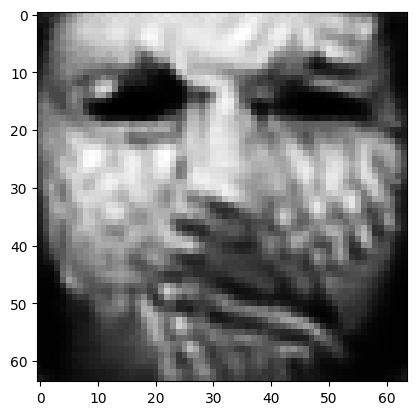

tensor([[3.8091e-04, 9.2246e-01, 2.7621e-04, 7.0838e-03, 3.9013e-04, 1.8776e-03,
         1.2462e-04, 1.2507e-03, 4.4079e-04, 9.9732e-04, 7.5059e-04, 5.8890e-03,
         3.8412e-03, 3.0620e-04, 6.4743e-04, 1.2441e-03, 9.1605e-04, 1.0042e-03,
         2.1419e-03, 8.2808e-04, 5.8353e-04, 3.6197e-05, 3.6268e-03, 2.9392e-04,
         5.0698e-04, 4.5240e-03, 7.6439e-04, 2.6494e-04, 1.3386e-03, 1.0094e-02,
         1.1383e-03, 2.8520e-03, 3.0326e-03, 1.4561e-04, 2.9424e-03, 1.1954e-02,
         6.3761e-04, 1.0624e-03, 4.9770e-04, 8.5204e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08071079105138779
tensor([[3.8090e-04, 9.2247e-01, 2.7620e-04, 7.0831e-03, 3.9011e-04, 1.8775e-03,
         1.2461e-04, 1.2506e-03, 4.4067e-04, 9.9719e-04, 7.5044e-04, 5.8882e-03,
         3.8409e-03, 3.0616e-04, 6.4730e-04, 1.2441e-03, 9.1605e-04, 1.0040e-03,
         2.1418e-03, 8.2796e-04, 5.8340e-04, 3.6193e-05, 3.6265e-03, 2.9392e-04,
         5.0689e-04, 4.5234e-03, 7.6430e-0

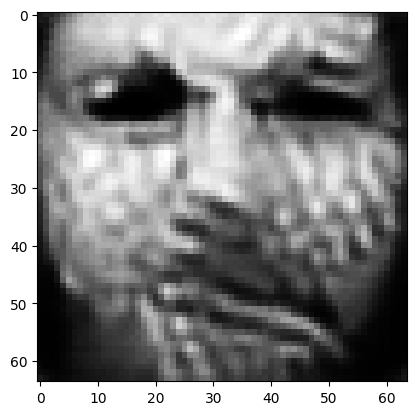

tensor([[3.8081e-04, 9.2251e-01, 2.7613e-04, 7.0804e-03, 3.8999e-04, 1.8770e-03,
         1.2453e-04, 1.2503e-03, 4.4018e-04, 9.9659e-04, 7.4984e-04, 5.8849e-03,
         3.8396e-03, 3.0602e-04, 6.4674e-04, 1.2439e-03, 9.1597e-04, 1.0030e-03,
         2.1416e-03, 8.2740e-04, 5.8284e-04, 3.6174e-05, 3.6254e-03, 2.9391e-04,
         5.0656e-04, 4.5215e-03, 7.6390e-04, 2.6484e-04, 1.3373e-03, 1.0085e-02,
         1.1378e-03, 2.8495e-03, 3.0298e-03, 1.4551e-04, 2.9394e-03, 1.1945e-02,
         6.3756e-04, 1.0616e-03, 4.9717e-04, 8.5143e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08065415918827057
tensor([[3.8077e-04, 9.2252e-01, 2.7611e-04, 7.0799e-03, 3.8996e-04, 1.8768e-03,
         1.2451e-04, 1.2502e-03, 4.4007e-04, 9.9644e-04, 7.4969e-04, 5.8840e-03,
         3.8393e-03, 3.0598e-04, 6.4660e-04, 1.2438e-03, 9.1594e-04, 1.0028e-03,
         2.1415e-03, 8.2724e-04, 5.8269e-04, 3.6169e-05, 3.6252e-03, 2.9390e-04,
         5.0649e-04, 4.5212e-03, 7.6378e-0

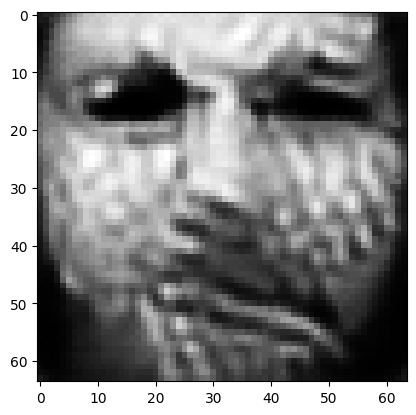

tensor([[3.8072e-04, 9.2256e-01, 2.7607e-04, 7.0771e-03, 3.8986e-04, 1.8764e-03,
         1.2445e-04, 1.2501e-03, 4.3961e-04, 9.9595e-04, 7.4915e-04, 5.8812e-03,
         3.8381e-03, 3.0584e-04, 6.4613e-04, 1.2437e-03, 9.1590e-04, 1.0019e-03,
         2.1413e-03, 8.2678e-04, 5.8222e-04, 3.6155e-05, 3.6239e-03, 2.9391e-04,
         5.0616e-04, 4.5191e-03, 7.6345e-04, 2.6476e-04, 1.3361e-03, 1.0076e-02,
         1.1373e-03, 2.8472e-03, 3.0273e-03, 1.4541e-04, 2.9366e-03, 1.1936e-02,
         6.3752e-04, 1.0608e-03, 4.9666e-04, 8.5087e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08060082048177719
tensor([[3.8069e-04, 9.2257e-01, 2.7605e-04, 7.0765e-03, 3.8983e-04, 1.8763e-03,
         1.2444e-04, 1.2500e-03, 4.3950e-04, 9.9580e-04, 7.4901e-04, 5.8804e-03,
         3.8378e-03, 3.0580e-04, 6.4600e-04, 1.2436e-03, 9.1587e-04, 1.0017e-03,
         2.1412e-03, 8.2664e-04, 5.8208e-04, 3.6151e-05, 3.6237e-03, 2.9390e-04,
         5.0609e-04, 4.5187e-03, 7.6334e-0

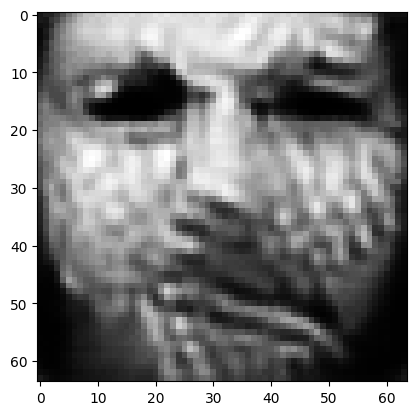

tensor([[3.8064e-04, 9.2261e-01, 2.7601e-04, 7.0739e-03, 3.8974e-04, 1.8760e-03,
         1.2438e-04, 1.2498e-03, 4.3907e-04, 9.9536e-04, 7.4851e-04, 5.8777e-03,
         3.8367e-03, 3.0567e-04, 6.4555e-04, 1.2436e-03, 9.1584e-04, 1.0009e-03,
         2.1411e-03, 8.2623e-04, 5.8164e-04, 3.6138e-05, 3.6225e-03, 2.9391e-04,
         5.0576e-04, 4.5167e-03, 7.6303e-04, 2.6468e-04, 1.3350e-03, 1.0068e-02,
         1.1369e-03, 2.8450e-03, 3.0249e-03, 1.4532e-04, 2.9339e-03, 1.1928e-02,
         6.3747e-04, 1.0601e-03, 4.9620e-04, 8.5038e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0805506631731987
tensor([[3.8061e-04, 9.2262e-01, 2.7598e-04, 7.0733e-03, 3.8971e-04, 1.8757e-03,
         1.2436e-04, 1.2497e-03, 4.3897e-04, 9.9521e-04, 7.4837e-04, 5.8770e-03,
         3.8364e-03, 3.0564e-04, 6.4542e-04, 1.2435e-03, 9.1580e-04, 1.0006e-03,
         2.1410e-03, 8.2609e-04, 5.8151e-04, 3.6134e-05, 3.6223e-03, 2.9389e-04,
         5.0570e-04, 4.5164e-03, 7.6292e-04

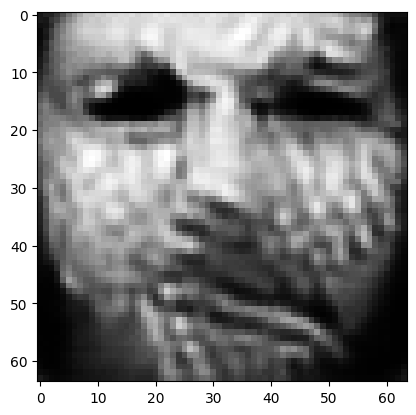

tensor([[3.8054e-04, 9.2265e-01, 2.7594e-04, 7.0707e-03, 3.8961e-04, 1.8753e-03,
         1.2430e-04, 1.2495e-03, 4.3856e-04, 9.9478e-04, 7.4789e-04, 5.8745e-03,
         3.8352e-03, 3.0550e-04, 6.4497e-04, 1.2434e-03, 9.1573e-04, 9.9977e-04,
         2.1409e-03, 8.2566e-04, 5.8108e-04, 3.6122e-05, 3.6212e-03, 2.9388e-04,
         5.0538e-04, 4.5147e-03, 7.6261e-04, 2.6459e-04, 1.3339e-03, 1.0061e-02,
         1.1365e-03, 2.8429e-03, 3.0226e-03, 1.4524e-04, 2.9313e-03, 1.1920e-02,
         6.3744e-04, 1.0594e-03, 4.9575e-04, 8.4991e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08050303906202316
tensor([[3.8051e-04, 9.2266e-01, 2.7592e-04, 7.0701e-03, 3.8957e-04, 1.8751e-03,
         1.2428e-04, 1.2494e-03, 4.3846e-04, 9.9464e-04, 7.4776e-04, 5.8738e-03,
         3.8349e-03, 3.0547e-04, 6.4484e-04, 1.2433e-03, 9.1570e-04, 9.9953e-04,
         2.1408e-03, 8.2552e-04, 5.8096e-04, 3.6118e-05, 3.6210e-03, 2.9387e-04,
         5.0532e-04, 4.5145e-03, 7.6251e-0

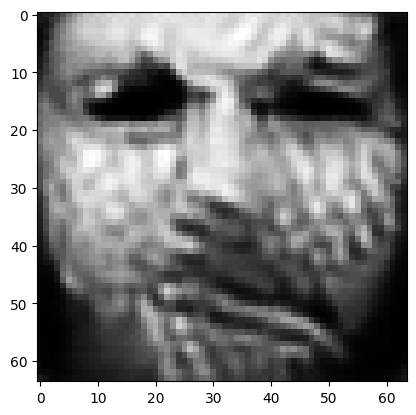

tensor([[3.8041e-04, 9.2269e-01, 2.7586e-04, 7.0678e-03, 3.8946e-04, 1.8746e-03,
         1.2422e-04, 1.2491e-03, 4.3808e-04, 9.9415e-04, 7.4729e-04, 5.8712e-03,
         3.8338e-03, 3.0535e-04, 6.4439e-04, 1.2430e-03, 9.1559e-04, 9.9870e-04,
         2.1405e-03, 8.2504e-04, 5.8051e-04, 3.6104e-05, 3.6201e-03, 2.9384e-04,
         5.0506e-04, 4.5132e-03, 7.6216e-04, 2.6450e-04, 1.3329e-03, 1.0054e-02,
         1.1362e-03, 2.8410e-03, 3.0205e-03, 1.4516e-04, 2.9286e-03, 1.1913e-02,
         6.3740e-04, 1.0587e-03, 4.9531e-04, 8.4941e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08045794814825058
tensor([[3.8040e-04, 9.2270e-01, 2.7585e-04, 7.0673e-03, 3.8945e-04, 1.8745e-03,
         1.2421e-04, 1.2491e-03, 4.3799e-04, 9.9405e-04, 7.4717e-04, 5.8706e-03,
         3.8336e-03, 3.0532e-04, 6.4429e-04, 1.2430e-03, 9.1558e-04, 9.9853e-04,
         2.1404e-03, 8.2495e-04, 5.8042e-04, 3.6101e-05, 3.6199e-03, 2.9384e-04,
         5.0499e-04, 4.5128e-03, 7.6210e-0

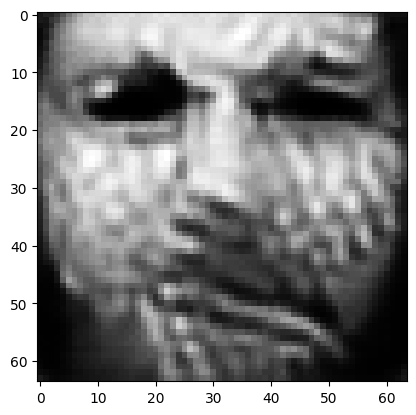

tensor([[3.8028e-04, 9.2273e-01, 2.7577e-04, 7.0652e-03, 3.8933e-04, 1.8739e-03,
         1.2414e-04, 1.2487e-03, 4.3764e-04, 9.9355e-04, 7.4672e-04, 5.8681e-03,
         3.8325e-03, 3.0522e-04, 6.4386e-04, 1.2427e-03, 9.1544e-04, 9.9775e-04,
         2.1400e-03, 8.2444e-04, 5.7999e-04, 3.6087e-05, 3.6192e-03, 2.9380e-04,
         5.0475e-04, 4.5118e-03, 7.6174e-04, 2.6441e-04, 1.3319e-03, 1.0048e-02,
         1.1358e-03, 2.8392e-03, 3.0184e-03, 1.4509e-04, 2.9262e-03, 1.1907e-02,
         6.3737e-04, 1.0581e-03, 4.9489e-04, 8.4895e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08041581511497498
tensor([[3.8025e-04, 9.2274e-01, 2.7575e-04, 7.0647e-03, 3.8930e-04, 1.8737e-03,
         1.2413e-04, 1.2486e-03, 4.3756e-04, 9.9342e-04, 7.4660e-04, 5.8675e-03,
         3.8322e-03, 3.0519e-04, 6.4375e-04, 1.2426e-03, 9.1540e-04, 9.9756e-04,
         2.1398e-03, 8.2431e-04, 5.7988e-04, 3.6082e-05, 3.6191e-03, 2.9378e-04,
         5.0470e-04, 4.5117e-03, 7.6165e-0

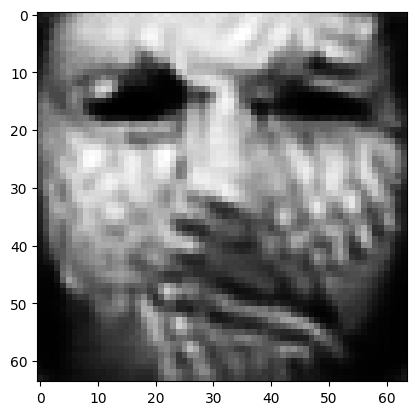

tensor([[3.8015e-04, 9.2277e-01, 2.7568e-04, 7.0626e-03, 3.8920e-04, 1.8731e-03,
         1.2407e-04, 1.2483e-03, 4.3723e-04, 9.9298e-04, 7.4615e-04, 5.8652e-03,
         3.8312e-03, 3.0508e-04, 6.4333e-04, 1.2423e-03, 9.1529e-04, 9.9680e-04,
         2.1395e-03, 8.2385e-04, 5.7948e-04, 3.6069e-05, 3.6184e-03, 2.9375e-04,
         5.0446e-04, 4.5107e-03, 7.6133e-04, 2.6432e-04, 1.3309e-03, 1.0042e-02,
         1.1355e-03, 2.8374e-03, 3.0164e-03, 1.4502e-04, 2.9239e-03, 1.1901e-02,
         6.3735e-04, 1.0575e-03, 4.9449e-04, 8.4852e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08037512004375458
tensor([[3.8013e-04, 9.2278e-01, 2.7567e-04, 7.0621e-03, 3.8918e-04, 1.8731e-03,
         1.2405e-04, 1.2482e-03, 4.3715e-04, 9.9289e-04, 7.4605e-04, 5.8647e-03,
         3.8310e-03, 3.0505e-04, 6.4323e-04, 1.2423e-03, 9.1527e-04, 9.9663e-04,
         2.1394e-03, 8.2376e-04, 5.7940e-04, 3.6067e-05, 3.6181e-03, 2.9374e-04,
         5.0439e-04, 4.5103e-03, 7.6127e-0

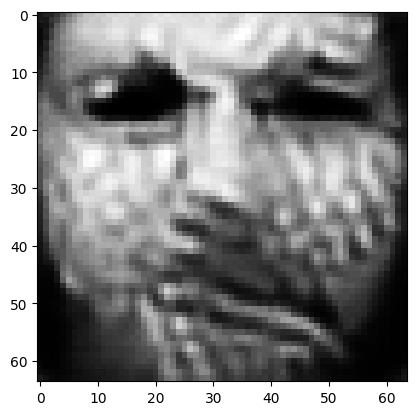

tensor([[3.8003e-04, 9.2281e-01, 2.7561e-04, 7.0600e-03, 3.8908e-04, 1.8725e-03,
         1.2400e-04, 1.2479e-03, 4.3683e-04, 9.9247e-04, 7.4563e-04, 5.8625e-03,
         3.8300e-03, 3.0495e-04, 6.4283e-04, 1.2420e-03, 9.1517e-04, 9.9590e-04,
         2.1391e-03, 8.2333e-04, 5.7901e-04, 3.6055e-05, 3.6174e-03, 2.9371e-04,
         5.0416e-04, 4.5094e-03, 7.6097e-04, 2.6424e-04, 1.3300e-03, 1.0036e-02,
         1.1352e-03, 2.8356e-03, 3.0146e-03, 1.4496e-04, 2.9216e-03, 1.1895e-02,
         6.3732e-04, 1.0569e-03, 4.9413e-04, 8.4815e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08033661544322968
tensor([[3.8000e-04, 9.2281e-01, 2.7559e-04, 7.0596e-03, 3.8904e-04, 1.8723e-03,
         1.2398e-04, 1.2478e-03, 4.3675e-04, 9.9234e-04, 7.4552e-04, 5.8619e-03,
         3.8298e-03, 3.0492e-04, 6.4272e-04, 1.2419e-03, 9.1512e-04, 9.9570e-04,
         2.1389e-03, 8.2320e-04, 5.7890e-04, 3.6051e-05, 3.6173e-03, 2.9369e-04,
         5.0411e-04, 4.5093e-03, 7.6087e-0

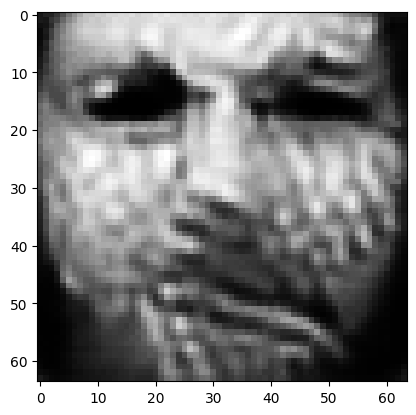

tensor([[3.7992e-04, 9.2284e-01, 2.7554e-04, 7.0576e-03, 3.8896e-04, 1.8718e-03,
         1.2393e-04, 1.2475e-03, 4.3645e-04, 9.9196e-04, 7.4512e-04, 5.8598e-03,
         3.8288e-03, 3.0482e-04, 6.4234e-04, 1.2417e-03, 9.1504e-04, 9.9500e-04,
         2.1387e-03, 8.2281e-04, 5.7854e-04, 3.6040e-05, 3.6165e-03, 2.9367e-04,
         5.0389e-04, 4.5083e-03, 7.6059e-04, 2.6416e-04, 1.3291e-03, 1.0031e-02,
         1.1349e-03, 2.8340e-03, 3.0128e-03, 1.4490e-04, 2.9195e-03, 1.1889e-02,
         6.3730e-04, 1.0563e-03, 4.9378e-04, 8.4776e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08029942959547043
tensor([[3.7990e-04, 9.2285e-01, 2.7552e-04, 7.0571e-03, 3.8894e-04, 1.8718e-03,
         1.2391e-04, 1.2474e-03, 4.3637e-04, 9.9187e-04, 7.4502e-04, 5.8593e-03,
         3.8286e-03, 3.0480e-04, 6.4224e-04, 1.2417e-03, 9.1502e-04, 9.9484e-04,
         2.1386e-03, 8.2272e-04, 5.7846e-04, 3.6037e-05, 3.6163e-03, 2.9366e-04,
         5.0383e-04, 4.5080e-03, 7.6052e-0

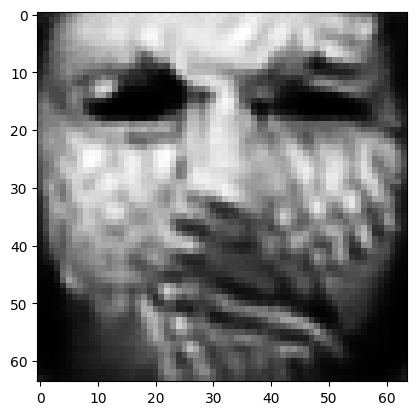

tensor([[3.7982e-04, 9.2287e-01, 2.7547e-04, 7.0553e-03, 3.8885e-04, 1.8713e-03,
         1.2386e-04, 1.2471e-03, 4.3608e-04, 9.9150e-04, 7.4463e-04, 5.8573e-03,
         3.8278e-03, 3.0470e-04, 6.4187e-04, 1.2415e-03, 9.1494e-04, 9.9418e-04,
         2.1383e-03, 8.2234e-04, 5.7811e-04, 3.6026e-05, 3.6156e-03, 2.9364e-04,
         5.0361e-04, 4.5071e-03, 7.6026e-04, 2.6409e-04, 1.3282e-03, 1.0026e-02,
         1.1347e-03, 2.8324e-03, 3.0111e-03, 1.4484e-04, 2.9174e-03, 1.1883e-02,
         6.3729e-04, 1.0558e-03, 4.9343e-04, 8.4743e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08026356995105743
tensor([[3.7979e-04, 9.2288e-01, 2.7545e-04, 7.0548e-03, 3.8883e-04, 1.8711e-03,
         1.2385e-04, 1.2470e-03, 4.3601e-04, 9.9139e-04, 7.4453e-04, 5.8568e-03,
         3.8276e-03, 3.0468e-04, 6.4176e-04, 1.2414e-03, 9.1491e-04, 9.9399e-04,
         2.1382e-03, 8.2222e-04, 5.7801e-04, 3.6022e-05, 3.6155e-03, 2.9363e-04,
         5.0357e-04, 4.5070e-03, 7.6017e-0

In [15]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=1)

tensor([[3.4713e-03, 1.2601e-03, 7.9833e-03, 5.4270e-03, 8.8898e-02, 8.4707e-04,
         1.6127e-03, 1.4663e-03, 1.4164e-03, 1.3463e-04, 4.2232e-04, 1.0595e-03,
         9.2519e-03, 2.0949e-02, 2.3434e-03, 6.2844e-04, 2.3632e-02, 5.2971e-03,
         2.1626e-03, 8.3675e-04, 1.5805e-02, 4.6692e-03, 2.9303e-01, 2.5239e-03,
         1.1666e-01, 2.3455e-02, 2.2279e-03, 3.2929e-03, 9.4658e-04, 5.7554e-03,
         3.6073e-03, 7.6531e-03, 1.2323e-02, 1.4340e-02, 1.1156e-02, 3.3076e-02,
         2.3484e-01, 2.0808e-02, 9.6893e-03, 5.0422e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  4.8304033279418945


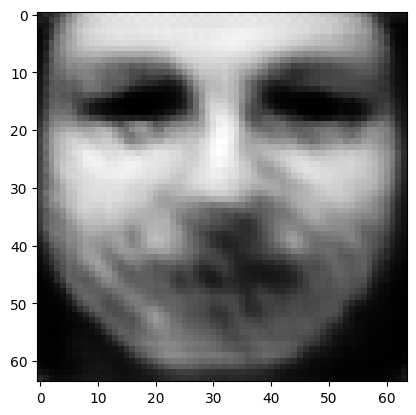

tensor([[0.0052, 0.0013, 0.0872, 0.0136, 0.1036, 0.0033, 0.0090, 0.0053, 0.0051,
         0.0006, 0.0014, 0.0013, 0.0237, 0.0065, 0.0015, 0.0011, 0.0411, 0.0106,
         0.0051, 0.0030, 0.0190, 0.0036, 0.0363, 0.0038, 0.1879, 0.0124, 0.0042,
         0.0095, 0.0330, 0.0139, 0.0087, 0.0025, 0.0392, 0.0284, 0.0173, 0.0098,
         0.0561, 0.0182, 0.1400, 0.0268]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  2.4397616386413574
tensor([[0.0029, 0.0020, 0.0146, 0.0068, 0.1543, 0.0030, 0.0126, 0.0082, 0.0028,
         0.0007, 0.0022, 0.0010, 0.0236, 0.0169, 0.0035, 0.0010, 0.0519, 0.0292,
         0.0032, 0.0044, 0.0123, 0.0020, 0.0345, 0.0051, 0.2850, 0.0077, 0.0029,
         0.0123, 0.0107, 0.0046, 0.0038, 0.0064, 0.0489, 0.0210, 0.0145, 0.0196,
         0.0964, 0.0113, 0.0476, 0.0085]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  4.229848861694336
tensor([[3.8795e-03, 8.0060e-04, 2.1726e-01, 2.7642e-03, 1.3508e-02, 8.3264e-02,
         2

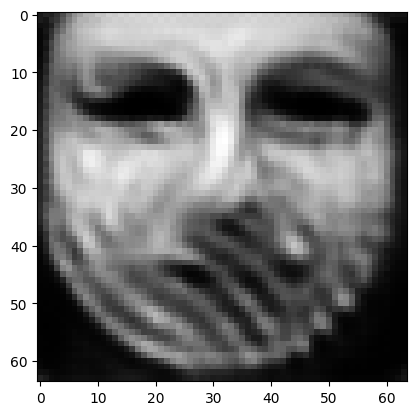

tensor([[1.4179e-03, 1.3047e-04, 7.3346e-01, 1.5376e-03, 3.7596e-03, 5.0978e-02,
         2.2928e-03, 2.6646e-02, 1.3184e-03, 3.8728e-03, 1.8379e-03, 2.3627e-03,
         1.1036e-03, 2.2485e-05, 1.5242e-05, 4.6135e-04, 2.0651e-03, 1.0162e-03,
         5.4132e-04, 4.5348e-03, 5.4605e-04, 6.1237e-04, 1.4768e-05, 1.5602e-04,
         6.9911e-04, 1.3678e-03, 1.0313e-03, 7.4524e-03, 5.3189e-02, 2.3545e-04,
         3.9620e-04, 5.9695e-05, 6.9167e-03, 3.2763e-03, 7.1836e-04, 2.2303e-05,
         5.6487e-04, 2.3035e-03, 4.3235e-02, 3.7824e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.30997684597969055
tensor([[1.1788e-03, 8.9744e-05, 7.7436e-01, 1.2624e-03, 2.9479e-03, 4.3534e-02,
         1.8314e-03, 2.3743e-02, 1.0824e-03, 3.1952e-03, 1.6223e-03, 2.1835e-03,
         8.3167e-04, 1.6683e-05, 1.1136e-05, 3.7738e-04, 1.8125e-03, 8.1298e-04,
         4.4678e-04, 3.7187e-03, 4.4675e-04, 5.3071e-04, 1.1190e-05, 1.3664e-04,
         5.4695e-04, 1.1899e-03, 7.2529e-0

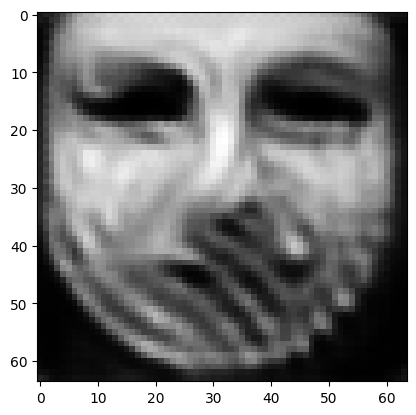

tensor([[8.1493e-04, 3.9827e-05, 8.5253e-01, 8.9298e-04, 1.7978e-03, 2.6875e-02,
         1.1068e-03, 1.5904e-02, 7.7370e-04, 2.0153e-03, 1.0963e-03, 1.7134e-03,
         5.2920e-04, 9.5672e-06, 6.3849e-06, 2.2634e-04, 1.2637e-03, 5.2432e-04,
         2.7671e-04, 2.4936e-03, 3.0302e-04, 3.7334e-04, 6.3715e-06, 1.0029e-04,
         3.3943e-04, 8.4781e-04, 3.4410e-04, 3.5686e-03, 3.1085e-02, 9.5724e-05,
         2.2618e-04, 2.5081e-05, 3.6850e-03, 1.5896e-03, 3.7962e-04, 8.4198e-06,
         2.8795e-04, 1.6534e-03, 2.7382e-02, 1.6809e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.15954554080963135
tensor([[7.6905e-04, 3.6287e-05, 8.6204e-01, 8.9183e-04, 1.7212e-03, 2.4301e-02,
         9.9857e-04, 1.4781e-02, 7.4524e-04, 1.8508e-03, 1.0245e-03, 1.5866e-03,
         5.1291e-04, 9.3522e-06, 5.9627e-06, 2.0762e-04, 1.2372e-03, 4.9077e-04,
         2.5899e-04, 2.2966e-03, 2.9033e-04, 3.5334e-04, 6.1382e-06, 9.7452e-05,
         3.3434e-04, 8.3857e-04, 3.0269e-0

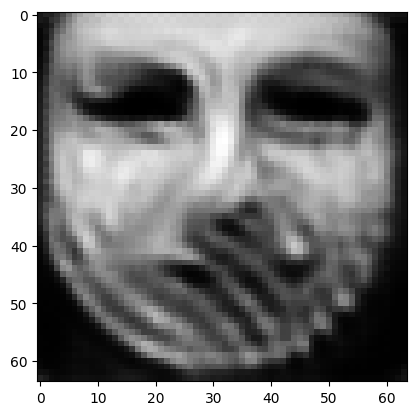

tensor([[6.6914e-04, 2.6398e-05, 8.8703e-01, 8.1673e-04, 1.4470e-03, 1.9085e-02,
         7.6390e-04, 1.2669e-02, 6.0475e-04, 1.4794e-03, 8.4485e-04, 1.3139e-03,
         4.1913e-04, 7.8670e-06, 4.6211e-06, 1.6765e-04, 1.1663e-03, 4.0029e-04,
         2.0968e-04, 1.8321e-03, 2.4429e-04, 3.0098e-04, 4.9193e-06, 9.2094e-05,
         2.9075e-04, 7.7237e-04, 2.0731e-04, 2.9400e-03, 2.4466e-02, 6.9335e-05,
         2.0191e-04, 1.7427e-05, 2.7526e-03, 1.2025e-03, 3.0607e-04, 5.8908e-06,
         2.4192e-04, 1.4153e-03, 2.2728e-02, 1.0780e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.1198742687702179
tensor([[6.4961e-04, 2.4566e-05, 8.9165e-01, 7.8545e-04, 1.3787e-03, 1.8323e-02,
         7.3219e-04, 1.2412e-02, 5.7210e-04, 1.4189e-03, 8.1640e-04, 1.2762e-03,
         3.9377e-04, 7.4333e-06, 4.3231e-06, 1.6089e-04, 1.1506e-03, 3.8341e-04,
         1.9972e-04, 1.7487e-03, 2.3364e-04, 2.9059e-04, 4.6303e-06, 9.0582e-05,
         2.7741e-04, 7.5305e-04, 1.9255e-04

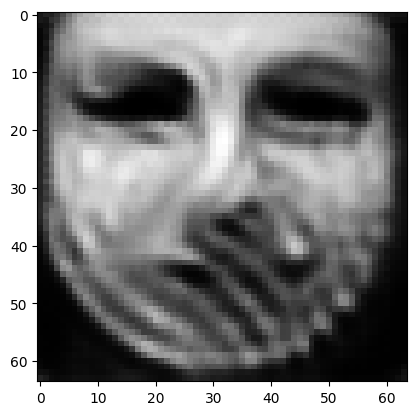

tensor([[5.6486e-04, 2.1034e-05, 9.0759e-01, 7.9764e-04, 1.1707e-03, 1.5227e-02,
         5.6088e-04, 1.0280e-02, 5.1140e-04, 1.2149e-03, 7.2589e-04, 1.1606e-03,
         3.4898e-04, 6.9903e-06, 3.5992e-06, 1.3688e-04, 1.0689e-03, 3.2768e-04,
         1.7420e-04, 1.4184e-03, 2.1085e-04, 2.5195e-04, 4.2122e-06, 8.0651e-05,
         2.4321e-04, 7.3618e-04, 1.5203e-04, 2.5019e-03, 2.0743e-02, 5.7691e-05,
         1.9152e-04, 1.3270e-05, 2.2273e-03, 9.6710e-04, 2.6495e-04, 4.6136e-06,
         2.1594e-04, 1.3143e-03, 1.8248e-02, 8.2574e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.09695945680141449
tensor([[5.5016e-04, 2.0300e-05, 9.1086e-01, 8.0144e-04, 1.1292e-03, 1.4635e-02,
         5.2971e-04, 9.8264e-03, 4.9948e-04, 1.1694e-03, 7.0386e-04, 1.1356e-03,
         3.4242e-04, 6.8637e-06, 3.4707e-06, 1.3216e-04, 1.0452e-03, 3.1696e-04,
         1.6880e-04, 1.3595e-03, 2.0629e-04, 2.4396e-04, 4.1245e-06, 7.8618e-05,
         2.3646e-04, 7.2774e-04, 1.4490e-0

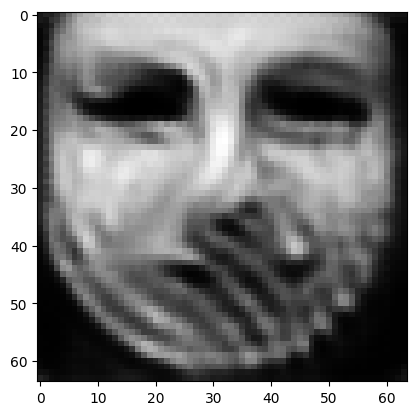

tensor([[4.8371e-04, 1.7513e-05, 9.2238e-01, 8.0200e-04, 9.5513e-04, 1.2243e-02,
         4.1374e-04, 8.3768e-03, 4.6118e-04, 1.0032e-03, 6.1848e-04, 1.0224e-03,
         3.0993e-04, 6.3566e-06, 2.9635e-06, 1.1482e-04, 9.7484e-04, 2.6912e-04,
         1.5143e-04, 1.1485e-03, 1.8974e-04, 2.1377e-04, 3.8135e-06, 7.2880e-05,
         2.1261e-04, 7.1622e-04, 1.1481e-04, 2.1617e-03, 1.7861e-02, 5.0695e-05,
         1.8726e-04, 1.0427e-05, 1.8554e-03, 7.9521e-04, 2.3887e-04, 3.6736e-06,
         1.9248e-04, 1.2034e-03, 1.5684e-02, 6.4797e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.08080019056797028
tensor([[4.7114e-04, 1.6923e-05, 9.2471e-01, 7.9760e-04, 9.1941e-04, 1.1810e-02,
         3.9455e-04, 8.1275e-03, 4.5029e-04, 9.7347e-04, 6.0319e-04, 1.0022e-03,
         3.0010e-04, 6.2133e-06, 2.8589e-06, 1.1159e-04, 9.6099e-04, 2.6145e-04,
         1.4803e-04, 1.1068e-03, 1.8561e-04, 2.0738e-04, 3.7168e-06, 7.1653e-05,
         2.0621e-04, 7.1002e-04, 1.0929e-0

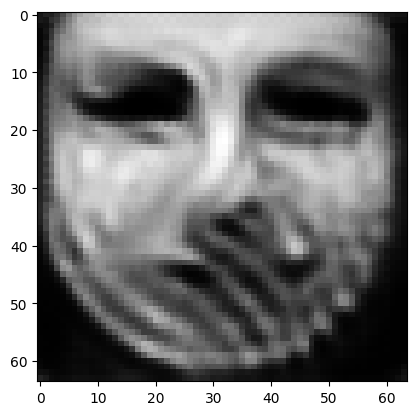

tensor([[4.2074e-04, 1.5221e-05, 9.3253e-01, 8.0687e-04, 8.0655e-04, 1.0334e-02,
         3.2906e-04, 7.2174e-03, 4.1203e-04, 8.6250e-04, 5.5389e-04, 9.3137e-04,
         2.6749e-04, 5.9027e-06, 2.4848e-06, 1.0097e-04, 9.3405e-04, 2.3346e-04,
         1.3836e-04, 9.4143e-04, 1.7303e-04, 1.8480e-04, 3.4994e-06, 6.7789e-05,
         1.8721e-04, 7.0870e-04, 9.1115e-05, 1.9505e-03, 1.6306e-02, 4.5643e-05,
         1.8164e-04, 8.7322e-06, 1.5836e-03, 6.7419e-04, 2.1636e-04, 3.1130e-06,
         1.8025e-04, 1.1403e-03, 1.3158e-02, 5.2961e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.06985864043235779
tensor([[4.0974e-04, 1.4987e-05, 9.3416e-01, 8.1683e-04, 7.8735e-04, 9.9972e-03,
         3.1500e-04, 6.9942e-03, 4.0601e-04, 8.3795e-04, 5.4494e-04, 9.1667e-04,
         2.6232e-04, 5.9157e-06, 2.4249e-06, 9.9015e-05, 9.3135e-04, 2.2798e-04,
         1.3707e-04, 9.0503e-04, 1.7113e-04, 1.8008e-04, 3.4908e-06, 6.7000e-05,
         1.8437e-04, 7.1325e-04, 8.7602e-0

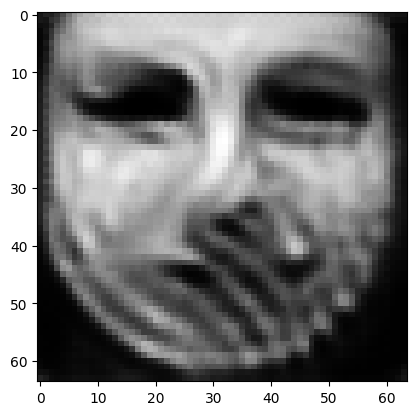

tensor([[3.7274e-04, 1.4269e-05, 9.3975e-01, 8.6649e-04, 7.2012e-04, 8.7936e-03,
         2.6478e-04, 6.1249e-03, 3.8875e-04, 7.5480e-04, 5.1201e-04, 8.7132e-04,
         2.4712e-04, 6.0437e-06, 2.2289e-06, 9.1844e-05, 9.1931e-04, 2.0849e-04,
         1.3193e-04, 7.8815e-04, 1.6438e-04, 1.6453e-04, 3.4748e-06, 6.4129e-05,
         1.7643e-04, 7.3312e-04, 7.6230e-05, 1.8076e-03, 1.5360e-02, 4.4297e-05,
         1.8869e-04, 7.7665e-06, 1.3945e-03, 6.0904e-04, 2.0640e-04, 2.8473e-06,
         1.8147e-04, 1.1168e-03, 1.1286e-02, 4.5846e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.062142953276634216
tensor([[3.6599e-04, 1.4097e-05, 9.4090e-01, 8.7455e-04, 7.0396e-04, 8.5624e-03,
         2.5499e-04, 5.9400e-03, 3.8450e-04, 7.4075e-04, 5.0533e-04, 8.6520e-04,
         2.4367e-04, 6.0490e-06, 2.1928e-06, 9.0470e-05, 9.1197e-04, 2.0469e-04,
         1.3052e-04, 7.6844e-04, 1.6270e-04, 1.6172e-04, 3.4502e-06, 6.3351e-05,
         1.7359e-04, 7.3389e-04, 7.4210e-

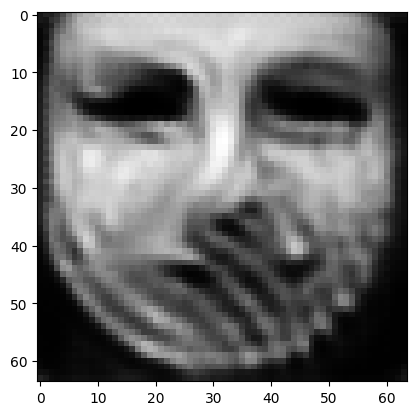

tensor([[3.4298e-04, 1.3475e-05, 9.4471e-01, 8.9510e-04, 6.5106e-04, 7.8622e-03,
         2.2602e-04, 5.3839e-03, 3.6964e-04, 6.9518e-04, 4.8176e-04, 8.4548e-04,
         2.3200e-04, 5.9761e-06, 2.0502e-06, 8.5912e-05, 8.8704e-04, 1.9179e-04,
         1.2533e-04, 7.0389e-04, 1.5645e-04, 1.5262e-04, 3.3443e-06, 6.0559e-05,
         1.6369e-04, 7.3227e-04, 6.7672e-05, 1.6855e-03, 1.4596e-02, 4.2631e-05,
         1.9142e-04, 7.1216e-06, 1.2726e-03, 5.6012e-04, 1.9707e-04, 2.6185e-06,
         1.8010e-04, 1.1010e-03, 9.9808e-03, 4.1343e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05687651038169861
tensor([[3.3854e-04, 1.3318e-05, 9.4551e-01, 8.9670e-04, 6.3962e-04, 7.7388e-03,
         2.2057e-04, 5.2823e-03, 3.6579e-04, 6.8731e-04, 4.7636e-04, 8.4177e-04,
         2.2915e-04, 5.9220e-06, 2.0159e-06, 8.4924e-05, 8.7936e-04, 1.8900e-04,
         1.2402e-04, 6.9134e-04, 1.5466e-04, 1.5072e-04, 3.3022e-06, 5.9815e-05,
         1.6094e-04, 7.2981e-04, 6.6400e-0

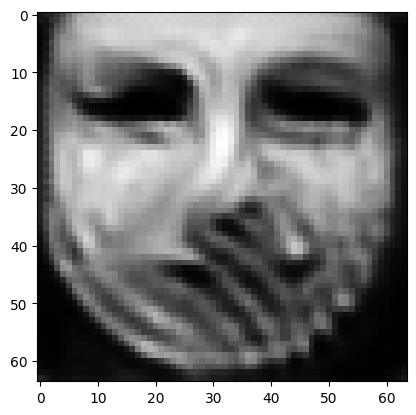

tensor([[3.1930e-04, 1.2797e-05, 9.4850e-01, 9.0048e-04, 5.9584e-04, 7.1732e-03,
         1.9917e-04, 4.8369e-03, 3.5355e-04, 6.5310e-04, 4.5672e-04, 8.3180e-04,
         2.2300e-04, 5.8555e-06, 1.9318e-06, 8.1866e-05, 8.5234e-04, 1.7926e-04,
         1.1900e-04, 6.5255e-04, 1.5017e-04, 1.4412e-04, 3.2034e-06, 5.7181e-05,
         1.5143e-04, 7.1314e-04, 6.1697e-05, 1.5706e-03, 1.3931e-02, 4.1181e-05,
         1.9108e-04, 6.6041e-06, 1.1839e-03, 5.2315e-04, 1.8867e-04, 2.4056e-06,
         1.7647e-04, 1.0740e-03, 9.0822e-03, 3.7952e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05286986753344536
tensor([[3.1457e-04, 1.2630e-05, 9.4919e-01, 8.9784e-04, 5.8380e-04, 7.0498e-03,
         1.9451e-04, 4.7372e-03, 3.4973e-04, 6.4577e-04, 4.5228e-04, 8.3051e-04,
         2.2064e-04, 5.8142e-06, 1.9069e-06, 8.1291e-05, 8.4679e-04, 1.7667e-04,
         1.1782e-04, 6.4357e-04, 1.4902e-04, 1.4259e-04, 3.1712e-06, 5.6596e-05,
         1.4854e-04, 7.0793e-04, 6.0498e-0

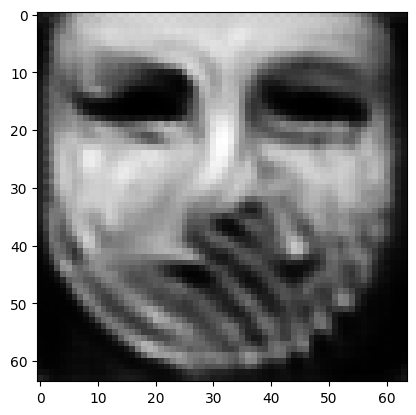

tensor([[2.9888e-04, 1.2099e-05, 9.5163e-01, 8.9535e-04, 5.4587e-04, 6.5895e-03,
         1.7841e-04, 4.3910e-03, 3.3784e-04, 6.1537e-04, 4.3536e-04, 8.2250e-04,
         2.1454e-04, 5.7223e-06, 1.8312e-06, 7.9082e-05, 8.2747e-04, 1.6817e-04,
         1.1356e-04, 6.1181e-04, 1.4533e-04, 1.3701e-04, 3.0824e-06, 5.4676e-05,
         1.4022e-04, 6.8980e-04, 5.6416e-05, 1.4627e-03, 1.3413e-02, 3.9976e-05,
         1.8948e-04, 6.1798e-06, 1.1138e-03, 4.9281e-04, 1.8067e-04, 2.2147e-06,
         1.7234e-04, 1.0482e-03, 8.3803e-03, 3.4957e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04957738518714905
tensor([[2.9536e-04, 1.2014e-05, 9.5219e-01, 8.9811e-04, 5.3785e-04, 6.4867e-03,
         1.7459e-04, 4.3122e-03, 3.3486e-04, 6.0872e-04, 4.3225e-04, 8.2058e-04,
         2.1265e-04, 5.7181e-06, 1.8112e-06, 7.8434e-05, 8.2174e-04, 1.6628e-04,
         1.1261e-04, 6.0296e-04, 1.4416e-04, 1.3571e-04, 3.0611e-06, 5.4143e-05,
         1.3864e-04, 6.8749e-04, 5.5596e-0

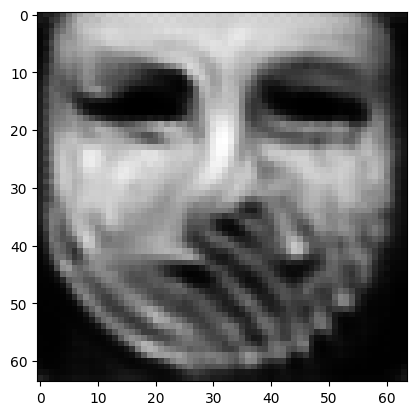

tensor([[2.8112e-04, 1.1474e-05, 9.5436e-01, 8.8130e-04, 5.0438e-04, 6.1055e-03,
         1.6115e-04, 4.0164e-03, 3.2483e-04, 5.8554e-04, 4.1505e-04, 8.1670e-04,
         2.0668e-04, 5.5773e-06, 1.7453e-06, 7.5988e-05, 7.9748e-04, 1.5925e-04,
         1.0831e-04, 5.8063e-04, 1.4080e-04, 1.3108e-04, 2.9623e-06, 5.2086e-05,
         1.3047e-04, 6.6658e-04, 5.1976e-05, 1.3624e-03, 1.2879e-02, 3.8707e-05,
         1.8663e-04, 5.8049e-06, 1.0538e-03, 4.6705e-04, 1.7368e-04, 2.0565e-06,
         1.6688e-04, 1.0231e-03, 7.8173e-03, 3.2515e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.046717364341020584
tensor([[2.7821e-04, 1.1381e-05, 9.5487e-01, 8.8289e-04, 4.9698e-04, 6.0107e-03,
         1.5768e-04, 3.9561e-03, 3.2253e-04, 5.7974e-04, 4.1117e-04, 8.1368e-04,
         2.0505e-04, 5.5619e-06, 1.7266e-06, 7.5173e-05, 7.9197e-04, 1.5745e-04,
         1.0728e-04, 5.7404e-04, 1.3948e-04, 1.2981e-04, 2.9412e-06, 5.1643e-05,
         1.2930e-04, 6.6488e-04, 5.1122e-

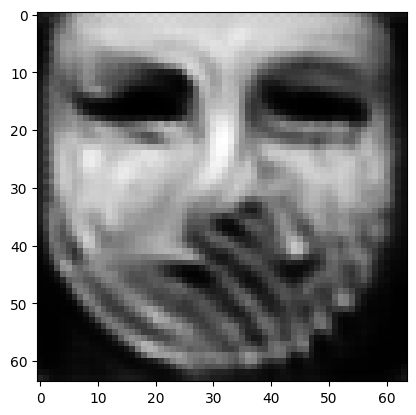

tensor([[2.6696e-04, 1.0874e-05, 9.5676e-01, 8.6673e-04, 4.7089e-04, 5.6923e-03,
         1.4656e-04, 3.7341e-03, 3.1431e-04, 5.5913e-04, 3.9319e-04, 8.0310e-04,
         2.0012e-04, 5.4116e-06, 1.6683e-06, 7.2444e-05, 7.7042e-04, 1.5170e-04,
         1.0316e-04, 5.5582e-04, 1.3550e-04, 1.2540e-04, 2.8417e-06, 4.9945e-05,
         1.2351e-04, 6.4567e-04, 4.7924e-05, 1.2781e-03, 1.2301e-02, 3.7207e-05,
         1.8381e-04, 5.4830e-06, 1.0030e-03, 4.4395e-04, 1.6785e-04, 1.9180e-06,
         1.6131e-04, 9.9622e-04, 7.3897e-03, 3.0195e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.044200945645570755
tensor([[2.6424e-04, 1.0765e-05, 9.5722e-01, 8.6589e-04, 4.6459e-04, 5.6156e-03,
         1.4375e-04, 3.6851e-03, 3.1239e-04, 5.5374e-04, 3.8904e-04, 7.9907e-04,
         1.9874e-04, 5.3814e-06, 1.6501e-06, 7.1660e-05, 7.6526e-04, 1.5013e-04,
         1.0227e-04, 5.4974e-04, 1.3421e-04, 1.2425e-04, 2.8192e-06, 4.9503e-05,
         1.2233e-04, 6.4285e-04, 4.7139e-

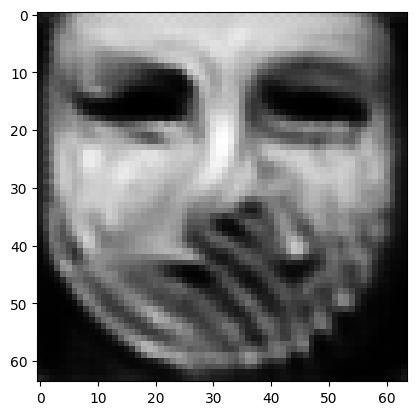

tensor([[2.5447e-04, 1.0340e-05, 9.5888e-01, 8.5219e-04, 4.4229e-04, 5.3364e-03,
         1.3430e-04, 3.5028e-03, 3.0557e-04, 5.3725e-04, 3.7224e-04, 7.8473e-04,
         1.9475e-04, 5.2376e-06, 1.5986e-06, 6.8775e-05, 7.4140e-04, 1.4514e-04,
         9.8717e-05, 5.3282e-04, 1.2974e-04, 1.2046e-04, 2.7192e-06, 4.7613e-05,
         1.1725e-04, 6.2517e-04, 4.4519e-05, 1.2098e-03, 1.1747e-02, 3.5678e-05,
         1.8124e-04, 5.1732e-06, 9.5505e-04, 4.2313e-04, 1.6202e-04, 1.7901e-06,
         1.5568e-04, 9.7085e-04, 7.0349e-03, 2.8261e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04198651388287544
tensor([[2.5219e-04, 1.0251e-05, 9.5925e-01, 8.5004e-04, 4.3722e-04, 5.2772e-03,
         1.3215e-04, 3.4626e-03, 3.0408e-04, 5.3383e-04, 3.6857e-04, 7.8122e-04,
         1.9369e-04, 5.2026e-06, 1.5849e-06, 6.8061e-05, 7.3507e-04, 1.4390e-04,
         9.7946e-05, 5.2809e-04, 1.2858e-04, 1.1960e-04, 2.6946e-06, 4.7112e-05,
         1.1603e-04, 6.2179e-04, 4.3967e-0

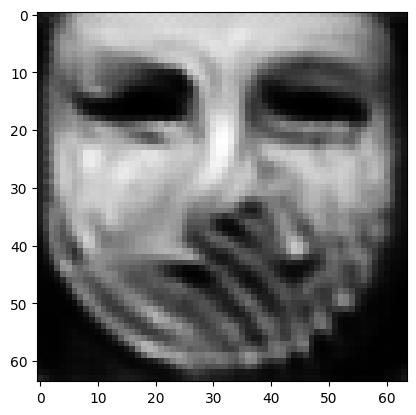

tensor([[2.4452e-04, 9.8057e-06, 9.6068e-01, 8.3293e-04, 4.1861e-04, 5.0465e-03,
         1.2496e-04, 3.3227e-03, 2.9725e-04, 5.1886e-04, 3.5383e-04, 7.6709e-04,
         1.8911e-04, 5.0389e-06, 1.5358e-06, 6.5657e-05, 7.1949e-04, 1.3977e-04,
         9.4711e-05, 5.1437e-04, 1.2467e-04, 1.1617e-04, 2.5998e-06, 4.5842e-05,
         1.1175e-04, 6.0559e-04, 4.1524e-05, 1.1526e-03, 1.1253e-02, 3.4230e-05,
         1.7773e-04, 4.9083e-06, 9.1369e-04, 4.0398e-04, 1.5709e-04, 1.6771e-06,
         1.4997e-04, 9.4601e-04, 6.7559e-03, 2.6533e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04011228680610657
tensor([[2.4313e-04, 9.7149e-06, 9.6102e-01, 8.3094e-04, 4.1430e-04, 4.9899e-03,
         1.2325e-04, 3.2898e-03, 2.9546e-04, 5.1553e-04, 3.5074e-04, 7.6370e-04,
         1.8768e-04, 5.0086e-06, 1.5245e-06, 6.5048e-05, 7.1553e-04, 1.3894e-04,
         9.3944e-05, 5.1097e-04, 1.2363e-04, 1.1530e-04, 2.5759e-06, 4.5560e-05,
         1.1094e-04, 6.0272e-04, 4.0990e-0

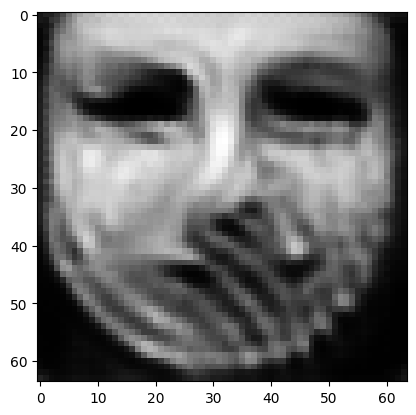

tensor([[2.3727e-04, 9.3933e-06, 9.6228e-01, 8.2256e-04, 3.9897e-04, 4.7813e-03,
         1.1699e-04, 3.1665e-03, 2.8907e-04, 5.0222e-04, 3.3917e-04, 7.5053e-04,
         1.8364e-04, 4.9106e-06, 1.4857e-06, 6.2895e-05, 7.0170e-04, 1.3584e-04,
         9.1118e-05, 4.9872e-04, 1.2007e-04, 1.1203e-04, 2.4979e-06, 4.4490e-05,
         1.0785e-04, 5.9046e-04, 3.9030e-05, 1.1062e-03, 1.0826e-02, 3.3133e-05,
         1.7531e-04, 4.6905e-06, 8.7742e-04, 3.8753e-04, 1.5312e-04, 1.5938e-06,
         1.4581e-04, 9.2968e-04, 6.4758e-03, 2.4951e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0384526289999485
tensor([[2.3586e-04, 9.3175e-06, 9.6258e-01, 8.2006e-04, 3.9524e-04, 4.7324e-03,
         1.1550e-04, 3.1369e-03, 2.8736e-04, 4.9921e-04, 3.3643e-04, 7.4728e-04,
         1.8258e-04, 4.8858e-06, 1.4767e-06, 6.2370e-05, 6.9821e-04, 1.3514e-04,
         9.0414e-05, 4.9607e-04, 1.1918e-04, 1.1125e-04, 2.4772e-06, 4.4208e-05,
         1.0703e-04, 5.8717e-04, 3.8574e-05

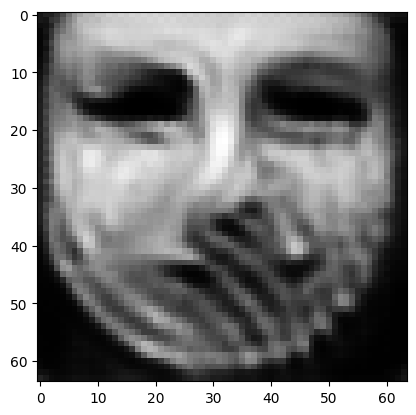

tensor([[2.3098e-04, 9.0075e-06, 9.6375e-01, 8.0891e-04, 3.8108e-04, 4.5486e-03,
         1.0990e-04, 3.0304e-03, 2.8116e-04, 4.8821e-04, 3.2562e-04, 7.3455e-04,
         1.7860e-04, 4.7819e-06, 1.4466e-06, 6.0289e-05, 6.8377e-04, 1.3265e-04,
         8.7626e-05, 4.8798e-04, 1.1585e-04, 1.0812e-04, 2.3942e-06, 4.3165e-05,
         1.0401e-04, 5.7314e-04, 3.6827e-05, 1.0615e-03, 1.0401e-02, 3.2113e-05,
         1.7214e-04, 4.4825e-06, 8.4634e-04, 3.7192e-04, 1.4929e-04, 1.5126e-06,
         1.4090e-04, 9.1450e-04, 6.2361e-03, 2.3535e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0369281992316246
tensor([[2.2967e-04, 8.9251e-06, 9.6401e-01, 8.0524e-04, 3.7756e-04, 4.5106e-03,
         1.0864e-04, 3.0093e-03, 2.8003e-04, 4.8592e-04, 3.2312e-04, 7.3191e-04,
         1.7761e-04, 4.7478e-06, 1.4372e-06, 5.9756e-05, 6.7965e-04, 1.3187e-04,
         8.6957e-05, 4.8593e-04, 1.1501e-04, 1.0743e-04, 2.3726e-06, 4.2877e-05,
         1.0323e-04, 5.6990e-04, 3.6414e-05

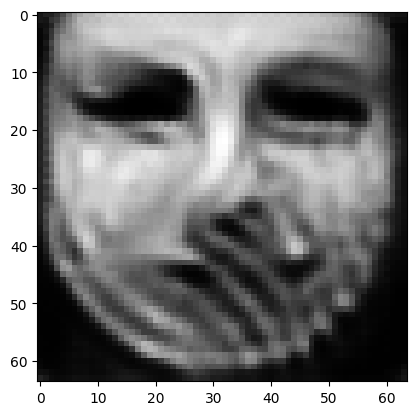

tensor([[2.2487e-04, 8.6196e-06, 9.6497e-01, 7.8645e-04, 3.6455e-04, 4.3894e-03,
         1.0454e-04, 2.9254e-03, 2.7350e-04, 4.7852e-04, 3.1463e-04, 7.2473e-04,
         1.7341e-04, 4.6057e-06, 1.4029e-06, 5.8249e-05, 6.6750e-04, 1.2942e-04,
         8.4579e-05, 4.7882e-04, 1.1211e-04, 1.0503e-04, 2.2872e-06, 4.1877e-05,
         9.9404e-05, 5.5432e-04, 3.4979e-05, 1.0216e-03, 1.0045e-02, 3.0966e-05,
         1.6778e-04, 4.2951e-06, 8.1890e-04, 3.5719e-04, 1.4536e-04, 1.4326e-06,
         1.3579e-04, 8.9718e-04, 6.0215e-03, 2.2450e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.03566306456923485
tensor([[2.2366e-04, 8.5519e-06, 9.6520e-01, 7.8216e-04, 3.6155e-04, 4.3604e-03,
         1.0356e-04, 2.9032e-03, 2.7202e-04, 4.7669e-04, 3.1251e-04, 7.2324e-04,
         1.7260e-04, 4.5735e-06, 1.3956e-06, 5.7923e-05, 6.6427e-04, 1.2886e-04,
         8.4065e-05, 4.7700e-04, 1.1148e-04, 1.0448e-04, 2.2681e-06, 4.1622e-05,
         9.8436e-05, 5.5015e-04, 3.4653e-0

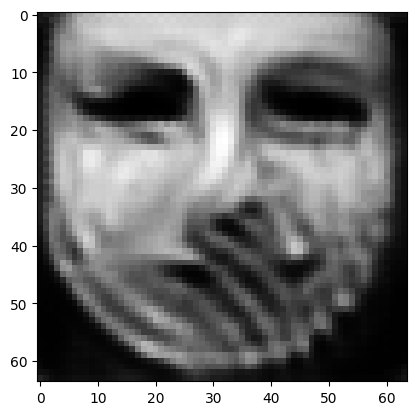

tensor([[2.1911e-04, 8.2982e-06, 9.6603e-01, 7.6695e-04, 3.5007e-04, 4.2477e-03,
         9.9755e-05, 2.8221e-03, 2.6740e-04, 4.7072e-04, 3.0466e-04, 7.1840e-04,
         1.6958e-04, 4.4549e-06, 1.3669e-06, 5.6555e-05, 6.5085e-04, 1.2632e-04,
         8.2113e-05, 4.7032e-04, 1.0893e-04, 1.0265e-04, 2.1965e-06, 4.0636e-05,
         9.4994e-05, 5.3668e-04, 3.3451e-05, 9.8607e-04, 9.7358e-03, 3.0007e-05,
         1.6414e-04, 4.1339e-06, 7.9233e-04, 3.4467e-04, 1.4185e-04, 1.3627e-06,
         1.3133e-04, 8.8102e-04, 5.8439e-03, 2.1564e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.03455975279211998
tensor([[2.1813e-04, 8.2439e-06, 9.6622e-01, 7.6415e-04, 3.4760e-04, 4.2199e-03,
         9.8874e-05, 2.8037e-03, 2.6634e-04, 4.6915e-04, 3.0292e-04, 7.1708e-04,
         1.6891e-04, 4.4319e-06, 1.3607e-06, 5.6246e-05, 6.4812e-04, 1.2577e-04,
         8.1700e-05, 4.6858e-04, 1.0836e-04, 1.0222e-04, 2.1817e-06, 4.0436e-05,
         9.4283e-05, 5.3393e-04, 3.3172e-0

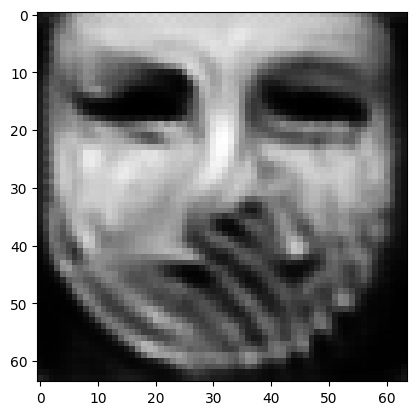

tensor([[2.1392e-04, 8.0394e-06, 9.6695e-01, 7.5186e-04, 3.3809e-04, 4.1170e-03,
         9.5596e-05, 2.7348e-03, 2.6252e-04, 4.6369e-04, 2.9578e-04, 7.1171e-04,
         1.6647e-04, 4.3319e-06, 1.3345e-06, 5.5065e-05, 6.3669e-04, 1.2324e-04,
         8.0135e-05, 4.6124e-04, 1.0611e-04, 1.0064e-04, 2.1236e-06, 3.9594e-05,
         9.1362e-05, 5.2298e-04, 3.2127e-05, 9.5689e-04, 9.4715e-03, 2.9216e-05,
         1.6124e-04, 3.9922e-06, 7.6833e-04, 3.3443e-04, 1.3878e-04, 1.3034e-06,
         1.2749e-04, 8.6559e-04, 5.6963e-03, 2.0792e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.033609114587306976
tensor([[2.1292e-04, 7.9949e-06, 9.6712e-01, 7.4953e-04, 3.3590e-04, 4.0900e-03,
         9.4789e-05, 2.7195e-03, 2.6174e-04, 4.6276e-04, 2.9410e-04, 7.1035e-04,
         1.6581e-04, 4.3101e-06, 1.3283e-06, 5.4747e-05, 6.3364e-04, 1.2262e-04,
         7.9762e-05, 4.5950e-04, 1.0552e-04, 1.0028e-04, 2.1088e-06, 3.9388e-05,
         9.0763e-05, 5.2080e-04, 3.1878e-

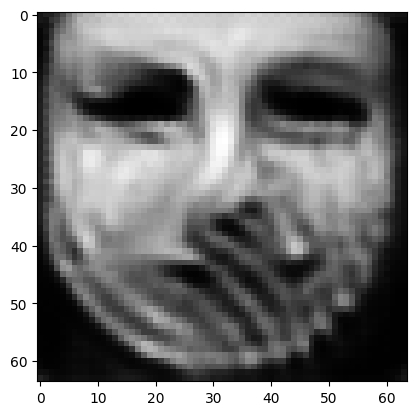

tensor([[2.0948e-04, 7.8389e-06, 9.6775e-01, 7.4333e-04, 3.2849e-04, 3.9832e-03,
         9.1840e-05, 2.6682e-03, 2.5864e-04, 4.5782e-04, 2.8810e-04, 7.0340e-04,
         1.6361e-04, 4.2461e-06, 1.3060e-06, 5.3549e-05, 6.2464e-04, 1.2039e-04,
         7.8388e-05, 4.5258e-04, 1.0329e-04, 9.8841e-05, 2.0615e-06, 3.8776e-05,
         8.9066e-05, 5.1390e-04, 3.0932e-05, 9.3522e-04, 9.2446e-03, 2.8550e-05,
         1.5946e-04, 3.8715e-06, 7.4783e-04, 3.2705e-04, 1.3601e-04, 1.2576e-06,
         1.2462e-04, 8.5459e-04, 5.5669e-03, 2.0036e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.03278079256415367
tensor([[2.0879e-04, 7.8074e-06, 9.6790e-01, 7.4322e-04, 3.2688e-04, 3.9557e-03,
         9.1099e-05, 2.6554e-03, 2.5793e-04, 4.5632e-04, 2.8680e-04, 7.0149e-04,
         1.6303e-04, 4.2375e-06, 1.3012e-06, 5.3253e-05, 6.2271e-04, 1.1995e-04,
         7.8072e-05, 4.5087e-04, 1.0277e-04, 9.8442e-05, 2.0520e-06, 3.8654e-05,
         8.8824e-05, 5.1287e-04, 3.0705e-0

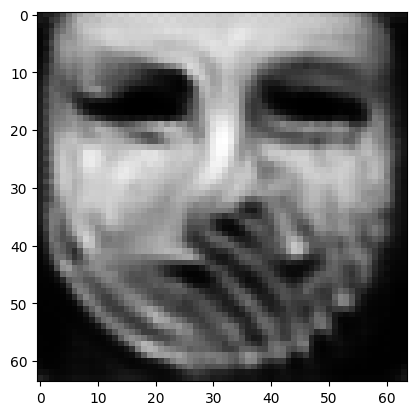

tensor([[2.0614e-04, 7.6769e-06, 9.6847e-01, 7.4088e-04, 3.2081e-04, 3.8479e-03,
         8.8382e-05, 2.6061e-03, 2.5532e-04, 4.5073e-04, 2.8172e-04, 6.9486e-04,
         1.6085e-04, 4.2027e-06, 1.2845e-06, 5.2123e-05, 6.1499e-04, 1.1825e-04,
         7.6840e-05, 4.4457e-04, 1.0090e-04, 9.7045e-05, 2.0162e-06, 3.8226e-05,
         8.7863e-05, 5.0876e-04, 2.9848e-05, 9.1670e-04, 9.0552e-03, 2.8070e-05,
         1.5851e-04, 3.7781e-06, 7.3116e-04, 3.2108e-04, 1.3395e-04, 1.2263e-06,
         1.2288e-04, 8.4930e-04, 5.4431e-03, 1.9314e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.032042648643255234
tensor([[2.0554e-04, 7.6466e-06, 9.6860e-01, 7.4056e-04, 3.1941e-04, 3.8216e-03,
         8.7729e-05, 2.5943e-03, 2.5479e-04, 4.4934e-04, 2.8050e-04, 6.9322e-04,
         1.6036e-04, 4.1965e-06, 1.2810e-06, 5.1839e-05, 6.1315e-04, 1.1788e-04,
         7.6545e-05, 4.4316e-04, 1.0046e-04, 9.6704e-05, 2.0083e-06, 3.8134e-05,
         8.7712e-05, 5.0797e-04, 2.9643e-

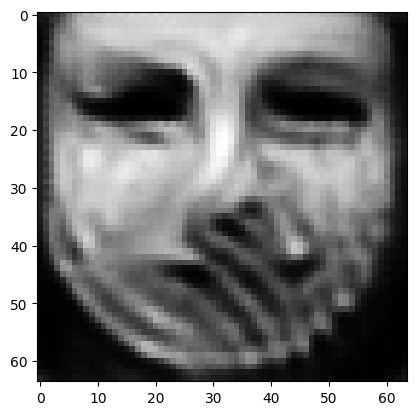

tensor([[2.0324e-04, 7.5257e-06, 9.6911e-01, 7.3763e-04, 3.1408e-04, 3.7266e-03,
         8.5359e-05, 2.5499e-03, 2.5239e-04, 4.4437e-04, 2.7594e-04, 6.8728e-04,
         1.5836e-04, 4.1652e-06, 1.2667e-06, 5.0837e-05, 6.0652e-04, 1.1649e-04,
         7.5392e-05, 4.3802e-04, 9.8793e-05, 9.5431e-05, 1.9747e-06, 3.7775e-05,
         8.6878e-05, 5.0395e-04, 2.8871e-05, 8.9975e-04, 8.8792e-03, 2.7629e-05,
         1.5752e-04, 3.6992e-06, 7.1698e-04, 3.1583e-04, 1.3226e-04, 1.1980e-06,
         1.2132e-04, 8.4476e-04, 5.3336e-03, 1.8662e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.03137616440653801
tensor([[2.0290e-04, 7.4955e-06, 9.6923e-01, 7.3597e-04, 3.1317e-04, 3.7036e-03,
         8.4894e-05, 2.5400e-03, 2.5191e-04, 4.4323e-04, 2.7490e-04, 6.8605e-04,
         1.5805e-04, 4.1602e-06, 1.2658e-06, 5.0608e-05, 6.0496e-04, 1.1642e-04,
         7.5087e-05, 4.3764e-04, 9.8488e-05, 9.5142e-05, 1.9672e-06, 3.7726e-05,
         8.6795e-05, 5.0233e-04, 2.8708e-0

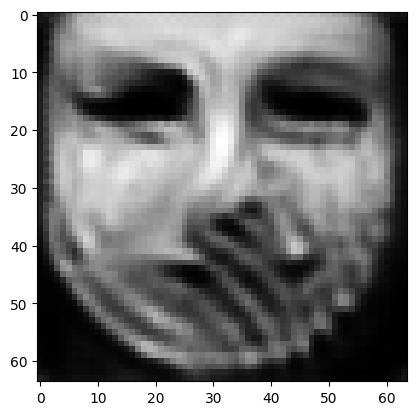

tensor([[2.0090e-04, 7.3869e-06, 9.6968e-01, 7.3064e-04, 3.0853e-04, 3.6258e-03,
         8.2947e-05, 2.4998e-03, 2.4967e-04, 4.3923e-04, 2.7088e-04, 6.8179e-04,
         1.5658e-04, 4.1287e-06, 1.2549e-06, 4.9787e-05, 5.9904e-04, 1.1543e-04,
         7.4020e-05, 4.3380e-04, 9.7141e-05, 9.4084e-05, 1.9370e-06, 3.7385e-05,
         8.5904e-05, 4.9718e-04, 2.8081e-05, 8.8438e-04, 8.7018e-03, 2.7207e-05,
         1.5612e-04, 3.6344e-06, 7.0657e-04, 3.1145e-04, 1.3083e-04, 1.1714e-06,
         1.1983e-04, 8.4058e-04, 5.2473e-03, 1.8118e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.030784951522946358
tensor([[2.0034e-04, 7.3625e-06, 9.6979e-01, 7.2988e-04, 3.0731e-04, 3.6068e-03,
         8.2451e-05, 2.4898e-03, 2.4918e-04, 4.3822e-04, 2.6989e-04, 6.8062e-04,
         1.5622e-04, 4.1215e-06, 1.2516e-06, 4.9587e-05, 5.9769e-04, 1.1511e-04,
         7.3777e-05, 4.3255e-04, 9.6802e-05, 9.3827e-05, 1.9305e-06, 3.7293e-05,
         8.5673e-05, 4.9630e-04, 2.7925e-

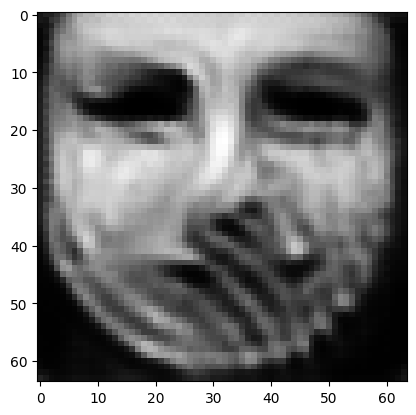

tensor([[1.9835e-04, 7.2461e-06, 9.7023e-01, 7.2125e-04, 3.0256e-04, 3.5460e-03,
         8.0858e-05, 2.4519e-03, 2.4671e-04, 4.3482e-04, 2.6618e-04, 6.7762e-04,
         1.5459e-04, 4.0715e-06, 1.2385e-06, 4.8880e-05, 5.9169e-04, 1.1437e-04,
         7.2719e-05, 4.2908e-04, 9.5516e-05, 9.2813e-05, 1.8965e-06, 3.6883e-05,
         8.4408e-05, 4.8926e-04, 2.7377e-05, 8.6849e-04, 8.5342e-03, 2.6741e-05,
         1.5422e-04, 3.5659e-06, 6.9598e-04, 3.0643e-04, 1.2932e-04, 1.1423e-06,
         1.1814e-04, 8.3628e-04, 5.1509e-03, 1.7668e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.030222654342651367
tensor([[1.9784e-04, 7.2192e-06, 9.7034e-01, 7.2010e-04, 3.0135e-04, 3.5277e-03,
         8.0398e-05, 2.4421e-03, 2.4621e-04, 4.3379e-04, 2.6513e-04, 6.7645e-04,
         1.5422e-04, 4.0620e-06, 1.2351e-06, 4.8685e-05, 5.9038e-04, 1.1410e-04,
         7.2482e-05, 4.2792e-04, 9.5172e-05, 9.2543e-05, 1.8895e-06, 3.6794e-05,
         8.4173e-05, 4.8803e-04, 2.7220e-

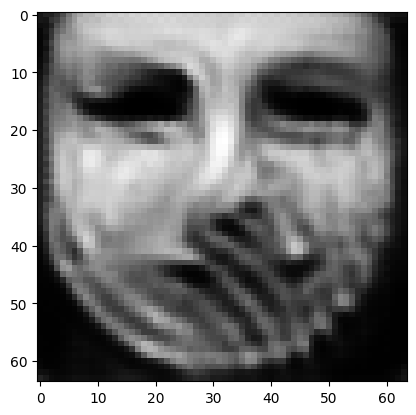

tensor([[1.9591e-04, 7.1036e-06, 9.7076e-01, 7.1254e-04, 2.9680e-04, 3.4625e-03,
         7.8796e-05, 2.4053e-03, 2.4387e-04, 4.3034e-04, 2.6127e-04, 6.7256e-04,
         1.5253e-04, 4.0155e-06, 1.2223e-06, 4.7973e-05, 5.8503e-04, 1.1330e-04,
         7.1486e-05, 4.2428e-04, 9.3876e-05, 9.1530e-05, 1.8569e-06, 3.6432e-05,
         8.3094e-05, 4.8188e-04, 2.6653e-05, 8.5310e-04, 8.3719e-03, 2.6308e-05,
         1.5242e-04, 3.4973e-06, 6.8511e-04, 3.0170e-04, 1.2792e-04, 1.1140e-06,
         1.1641e-04, 8.3247e-04, 5.0610e-03, 1.7203e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02967114932835102
tensor([[1.9539e-04, 7.0747e-06, 9.7087e-01, 7.1117e-04, 2.9553e-04, 3.4465e-03,
         7.8369e-05, 2.3966e-03, 2.4326e-04, 4.2952e-04, 2.6026e-04, 6.7142e-04,
         1.5203e-04, 4.0025e-06, 1.2181e-06, 4.7796e-05, 5.8377e-04, 1.1297e-04,
         7.1259e-05, 4.2306e-04, 9.3514e-05, 9.1274e-05, 1.8486e-06, 3.6339e-05,
         8.2799e-05, 4.8073e-04, 2.6503e-0

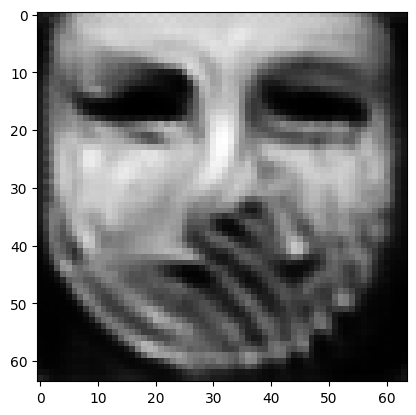

tensor([[1.9340e-04, 6.9572e-06, 9.7127e-01, 7.0251e-04, 2.9077e-04, 3.3916e-03,
         7.6961e-05, 2.3656e-03, 2.4023e-04, 4.2682e-04, 2.5685e-04, 6.6795e-04,
         1.4975e-04, 3.9442e-06, 1.2018e-06, 4.7188e-05, 5.7966e-04, 1.1203e-04,
         7.0346e-05, 4.1879e-04, 9.2179e-05, 9.0296e-05, 1.8131e-06, 3.5996e-05,
         8.1485e-05, 4.7479e-04, 2.5955e-05, 8.3789e-04, 8.2295e-03, 2.5881e-05,
         1.5036e-04, 3.4260e-06, 6.7407e-04, 2.9663e-04, 1.2620e-04, 1.0842e-06,
         1.1453e-04, 8.2770e-04, 4.9616e-03, 1.6767e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.029151296243071556
tensor([[1.9291e-04, 6.9275e-06, 9.7137e-01, 7.0033e-04, 2.8969e-04, 3.3780e-03,
         7.6628e-05, 2.3587e-03, 2.3942e-04, 4.2611e-04, 2.5602e-04, 6.6686e-04,
         1.4917e-04, 3.9297e-06, 1.1973e-06, 4.7034e-05, 5.7878e-04, 1.1177e-04,
         7.0118e-05, 4.1769e-04, 9.1828e-05, 9.0049e-05, 1.8047e-06, 3.5921e-05,
         8.1196e-05, 4.7346e-04, 2.5816e-

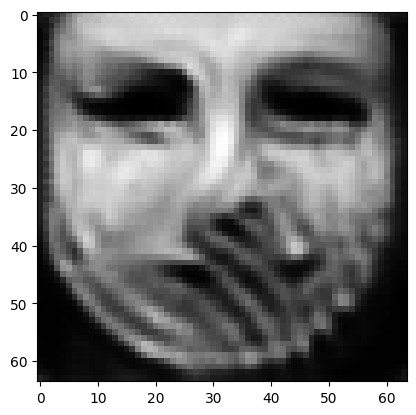

tensor([[1.9111e-04, 6.8170e-06, 9.7173e-01, 6.9266e-04, 2.8555e-04, 3.3274e-03,
         7.5280e-05, 2.3301e-03, 2.3623e-04, 4.2337e-04, 2.5262e-04, 6.6294e-04,
         1.4694e-04, 3.8737e-06, 1.1806e-06, 4.6500e-05, 5.7509e-04, 1.1072e-04,
         6.9316e-05, 4.1324e-04, 9.0539e-05, 8.9093e-05, 1.7733e-06, 3.5625e-05,
         7.9993e-05, 4.6850e-04, 2.5293e-05, 8.2397e-04, 8.1009e-03, 2.5463e-05,
         1.4838e-04, 3.3605e-06, 6.6330e-04, 2.9179e-04, 1.2450e-04, 1.0570e-06,
         1.1278e-04, 8.2225e-04, 4.8737e-03, 1.6344e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02867484651505947
tensor([[1.9064e-04, 6.7917e-06, 9.7182e-01, 6.9112e-04, 2.8452e-04, 3.3154e-03,
         7.4933e-05, 2.3234e-03, 2.3554e-04, 4.2267e-04, 2.5181e-04, 6.6191e-04,
         1.4645e-04, 3.8611e-06, 1.1764e-06, 4.6365e-05, 5.7424e-04, 1.1041e-04,
         6.9126e-05, 4.1209e-04, 9.0211e-05, 8.8860e-05, 1.7661e-06, 3.5552e-05,
         7.9714e-05, 4.6746e-04, 2.5164e-0

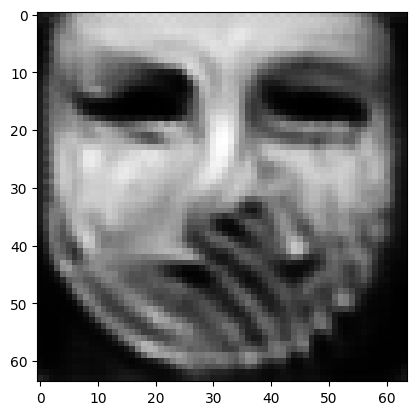

tensor([[1.8898e-04, 6.6954e-06, 9.7215e-01, 6.8603e-04, 2.8086e-04, 3.2667e-03,
         7.3587e-05, 2.2975e-03, 2.3283e-04, 4.1982e-04, 2.4862e-04, 6.5758e-04,
         1.4456e-04, 3.8163e-06, 1.1611e-06, 4.5848e-05, 5.7143e-04, 1.0933e-04,
         6.8420e-05, 4.0768e-04, 8.8990e-05, 8.7960e-05, 1.7394e-06, 3.5314e-05,
         7.8756e-05, 4.6382e-04, 2.4655e-05, 8.1207e-04, 7.9858e-03, 2.5102e-05,
         1.4702e-04, 3.3017e-06, 6.5288e-04, 2.8742e-04, 1.2303e-04, 1.0334e-06,
         1.1140e-04, 8.1707e-04, 4.7930e-03, 1.5942e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.028241049498319626
tensor([[1.8856e-04, 6.6739e-06, 9.7223e-01, 6.8464e-04, 2.8002e-04, 3.2547e-03,
         7.3262e-05, 2.2905e-03, 2.3232e-04, 4.1915e-04, 2.4782e-04, 6.5672e-04,
         1.4421e-04, 3.8066e-06, 1.1583e-06, 4.5724e-05, 5.7044e-04, 1.0910e-04,
         6.8249e-05, 4.0679e-04, 8.8750e-05, 8.7758e-05, 1.7334e-06, 3.5249e-05,
         7.8530e-05, 4.6283e-04, 2.4543e-

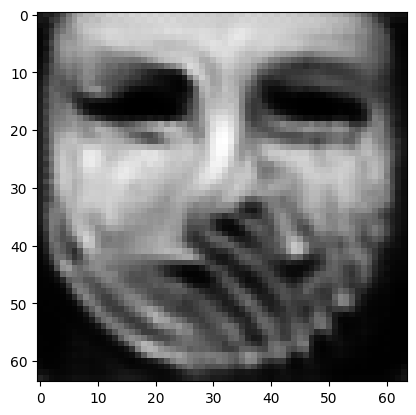

tensor([[1.8721e-04, 6.5732e-06, 9.7255e-01, 6.7826e-04, 2.7656e-04, 3.2136e-03,
         7.2156e-05, 2.2673e-03, 2.2939e-04, 4.1637e-04, 2.4487e-04, 6.5282e-04,
         1.4219e-04, 3.7557e-06, 1.1427e-06, 4.5265e-05, 5.6835e-04, 1.0822e-04,
         6.7526e-05, 4.0297e-04, 8.7608e-05, 8.6911e-05, 1.7065e-06, 3.5064e-05,
         7.7597e-05, 4.5897e-04, 2.4088e-05, 8.0062e-04, 7.8770e-03, 2.4736e-05,
         1.4542e-04, 3.2489e-06, 6.4390e-04, 2.8330e-04, 1.2178e-04, 1.0115e-06,
         1.1009e-04, 8.1285e-04, 4.7170e-03, 1.5573e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02783859893679619
tensor([[1.8683e-04, 6.5484e-06, 9.7262e-01, 6.7629e-04, 2.7574e-04, 3.2046e-03,
         7.1901e-05, 2.2614e-03, 2.2870e-04, 4.1568e-04, 2.4411e-04, 6.5200e-04,
         1.4174e-04, 3.7420e-06, 1.1389e-06, 4.5168e-05, 5.6779e-04, 1.0801e-04,
         6.7347e-05, 4.0210e-04, 8.7364e-05, 8.6705e-05, 1.7000e-06, 3.5016e-05,
         7.7339e-05, 4.5776e-04, 2.3980e-0

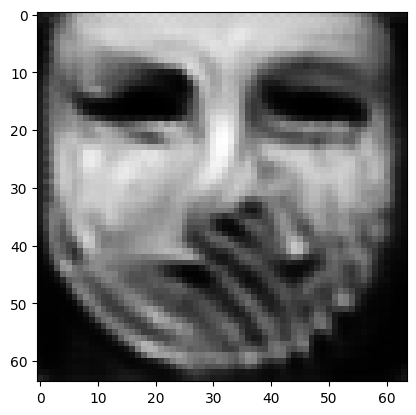

tensor([[1.8573e-04, 6.4564e-06, 9.7291e-01, 6.7045e-04, 2.7277e-04, 3.1651e-03,
         7.0892e-05, 2.2393e-03, 2.2633e-04, 4.1263e-04, 2.4130e-04, 6.4877e-04,
         1.4013e-04, 3.7012e-06, 1.1268e-06, 4.4752e-05, 5.6601e-04, 1.0738e-04,
         6.6658e-05, 3.9941e-04, 8.6458e-05, 8.5900e-05, 1.6780e-06, 3.4919e-05,
         7.6677e-05, 4.5395e-04, 2.3558e-05, 7.8912e-04, 7.7656e-03, 2.4380e-05,
         1.4369e-04, 3.2033e-06, 6.3630e-04, 2.7948e-04, 1.2085e-04, 9.9158e-07,
         1.0887e-04, 8.0950e-04, 4.6501e-03, 1.5221e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0274597629904747
tensor([[1.8541e-04, 6.4372e-06, 9.7298e-01, 6.6912e-04, 2.7209e-04, 3.1558e-03,
         7.0640e-05, 2.2336e-03, 2.2584e-04, 4.1188e-04, 2.4063e-04, 6.4811e-04,
         1.3983e-04, 3.6925e-06, 1.1242e-06, 4.4657e-05, 5.6542e-04, 1.0722e-04,
         6.6498e-05, 3.9873e-04, 8.6271e-05, 8.5711e-05, 1.6734e-06, 3.4886e-05,
         7.6508e-05, 4.5303e-04, 2.3461e-05

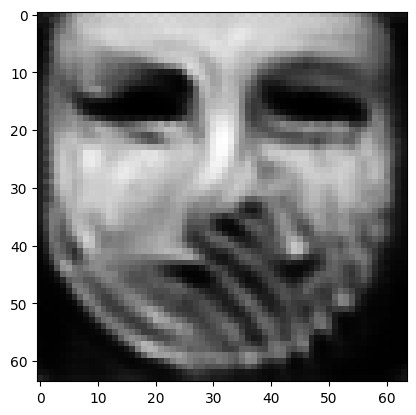

tensor([[1.8429e-04, 6.3520e-06, 9.7326e-01, 6.6378e-04, 2.6920e-04, 3.1188e-03,
         6.9633e-05, 2.2131e-03, 2.2343e-04, 4.0915e-04, 2.3813e-04, 6.4508e-04,
         1.3821e-04, 3.6540e-06, 1.1120e-06, 4.4256e-05, 5.6352e-04, 1.0652e-04,
         6.5854e-05, 3.9595e-04, 8.5338e-05, 8.4975e-05, 1.6519e-06, 3.4784e-05,
         7.5821e-05, 4.4976e-04, 2.3063e-05, 7.7895e-04, 7.6661e-03, 2.4042e-05,
         1.4219e-04, 3.1615e-06, 6.2886e-04, 2.7600e-04, 1.1988e-04, 9.7331e-07,
         1.0782e-04, 8.0648e-04, 4.5855e-03, 1.4890e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.027108395472168922
tensor([[1.8400e-04, 6.3309e-06, 9.7332e-01, 6.6237e-04, 2.6847e-04, 3.1098e-03,
         6.9387e-05, 2.2085e-03, 2.2282e-04, 4.0854e-04, 2.3754e-04, 6.4430e-04,
         1.3781e-04, 3.6443e-06, 1.1089e-06, 4.4160e-05, 5.6310e-04, 1.0633e-04,
         6.5701e-05, 3.9525e-04, 8.5099e-05, 8.4799e-05, 1.6466e-06, 3.4762e-05,
         7.5640e-05, 4.4896e-04, 2.2962e-

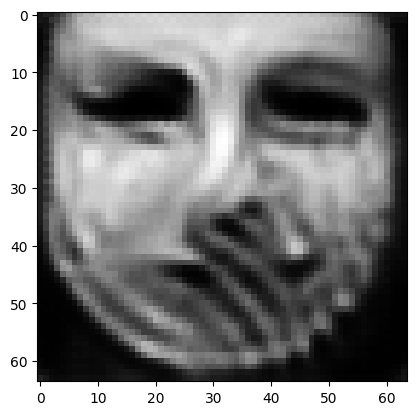

tensor([[1.8288e-04, 6.2495e-06, 9.7358e-01, 6.5663e-04, 2.6554e-04, 3.0757e-03,
         6.8420e-05, 2.1894e-03, 2.2035e-04, 4.0625e-04, 2.3522e-04, 6.4150e-04,
         1.3615e-04, 3.6039e-06, 1.0964e-06, 4.3782e-05, 5.6130e-04, 1.0559e-04,
         6.5096e-05, 3.9227e-04, 8.4154e-05, 8.4111e-05, 1.6247e-06, 3.4651e-05,
         7.4868e-05, 4.4574e-04, 2.2584e-05, 7.6966e-04, 7.5741e-03, 2.3696e-05,
         1.4069e-04, 3.1207e-06, 6.2127e-04, 2.7258e-04, 1.1878e-04, 9.5455e-07,
         1.0677e-04, 8.0332e-04, 4.5200e-03, 1.4571e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.026771994307637215
tensor([[1.8261e-04, 6.2312e-06, 9.7364e-01, 6.5538e-04, 2.6481e-04, 3.0677e-03,
         6.8185e-05, 2.1852e-03, 2.1980e-04, 4.0572e-04, 2.3468e-04, 6.4081e-04,
         1.3578e-04, 3.5945e-06, 1.0934e-06, 4.3685e-05, 5.6074e-04, 1.0539e-04,
         6.4958e-05, 3.9150e-04, 8.3920e-05, 8.3951e-05, 1.6196e-06, 3.4616e-05,
         7.4677e-05, 4.4501e-04, 2.2498e-

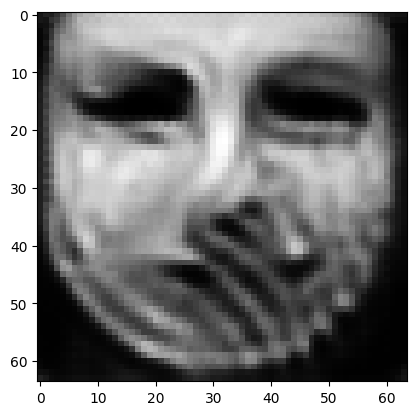

tensor([[1.8158e-04, 6.1622e-06, 9.7388e-01, 6.5062e-04, 2.6209e-04, 3.0363e-03,
         6.7257e-05, 2.1689e-03, 2.1772e-04, 4.0378e-04, 2.3261e-04, 6.3811e-04,
         1.3435e-04, 3.5592e-06, 1.0828e-06, 4.3323e-05, 5.5857e-04, 1.0466e-04,
         6.4439e-05, 3.8857e-04, 8.3043e-05, 8.3354e-05, 1.5996e-06, 3.4482e-05,
         7.3936e-05, 4.4222e-04, 2.2159e-05, 7.6183e-04, 7.4909e-03, 2.3377e-05,
         1.3942e-04, 3.0820e-06, 6.1398e-04, 2.6942e-04, 1.1767e-04, 9.3720e-07,
         1.0578e-04, 8.0024e-04, 4.4596e-03, 1.4290e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.026466941460967064
tensor([[1.8133e-04, 6.1454e-06, 9.7394e-01, 6.4953e-04, 2.6142e-04, 3.0284e-03,
         6.7028e-05, 2.1653e-03, 2.1723e-04, 4.0328e-04, 2.3213e-04, 6.3742e-04,
         1.3400e-04, 3.5511e-06, 1.0801e-06, 4.3231e-05, 5.5807e-04, 1.0446e-04,
         6.4310e-05, 3.8786e-04, 8.2815e-05, 8.3212e-05, 1.5948e-06, 3.4453e-05,
         7.3767e-05, 4.4160e-04, 2.2074e-

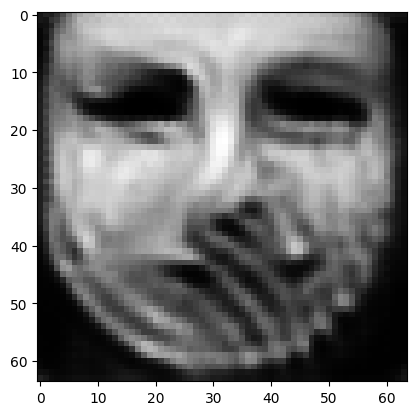

tensor([[1.8042e-04, 6.0777e-06, 9.7416e-01, 6.4483e-04, 2.5879e-04, 2.9983e-03,
         6.6166e-05, 2.1509e-03, 2.1525e-04, 4.0143e-04, 2.3024e-04, 6.3490e-04,
         1.3263e-04, 3.5172e-06, 1.0700e-06, 4.2889e-05, 5.5617e-04, 1.0378e-04,
         6.3801e-05, 3.8522e-04, 8.1984e-05, 8.2661e-05, 1.5756e-06, 3.4339e-05,
         7.3074e-05, 4.3888e-04, 2.1753e-05, 7.5458e-04, 7.4090e-03, 2.3072e-05,
         1.3829e-04, 3.0454e-06, 6.0746e-04, 2.6646e-04, 1.1659e-04, 9.2111e-07,
         1.0486e-04, 7.9754e-04, 4.4020e-03, 1.4019e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02617596462368965
tensor([[1.8024e-04, 6.0603e-06, 9.7422e-01, 6.4361e-04, 2.5816e-04, 2.9912e-03,
         6.5965e-05, 2.1474e-03, 2.1472e-04, 4.0098e-04, 2.2976e-04, 6.3418e-04,
         1.3226e-04, 3.5082e-06, 1.0675e-06, 4.2806e-05, 5.5573e-04, 1.0363e-04,
         6.3676e-05, 3.8459e-04, 8.1773e-05, 8.2520e-05, 1.5705e-06, 3.4309e-05,
         7.2903e-05, 4.3814e-04, 2.1678e-0

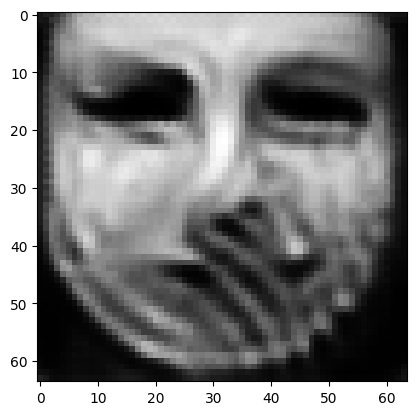

tensor([[1.7936e-04, 5.9958e-06, 9.7443e-01, 6.3927e-04, 2.5565e-04, 2.9638e-03,
         6.5160e-05, 2.1346e-03, 2.1278e-04, 3.9914e-04, 2.2795e-04, 6.3144e-04,
         1.3092e-04, 3.4743e-06, 1.0573e-06, 4.2483e-05, 5.5407e-04, 1.0296e-04,
         6.3202e-05, 3.8185e-04, 8.0962e-05, 8.1972e-05, 1.5520e-06, 3.4189e-05,
         7.2221e-05, 4.3546e-04, 2.1370e-05, 7.4772e-04, 7.3318e-03, 2.2778e-05,
         1.3714e-04, 3.0080e-06, 6.0095e-04, 2.6347e-04, 1.1557e-04, 9.0557e-07,
         1.0394e-04, 7.9486e-04, 4.3454e-03, 1.3766e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02589953877031803
tensor([[1.7915e-04, 5.9812e-06, 9.7448e-01, 6.3836e-04, 2.5503e-04, 2.9571e-03,
         6.4966e-05, 2.1312e-03, 2.1232e-04, 3.9868e-04, 2.2751e-04, 6.3080e-04,
         1.3061e-04, 3.4667e-06, 1.0548e-06, 4.2407e-05, 5.5367e-04, 1.0280e-04,
         6.3093e-05, 3.8115e-04, 8.0772e-05, 8.1841e-05, 1.5477e-06, 3.4157e-05,
         7.2053e-05, 4.3487e-04, 2.1300e-0

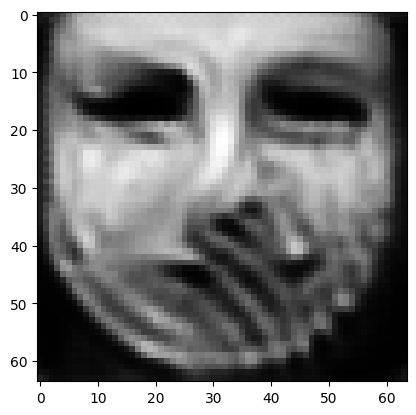

tensor([[1.7827e-04, 5.9233e-06, 9.7468e-01, 6.3449e-04, 2.5265e-04, 2.9316e-03,
         6.4210e-05, 2.1181e-03, 2.1058e-04, 3.9689e-04, 2.2578e-04, 6.2840e-04,
         1.2945e-04, 3.4362e-06, 1.0455e-06, 4.2120e-05, 5.5199e-04, 1.0215e-04,
         6.2658e-05, 3.7852e-04, 8.0063e-05, 8.1332e-05, 1.5313e-06, 3.4033e-05,
         7.1396e-05, 4.3237e-04, 2.1024e-05, 7.4115e-04, 7.2617e-03, 2.2513e-05,
         1.3613e-04, 2.9725e-06, 5.9485e-04, 2.6072e-04, 1.1464e-04, 8.9119e-07,
         1.0307e-04, 7.9231e-04, 4.2928e-03, 1.3541e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.025643717497587204
tensor([[1.7806e-04, 5.9098e-06, 9.7473e-01, 6.3365e-04, 2.5207e-04, 2.9252e-03,
         6.4029e-05, 2.1148e-03, 2.1017e-04, 3.9642e-04, 2.2536e-04, 6.2781e-04,
         1.2918e-04, 3.4293e-06, 1.0433e-06, 4.2052e-05, 5.5162e-04, 1.0199e-04,
         6.2556e-05, 3.7785e-04, 7.9900e-05, 8.1205e-05, 1.5275e-06, 3.4004e-05,
         7.1240e-05, 4.3178e-04, 2.0957e-

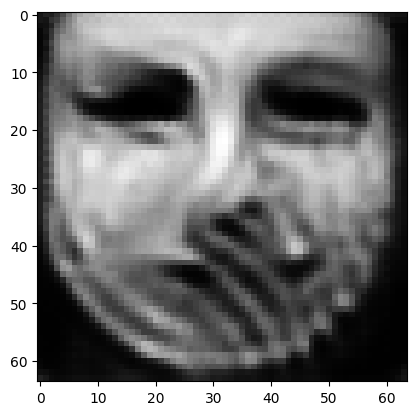

tensor([[1.7726e-04, 5.8591e-06, 9.7492e-01, 6.3063e-04, 2.4986e-04, 2.8999e-03,
         6.3329e-05, 2.1021e-03, 2.0861e-04, 3.9456e-04, 2.2376e-04, 6.2540e-04,
         1.2812e-04, 3.4040e-06, 1.0349e-06, 4.1787e-05, 5.5021e-04, 1.0142e-04,
         6.2166e-05, 3.7524e-04, 7.9250e-05, 8.0710e-05, 1.5134e-06, 3.3892e-05,
         7.0666e-05, 4.2957e-04, 2.0704e-05, 7.3516e-04, 7.1959e-03, 2.2279e-05,
         1.3527e-04, 2.9386e-06, 5.8899e-04, 2.5813e-04, 1.1381e-04, 8.7827e-07,
         1.0227e-04, 7.9025e-04, 4.2435e-03, 1.3331e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02540328912436962
tensor([[1.7706e-04, 5.8466e-06, 9.7496e-01, 6.2986e-04, 2.4931e-04, 2.8938e-03,
         6.3160e-05, 2.0991e-03, 2.0824e-04, 3.9410e-04, 2.2338e-04, 6.2482e-04,
         1.2787e-04, 3.3979e-06, 1.0329e-06, 4.1722e-05, 5.4986e-04, 1.0128e-04,
         6.2069e-05, 3.7462e-04, 7.9094e-05, 8.0591e-05, 1.5100e-06, 3.3864e-05,
         7.0524e-05, 4.2901e-04, 2.0641e-0

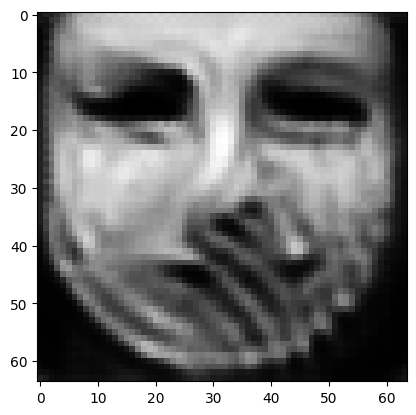

tensor([[1.7629e-04, 5.7945e-06, 9.7514e-01, 6.2674e-04, 2.4721e-04, 2.8701e-03,
         6.2509e-05, 2.0872e-03, 2.0676e-04, 3.9230e-04, 2.2181e-04, 6.2249e-04,
         1.2683e-04, 3.3710e-06, 1.0244e-06, 4.1461e-05, 5.4846e-04, 1.0073e-04,
         6.1674e-05, 3.7213e-04, 7.8465e-05, 8.0112e-05, 1.4959e-06, 3.3759e-05,
         6.9994e-05, 4.2687e-04, 2.0399e-05, 7.2932e-04, 7.1310e-03, 2.2048e-05,
         1.3444e-04, 2.9056e-06, 5.8357e-04, 2.5563e-04, 1.1303e-04, 8.6607e-07,
         1.0149e-04, 7.8834e-04, 4.1966e-03, 1.3133e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.025172684341669083
tensor([[1.7607e-04, 5.7812e-06, 9.7519e-01, 6.2591e-04, 2.4669e-04, 2.8642e-03,
         6.2343e-05, 2.0842e-03, 2.0642e-04, 3.9185e-04, 2.2141e-04, 6.2193e-04,
         1.2660e-04, 3.3639e-06, 1.0222e-06, 4.1396e-05, 5.4806e-04, 1.0058e-04,
         6.1573e-05, 3.7149e-04, 7.8316e-05, 7.9994e-05, 1.4924e-06, 3.3731e-05,
         6.9859e-05, 4.2632e-04, 2.0337e-

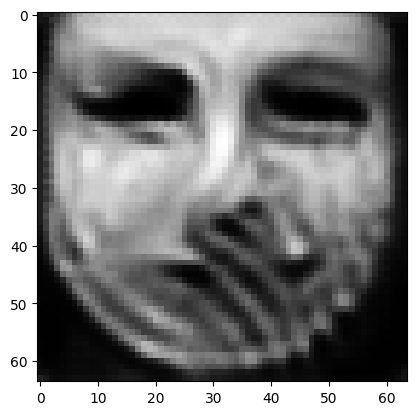

tensor([[1.7515e-04, 5.7386e-06, 9.7536e-01, 6.2341e-04, 2.4461e-04, 2.8389e-03,
         6.1637e-05, 2.0687e-03, 2.0526e-04, 3.8996e-04, 2.1994e-04, 6.1999e-04,
         1.2576e-04, 3.3446e-06, 1.0151e-06, 4.1150e-05, 5.4650e-04, 1.0003e-04,
         6.1199e-05, 3.6901e-04, 7.7801e-05, 7.9530e-05, 1.4812e-06, 3.3607e-05,
         6.9381e-05, 4.2449e-04, 2.0109e-05, 7.2332e-04, 7.0693e-03, 2.1857e-05,
         1.3389e-04, 2.8739e-06, 5.7848e-04, 2.5339e-04, 1.1237e-04, 8.5464e-07,
         1.0080e-04, 7.8627e-04, 4.1514e-03, 1.2954e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02494621090590954
tensor([[1.7488e-04, 5.7297e-06, 9.7541e-01, 6.2277e-04, 2.4408e-04, 2.8326e-03,
         6.1452e-05, 2.0640e-03, 2.0503e-04, 3.8948e-04, 2.1958e-04, 6.1964e-04,
         1.2560e-04, 3.3407e-06, 1.0136e-06, 4.1092e-05, 5.4597e-04, 9.9898e-05,
         6.1109e-05, 3.6840e-04, 7.7700e-05, 7.9418e-05, 1.4788e-06, 3.3564e-05,
         6.9253e-05, 4.2400e-04, 2.0057e-0

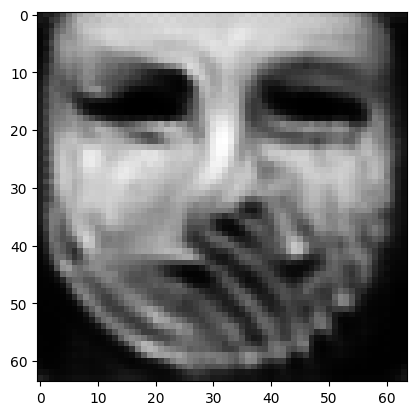

tensor([[1.7387e-04, 5.6961e-06, 9.7557e-01, 6.2048e-04, 2.4206e-04, 2.8086e-03,
         6.0748e-05, 2.0464e-03, 2.0409e-04, 3.8770e-04, 2.1821e-04, 6.1822e-04,
         1.2492e-04, 3.3260e-06, 1.0076e-06, 4.0869e-05, 5.4409e-04, 9.9380e-05,
         6.0768e-05, 3.6599e-04, 7.7280e-05, 7.8983e-05, 1.4695e-06, 3.3405e-05,
         6.8766e-05, 4.2226e-04, 1.9859e-05, 7.1717e-04, 7.0149e-03, 2.1708e-05,
         1.3349e-04, 2.8447e-06, 5.7370e-04, 2.5142e-04, 1.1183e-04, 8.4421e-07,
         1.0021e-04, 7.8430e-04, 4.1059e-03, 1.2808e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.024730967357754707
tensor([[1.7362e-04, 5.6888e-06, 9.7561e-01, 6.1990e-04, 2.4158e-04, 2.8029e-03,
         6.0582e-05, 2.0423e-03, 2.0388e-04, 3.8729e-04, 2.1790e-04, 6.1791e-04,
         1.2478e-04, 3.3227e-06, 1.0062e-06, 4.0817e-05, 5.4360e-04, 9.9253e-05,
         6.0688e-05, 3.6542e-04, 7.7185e-05, 7.8883e-05, 1.4674e-06, 3.3365e-05,
         6.8644e-05, 4.2181e-04, 1.9812e-

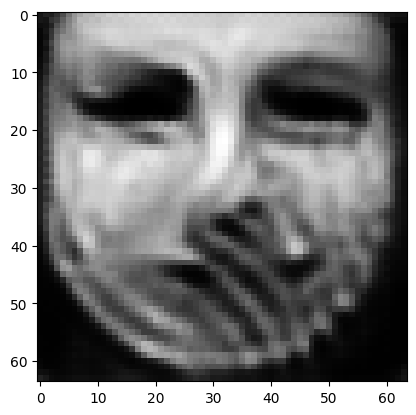

tensor([[1.7267e-04, 5.6584e-06, 9.7576e-01, 6.1738e-04, 2.3971e-04, 2.7816e-03,
         5.9958e-05, 2.0266e-03, 2.0293e-04, 3.8578e-04, 2.1672e-04, 6.1676e-04,
         1.2413e-04, 3.3081e-06, 1.0005e-06, 4.0623e-05, 5.4183e-04, 9.8780e-05,
         6.0371e-05, 3.6319e-04, 7.6794e-05, 7.8493e-05, 1.4586e-06, 3.3208e-05,
         6.8147e-05, 4.2006e-04, 1.9637e-05, 7.1158e-04, 6.9647e-03, 2.1566e-05,
         1.3309e-04, 2.8178e-06, 5.6935e-04, 2.4963e-04, 1.1128e-04, 8.3441e-07,
         9.9647e-05, 7.8238e-04, 4.0639e-03, 1.2680e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.024534057825803757
tensor([[1.7244e-04, 5.6516e-06, 9.7580e-01, 6.1682e-04, 2.3928e-04, 2.7763e-03,
         5.9808e-05, 2.0227e-03, 2.0271e-04, 3.8541e-04, 2.1643e-04, 6.1645e-04,
         1.2399e-04, 3.3053e-06, 9.9921e-07, 4.0575e-05, 5.4141e-04, 9.8674e-05,
         6.0297e-05, 3.6268e-04, 7.6702e-05, 7.8399e-05, 1.4566e-06, 3.3171e-05,
         6.8037e-05, 4.1965e-04, 1.9596e-

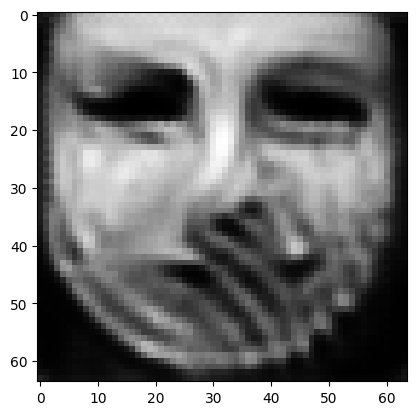

tensor([[1.7159e-04, 5.6244e-06, 9.7594e-01, 6.1474e-04, 2.3773e-04, 2.7551e-03,
         5.9242e-05, 2.0084e-03, 2.0181e-04, 3.8390e-04, 2.1536e-04, 6.1506e-04,
         1.2340e-04, 3.2948e-06, 9.9435e-07, 4.0388e-05, 5.3998e-04, 9.8280e-05,
         6.0009e-05, 3.6071e-04, 7.6339e-05, 7.8023e-05, 1.4491e-06, 3.3045e-05,
         6.7663e-05, 4.1817e-04, 1.9433e-05, 7.0682e-04, 6.9185e-03, 2.1444e-05,
         1.3277e-04, 2.7942e-06, 5.6544e-04, 2.4810e-04, 1.1079e-04, 8.2615e-07,
         9.9208e-05, 7.8084e-04, 4.0261e-03, 1.2556e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.024353278800845146
tensor([[1.7140e-04, 5.6180e-06, 9.7597e-01, 6.1434e-04, 2.3738e-04, 2.7497e-03,
         5.9104e-05, 2.0051e-03, 2.0160e-04, 3.8354e-04, 2.1510e-04, 6.1468e-04,
         1.2326e-04, 3.2926e-06, 9.9324e-07, 4.0339e-05, 5.3967e-04, 9.8188e-05,
         5.9942e-05, 3.6023e-04, 7.6249e-05, 7.7932e-05, 1.4474e-06, 3.3019e-05,
         6.7588e-05, 4.1788e-04, 1.9393e-

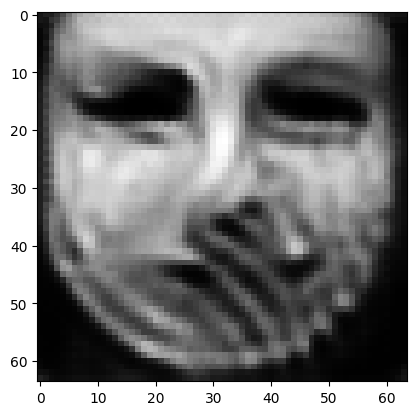

tensor([[1.7066e-04, 5.5914e-06, 9.7610e-01, 6.1244e-04, 2.3603e-04, 2.7300e-03,
         5.8596e-05, 1.9927e-03, 2.0076e-04, 3.8217e-04, 2.1413e-04, 6.1329e-04,
         1.2269e-04, 3.2824e-06, 9.8882e-07, 4.0159e-05, 5.3836e-04, 9.7838e-05,
         5.9672e-05, 3.5847e-04, 7.5898e-05, 7.7589e-05, 1.4401e-06, 3.2910e-05,
         6.7268e-05, 4.1658e-04, 1.9239e-05, 7.0275e-04, 6.8763e-03, 2.1328e-05,
         1.3250e-04, 2.7734e-06, 5.6184e-04, 2.4671e-04, 1.1032e-04, 8.1901e-07,
         9.8841e-05, 7.7954e-04, 3.9919e-03, 1.2435e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.024188295006752014
tensor([[1.7048e-04, 5.5849e-06, 9.7613e-01, 6.1199e-04, 2.3571e-04, 2.7253e-03,
         5.8474e-05, 1.9898e-03, 2.0056e-04, 3.8184e-04, 2.1390e-04, 6.1294e-04,
         1.2255e-04, 3.2798e-06, 9.8771e-07, 4.0115e-05, 5.3805e-04, 9.7752e-05,
         5.9606e-05, 3.5805e-04, 7.5810e-05, 7.7506e-05, 1.4384e-06, 3.2884e-05,
         6.7193e-05, 4.1627e-04, 1.9202e-

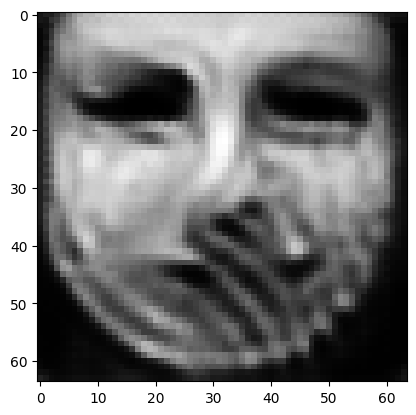

tensor([[1.6981e-04, 5.5602e-06, 9.7625e-01, 6.1031e-04, 2.3449e-04, 2.7071e-03,
         5.8005e-05, 1.9785e-03, 1.9979e-04, 3.8053e-04, 2.1300e-04, 6.1160e-04,
         1.2203e-04, 3.2705e-06, 9.8357e-07, 3.9945e-05, 5.3684e-04, 9.7431e-05,
         5.9357e-05, 3.5642e-04, 7.5475e-05, 7.7188e-05, 1.4317e-06, 3.2785e-05,
         6.6908e-05, 4.1506e-04, 1.9060e-05, 6.9906e-04, 6.8363e-03, 2.1214e-05,
         1.3225e-04, 2.7544e-06, 5.5851e-04, 2.4541e-04, 1.0988e-04, 8.1244e-07,
         9.8509e-05, 7.7838e-04, 3.9603e-03, 1.2322e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.024035152047872543
tensor([[1.6964e-04, 5.5544e-06, 9.7628e-01, 6.0991e-04, 2.3419e-04, 2.7026e-03,
         5.7891e-05, 1.9758e-03, 1.9963e-04, 3.8020e-04, 2.1278e-04, 6.1128e-04,
         1.2192e-04, 3.2684e-06, 9.8262e-07, 3.9903e-05, 5.3653e-04, 9.7352e-05,
         5.9297e-05, 3.5604e-04, 7.5401e-05, 7.7112e-05, 1.4303e-06, 3.2761e-05,
         6.6843e-05, 4.1476e-04, 1.9025e-

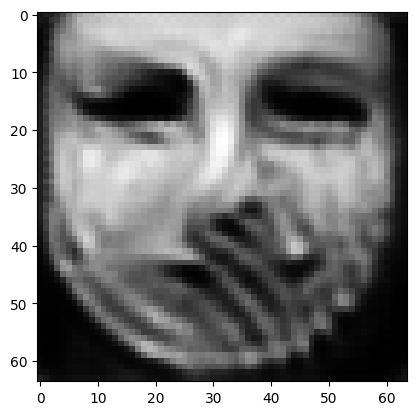

tensor([[1.6900e-04, 5.5317e-06, 9.7639e-01, 6.0838e-04, 2.3305e-04, 2.6854e-03,
         5.7454e-05, 1.9653e-03, 1.9892e-04, 3.7895e-04, 2.1194e-04, 6.0997e-04,
         1.2145e-04, 3.2598e-06, 9.7881e-07, 3.9744e-05, 5.3545e-04, 9.7050e-05,
         5.9067e-05, 3.5448e-04, 7.5090e-05, 7.6814e-05, 1.4242e-06, 3.2670e-05,
         6.6581e-05, 4.1365e-04, 1.8891e-05, 6.9564e-04, 6.7982e-03, 2.1111e-05,
         1.3203e-04, 2.7365e-06, 5.5540e-04, 2.4420e-04, 1.0947e-04, 8.0627e-07,
         9.8191e-05, 7.7718e-04, 3.9317e-03, 1.2216e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.023891881108283997
tensor([[1.6884e-04, 5.5261e-06, 9.7642e-01, 6.0799e-04, 2.3276e-04, 2.6813e-03,
         5.7347e-05, 1.9628e-03, 1.9875e-04, 3.7865e-04, 2.1173e-04, 6.0969e-04,
         1.2132e-04, 3.2575e-06, 9.7788e-07, 3.9706e-05, 5.3516e-04, 9.6974e-05,
         5.9011e-05, 3.5409e-04, 7.5014e-05, 7.6743e-05, 1.4226e-06, 3.2647e-05,
         6.6511e-05, 4.1337e-04, 1.8858e-

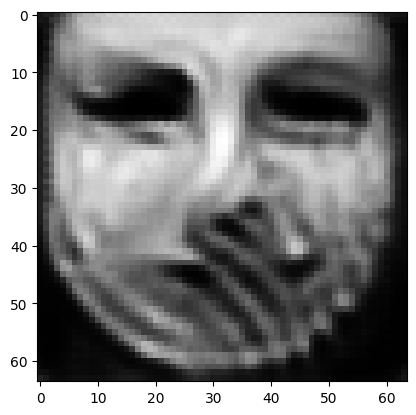

tensor([[1.6822e-04, 5.5048e-06, 9.7652e-01, 6.0638e-04, 2.3165e-04, 2.6659e-03,
         5.6950e-05, 1.9530e-03, 1.9803e-04, 3.7755e-04, 2.1096e-04, 6.0867e-04,
         1.2084e-04, 3.2483e-06, 9.7410e-07, 3.9568e-05, 5.3411e-04, 9.6679e-05,
         5.8801e-05, 3.5257e-04, 7.4722e-05, 7.6478e-05, 1.4167e-06, 3.2556e-05,
         6.6219e-05, 4.1228e-04, 1.8737e-05, 6.9238e-04, 6.7642e-03, 2.1008e-05,
         1.3177e-04, 2.7198e-06, 5.5237e-04, 2.4303e-04, 1.0906e-04, 8.0031e-07,
         9.7878e-05, 7.7607e-04, 3.9037e-03, 1.2120e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02375894784927368
tensor([[1.6806e-04, 5.5000e-06, 9.7655e-01, 6.0598e-04, 2.3137e-04, 2.6622e-03,
         5.6852e-05, 1.9506e-03, 1.9788e-04, 3.7727e-04, 2.1078e-04, 6.0844e-04,
         1.2075e-04, 3.2463e-06, 9.7324e-07, 3.9535e-05, 5.3382e-04, 9.6605e-05,
         5.8750e-05, 3.5221e-04, 7.4658e-05, 7.6414e-05, 1.4153e-06, 3.2532e-05,
         6.6148e-05, 4.1200e-04, 1.8708e-0

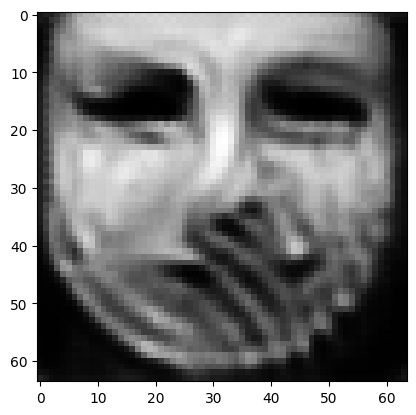

tensor([[1.6747e-04, 5.4785e-06, 9.7664e-01, 6.0436e-04, 2.3031e-04, 2.6475e-03,
         5.6480e-05, 1.9417e-03, 1.9719e-04, 3.7625e-04, 2.1004e-04, 6.0739e-04,
         1.2027e-04, 3.2368e-06, 9.6951e-07, 3.9404e-05, 5.3291e-04, 9.6296e-05,
         5.8553e-05, 3.5073e-04, 7.4366e-05, 7.6168e-05, 1.4094e-06, 3.2453e-05,
         6.5862e-05, 4.1099e-04, 1.8586e-05, 6.8931e-04, 6.7310e-03, 2.0909e-05,
         1.3152e-04, 2.7033e-06, 5.4947e-04, 2.4197e-04, 1.0864e-04, 7.9441e-07,
         9.7548e-05, 7.7470e-04, 3.8785e-03, 1.2028e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.023633217439055443
tensor([[1.6731e-04, 5.4728e-06, 9.7667e-01, 6.0392e-04, 2.3004e-04, 2.6436e-03,
         5.6388e-05, 1.9397e-03, 1.9702e-04, 3.7600e-04, 2.0986e-04, 6.0712e-04,
         1.2015e-04, 3.2342e-06, 9.6854e-07, 3.9372e-05, 5.3269e-04, 9.6208e-05,
         5.8505e-05, 3.5035e-04, 7.4290e-05, 7.6111e-05, 1.4079e-06, 3.2434e-05,
         6.5789e-05, 4.1076e-04, 1.8554e-

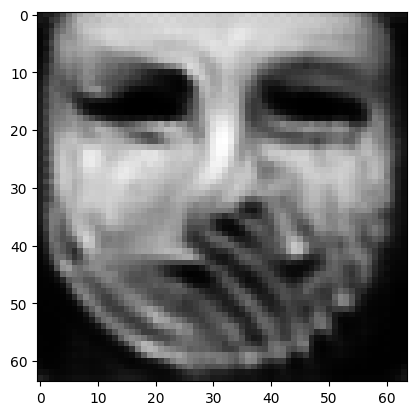

tensor([[1.6675e-04, 5.4513e-06, 9.7676e-01, 6.0218e-04, 2.2903e-04, 2.6293e-03,
         5.6041e-05, 1.9318e-03, 1.9636e-04, 3.7505e-04, 2.0916e-04, 6.0606e-04,
         1.1971e-04, 3.2244e-06, 9.6496e-07, 3.9250e-05, 5.3185e-04, 9.5890e-05,
         5.8316e-05, 3.4896e-04, 7.4005e-05, 7.5891e-05, 1.4021e-06, 3.2364e-05,
         6.5509e-05, 4.0974e-04, 1.8435e-05, 6.8643e-04, 6.6972e-03, 2.0808e-05,
         1.3128e-04, 2.6865e-06, 5.4666e-04, 2.4102e-04, 1.0818e-04, 7.8838e-07,
         9.7181e-05, 7.7306e-04, 3.8567e-03, 1.1938e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0235129427164793
tensor([[1.6663e-04, 5.4461e-06, 9.7678e-01, 6.0177e-04, 2.2879e-04, 2.6258e-03,
         5.5958e-05, 1.9300e-03, 1.9621e-04, 3.7482e-04, 2.0900e-04, 6.0579e-04,
         1.1961e-04, 3.2221e-06, 9.6416e-07, 3.9220e-05, 5.3164e-04, 9.5817e-05,
         5.8270e-05, 3.4864e-04, 7.3936e-05, 7.5838e-05, 1.4008e-06, 3.2349e-05,
         6.5448e-05, 4.0949e-04, 1.8406e-05

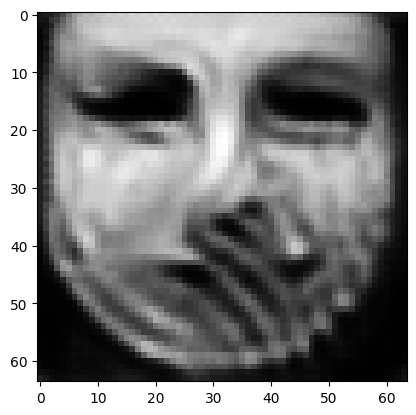

tensor([[1.6612e-04, 5.4265e-06, 9.7687e-01, 6.0014e-04, 2.2787e-04, 2.6124e-03,
         5.5634e-05, 1.9225e-03, 1.9564e-04, 3.7389e-04, 2.0832e-04, 6.0478e-04,
         1.1924e-04, 3.2132e-06, 9.6103e-07, 3.9103e-05, 5.3073e-04, 9.5535e-05,
         5.8087e-05, 3.4740e-04, 7.3680e-05, 7.5625e-05, 1.3956e-06, 3.2279e-05,
         6.5197e-05, 4.0845e-04, 1.8300e-05, 6.8374e-04, 6.6640e-03, 2.0712e-05,
         1.3104e-04, 2.6708e-06, 5.4413e-04, 2.4015e-04, 1.0777e-04, 7.8288e-07,
         9.6829e-05, 7.7156e-04, 3.8370e-03, 1.1856e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02339964173734188
tensor([[1.6599e-04, 5.4218e-06, 9.7689e-01, 5.9975e-04, 2.2765e-04, 2.6092e-03,
         5.5555e-05, 1.9207e-03, 1.9550e-04, 3.7366e-04, 2.0816e-04, 6.0453e-04,
         1.1915e-04, 3.2111e-06, 9.6025e-07, 3.9074e-05, 5.3051e-04, 9.5466e-05,
         5.8042e-05, 3.4710e-04, 7.3617e-05, 7.5574e-05, 1.3943e-06, 3.2261e-05,
         6.5136e-05, 4.0820e-04, 1.8274e-0

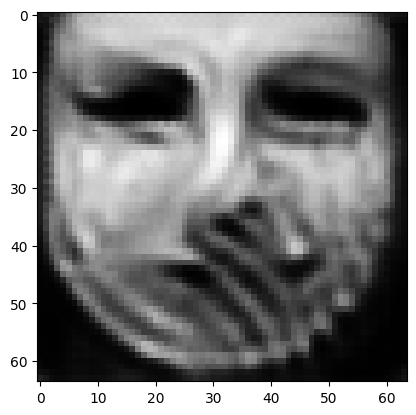

tensor([[1.6551e-04, 5.4037e-06, 9.7698e-01, 5.9827e-04, 2.2678e-04, 2.5966e-03,
         5.5247e-05, 1.9136e-03, 1.9497e-04, 3.7277e-04, 2.0751e-04, 6.0354e-04,
         1.1881e-04, 3.2028e-06, 9.5731e-07, 3.8963e-05, 5.2966e-04, 9.5199e-05,
         5.7870e-05, 3.4592e-04, 7.3375e-05, 7.5370e-05, 1.3895e-06, 3.2194e-05,
         6.4904e-05, 4.0721e-04, 1.8173e-05, 6.8117e-04, 6.6327e-03, 2.0623e-05,
         1.3082e-04, 2.6557e-06, 5.4170e-04, 2.3932e-04, 1.0740e-04, 7.7768e-07,
         9.6493e-05, 7.7012e-04, 3.8183e-03, 1.1778e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.023292500525712967
tensor([[1.6539e-04, 5.3992e-06, 9.7700e-01, 5.9791e-04, 2.2657e-04, 2.5936e-03,
         5.5173e-05, 1.9119e-03, 1.9484e-04, 3.7256e-04, 2.0735e-04, 6.0330e-04,
         1.1873e-04, 3.2007e-06, 9.5659e-07, 3.8935e-05, 5.2944e-04, 9.5133e-05,
         5.7828e-05, 3.4564e-04, 7.3315e-05, 7.5322e-05, 1.3883e-06, 3.2177e-05,
         6.4846e-05, 4.0697e-04, 1.8149e-

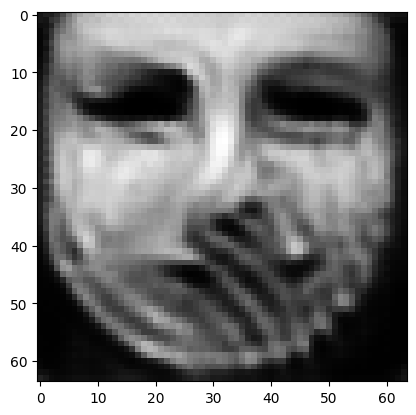

tensor([[1.6493e-04, 5.3822e-06, 9.7707e-01, 5.9650e-04, 2.2574e-04, 2.5817e-03,
         5.4882e-05, 1.9053e-03, 1.9436e-04, 3.7173e-04, 2.0674e-04, 6.0240e-04,
         1.1841e-04, 3.1929e-06, 9.5384e-07, 3.8829e-05, 5.2858e-04, 9.4877e-05,
         5.7667e-05, 3.4454e-04, 7.3087e-05, 7.5134e-05, 1.3837e-06, 3.2111e-05,
         6.4624e-05, 4.0604e-04, 1.8056e-05, 6.7873e-04, 6.6034e-03, 2.0539e-05,
         1.3061e-04, 2.6416e-06, 5.3943e-04, 2.3854e-04, 1.0704e-04, 7.7279e-07,
         9.6171e-05, 7.6878e-04, 3.8009e-03, 1.1707e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02319221757352352
tensor([[1.6482e-04, 5.3780e-06, 9.7709e-01, 5.9615e-04, 2.2555e-04, 2.5788e-03,
         5.4813e-05, 1.9037e-03, 1.9425e-04, 3.7152e-04, 2.0659e-04, 6.0215e-04,
         1.1834e-04, 3.1910e-06, 9.5321e-07, 3.8804e-05, 5.2836e-04, 9.4818e-05,
         5.7627e-05, 3.4429e-04, 7.3035e-05, 7.5089e-05, 1.3826e-06, 3.2095e-05,
         6.4574e-05, 4.0580e-04, 1.8034e-0

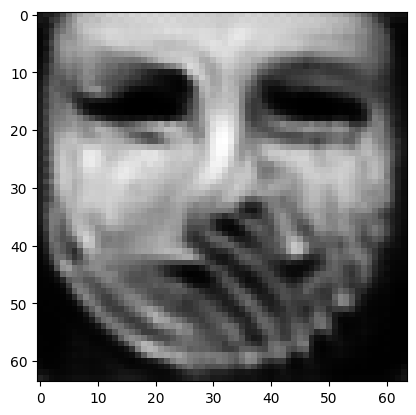

tensor([[1.6438e-04, 5.3622e-06, 9.7717e-01, 5.9473e-04, 2.2481e-04, 2.5677e-03,
         5.4545e-05, 1.8973e-03, 1.9382e-04, 3.7071e-04, 2.0601e-04, 6.0125e-04,
         1.1807e-04, 3.1839e-06, 9.5076e-07, 3.8708e-05, 5.2749e-04, 9.4588e-05,
         5.7473e-05, 3.4330e-04, 7.2834e-05, 7.4914e-05, 1.3785e-06, 3.2027e-05,
         6.4364e-05, 4.0482e-04, 1.7950e-05, 6.7642e-04, 6.5750e-03, 2.0461e-05,
         1.3041e-04, 2.6281e-06, 5.3736e-04, 2.3784e-04, 1.0672e-04, 7.6824e-07,
         9.5866e-05, 7.6743e-04, 3.7851e-03, 1.1642e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.023097751662135124
tensor([[1.6428e-04, 5.3584e-06, 9.7718e-01, 5.9439e-04, 2.2464e-04, 2.5651e-03,
         5.4481e-05, 1.8958e-03, 1.9371e-04, 3.7052e-04, 2.0587e-04, 6.0103e-04,
         1.1800e-04, 3.1822e-06, 9.5018e-07, 3.8685e-05, 5.2730e-04, 9.4534e-05,
         5.7436e-05, 3.4306e-04, 7.2786e-05, 7.4871e-05, 1.3775e-06, 3.2011e-05,
         6.4314e-05, 4.0458e-04, 1.7930e-

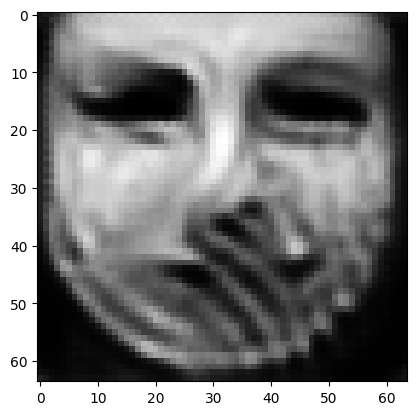

tensor([[1.6388e-04, 5.3434e-06, 9.7725e-01, 5.9299e-04, 2.2395e-04, 2.5552e-03,
         5.4238e-05, 1.8898e-03, 1.9331e-04, 3.6976e-04, 2.0534e-04, 6.0024e-04,
         1.1775e-04, 3.1750e-06, 9.4785e-07, 3.8598e-05, 5.2649e-04, 9.4324e-05,
         5.7293e-05, 3.4214e-04, 7.2604e-05, 7.4709e-05, 1.3736e-06, 3.1947e-05,
         6.4111e-05, 4.0363e-04, 1.7854e-05, 6.7426e-04, 6.5488e-03, 2.0387e-05,
         1.3019e-04, 2.6156e-06, 5.3542e-04, 2.3718e-04, 1.0643e-04, 7.6397e-07,
         9.5582e-05, 7.6615e-04, 3.7703e-03, 1.1584e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.023010382428765297
tensor([[1.6379e-04, 5.3397e-06, 9.7727e-01, 5.9265e-04, 2.2378e-04, 2.5528e-03,
         5.4180e-05, 1.8884e-03, 1.9322e-04, 3.6958e-04, 2.0521e-04, 6.0005e-04,
         1.1768e-04, 3.1732e-06, 9.4731e-07, 3.8577e-05, 5.2630e-04, 9.4277e-05,
         5.7258e-05, 3.4193e-04, 7.2562e-05, 7.4670e-05, 1.3727e-06, 3.1932e-05,
         6.4063e-05, 4.0339e-04, 1.7836e-

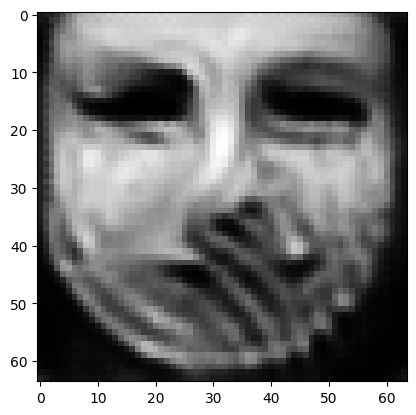

tensor([[1.6342e-04, 5.3265e-06, 9.7733e-01, 5.9136e-04, 2.2316e-04, 2.5439e-03,
         5.3957e-05, 1.8827e-03, 1.9286e-04, 3.6886e-04, 2.0472e-04, 5.9936e-04,
         1.1747e-04, 3.1668e-06, 9.4524e-07, 3.8500e-05, 5.2555e-04, 9.4092e-05,
         5.7126e-05, 3.4108e-04, 7.2405e-05, 7.4520e-05, 1.3692e-06, 3.1872e-05,
         6.3872e-05, 4.0247e-04, 1.7769e-05, 6.7228e-04, 6.5246e-03, 2.0319e-05,
         1.2998e-04, 2.6040e-06, 5.3359e-04, 2.3655e-04, 1.0617e-04, 7.6003e-07,
         9.5320e-05, 7.6495e-04, 3.7565e-03, 1.1532e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02292953059077263
tensor([[1.6333e-04, 5.3233e-06, 9.7735e-01, 5.9105e-04, 2.2301e-04, 2.5417e-03,
         5.3902e-05, 1.8814e-03, 1.9277e-04, 3.6868e-04, 2.0461e-04, 5.9920e-04,
         1.1741e-04, 3.1652e-06, 9.4471e-07, 3.8481e-05, 5.2537e-04, 9.4047e-05,
         5.7094e-05, 3.4087e-04, 7.2366e-05, 7.4484e-05, 1.3683e-06, 3.1857e-05,
         6.3827e-05, 4.0225e-04, 1.7752e-0

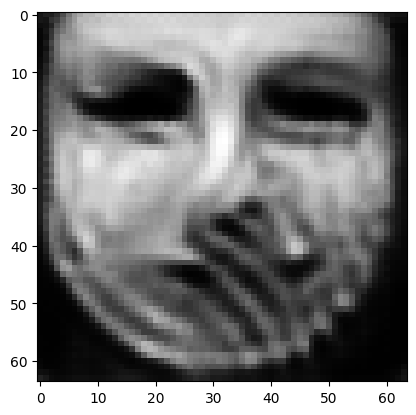

tensor([[1.6297e-04, 5.3112e-06, 9.7741e-01, 5.8992e-04, 2.2243e-04, 2.5330e-03,
         5.3688e-05, 1.8760e-03, 1.9244e-04, 3.6797e-04, 2.0414e-04, 5.9851e-04,
         1.1722e-04, 3.1597e-06, 9.4282e-07, 3.8405e-05, 5.2467e-04, 9.3876e-05,
         5.6971e-05, 3.4008e-04, 7.2218e-05, 7.4342e-05, 1.3653e-06, 3.1802e-05,
         6.3662e-05, 4.0141e-04, 1.7687e-05, 6.7048e-04, 6.5016e-03, 2.0255e-05,
         1.2980e-04, 2.5933e-06, 5.3188e-04, 2.3597e-04, 1.0594e-04, 7.5639e-07,
         9.5086e-05, 7.6384e-04, 3.7435e-03, 1.1483e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02285333164036274
tensor([[1.6288e-04, 5.3085e-06, 9.7742e-01, 5.8964e-04, 2.2230e-04, 2.5309e-03,
         5.3635e-05, 1.8746e-03, 1.9236e-04, 3.6778e-04, 2.0403e-04, 5.9835e-04,
         1.1718e-04, 3.1585e-06, 9.4237e-07, 3.8387e-05, 5.2449e-04, 9.3834e-05,
         5.6941e-05, 3.3987e-04, 7.2184e-05, 7.4307e-05, 1.3646e-06, 3.1787e-05,
         6.3620e-05, 4.0120e-04, 1.7672e-0

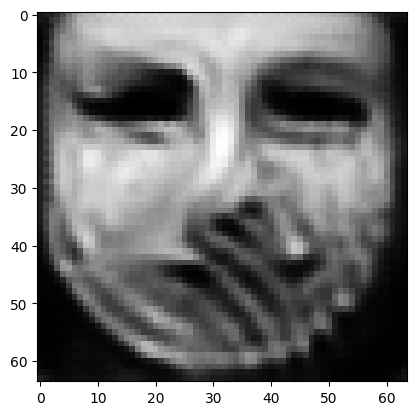

tensor([[1.6253e-04, 5.2980e-06, 9.7748e-01, 5.8864e-04, 2.2177e-04, 2.5225e-03,
         5.3428e-05, 1.8691e-03, 1.9207e-04, 3.6705e-04, 2.0358e-04, 5.9769e-04,
         1.1702e-04, 3.1541e-06, 9.4075e-07, 3.8313e-05, 5.2378e-04, 9.3682e-05,
         5.6825e-05, 3.3912e-04, 7.2056e-05, 7.4169e-05, 1.3620e-06, 3.1732e-05,
         6.3473e-05, 4.0041e-04, 1.7613e-05, 6.6874e-04, 6.4796e-03, 2.0198e-05,
         1.2963e-04, 2.5833e-06, 5.3024e-04, 2.3544e-04, 1.0574e-04, 7.5305e-07,
         9.4875e-05, 7.6277e-04, 3.7316e-03, 1.1437e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02278073877096176
tensor([[1.6245e-04, 5.2954e-06, 9.7749e-01, 5.8841e-04, 2.2165e-04, 2.5204e-03,
         5.3378e-05, 1.8679e-03, 1.9200e-04, 3.6687e-04, 2.0347e-04, 5.9753e-04,
         1.1699e-04, 3.1531e-06, 9.4037e-07, 3.8295e-05, 5.2361e-04, 9.3646e-05,
         5.6796e-05, 3.3894e-04, 7.2024e-05, 7.4135e-05, 1.3614e-06, 3.1720e-05,
         6.3439e-05, 4.0022e-04, 1.7598e-0

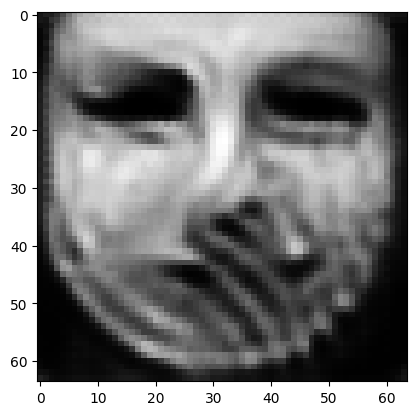

tensor([[1.6213e-04, 5.2857e-06, 9.7754e-01, 5.8750e-04, 2.2116e-04, 2.5125e-03,
         5.3182e-05, 1.8627e-03, 1.9174e-04, 3.6618e-04, 2.0305e-04, 5.9691e-04,
         1.1684e-04, 3.1491e-06, 9.3884e-07, 3.8224e-05, 5.2291e-04, 9.3498e-05,
         5.6687e-05, 3.3822e-04, 7.1899e-05, 7.4006e-05, 1.3590e-06, 3.1668e-05,
         6.3303e-05, 3.9949e-04, 1.7542e-05, 6.6714e-04, 6.4588e-03, 2.0144e-05,
         1.2947e-04, 2.5740e-06, 5.2868e-04, 2.3495e-04, 1.0555e-04, 7.4997e-07,
         9.4681e-05, 7.6179e-04, 3.7203e-03, 1.1394e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.0227122213691473
tensor([[1.6205e-04, 5.2834e-06, 9.7756e-01, 5.8728e-04, 2.2104e-04, 2.5106e-03,
         5.3134e-05, 1.8614e-03, 1.9167e-04, 3.6601e-04, 2.0295e-04, 5.9676e-04,
         1.1681e-04, 3.1481e-06, 9.3846e-07, 3.8207e-05, 5.2273e-04, 9.3461e-05,
         5.6661e-05, 3.3804e-04, 7.1868e-05, 7.3975e-05, 1.3584e-06, 3.1655e-05,
         6.3269e-05, 3.9931e-04, 1.7529e-05

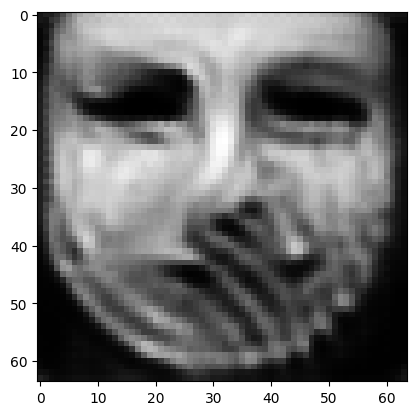

tensor([[1.6174e-04, 5.2741e-06, 9.7761e-01, 5.8640e-04, 2.2057e-04, 2.5032e-03,
         5.2952e-05, 1.8566e-03, 1.9141e-04, 3.6537e-04, 2.0255e-04, 5.9621e-04,
         1.1666e-04, 3.1442e-06, 9.3698e-07, 3.8142e-05, 5.2207e-04, 9.3321e-05,
         5.6559e-05, 3.3736e-04, 7.1750e-05, 7.3854e-05, 1.3561e-06, 3.1605e-05,
         6.3135e-05, 3.9862e-04, 1.7477e-05, 6.6561e-04, 6.4396e-03, 2.0093e-05,
         1.2932e-04, 2.5654e-06, 5.2720e-04, 2.3447e-04, 1.0537e-04, 7.4704e-07,
         9.4500e-05, 7.6088e-04, 3.7094e-03, 1.1354e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02264777570962906
tensor([[1.6167e-04, 5.2721e-06, 9.7762e-01, 5.8624e-04, 2.2047e-04, 2.5013e-03,
         5.2906e-05, 1.8555e-03, 1.9135e-04, 3.6521e-04, 2.0246e-04, 5.9605e-04,
         1.1664e-04, 3.1436e-06, 9.3668e-07, 3.8126e-05, 5.2193e-04, 9.3289e-05,
         5.6535e-05, 3.3720e-04, 7.1722e-05, 7.3823e-05, 1.3557e-06, 3.1595e-05,
         6.3109e-05, 3.9847e-04, 1.7464e-0

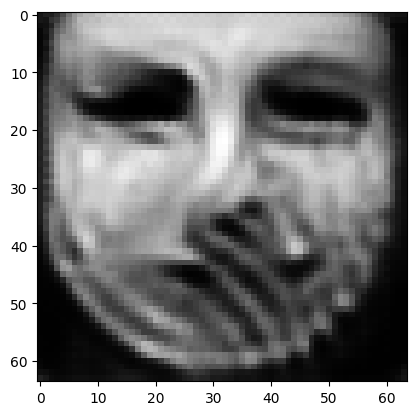

tensor([[1.6138e-04, 5.2631e-06, 9.7767e-01, 5.8540e-04, 2.2002e-04, 2.4944e-03,
         5.2734e-05, 1.8509e-03, 1.9109e-04, 3.6462e-04, 2.0209e-04, 5.9554e-04,
         1.1649e-04, 3.1396e-06, 9.3520e-07, 3.8064e-05, 5.2131e-04, 9.3150e-05,
         5.6439e-05, 3.3654e-04, 7.1605e-05, 7.3711e-05, 1.3534e-06, 3.1548e-05,
         6.2977e-05, 3.9783e-04, 1.7414e-05, 6.6420e-04, 6.4214e-03, 2.0044e-05,
         1.2919e-04, 2.5574e-06, 5.2580e-04, 2.3402e-04, 1.0519e-04, 7.4429e-07,
         9.4333e-05, 7.6003e-04, 3.6991e-03, 1.1315e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022587290033698082
tensor([[1.6130e-04, 5.2611e-06, 9.7768e-01, 5.8523e-04, 2.1991e-04, 2.4927e-03,
         5.2691e-05, 1.8499e-03, 1.9103e-04, 3.6447e-04, 2.0200e-04, 5.9540e-04,
         1.1646e-04, 3.1388e-06, 9.3485e-07, 3.8049e-05, 5.2116e-04, 9.3115e-05,
         5.6416e-05, 3.3637e-04, 7.1576e-05, 7.3683e-05, 1.3528e-06, 3.1537e-05,
         6.2948e-05, 3.9769e-04, 1.7401e-

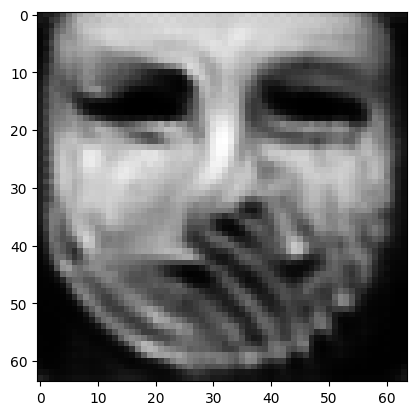

tensor([[1.6102e-04, 5.2530e-06, 9.7772e-01, 5.8448e-04, 2.1949e-04, 2.4861e-03,
         5.2525e-05, 1.8455e-03, 1.9079e-04, 3.6390e-04, 2.0164e-04, 5.9489e-04,
         1.1633e-04, 3.1353e-06, 9.3349e-07, 3.7991e-05, 5.2057e-04, 9.2984e-05,
         5.6325e-05, 3.3573e-04, 7.1468e-05, 7.3575e-05, 1.3508e-06, 3.1491e-05,
         6.2824e-05, 3.9707e-04, 1.7354e-05, 6.6286e-04, 6.4042e-03, 1.9999e-05,
         1.2907e-04, 2.5495e-06, 5.2443e-04, 2.3359e-04, 1.0503e-04, 7.4165e-07,
         9.4171e-05, 7.5918e-04, 3.6893e-03, 1.1279e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02252948097884655
tensor([[1.6095e-04, 5.2510e-06, 9.7773e-01, 5.8430e-04, 2.1939e-04, 2.4844e-03,
         5.2485e-05, 1.8445e-03, 1.9074e-04, 3.6376e-04, 2.0155e-04, 5.9476e-04,
         1.1630e-04, 3.1345e-06, 9.3319e-07, 3.7976e-05, 5.2041e-04, 9.2952e-05,
         5.6303e-05, 3.3558e-04, 7.1442e-05, 7.3549e-05, 1.3503e-06, 3.1480e-05,
         6.2796e-05, 3.9692e-04, 1.7342e-0

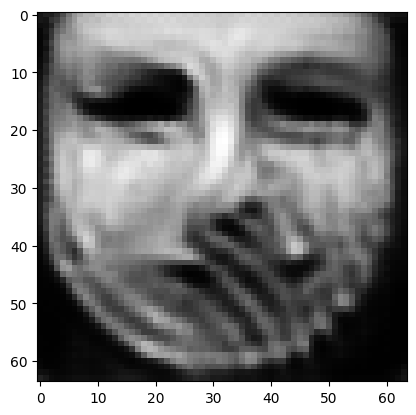

tensor([[1.6067e-04, 5.2431e-06, 9.7778e-01, 5.8351e-04, 2.1898e-04, 2.4782e-03,
         5.2329e-05, 1.8404e-03, 1.9051e-04, 3.6321e-04, 2.0121e-04, 5.9428e-04,
         1.1619e-04, 3.1310e-06, 9.3188e-07, 3.7922e-05, 5.1985e-04, 9.2825e-05,
         5.6217e-05, 3.3495e-04, 7.1339e-05, 7.3447e-05, 1.3483e-06, 3.1436e-05,
         6.2671e-05, 3.9631e-04, 1.7297e-05, 6.6157e-04, 6.3873e-03, 1.9953e-05,
         1.2894e-04, 2.5419e-06, 5.2312e-04, 2.3318e-04, 1.0486e-04, 7.3904e-07,
         9.4008e-05, 7.5829e-04, 3.6801e-03, 1.1244e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022474117577075958
tensor([[1.6061e-04, 5.2414e-06, 9.7779e-01, 5.8333e-04, 2.1889e-04, 2.4765e-03,
         5.2291e-05, 1.8394e-03, 1.9046e-04, 3.6308e-04, 2.0113e-04, 5.9414e-04,
         1.1617e-04, 3.1303e-06, 9.3161e-07, 3.7908e-05, 5.1972e-04, 9.2796e-05,
         5.6196e-05, 3.3481e-04, 7.1315e-05, 7.3422e-05, 1.3479e-06, 3.1426e-05,
         6.2646e-05, 3.9616e-04, 1.7285e-

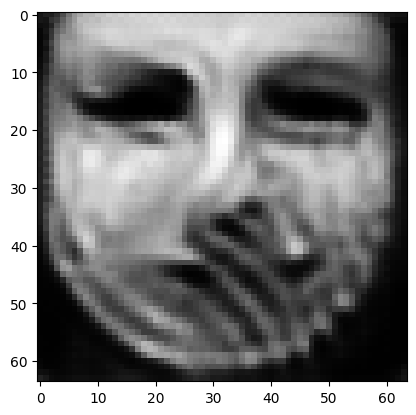

tensor([[1.6033e-04, 5.2341e-06, 9.7783e-01, 5.8261e-04, 2.1850e-04, 2.4706e-03,
         5.2143e-05, 1.8356e-03, 1.9024e-04, 3.6256e-04, 2.0080e-04, 5.9367e-04,
         1.1606e-04, 3.1270e-06, 9.3034e-07, 3.7857e-05, 5.1920e-04, 9.2669e-05,
         5.6116e-05, 3.3420e-04, 7.1218e-05, 7.3326e-05, 1.3461e-06, 3.1383e-05,
         6.2526e-05, 3.9559e-04, 1.7241e-05, 6.6036e-04, 6.3711e-03, 1.9911e-05,
         1.2883e-04, 2.5346e-06, 5.2186e-04, 2.3280e-04, 1.0470e-04, 7.3653e-07,
         9.3851e-05, 7.5739e-04, 3.6716e-03, 1.1212e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02242143079638481
tensor([[1.6027e-04, 5.2322e-06, 9.7784e-01, 5.8243e-04, 2.1841e-04, 2.4692e-03,
         5.2107e-05, 1.8346e-03, 1.9019e-04, 3.6243e-04, 2.0072e-04, 5.9356e-04,
         1.1603e-04, 3.1261e-06, 9.3003e-07, 3.7845e-05, 5.1907e-04, 9.2638e-05,
         5.6097e-05, 3.3405e-04, 7.1194e-05, 7.3303e-05, 1.3456e-06, 3.1373e-05,
         6.2496e-05, 3.9545e-04, 1.7231e-0

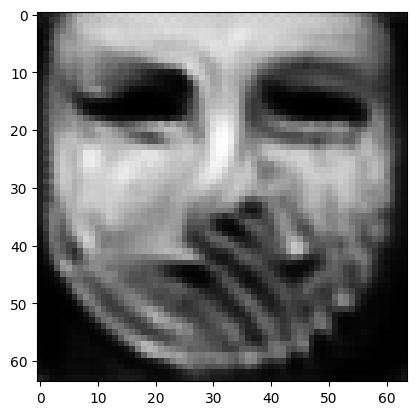

tensor([[1.6001e-04, 5.2253e-06, 9.7788e-01, 5.8173e-04, 2.1805e-04, 2.4636e-03,
         5.1969e-05, 1.8310e-03, 1.8999e-04, 3.6194e-04, 2.0040e-04, 5.9309e-04,
         1.1594e-04, 3.1230e-06, 9.2886e-07, 3.7798e-05, 5.1858e-04, 9.2519e-05,
         5.6021e-05, 3.3348e-04, 7.1103e-05, 7.3214e-05, 1.3439e-06, 3.1333e-05,
         6.2383e-05, 3.9490e-04, 1.7189e-05, 6.5922e-04, 6.3557e-03, 1.9869e-05,
         1.2873e-04, 2.5274e-06, 5.2066e-04, 2.3244e-04, 1.0455e-04, 7.3410e-07,
         9.3698e-05, 7.5648e-04, 3.6638e-03, 1.1181e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022371888160705566
tensor([[1.5995e-04, 5.2237e-06, 9.7789e-01, 5.8157e-04, 2.1796e-04, 2.4622e-03,
         5.1934e-05, 1.8301e-03, 1.8994e-04, 3.6182e-04, 2.0033e-04, 5.9298e-04,
         1.1591e-04, 3.1223e-06, 9.2860e-07, 3.7786e-05, 5.1846e-04, 9.2490e-05,
         5.6003e-05, 3.3334e-04, 7.1082e-05, 7.3192e-05, 1.3435e-06, 3.1323e-05,
         6.2356e-05, 3.9477e-04, 1.7179e-

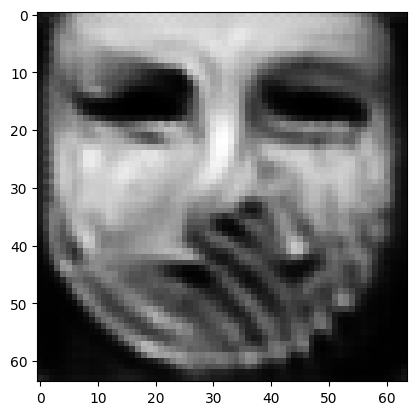

tensor([[1.5971e-04, 5.2169e-06, 9.7792e-01, 5.8089e-04, 2.1761e-04, 2.4568e-03,
         5.1802e-05, 1.8266e-03, 1.8975e-04, 3.6135e-04, 2.0003e-04, 5.9255e-04,
         1.1582e-04, 3.1193e-06, 9.2748e-07, 3.7741e-05, 5.1801e-04, 9.2378e-05,
         5.5931e-05, 3.3279e-04, 7.0994e-05, 7.3107e-05, 1.3418e-06, 3.1286e-05,
         6.2248e-05, 3.9425e-04, 1.7139e-05, 6.5813e-04, 6.3412e-03, 1.9831e-05,
         1.2863e-04, 2.5208e-06, 5.1953e-04, 2.3211e-04, 1.0440e-04, 7.3181e-07,
         9.3554e-05, 7.5566e-04, 3.6564e-03, 1.1152e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02232479304075241
tensor([[1.5965e-04, 5.2152e-06, 9.7793e-01, 5.8072e-04, 2.1752e-04, 2.4555e-03,
         5.1771e-05, 1.8259e-03, 1.8970e-04, 3.6124e-04, 1.9995e-04, 5.9244e-04,
         1.1579e-04, 3.1184e-06, 9.2720e-07, 3.7730e-05, 5.1791e-04, 9.2350e-05,
         5.5914e-05, 3.3266e-04, 7.0972e-05, 7.3086e-05, 1.3414e-06, 3.1278e-05,
         6.2222e-05, 3.9412e-04, 1.7129e-0

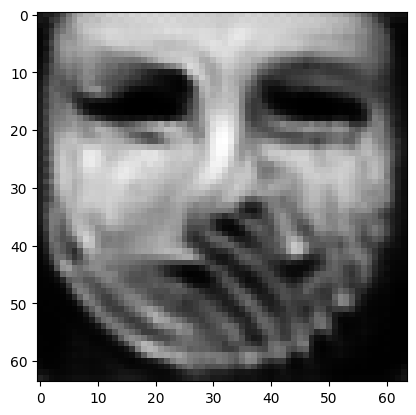

tensor([[1.5942e-04, 5.2084e-06, 9.7797e-01, 5.8004e-04, 2.1717e-04, 2.4505e-03,
         5.1647e-05, 1.8227e-03, 1.8950e-04, 3.6084e-04, 1.9967e-04, 5.9206e-04,
         1.1568e-04, 3.1151e-06, 9.2604e-07, 3.7689e-05, 5.1749e-04, 9.2239e-05,
         5.5845e-05, 3.3213e-04, 7.0884e-05, 7.3007e-05, 1.3396e-06, 3.1242e-05,
         6.2111e-05, 3.9363e-04, 1.7090e-05, 6.5707e-04, 6.3276e-03, 1.9793e-05,
         1.2852e-04, 2.5144e-06, 5.1844e-04, 2.3177e-04, 1.0425e-04, 7.2957e-07,
         9.3409e-05, 7.5487e-04, 3.6490e-03, 1.1124e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022280026227235794
tensor([[1.5937e-04, 5.2067e-06, 9.7797e-01, 5.7986e-04, 2.1709e-04, 2.4494e-03,
         5.1617e-05, 1.8219e-03, 1.8945e-04, 3.6074e-04, 1.9961e-04, 5.9197e-04,
         1.1565e-04, 3.1142e-06, 9.2575e-07, 3.7679e-05, 5.1739e-04, 9.2212e-05,
         5.5829e-05, 3.3201e-04, 7.0863e-05, 7.2988e-05, 1.3392e-06, 3.1234e-05,
         6.2083e-05, 3.9351e-04, 1.7081e-

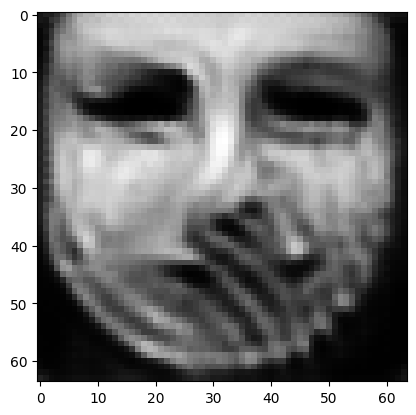

tensor([[1.5915e-04, 5.2003e-06, 9.7801e-01, 5.7919e-04, 2.1675e-04, 2.4448e-03,
         5.1502e-05, 1.8189e-03, 1.8926e-04, 3.6035e-04, 1.9934e-04, 5.9161e-04,
         1.1554e-04, 3.1110e-06, 9.2463e-07, 3.7640e-05, 5.1699e-04, 9.2105e-05,
         5.5764e-05, 3.3150e-04, 7.0779e-05, 7.2914e-05, 1.3375e-06, 3.1199e-05,
         6.1975e-05, 3.9304e-04, 1.7045e-05, 6.5605e-04, 6.3149e-03, 1.9756e-05,
         1.2842e-04, 2.5083e-06, 5.1741e-04, 2.3144e-04, 1.0411e-04, 7.2743e-07,
         9.3271e-05, 7.5413e-04, 3.6419e-03, 1.1097e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022237705066800117
tensor([[1.5910e-04, 5.1987e-06, 9.7802e-01, 5.7901e-04, 2.1667e-04, 2.4437e-03,
         5.1474e-05, 1.8182e-03, 1.8921e-04, 3.6027e-04, 1.9928e-04, 5.9153e-04,
         1.1551e-04, 3.1101e-06, 9.2434e-07, 3.7631e-05, 5.1689e-04, 9.2080e-05,
         5.5749e-05, 3.3138e-04, 7.0759e-05, 7.2896e-05, 1.3371e-06, 3.1191e-05,
         6.1946e-05, 3.9292e-04, 1.7036e-

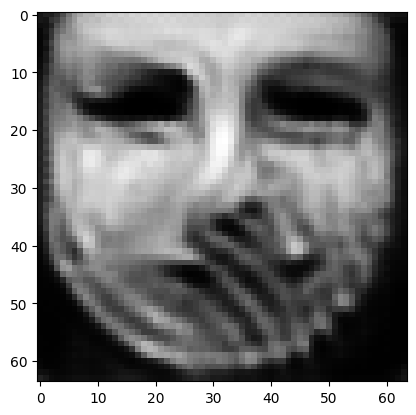

tensor([[1.5889e-04, 5.1925e-06, 9.7805e-01, 5.7838e-04, 2.1637e-04, 2.4394e-03,
         5.1366e-05, 1.8155e-03, 1.8902e-04, 3.5989e-04, 1.9903e-04, 5.9118e-04,
         1.1541e-04, 3.1069e-06, 9.2326e-07, 3.7594e-05, 5.1654e-04, 9.1980e-05,
         5.5688e-05, 3.3089e-04, 7.0679e-05, 7.2825e-05, 1.3355e-06, 3.1160e-05,
         6.1845e-05, 3.9248e-04, 1.7002e-05, 6.5511e-04, 6.3028e-03, 1.9720e-05,
         1.2831e-04, 2.5025e-06, 5.1643e-04, 2.3113e-04, 1.0397e-04, 7.2541e-07,
         9.3140e-05, 7.5341e-04, 3.6351e-03, 1.1073e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022197948768734932
tensor([[1.5884e-04, 5.1910e-06, 9.7805e-01, 5.7823e-04, 2.1629e-04, 2.4384e-03,
         5.1340e-05, 1.8148e-03, 1.8897e-04, 3.5981e-04, 1.9897e-04, 5.9110e-04,
         1.1538e-04, 3.1061e-06, 9.2297e-07, 3.7586e-05, 5.1645e-04, 9.1955e-05,
         5.5673e-05, 3.3077e-04, 7.0659e-05, 7.2807e-05, 1.3350e-06, 3.1152e-05,
         6.1819e-05, 3.9237e-04, 1.6994e-

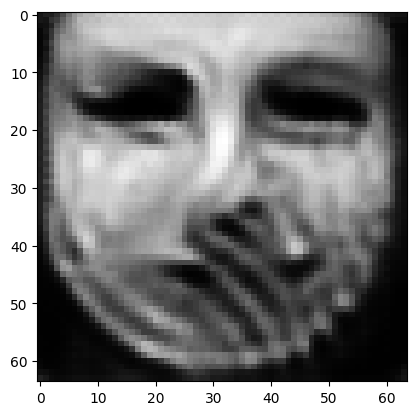

tensor([[1.5866e-04, 5.1854e-06, 9.7808e-01, 5.7773e-04, 2.1601e-04, 2.4340e-03,
         5.1236e-05, 1.8121e-03, 1.8880e-04, 3.5943e-04, 1.9873e-04, 5.9076e-04,
         1.1528e-04, 3.1037e-06, 9.2206e-07, 3.7549e-05, 5.1614e-04, 9.1866e-05,
         5.5616e-05, 3.3032e-04, 7.0585e-05, 7.2739e-05, 1.3337e-06, 3.1127e-05,
         6.1737e-05, 3.9201e-04, 1.6960e-05, 6.5425e-04, 6.2916e-03, 1.9689e-05,
         1.2823e-04, 2.4972e-06, 5.1552e-04, 2.3084e-04, 1.0385e-04, 7.2362e-07,
         9.3027e-05, 7.5278e-04, 3.6289e-03, 1.1048e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022160405293107033
tensor([[1.5862e-04, 5.1839e-06, 9.7809e-01, 5.7761e-04, 2.1594e-04, 2.4329e-03,
         5.1210e-05, 1.8115e-03, 1.8876e-04, 3.5934e-04, 1.9867e-04, 5.9067e-04,
         1.1526e-04, 3.1031e-06, 9.2184e-07, 3.7539e-05, 5.1607e-04, 9.1845e-05,
         5.5601e-05, 3.3022e-04, 7.0567e-05, 7.2722e-05, 1.3333e-06, 3.1122e-05,
         6.1720e-05, 3.9194e-04, 1.6952e-

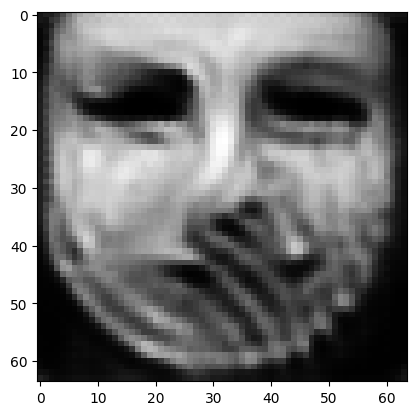

tensor([[1.5846e-04, 5.1785e-06, 9.7812e-01, 5.7717e-04, 2.1568e-04, 2.4286e-03,
         5.1109e-05, 1.8090e-03, 1.8859e-04, 3.5898e-04, 1.9845e-04, 5.9033e-04,
         1.1516e-04, 3.1012e-06, 9.2105e-07, 3.7503e-05, 5.1580e-04, 9.1762e-05,
         5.5546e-05, 3.2982e-04, 7.0496e-05, 7.2656e-05, 1.3320e-06, 3.1104e-05,
         6.1653e-05, 3.9164e-04, 1.6920e-05, 6.5345e-04, 6.2812e-03, 1.9661e-05,
         1.2816e-04, 2.4927e-06, 5.1470e-04, 2.3059e-04, 1.0375e-04, 7.2205e-07,
         9.2932e-05, 7.5225e-04, 3.6233e-03, 1.1022e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02212519198656082
tensor([[1.5842e-04, 5.1773e-06, 9.7812e-01, 5.7709e-04, 2.1562e-04, 2.4275e-03,
         5.1084e-05, 1.8084e-03, 1.8856e-04, 3.5889e-04, 1.9839e-04, 5.9024e-04,
         1.1514e-04, 3.1008e-06, 9.2089e-07, 3.7493e-05, 5.1573e-04, 9.1743e-05,
         5.5532e-05, 3.2973e-04, 7.0479e-05, 7.2640e-05, 1.3318e-06, 3.1100e-05,
         6.1641e-05, 3.9157e-04, 1.6912e-0

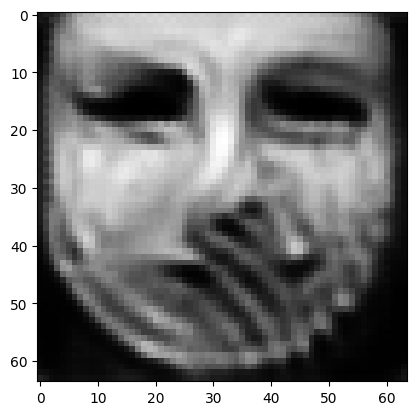

tensor([[1.5827e-04, 5.1720e-06, 9.7815e-01, 5.7666e-04, 2.1538e-04, 2.4235e-03,
         5.0990e-05, 1.8060e-03, 1.8839e-04, 3.5855e-04, 1.9818e-04, 5.8993e-04,
         1.1505e-04, 3.0988e-06, 9.2009e-07, 3.7459e-05, 5.1546e-04, 9.1663e-05,
         5.5479e-05, 3.2934e-04, 7.0410e-05, 7.2579e-05, 1.3305e-06, 3.1081e-05,
         6.1574e-05, 3.9129e-04, 1.6882e-05, 6.5269e-04, 6.2714e-03, 1.9634e-05,
         1.2810e-04, 2.4884e-06, 5.1394e-04, 2.3036e-04, 1.0364e-04, 7.2058e-07,
         9.2844e-05, 7.5175e-04, 3.6180e-03, 1.0998e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022092076018452644
tensor([[1.5823e-04, 5.1708e-06, 9.7816e-01, 5.7656e-04, 2.1532e-04, 2.4225e-03,
         5.0967e-05, 1.8055e-03, 1.8836e-04, 3.5847e-04, 1.9813e-04, 5.8985e-04,
         1.1503e-04, 3.0983e-06, 9.1991e-07, 3.7450e-05, 5.1540e-04, 9.1644e-05,
         5.5466e-05, 3.2926e-04, 7.0394e-05, 7.2564e-05, 1.3302e-06, 3.1077e-05,
         6.1560e-05, 3.9122e-04, 1.6875e-

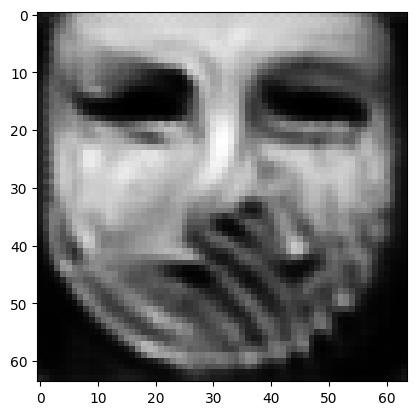

tensor([[1.5809e-04, 5.1659e-06, 9.7818e-01, 5.7614e-04, 2.1509e-04, 2.4187e-03,
         5.0880e-05, 1.8033e-03, 1.8820e-04, 3.5816e-04, 1.9793e-04, 5.8956e-04,
         1.1494e-04, 3.0964e-06, 9.1916e-07, 3.7418e-05, 5.1513e-04, 9.1567e-05,
         5.5416e-05, 3.2891e-04, 7.0329e-05, 7.2508e-05, 1.3290e-06, 3.1060e-05,
         6.1495e-05, 3.9095e-04, 1.6847e-05, 6.5199e-04, 6.2622e-03, 1.9609e-05,
         1.2804e-04, 2.4844e-06, 5.1322e-04, 2.3014e-04, 1.0354e-04, 7.1918e-07,
         9.2759e-05, 7.5126e-04, 3.6129e-03, 1.0975e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022061176598072052
tensor([[1.5805e-04, 5.1646e-06, 9.7819e-01, 5.7604e-04, 2.1503e-04, 2.4178e-03,
         5.0858e-05, 1.8028e-03, 1.8817e-04, 3.5809e-04, 1.9788e-04, 5.8949e-04,
         1.1492e-04, 3.0959e-06, 9.1897e-07, 3.7410e-05, 5.1507e-04, 9.1548e-05,
         5.5404e-05, 3.2882e-04, 7.0313e-05, 7.2495e-05, 1.3287e-06, 3.1055e-05,
         6.1479e-05, 3.9088e-04, 1.6840e-

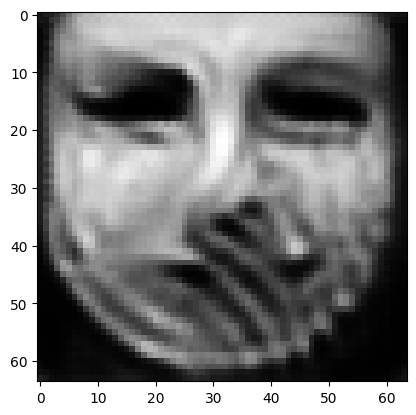

tensor([[1.5791e-04, 5.1600e-06, 9.7821e-01, 5.7566e-04, 2.1481e-04, 2.4143e-03,
         5.0775e-05, 1.8007e-03, 1.8803e-04, 3.5779e-04, 1.9770e-04, 5.8921e-04,
         1.1483e-04, 3.0940e-06, 9.1826e-07, 3.7380e-05, 5.1481e-04, 9.1474e-05,
         5.5356e-05, 3.2849e-04, 7.0251e-05, 7.2442e-05, 1.3275e-06, 3.1038e-05,
         6.1419e-05, 3.9062e-04, 1.6813e-05, 6.5132e-04, 6.2536e-03, 1.9585e-05,
         1.2798e-04, 2.4805e-06, 5.1254e-04, 2.2993e-04, 1.0345e-04, 7.1785e-07,
         9.2677e-05, 7.5079e-04, 3.6081e-03, 1.0954e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02203202247619629
tensor([[1.5788e-04, 5.1589e-06, 9.7821e-01, 5.7557e-04, 2.1476e-04, 2.4134e-03,
         5.0755e-05, 1.8002e-03, 1.8799e-04, 3.5772e-04, 1.9765e-04, 5.8915e-04,
         1.1481e-04, 3.0936e-06, 9.1810e-07, 3.7372e-05, 5.1475e-04, 9.1457e-05,
         5.5345e-05, 3.2841e-04, 7.0237e-05, 7.2429e-05, 1.3273e-06, 3.1035e-05,
         6.1406e-05, 3.9056e-04, 1.6807e-0

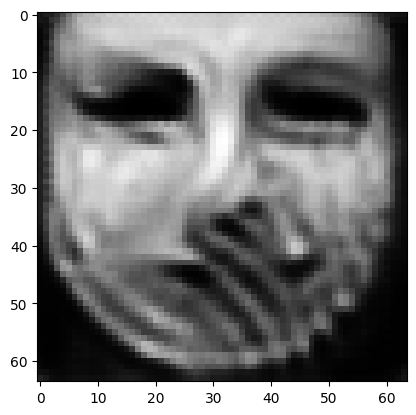

tensor([[1.5776e-04, 5.1545e-06, 9.7824e-01, 5.7522e-04, 2.1456e-04, 2.4100e-03,
         5.0676e-05, 1.7983e-03, 1.8786e-04, 3.5745e-04, 1.9747e-04, 5.8887e-04,
         1.1474e-04, 3.0919e-06, 9.1743e-07, 3.7342e-05, 5.1452e-04, 9.1387e-05,
         5.5300e-05, 3.2809e-04, 7.0178e-05, 7.2379e-05, 1.3262e-06, 3.1019e-05,
         6.1352e-05, 3.9033e-04, 1.6781e-05, 6.5070e-04, 6.2454e-03, 1.9562e-05,
         1.2793e-04, 2.4769e-06, 5.1189e-04, 2.2973e-04, 1.0336e-04, 7.1662e-07,
         9.2601e-05, 7.5036e-04, 3.6037e-03, 1.0934e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.022004036232829094
tensor([[1.5772e-04, 5.1534e-06, 9.7824e-01, 5.7513e-04, 2.1450e-04, 2.4092e-03,
         5.0657e-05, 1.7979e-03, 1.8783e-04, 3.5738e-04, 1.9743e-04, 5.8881e-04,
         1.1472e-04, 3.0915e-06, 9.1726e-07, 3.7335e-05, 5.1446e-04, 9.1370e-05,
         5.5289e-05, 3.2802e-04, 7.0164e-05, 7.2366e-05, 1.3259e-06, 3.1015e-05,
         6.1337e-05, 3.9027e-04, 1.6775e-

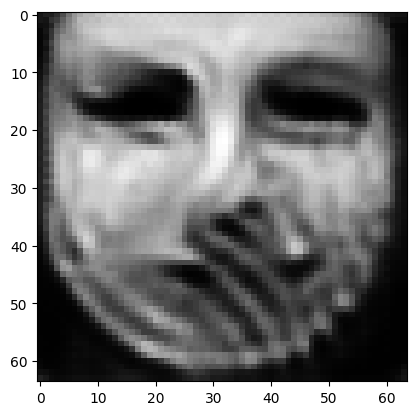

tensor([[1.5760e-04, 5.1493e-06, 9.7826e-01, 5.7479e-04, 2.1431e-04, 2.4060e-03,
         5.0583e-05, 1.7960e-03, 1.8771e-04, 3.5712e-04, 1.9726e-04, 5.8856e-04,
         1.1464e-04, 3.0898e-06, 9.1662e-07, 3.7308e-05, 5.1423e-04, 9.1304e-05,
         5.5247e-05, 3.2771e-04, 7.0109e-05, 7.2319e-05, 1.3249e-06, 3.1000e-05,
         6.1283e-05, 3.9004e-04, 1.6752e-05, 6.5009e-04, 6.2376e-03, 1.9540e-05,
         1.2787e-04, 2.4735e-06, 5.1127e-04, 2.2954e-04, 1.0328e-04, 7.1542e-07,
         9.2527e-05, 7.4994e-04, 3.5994e-03, 1.0916e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02197791449725628
tensor([[1.5757e-04, 5.1483e-06, 9.7827e-01, 5.7471e-04, 2.1426e-04, 2.4052e-03,
         5.0564e-05, 1.7956e-03, 1.8768e-04, 3.5705e-04, 1.9722e-04, 5.8849e-04,
         1.1463e-04, 3.0894e-06, 9.1647e-07, 3.7301e-05, 5.1417e-04, 9.1287e-05,
         5.5237e-05, 3.2764e-04, 7.0095e-05, 7.2307e-05, 1.3247e-06, 3.0996e-05,
         6.1271e-05, 3.8999e-04, 1.6746e-0

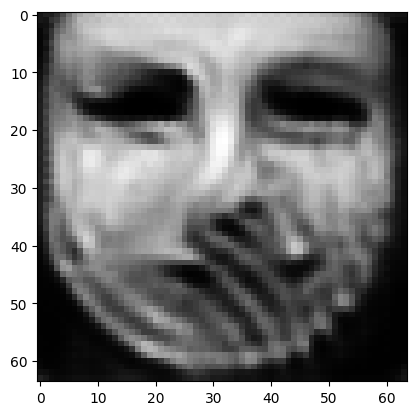

tensor([[1.5745e-04, 5.1444e-06, 9.7829e-01, 5.7441e-04, 2.1405e-04, 2.4022e-03,
         5.0491e-05, 1.7937e-03, 1.8755e-04, 3.5681e-04, 1.9706e-04, 5.8829e-04,
         1.1455e-04, 3.0877e-06, 9.1580e-07, 3.7274e-05, 5.1393e-04, 9.1218e-05,
         5.5197e-05, 3.2732e-04, 7.0040e-05, 7.2263e-05, 1.3236e-06, 3.0980e-05,
         6.1211e-05, 3.8979e-04, 1.6723e-05, 6.4949e-04, 6.2305e-03, 1.9520e-05,
         1.2782e-04, 2.4701e-06, 5.1063e-04, 2.2934e-04, 1.0319e-04, 7.1424e-07,
         9.2454e-05, 7.4954e-04, 3.5950e-03, 1.0898e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021952608600258827
tensor([[1.5742e-04, 5.1436e-06, 9.7829e-01, 5.7434e-04, 2.1400e-04, 2.4014e-03,
         5.0472e-05, 1.7933e-03, 1.8753e-04, 3.5676e-04, 1.9702e-04, 5.8824e-04,
         1.1453e-04, 3.0873e-06, 9.1564e-07, 3.7268e-05, 5.1387e-04, 9.1201e-05,
         5.5188e-05, 3.2724e-04, 7.0027e-05, 7.2252e-05, 1.3234e-06, 3.0976e-05,
         6.1197e-05, 3.8974e-04, 1.6717e-

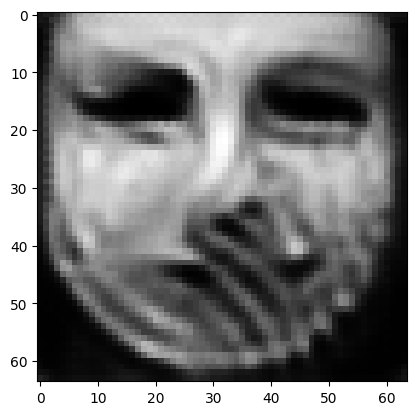

tensor([[1.5730e-04, 5.1401e-06, 9.7831e-01, 5.7408e-04, 2.1380e-04, 2.3984e-03,
         5.0400e-05, 1.7914e-03, 1.8742e-04, 3.5651e-04, 1.9686e-04, 5.8804e-04,
         1.1446e-04, 3.0858e-06, 9.1503e-07, 3.7242e-05, 5.1363e-04, 9.1132e-05,
         5.5150e-05, 3.2694e-04, 6.9977e-05, 7.2209e-05, 1.3225e-06, 3.0960e-05,
         6.1142e-05, 3.8955e-04, 1.6696e-05, 6.4889e-04, 6.2237e-03, 1.9502e-05,
         1.2778e-04, 2.4668e-06, 5.1001e-04, 2.2915e-04, 1.0312e-04, 7.1311e-07,
         9.2383e-05, 7.4918e-04, 3.5908e-03, 1.0881e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02192811667919159
tensor([[1.5727e-04, 5.1392e-06, 9.7831e-01, 5.7403e-04, 2.1375e-04, 2.3977e-03,
         5.0382e-05, 1.7910e-03, 1.8740e-04, 3.5645e-04, 1.9682e-04, 5.8799e-04,
         1.1445e-04, 3.0854e-06, 9.1488e-07, 3.7235e-05, 5.1358e-04, 9.1116e-05,
         5.5141e-05, 3.2686e-04, 6.9965e-05, 7.2199e-05, 1.3223e-06, 3.0956e-05,
         6.1130e-05, 3.8951e-04, 1.6690e-0

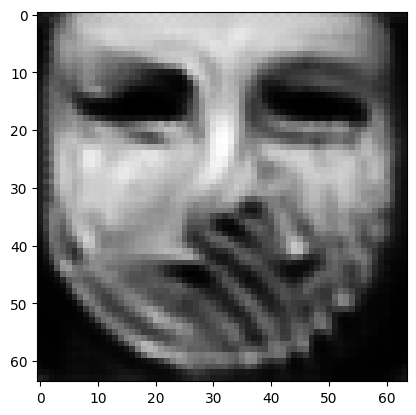

tensor([[1.5716e-04, 5.1358e-06, 9.7833e-01, 5.7379e-04, 2.1356e-04, 2.3949e-03,
         5.0314e-05, 1.7892e-03, 1.8730e-04, 3.5622e-04, 1.9667e-04, 5.8781e-04,
         1.1438e-04, 3.0840e-06, 9.1430e-07, 3.7211e-05, 5.1336e-04, 9.1053e-05,
         5.5106e-05, 3.2657e-04, 6.9918e-05, 7.2158e-05, 1.3214e-06, 3.0941e-05,
         6.1080e-05, 3.8933e-04, 1.6670e-05, 6.4831e-04, 6.2174e-03, 1.9484e-05,
         1.2775e-04, 2.4637e-06, 5.0943e-04, 2.2897e-04, 1.0305e-04, 7.1205e-07,
         9.2318e-05, 7.4884e-04, 3.5868e-03, 1.0865e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021905258297920227
tensor([[1.5713e-04, 5.1350e-06, 9.7834e-01, 5.7373e-04, 2.1351e-04, 2.3942e-03,
         5.0297e-05, 1.7888e-03, 1.8728e-04, 3.5616e-04, 1.9663e-04, 5.8776e-04,
         1.1437e-04, 3.0837e-06, 9.1416e-07, 3.7205e-05, 5.1330e-04, 9.1037e-05,
         5.5097e-05, 3.2650e-04, 6.9907e-05, 7.2148e-05, 1.3212e-06, 3.0938e-05,
         6.1068e-05, 3.8929e-04, 1.6665e-

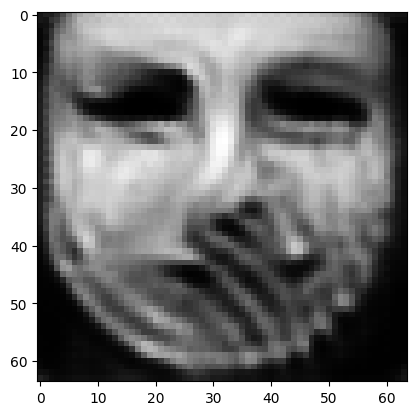

tensor([[1.5702e-04, 5.1318e-06, 9.7835e-01, 5.7351e-04, 2.1333e-04, 2.3915e-03,
         5.0233e-05, 1.7871e-03, 1.8719e-04, 3.5594e-04, 1.9649e-04, 5.8759e-04,
         1.1431e-04, 3.0823e-06, 9.1361e-07, 3.7182e-05, 5.1309e-04, 9.0977e-05,
         5.5064e-05, 3.2623e-04, 6.9862e-05, 7.2109e-05, 1.3204e-06, 3.0923e-05,
         6.1020e-05, 3.8912e-04, 1.6645e-05, 6.4776e-04, 6.2113e-03, 1.9468e-05,
         1.2771e-04, 2.4608e-06, 5.0887e-04, 2.2880e-04, 1.0298e-04, 7.1105e-07,
         9.2255e-05, 7.4853e-04, 3.5831e-03, 1.0850e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02188333310186863
tensor([[1.5700e-04, 5.1310e-06, 9.7836e-01, 5.7345e-04, 2.1329e-04, 2.3908e-03,
         5.0217e-05, 1.7867e-03, 1.8717e-04, 3.5589e-04, 1.9646e-04, 5.8754e-04,
         1.1429e-04, 3.0820e-06, 9.1348e-07, 3.7176e-05, 5.1304e-04, 9.0962e-05,
         5.5055e-05, 3.2616e-04, 6.9851e-05, 7.2100e-05, 1.3202e-06, 3.0920e-05,
         6.1008e-05, 3.8908e-04, 1.6640e-0

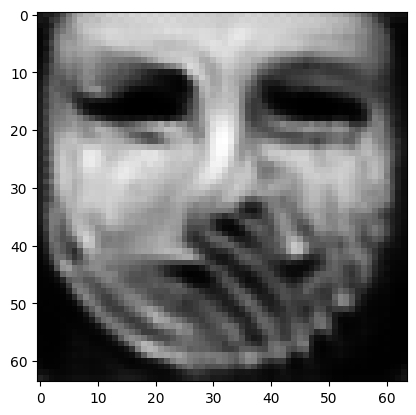

tensor([[1.5689e-04, 5.1280e-06, 9.7837e-01, 5.7323e-04, 2.1311e-04, 2.3883e-03,
         5.0156e-05, 1.7851e-03, 1.8708e-04, 3.5568e-04, 1.9632e-04, 5.8737e-04,
         1.1423e-04, 3.0807e-06, 9.1295e-07, 3.7154e-05, 5.1284e-04, 9.0905e-05,
         5.5023e-05, 3.2590e-04, 6.9809e-05, 7.2064e-05, 1.3194e-06, 3.0906e-05,
         6.0963e-05, 3.8892e-04, 1.6622e-05, 6.4724e-04, 6.2056e-03, 1.9452e-05,
         1.2767e-04, 2.4580e-06, 5.0835e-04, 2.2864e-04, 1.0292e-04, 7.1009e-07,
         9.2195e-05, 7.4822e-04, 3.5795e-03, 1.0835e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021862804889678955
tensor([[1.5687e-04, 5.1273e-06, 9.7838e-01, 5.7318e-04, 2.1307e-04, 2.3876e-03,
         5.0141e-05, 1.7847e-03, 1.8706e-04, 3.5563e-04, 1.9629e-04, 5.8733e-04,
         1.1422e-04, 3.0804e-06, 9.1283e-07, 3.7148e-05, 5.1279e-04, 9.0891e-05,
         5.5015e-05, 3.2584e-04, 6.9799e-05, 7.2054e-05, 1.3193e-06, 3.0903e-05,
         6.0952e-05, 3.8888e-04, 1.6617e-

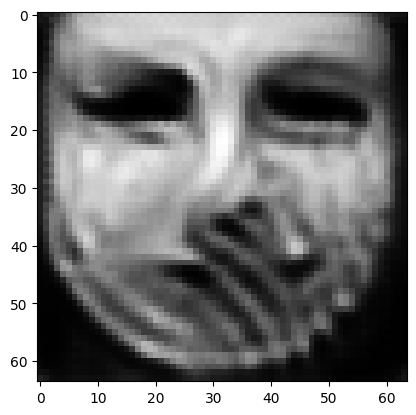

tensor([[1.5678e-04, 5.1245e-06, 9.7839e-01, 5.7299e-04, 2.1291e-04, 2.3852e-03,
         5.0082e-05, 1.7832e-03, 1.8699e-04, 3.5543e-04, 1.9616e-04, 5.8717e-04,
         1.1417e-04, 3.0793e-06, 9.1237e-07, 3.7127e-05, 5.1260e-04, 9.0839e-05,
         5.4986e-05, 3.2560e-04, 6.9760e-05, 7.2020e-05, 1.3186e-06, 3.0891e-05,
         6.0912e-05, 3.8873e-04, 1.6600e-05, 6.4675e-04, 6.2001e-03, 1.9437e-05,
         1.2764e-04, 2.4554e-06, 5.0785e-04, 2.2850e-04, 1.0286e-04, 7.0921e-07,
         9.2139e-05, 7.4795e-04, 3.5762e-03, 1.0822e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021843094378709793
tensor([[1.5675e-04, 5.1239e-06, 9.7840e-01, 5.7294e-04, 2.1287e-04, 2.3846e-03,
         5.0069e-05, 1.7829e-03, 1.8697e-04, 3.5538e-04, 1.9613e-04, 5.8714e-04,
         1.1416e-04, 3.0791e-06, 9.1228e-07, 3.7122e-05, 5.1255e-04, 9.0827e-05,
         5.4979e-05, 3.2555e-04, 6.9752e-05, 7.2012e-05, 1.3184e-06, 3.0888e-05,
         6.0902e-05, 3.8870e-04, 1.6596e-

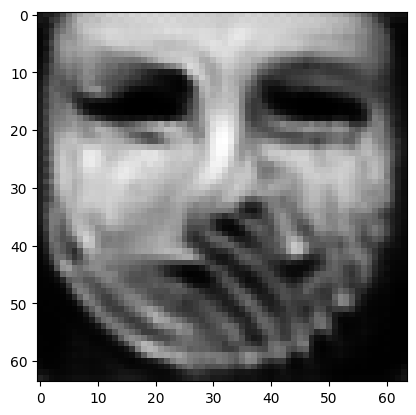

tensor([[1.5666e-04, 5.1213e-06, 9.7841e-01, 5.7274e-04, 2.1272e-04, 2.3823e-03,
         5.0016e-05, 1.7815e-03, 1.8690e-04, 3.5519e-04, 1.9601e-04, 5.8701e-04,
         1.1412e-04, 3.0781e-06, 9.1187e-07, 3.7103e-05, 5.1236e-04, 9.0781e-05,
         5.4951e-05, 3.2533e-04, 6.9719e-05, 7.1980e-05, 1.3178e-06, 3.0876e-05,
         6.0863e-05, 3.8854e-04, 1.6580e-05, 6.4627e-04, 6.1948e-03, 1.9424e-05,
         1.2761e-04, 2.4530e-06, 5.0742e-04, 2.2836e-04, 1.0281e-04, 7.0839e-07,
         9.2087e-05, 7.4769e-04, 3.5733e-03, 1.0809e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021825015544891357
tensor([[1.5664e-04, 5.1207e-06, 9.7842e-01, 5.7269e-04, 2.1269e-04, 2.3818e-03,
         5.0003e-05, 1.7811e-03, 1.8689e-04, 3.5514e-04, 1.9599e-04, 5.8698e-04,
         1.1411e-04, 3.0779e-06, 9.1178e-07, 3.7098e-05, 5.1231e-04, 9.0769e-05,
         5.4944e-05, 3.2528e-04, 6.9711e-05, 7.1972e-05, 1.3177e-06, 3.0873e-05,
         6.0854e-05, 3.8851e-04, 1.6576e-

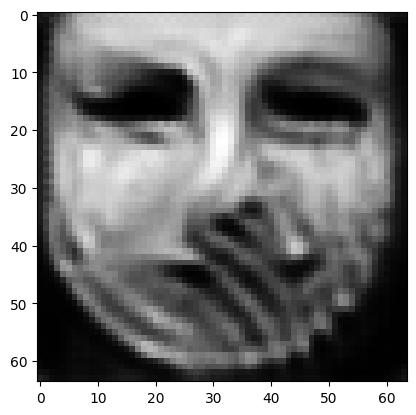

tensor([[1.5656e-04, 5.1182e-06, 9.7843e-01, 5.7255e-04, 2.1255e-04, 2.3796e-03,
         4.9952e-05, 1.7798e-03, 1.8683e-04, 3.5494e-04, 1.9587e-04, 5.8683e-04,
         1.1407e-04, 3.0770e-06, 9.1142e-07, 3.7078e-05, 5.1214e-04, 9.0728e-05,
         5.4918e-05, 3.2507e-04, 6.9680e-05, 7.1939e-05, 1.3172e-06, 3.0864e-05,
         6.0823e-05, 3.8838e-04, 1.6561e-05, 6.4584e-04, 6.1898e-03, 1.9411e-05,
         1.2758e-04, 2.4508e-06, 5.0700e-04, 2.2823e-04, 1.0276e-04, 7.0764e-07,
         9.2039e-05, 7.4746e-04, 3.5705e-03, 1.0797e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021807637065649033
tensor([[1.5654e-04, 5.1176e-06, 9.7843e-01, 5.7250e-04, 2.1252e-04, 2.3791e-03,
         4.9940e-05, 1.7795e-03, 1.8681e-04, 3.5490e-04, 1.9584e-04, 5.8680e-04,
         1.1406e-04, 3.0768e-06, 9.1133e-07, 3.7074e-05, 5.1210e-04, 9.0717e-05,
         5.4911e-05, 3.2502e-04, 6.9673e-05, 7.1932e-05, 1.3170e-06, 3.0861e-05,
         6.0814e-05, 3.8834e-04, 1.6557e-

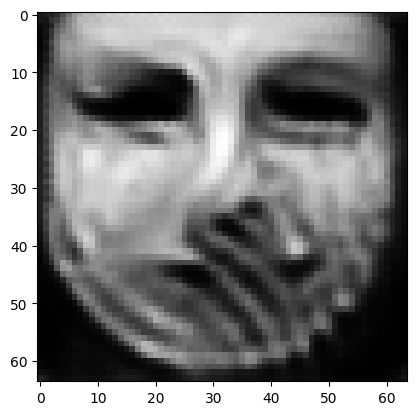

tensor([[1.5647e-04, 5.1153e-06, 9.7844e-01, 5.7236e-04, 2.1239e-04, 2.3770e-03,
         4.9893e-05, 1.7783e-03, 1.8675e-04, 3.5471e-04, 1.9573e-04, 5.8666e-04,
         1.1402e-04, 3.0760e-06, 9.1100e-07, 3.7055e-05, 5.1194e-04, 9.0678e-05,
         5.4886e-05, 3.2482e-04, 6.9644e-05, 7.1900e-05, 1.3165e-06, 3.0852e-05,
         6.0785e-05, 3.8822e-04, 1.6543e-05, 6.4542e-04, 6.1850e-03, 1.9399e-05,
         1.2755e-04, 2.4487e-06, 5.0659e-04, 2.2810e-04, 1.0272e-04, 7.0694e-07,
         9.1995e-05, 7.4724e-04, 3.5678e-03, 1.0785e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021791307255625725
tensor([[1.5645e-04, 5.1148e-06, 9.7845e-01, 5.7232e-04, 2.1236e-04, 2.3765e-03,
         4.9881e-05, 1.7779e-03, 1.8674e-04, 3.5467e-04, 1.9571e-04, 5.8663e-04,
         1.1401e-04, 3.0757e-06, 9.1092e-07, 3.7051e-05, 5.1190e-04, 9.0668e-05,
         5.4880e-05, 3.2477e-04, 6.9637e-05, 7.1893e-05, 1.3164e-06, 3.0850e-05,
         6.0777e-05, 3.8818e-04, 1.6539e-

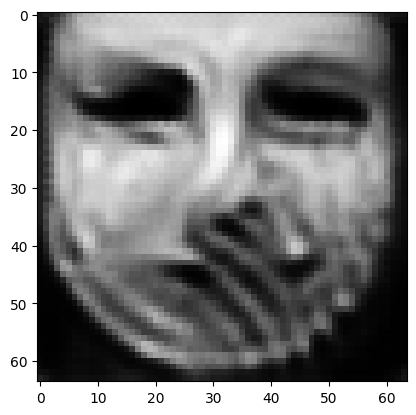

tensor([[1.5638e-04, 5.1125e-06, 9.7846e-01, 5.7219e-04, 2.1224e-04, 2.3745e-03,
         4.9836e-05, 1.7768e-03, 1.8669e-04, 3.5449e-04, 1.9560e-04, 5.8650e-04,
         1.1397e-04, 3.0750e-06, 9.1060e-07, 3.7034e-05, 5.1175e-04, 9.0631e-05,
         5.4857e-05, 3.2458e-04, 6.9610e-05, 7.1864e-05, 1.3159e-06, 3.0841e-05,
         6.0750e-05, 3.8806e-04, 1.6525e-05, 6.4503e-04, 6.1805e-03, 1.9388e-05,
         1.2752e-04, 2.4466e-06, 5.0621e-04, 2.2798e-04, 1.0268e-04, 7.0627e-07,
         9.1953e-05, 7.4703e-04, 3.5654e-03, 1.0774e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021775562316179276
tensor([[1.5637e-04, 5.1120e-06, 9.7846e-01, 5.7215e-04, 2.1221e-04, 2.3740e-03,
         4.9825e-05, 1.7765e-03, 1.8667e-04, 3.5444e-04, 1.9558e-04, 5.8647e-04,
         1.1396e-04, 3.0748e-06, 9.1052e-07, 3.7030e-05, 5.1171e-04, 9.0621e-05,
         5.4851e-05, 3.2454e-04, 6.9603e-05, 7.1857e-05, 1.3158e-06, 3.0839e-05,
         6.0742e-05, 3.8803e-04, 1.6522e-

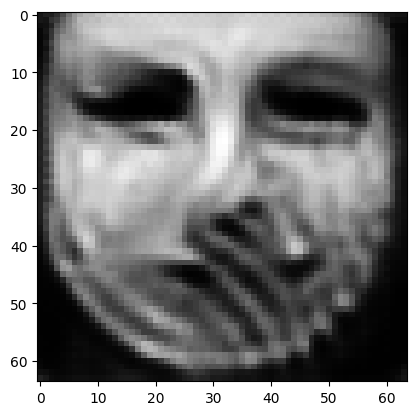

tensor([[1.5630e-04, 5.1100e-06, 9.7847e-01, 5.7201e-04, 2.1210e-04, 2.3722e-03,
         4.9783e-05, 1.7754e-03, 1.8662e-04, 3.5428e-04, 1.9548e-04, 5.8636e-04,
         1.1393e-04, 3.0740e-06, 9.1021e-07, 3.7014e-05, 5.1156e-04, 9.0585e-05,
         5.4829e-05, 3.2436e-04, 6.9577e-05, 7.1830e-05, 1.3154e-06, 3.0830e-05,
         6.0713e-05, 3.8792e-04, 1.6509e-05, 6.4465e-04, 6.1762e-03, 1.9377e-05,
         1.2749e-04, 2.4447e-06, 5.0585e-04, 2.2787e-04, 1.0264e-04, 7.0563e-07,
         9.1912e-05, 7.4682e-04, 3.5630e-03, 1.0764e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021760981529951096
tensor([[1.5628e-04, 5.1095e-06, 9.7848e-01, 5.7199e-04, 2.1207e-04, 2.3717e-03,
         4.9772e-05, 1.7751e-03, 1.8661e-04, 3.5424e-04, 1.9546e-04, 5.8632e-04,
         1.1392e-04, 3.0739e-06, 9.1014e-07, 3.7009e-05, 5.1153e-04, 9.0576e-05,
         5.4823e-05, 3.2431e-04, 6.9571e-05, 7.1822e-05, 1.3152e-06, 3.0828e-05,
         6.0708e-05, 3.8789e-04, 1.6506e-

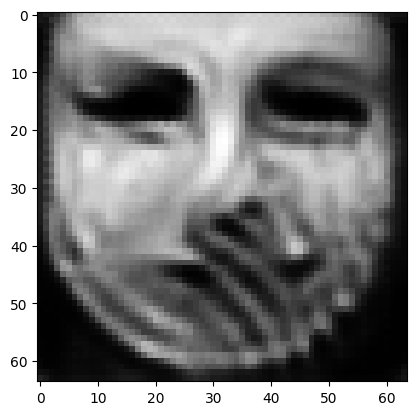

tensor([[1.5622e-04, 5.1076e-06, 9.7849e-01, 5.7186e-04, 2.1196e-04, 2.3700e-03,
         4.9732e-05, 1.7740e-03, 1.8656e-04, 3.5408e-04, 1.9537e-04, 5.8621e-04,
         1.1389e-04, 3.0732e-06, 9.0985e-07, 3.6994e-05, 5.1139e-04, 9.0542e-05,
         5.4802e-05, 3.2415e-04, 6.9547e-05, 7.1796e-05, 1.3148e-06, 3.0820e-05,
         6.0681e-05, 3.8778e-04, 1.6494e-05, 6.4430e-04, 6.1722e-03, 1.9367e-05,
         1.2746e-04, 2.4429e-06, 5.0551e-04, 2.2776e-04, 1.0261e-04, 7.0504e-07,
         9.1875e-05, 7.4663e-04, 3.5607e-03, 1.0755e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02174721658229828
tensor([[1.5620e-04, 5.1071e-06, 9.7849e-01, 5.7182e-04, 2.1193e-04, 2.3696e-03,
         4.9722e-05, 1.7738e-03, 1.8655e-04, 3.5404e-04, 1.9535e-04, 5.8618e-04,
         1.1388e-04, 3.0730e-06, 9.0978e-07, 3.6991e-05, 5.1136e-04, 9.0533e-05,
         5.4797e-05, 3.2410e-04, 6.9541e-05, 7.1790e-05, 1.3147e-06, 3.0818e-05,
         6.0674e-05, 3.8775e-04, 1.6491e-0

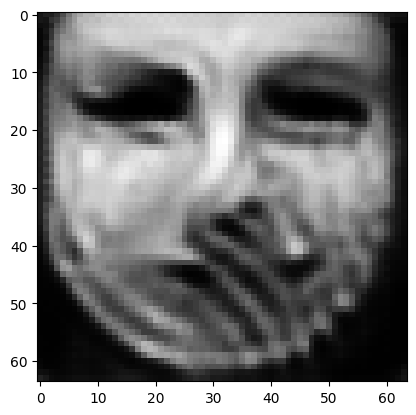

tensor([[1.5614e-04, 5.1053e-06, 9.7850e-01, 5.7171e-04, 2.1183e-04, 2.3679e-03,
         4.9684e-05, 1.7728e-03, 1.8650e-04, 3.5389e-04, 1.9526e-04, 5.8606e-04,
         1.1386e-04, 3.0723e-06, 9.0951e-07, 3.6975e-05, 5.1123e-04, 9.0502e-05,
         5.4777e-05, 3.2394e-04, 6.9518e-05, 7.1765e-05, 1.3143e-06, 3.0811e-05,
         6.0651e-05, 3.8765e-04, 1.6479e-05, 6.4398e-04, 6.1683e-03, 1.9357e-05,
         1.2744e-04, 2.4412e-06, 5.0518e-04, 2.2765e-04, 1.0258e-04, 7.0447e-07,
         9.1839e-05, 7.4644e-04, 3.5587e-03, 1.0745e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02173391915857792
tensor([[1.5613e-04, 5.1048e-06, 9.7850e-01, 5.7168e-04, 2.1181e-04, 2.3675e-03,
         4.9675e-05, 1.7725e-03, 1.8649e-04, 3.5385e-04, 1.9524e-04, 5.8604e-04,
         1.1385e-04, 3.0722e-06, 9.0944e-07, 3.6972e-05, 5.1119e-04, 9.0494e-05,
         5.4772e-05, 3.2391e-04, 6.9512e-05, 7.1759e-05, 1.3142e-06, 3.0809e-05,
         6.0645e-05, 3.8763e-04, 1.6476e-0

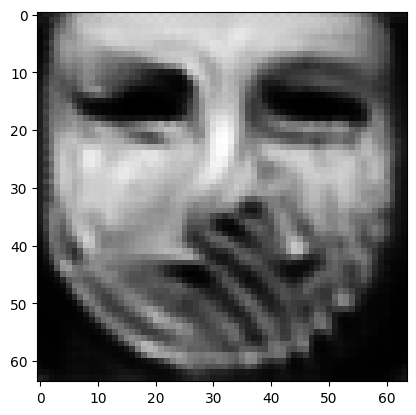

tensor([[1.5607e-04, 5.1031e-06, 9.7851e-01, 5.7158e-04, 2.1171e-04, 2.3659e-03,
         4.9638e-05, 1.7716e-03, 1.8645e-04, 3.5370e-04, 1.9515e-04, 5.8593e-04,
         1.1382e-04, 3.0716e-06, 9.0918e-07, 3.6958e-05, 5.1107e-04, 9.0464e-05,
         5.4753e-05, 3.2375e-04, 6.9490e-05, 7.1735e-05, 1.3138e-06, 3.0802e-05,
         6.0623e-05, 3.8753e-04, 1.6465e-05, 6.4366e-04, 6.1647e-03, 1.9348e-05,
         1.2742e-04, 2.4396e-06, 5.0487e-04, 2.2755e-04, 1.0254e-04, 7.0395e-07,
         9.1806e-05, 7.4627e-04, 3.5566e-03, 1.0736e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02172132208943367
tensor([[1.5605e-04, 5.1027e-06, 9.7852e-01, 5.7155e-04, 2.1169e-04, 2.3655e-03,
         4.9630e-05, 1.7713e-03, 1.8644e-04, 3.5367e-04, 1.9514e-04, 5.8591e-04,
         1.1381e-04, 3.0714e-06, 9.0912e-07, 3.6955e-05, 5.1105e-04, 9.0456e-05,
         5.4749e-05, 3.2372e-04, 6.9485e-05, 7.1729e-05, 1.3138e-06, 3.0800e-05,
         6.0617e-05, 3.8751e-04, 1.6463e-0

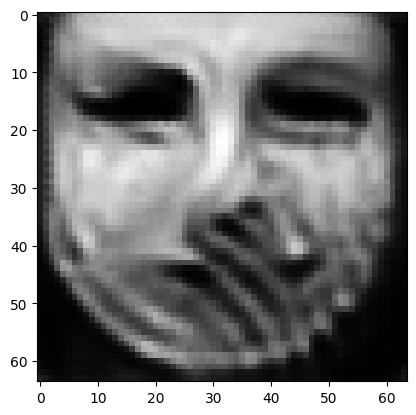

tensor([[1.5600e-04, 5.1010e-06, 9.7852e-01, 5.7144e-04, 2.1160e-04, 2.3640e-03,
         4.9596e-05, 1.7705e-03, 1.8639e-04, 3.5354e-04, 1.9506e-04, 5.8581e-04,
         1.1379e-04, 3.0709e-06, 9.0888e-07, 3.6942e-05, 5.1093e-04, 9.0428e-05,
         5.4731e-05, 3.2357e-04, 6.9464e-05, 7.1707e-05, 1.3134e-06, 3.0794e-05,
         6.0596e-05, 3.8741e-04, 1.6452e-05, 6.4337e-04, 6.1613e-03, 1.9340e-05,
         1.2740e-04, 2.4381e-06, 5.0459e-04, 2.2746e-04, 1.0251e-04, 7.0345e-07,
         9.1775e-05, 7.4611e-04, 3.5547e-03, 1.0728e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021709540858864784
tensor([[1.5599e-04, 5.1006e-06, 9.7853e-01, 5.7142e-04, 2.1158e-04, 2.3637e-03,
         4.9588e-05, 1.7702e-03, 1.8638e-04, 3.5350e-04, 1.9504e-04, 5.8578e-04,
         1.1378e-04, 3.0707e-06, 9.0882e-07, 3.6938e-05, 5.1091e-04, 9.0422e-05,
         5.4726e-05, 3.2354e-04, 6.9459e-05, 7.1701e-05, 1.3133e-06, 3.0793e-05,
         6.0591e-05, 3.8739e-04, 1.6450e-

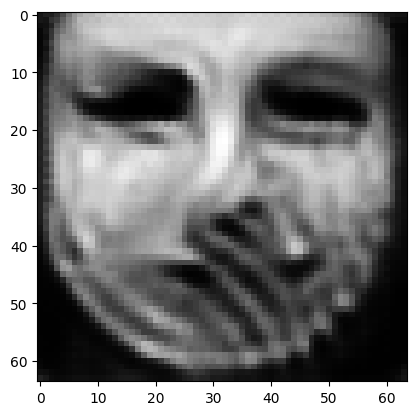

tensor([[1.5594e-04, 5.0990e-06, 9.7854e-01, 5.7132e-04, 2.1149e-04, 2.3622e-03,
         4.9556e-05, 1.7694e-03, 1.8634e-04, 3.5338e-04, 1.9497e-04, 5.8568e-04,
         1.1375e-04, 3.0701e-06, 9.0859e-07, 3.6926e-05, 5.1081e-04, 9.0395e-05,
         5.4709e-05, 3.2340e-04, 6.9439e-05, 7.1679e-05, 1.3129e-06, 3.0787e-05,
         6.0571e-05, 3.8731e-04, 1.6440e-05, 6.4309e-04, 6.1581e-03, 1.9332e-05,
         1.2737e-04, 2.4367e-06, 5.0431e-04, 2.2737e-04, 1.0249e-04, 7.0298e-07,
         9.1746e-05, 7.4596e-04, 3.5528e-03, 1.0720e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021698342636227608
tensor([[1.5593e-04, 5.0987e-06, 9.7854e-01, 5.7129e-04, 2.1147e-04, 2.3619e-03,
         4.9549e-05, 1.7692e-03, 1.8633e-04, 3.5335e-04, 1.9495e-04, 5.8566e-04,
         1.1374e-04, 3.0700e-06, 9.0853e-07, 3.6923e-05, 5.1078e-04, 9.0389e-05,
         5.4705e-05, 3.2337e-04, 6.9434e-05, 7.1674e-05, 1.3129e-06, 3.0785e-05,
         6.0566e-05, 3.8729e-04, 1.6437e-

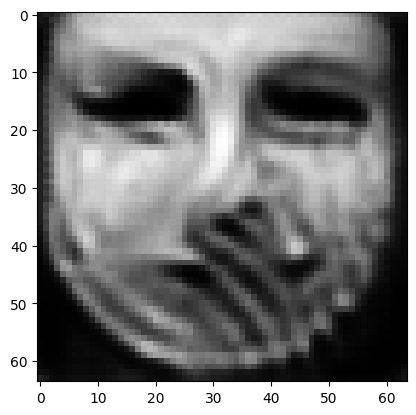

tensor([[1.5588e-04, 5.0972e-06, 9.7855e-01, 5.7120e-04, 2.1139e-04, 2.3606e-03,
         4.9519e-05, 1.7684e-03, 1.8629e-04, 3.5323e-04, 1.9488e-04, 5.8556e-04,
         1.1372e-04, 3.0695e-06, 9.0831e-07, 3.6912e-05, 5.1069e-04, 9.0364e-05,
         5.4689e-05, 3.2324e-04, 6.9415e-05, 7.1653e-05, 1.3125e-06, 3.0780e-05,
         6.0547e-05, 3.8721e-04, 1.6428e-05, 6.4283e-04, 6.1550e-03, 1.9324e-05,
         1.2735e-04, 2.4353e-06, 5.0405e-04, 2.2729e-04, 1.0246e-04, 7.0253e-07,
         9.1719e-05, 7.4583e-04, 3.5510e-03, 1.0712e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02168772742152214
tensor([[1.5587e-04, 5.0968e-06, 9.7855e-01, 5.7117e-04, 2.1137e-04, 2.3602e-03,
         4.9512e-05, 1.7682e-03, 1.8628e-04, 3.5320e-04, 1.9486e-04, 5.8554e-04,
         1.1371e-04, 3.0694e-06, 9.0826e-07, 3.6909e-05, 5.1067e-04, 9.0358e-05,
         5.4685e-05, 3.2321e-04, 6.9410e-05, 7.1649e-05, 1.3125e-06, 3.0779e-05,
         6.0542e-05, 3.8719e-04, 1.6426e-0

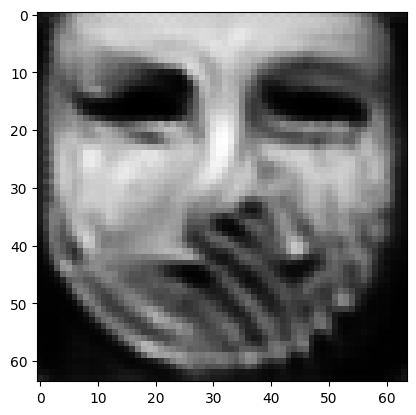

tensor([[1.5583e-04, 5.0952e-06, 9.7856e-01, 5.7107e-04, 2.1130e-04, 2.3590e-03,
         4.9485e-05, 1.7675e-03, 1.8623e-04, 3.5308e-04, 1.9480e-04, 5.8544e-04,
         1.1368e-04, 3.0688e-06, 9.0803e-07, 3.6898e-05, 5.1060e-04, 9.0335e-05,
         5.4669e-05, 3.2308e-04, 6.9391e-05, 7.1629e-05, 1.3121e-06, 3.0775e-05,
         6.0525e-05, 3.8711e-04, 1.6417e-05, 6.4258e-04, 6.1521e-03, 1.9317e-05,
         1.2733e-04, 2.4341e-06, 5.0382e-04, 2.2721e-04, 1.0243e-04, 7.0211e-07,
         9.1692e-05, 7.4570e-04, 3.5493e-03, 1.0705e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021677695214748383
tensor([[1.5582e-04, 5.0948e-06, 9.7856e-01, 5.7106e-04, 2.1128e-04, 2.3587e-03,
         4.9478e-05, 1.7673e-03, 1.8622e-04, 3.5305e-04, 1.9478e-04, 5.8541e-04,
         1.1368e-04, 3.0687e-06, 9.0798e-07, 3.6895e-05, 5.1058e-04, 9.0330e-05,
         5.4665e-05, 3.2305e-04, 6.9387e-05, 7.1623e-05, 1.3120e-06, 3.0774e-05,
         6.0523e-05, 3.8710e-04, 1.6414e-

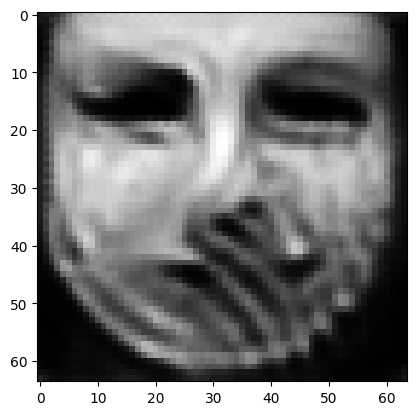

tensor([[1.5578e-04, 5.0933e-06, 9.7856e-01, 5.7097e-04, 2.1121e-04, 2.3575e-03,
         4.9452e-05, 1.7667e-03, 1.8618e-04, 3.5295e-04, 1.9472e-04, 5.8532e-04,
         1.1365e-04, 3.0681e-06, 9.0777e-07, 3.6884e-05, 5.1051e-04, 9.0308e-05,
         5.4651e-05, 3.2294e-04, 6.9369e-05, 7.1605e-05, 1.3117e-06, 3.0770e-05,
         6.0507e-05, 3.8703e-04, 1.6405e-05, 6.4235e-04, 6.1493e-03, 1.9310e-05,
         1.2731e-04, 2.4328e-06, 5.0359e-04, 2.2713e-04, 1.0241e-04, 7.0173e-07,
         9.1668e-05, 7.4558e-04, 3.5478e-03, 1.0698e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021668128669261932
tensor([[1.5577e-04, 5.0930e-06, 9.7857e-01, 5.7095e-04, 2.1119e-04, 2.3572e-03,
         4.9445e-05, 1.7665e-03, 1.8617e-04, 3.5292e-04, 1.9471e-04, 5.8530e-04,
         1.1364e-04, 3.0680e-06, 9.0772e-07, 3.6882e-05, 5.1049e-04, 9.0303e-05,
         5.4647e-05, 3.2291e-04, 6.9364e-05, 7.1600e-05, 1.3116e-06, 3.0769e-05,
         6.0503e-05, 3.8701e-04, 1.6403e-

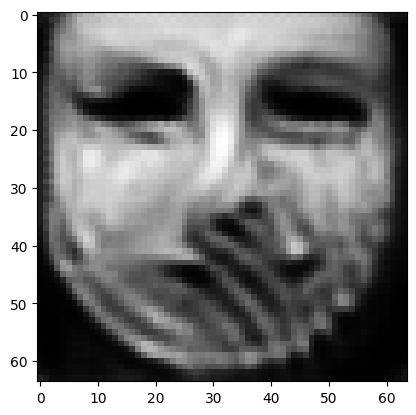

tensor([[1.5573e-04, 5.0916e-06, 9.7857e-01, 5.7084e-04, 2.1112e-04, 2.3561e-03,
         4.9421e-05, 1.7659e-03, 1.8613e-04, 3.5282e-04, 1.9465e-04, 5.8522e-04,
         1.1361e-04, 3.0674e-06, 9.0751e-07, 3.6872e-05, 5.1042e-04, 9.0281e-05,
         5.4633e-05, 3.2280e-04, 6.9347e-05, 7.1583e-05, 1.3113e-06, 3.0765e-05,
         6.0486e-05, 3.8694e-04, 1.6395e-05, 6.4212e-04, 6.1467e-03, 1.9303e-05,
         1.2729e-04, 2.4317e-06, 5.0338e-04, 2.2706e-04, 1.0239e-04, 7.0134e-07,
         9.1643e-05, 7.4546e-04, 3.5462e-03, 1.0691e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.02165914699435234
tensor([[1.5573e-04, 5.0912e-06, 9.7858e-01, 5.7083e-04, 2.1111e-04, 2.3558e-03,
         4.9415e-05, 1.7658e-03, 1.8613e-04, 3.5279e-04, 1.9464e-04, 5.8520e-04,
         1.1361e-04, 3.0673e-06, 9.0746e-07, 3.6870e-05, 5.1041e-04, 9.0277e-05,
         5.4630e-05, 3.2278e-04, 6.9343e-05, 7.1578e-05, 1.3112e-06, 3.0764e-05,
         6.0484e-05, 3.8693e-04, 1.6393e-0

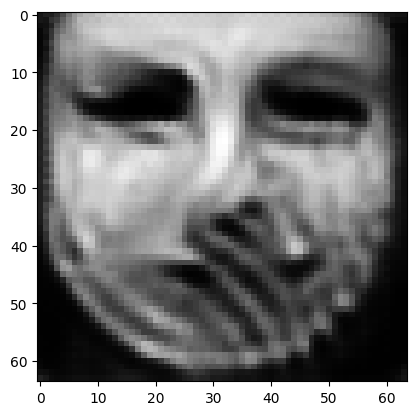

tensor([[1.5569e-04, 5.0899e-06, 9.7858e-01, 5.7074e-04, 2.1104e-04, 2.3548e-03,
         4.9392e-05, 1.7652e-03, 1.8609e-04, 3.5270e-04, 1.9458e-04, 5.8512e-04,
         1.1358e-04, 3.0668e-06, 9.0726e-07, 3.6861e-05, 5.1034e-04, 9.0256e-05,
         5.4617e-05, 3.2268e-04, 6.9327e-05, 7.1562e-05, 1.3109e-06, 3.0761e-05,
         6.0468e-05, 3.8686e-04, 1.6385e-05, 6.4191e-04, 6.1442e-03, 1.9296e-05,
         1.2727e-04, 2.4306e-06, 5.0318e-04, 2.2699e-04, 1.0236e-04, 7.0098e-07,
         9.1620e-05, 7.4535e-04, 3.5448e-03, 1.0684e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021650513634085655
tensor([[1.5568e-04, 5.0895e-06, 9.7858e-01, 5.7072e-04, 2.1102e-04, 2.3545e-03,
         4.9386e-05, 1.7650e-03, 1.8608e-04, 3.5267e-04, 1.9457e-04, 5.8510e-04,
         1.1358e-04, 3.0667e-06, 9.0722e-07, 3.6858e-05, 5.1032e-04, 9.0251e-05,
         5.4613e-05, 3.2265e-04, 6.9323e-05, 7.1557e-05, 1.3108e-06, 3.0760e-05,
         6.0466e-05, 3.8685e-04, 1.6383e-

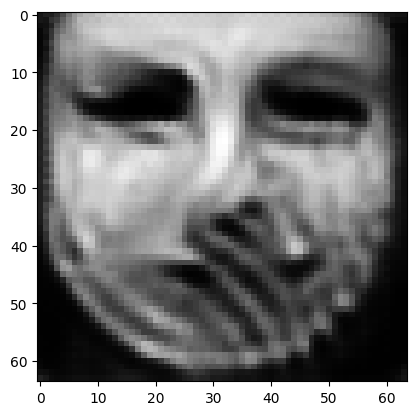

tensor([[1.5565e-04, 5.0882e-06, 9.7859e-01, 5.7063e-04, 2.1096e-04, 2.3535e-03,
         4.9364e-05, 1.7645e-03, 1.8604e-04, 3.5259e-04, 1.9452e-04, 5.8502e-04,
         1.1355e-04, 3.0662e-06, 9.0703e-07, 3.6849e-05, 5.1026e-04, 9.0232e-05,
         5.4600e-05, 3.2255e-04, 6.9307e-05, 7.1542e-05, 1.3106e-06, 3.0756e-05,
         6.0451e-05, 3.8678e-04, 1.6376e-05, 6.4170e-04, 6.1418e-03, 1.9290e-05,
         1.2725e-04, 2.4296e-06, 5.0298e-04, 2.2692e-04, 1.0234e-04, 7.0064e-07,
         9.1599e-05, 7.4524e-04, 3.5434e-03, 1.0678e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021642465144395828
tensor([[1.5564e-04, 5.0880e-06, 9.7859e-01, 5.7061e-04, 2.1095e-04, 2.3532e-03,
         4.9359e-05, 1.7643e-03, 1.8603e-04, 3.5257e-04, 1.9451e-04, 5.8500e-04,
         1.1355e-04, 3.0661e-06, 9.0698e-07, 3.6847e-05, 5.1025e-04, 9.0227e-05,
         5.4597e-05, 3.2253e-04, 6.9303e-05, 7.1538e-05, 1.3105e-06, 3.0755e-05,
         6.0447e-05, 3.8677e-04, 1.6374e-

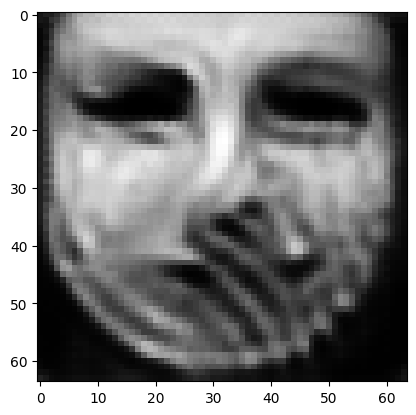

tensor([[1.5561e-04, 5.0867e-06, 9.7860e-01, 5.7054e-04, 2.1089e-04, 2.3523e-03,
         4.9337e-05, 1.7638e-03, 1.8600e-04, 3.5248e-04, 1.9446e-04, 5.8493e-04,
         1.1352e-04, 3.0657e-06, 9.0681e-07, 3.6839e-05, 5.1019e-04, 9.0209e-05,
         5.4586e-05, 3.2244e-04, 6.9289e-05, 7.1523e-05, 1.3102e-06, 3.0752e-05,
         6.0435e-05, 3.8671e-04, 1.6367e-05, 6.4151e-04, 6.1396e-03, 1.9284e-05,
         1.2723e-04, 2.4286e-06, 5.0280e-04, 2.2686e-04, 1.0232e-04, 7.0032e-07,
         9.1578e-05, 7.4514e-04, 3.5421e-03, 1.0673e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021634764969348907
tensor([[1.5560e-04, 5.0864e-06, 9.7860e-01, 5.7053e-04, 2.1088e-04, 2.3520e-03,
         4.9332e-05, 1.7637e-03, 1.8599e-04, 3.5245e-04, 1.9444e-04, 5.8491e-04,
         1.1352e-04, 3.0655e-06, 9.0676e-07, 3.6837e-05, 5.1018e-04, 9.0205e-05,
         5.4583e-05, 3.2241e-04, 6.9285e-05, 7.1518e-05, 1.3102e-06, 3.0752e-05,
         6.0432e-05, 3.8670e-04, 1.6365e-

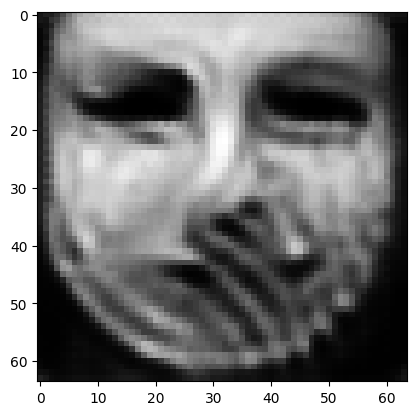

tensor([[1.5557e-04, 5.0853e-06, 9.7860e-01, 5.7045e-04, 2.1082e-04, 2.3511e-03,
         4.9312e-05, 1.7632e-03, 1.8596e-04, 3.5238e-04, 1.9440e-04, 5.8484e-04,
         1.1350e-04, 3.0651e-06, 9.0660e-07, 3.6829e-05, 5.1012e-04, 9.0187e-05,
         5.4571e-05, 3.2232e-04, 6.9271e-05, 7.1505e-05, 1.3099e-06, 3.0748e-05,
         6.0419e-05, 3.8665e-04, 1.6359e-05, 6.4133e-04, 6.1375e-03, 1.9279e-05,
         1.2722e-04, 2.4277e-06, 5.0262e-04, 2.2680e-04, 1.0230e-04, 7.0001e-07,
         9.1558e-05, 7.4504e-04, 3.5409e-03, 1.0667e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021627532318234444
tensor([[1.5556e-04, 5.0850e-06, 9.7861e-01, 5.7043e-04, 2.1081e-04, 2.3509e-03,
         4.9307e-05, 1.7631e-03, 1.8595e-04, 3.5236e-04, 1.9439e-04, 5.8483e-04,
         1.1349e-04, 3.0650e-06, 9.0656e-07, 3.6827e-05, 5.1010e-04, 9.0183e-05,
         5.4569e-05, 3.2230e-04, 6.9268e-05, 7.1501e-05, 1.3098e-06, 3.0748e-05,
         6.0415e-05, 3.8663e-04, 1.6357e-

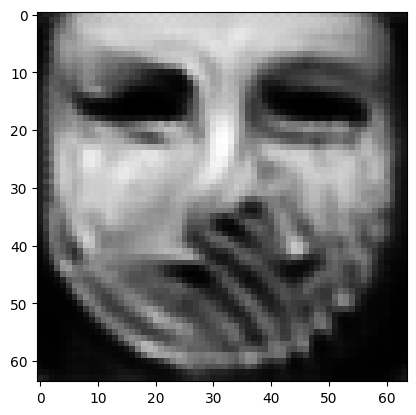

tensor([[1.5553e-04, 5.0839e-06, 9.7861e-01, 5.7036e-04, 2.1075e-04, 2.3501e-03,
         4.9288e-05, 1.7626e-03, 1.8592e-04, 3.5228e-04, 1.9434e-04, 5.8476e-04,
         1.1347e-04, 3.0646e-06, 9.0640e-07, 3.6819e-05, 5.1005e-04, 9.0166e-05,
         5.4558e-05, 3.2222e-04, 6.9254e-05, 7.1487e-05, 1.3096e-06, 3.0745e-05,
         6.0404e-05, 3.8658e-04, 1.6351e-05, 6.4116e-04, 6.1355e-03, 1.9273e-05,
         1.2720e-04, 2.4268e-06, 5.0246e-04, 2.2674e-04, 1.0228e-04, 6.9972e-07,
         9.1540e-05, 7.4495e-04, 3.5397e-03, 1.0662e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.021620532497763634
tensor([[1.5552e-04, 5.0836e-06, 9.7861e-01, 5.7034e-04, 2.1074e-04, 2.3499e-03,
         4.9284e-05, 1.7625e-03, 1.8592e-04, 3.5226e-04, 1.9433e-04, 5.8475e-04,
         1.1347e-04, 3.0645e-06, 9.0636e-07, 3.6817e-05, 5.1003e-04, 9.0162e-05,
         5.4555e-05, 3.2220e-04, 6.9251e-05, 7.1484e-05, 1.3095e-06, 3.0744e-05,
         6.0400e-05, 3.8657e-04, 1.6349e-

In [16]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=2)

tensor([[3.4713e-03, 1.2601e-03, 7.9833e-03, 5.4270e-03, 8.8898e-02, 8.4707e-04,
         1.6127e-03, 1.4663e-03, 1.4164e-03, 1.3463e-04, 4.2232e-04, 1.0595e-03,
         9.2519e-03, 2.0949e-02, 2.3434e-03, 6.2844e-04, 2.3632e-02, 5.2971e-03,
         2.1626e-03, 8.3675e-04, 1.5805e-02, 4.6692e-03, 2.9303e-01, 2.5239e-03,
         1.1666e-01, 2.3455e-02, 2.2279e-03, 3.2929e-03, 9.4658e-04, 5.7554e-03,
         3.6073e-03, 7.6531e-03, 1.2323e-02, 1.4340e-02, 1.1156e-02, 3.3075e-02,
         2.3484e-01, 2.0808e-02, 9.6893e-03, 5.0422e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  5.216369152069092


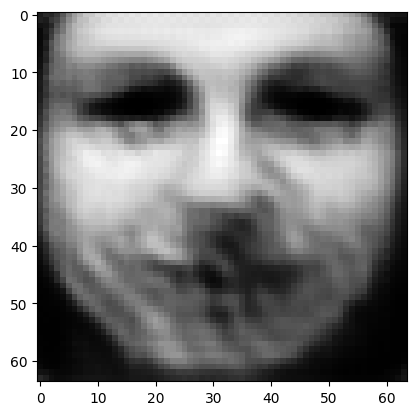

tensor([[0.0031, 0.0021, 0.0677, 0.0275, 0.0825, 0.0043, 0.0057, 0.0056, 0.0068,
         0.0006, 0.0020, 0.0015, 0.0384, 0.0088, 0.0008, 0.0010, 0.0348, 0.0069,
         0.0072, 0.0015, 0.0191, 0.0017, 0.0654, 0.0022, 0.1786, 0.0347, 0.0030,
         0.0182, 0.0391, 0.0142, 0.0083, 0.0014, 0.0161, 0.0207, 0.0252, 0.0098,
         0.0594, 0.0182, 0.1162, 0.0395]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  3.593630313873291
tensor([[0.0016, 0.0143, 0.0318, 0.2860, 0.0061, 0.0048, 0.0008, 0.0061, 0.0376,
         0.0007, 0.0038, 0.0039, 0.0209, 0.0134, 0.0004, 0.0011, 0.0058, 0.0024,
         0.0103, 0.0006, 0.0115, 0.0004, 0.0376, 0.0008, 0.0107, 0.2449, 0.0018,
         0.0127, 0.0341, 0.0227, 0.0142, 0.0011, 0.0033, 0.0031, 0.0592, 0.0056,
         0.0238, 0.0327, 0.0077, 0.0197]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  1.2517625093460083
tensor([[3.0678e-03, 5.4574e-03, 1.4351e-01, 4.2445e-01, 2.3735e-03, 2.4977e-02,
         5

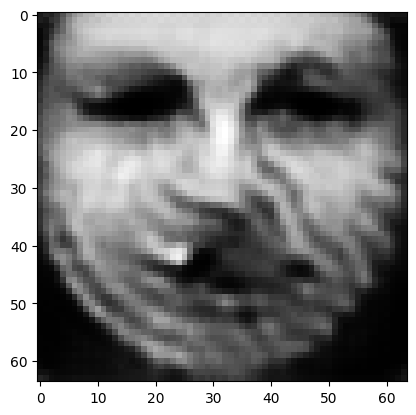

tensor([[3.5827e-04, 1.0374e-02, 3.3498e-03, 8.5773e-01, 5.0396e-04, 1.2787e-03,
         9.3494e-05, 2.4507e-03, 1.2252e-02, 1.7429e-04, 4.2012e-04, 8.2154e-04,
         1.7124e-02, 2.1902e-03, 1.2274e-04, 1.1048e-04, 1.6879e-03, 2.8316e-04,
         1.4104e-03, 2.8654e-04, 3.8922e-04, 2.8157e-05, 5.2379e-03, 2.0776e-04,
         6.2193e-03, 2.4062e-02, 3.6188e-04, 9.7225e-04, 3.3557e-03, 3.8718e-03,
         1.4290e-02, 6.5332e-04, 7.8679e-04, 5.7536e-04, 9.9061e-03, 2.4751e-03,
         2.1874e-03, 8.3447e-03, 2.2441e-03, 8.1477e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.15347163379192352
tensor([[3.8611e-04, 7.4210e-03, 3.7733e-03, 8.9556e-01, 3.7991e-04, 1.6562e-03,
         8.6198e-05, 2.3221e-03, 1.1216e-02, 1.7899e-04, 3.8851e-04, 7.0260e-04,
         1.2010e-02, 1.2129e-03, 8.4574e-05, 1.0952e-04, 1.2583e-03, 2.0585e-04,
         1.2847e-03, 2.6197e-04, 2.6402e-04, 2.1384e-05, 2.1404e-03, 1.6012e-04,
         3.9430e-03, 1.4415e-02, 3.2418e-0

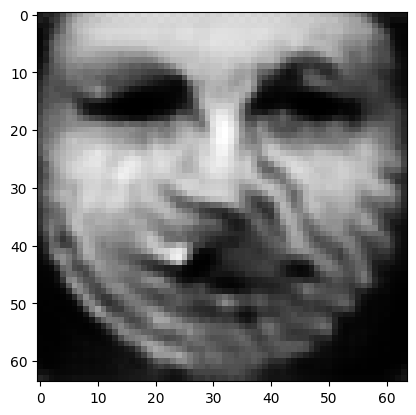

tensor([[3.3488e-04, 4.4700e-03, 3.1306e-03, 9.3217e-01, 2.3932e-04, 1.3351e-03,
         5.8825e-05, 1.9230e-03, 7.6447e-03, 1.2457e-04, 2.7251e-04, 4.1207e-04,
         7.0854e-03, 6.8240e-04, 4.9097e-05, 8.2098e-05, 9.4297e-04, 1.3729e-04,
         9.8657e-04, 1.7976e-04, 1.4597e-04, 1.3368e-05, 9.7554e-04, 1.2437e-04,
         2.5893e-03, 8.5575e-03, 1.9880e-04, 5.2461e-04, 2.5698e-03, 1.8486e-03,
         4.9025e-03, 2.8401e-04, 3.2230e-04, 1.9747e-04, 5.3552e-03, 6.3490e-04,
         6.6485e-04, 5.7244e-03, 1.5849e-03, 5.1724e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.07023642212152481
tensor([[3.1921e-04, 4.1777e-03, 2.9875e-03, 9.3643e-01, 2.2355e-04, 1.2553e-03,
         5.4656e-05, 1.8313e-03, 7.1771e-03, 1.1523e-04, 2.5351e-04, 3.7666e-04,
         6.6178e-03, 6.3521e-04, 4.5647e-05, 7.7104e-05, 9.0440e-04, 1.2996e-04,
         9.3369e-04, 1.6772e-04, 1.3402e-04, 1.2387e-05, 9.0036e-04, 1.1889e-04,
         2.4780e-03, 7.9447e-03, 1.8240e-0

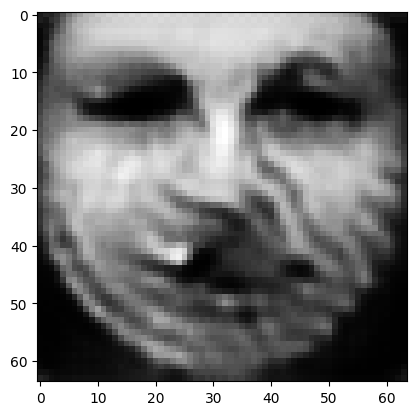

tensor([[2.7763e-04, 3.3252e-03, 2.6030e-03, 9.4824e-01, 1.8206e-04, 1.0578e-03,
         4.4427e-05, 1.5909e-03, 5.8858e-03, 9.1760e-05, 2.0351e-04, 2.8697e-04,
         5.2561e-03, 4.9433e-04, 3.6182e-05, 6.4004e-05, 7.8908e-04, 1.0897e-04,
         7.8800e-04, 1.3529e-04, 1.0107e-04, 9.8323e-06, 6.8109e-04, 1.0237e-04,
         2.1297e-03, 6.2394e-03, 1.4120e-04, 3.8924e-04, 1.8464e-03, 1.2928e-03,
         3.5378e-03, 2.2100e-04, 2.2974e-04, 1.3813e-04, 4.1629e-03, 4.6326e-04,
         4.9154e-04, 4.8156e-03, 1.1864e-03, 3.5936e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.05314742028713226
tensor([[2.6971e-04, 3.1807e-03, 2.5305e-03, 9.5028e-01, 1.7551e-04, 1.0224e-03,
         4.2675e-05, 1.5449e-03, 5.6580e-03, 8.7607e-05, 1.9450e-04, 2.7208e-04,
         5.0359e-03, 4.7126e-04, 3.4691e-05, 6.1564e-05, 7.6748e-04, 1.0560e-04,
         7.6050e-04, 1.2950e-04, 9.5777e-05, 9.3853e-06, 6.4748e-04, 9.9139e-05,
         2.0695e-03, 5.9456e-03, 1.3464e-0

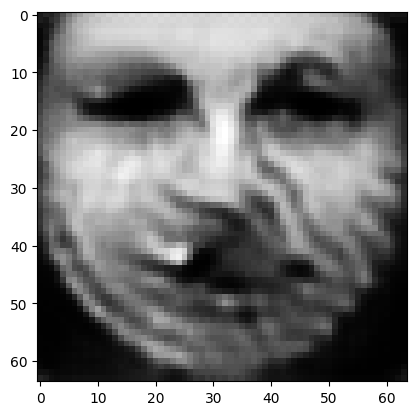

tensor([[2.4194e-04, 2.7627e-03, 2.2836e-03, 9.5674e-01, 1.5307e-04, 9.0456e-04,
         3.7145e-05, 1.3829e-03, 4.9367e-03, 7.4635e-05, 1.6538e-04, 2.2772e-04,
         4.3916e-03, 4.0117e-04, 3.0254e-05, 5.3711e-05, 6.9598e-04, 9.3805e-05,
         6.6807e-04, 1.1240e-04, 7.9857e-05, 8.0620e-06, 5.4583e-04, 8.8992e-05,
         1.8640e-03, 5.0237e-03, 1.1416e-04, 3.1468e-04, 1.4565e-03, 1.0201e-03,
         2.8397e-03, 1.9090e-04, 1.8494e-04, 1.0931e-04, 3.5373e-03, 3.8388e-04,
         4.0488e-04, 4.2133e-03, 9.8070e-04, 2.8450e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.04422649368643761
tensor([[2.3528e-04, 2.6839e-03, 2.2216e-03, 9.5799e-01, 1.4888e-04, 8.7243e-04,
         3.5977e-05, 1.3467e-03, 4.7867e-03, 7.1551e-05, 1.5923e-04, 2.1856e-04,
         4.2699e-03, 3.9111e-04, 2.9418e-05, 5.1939e-05, 6.8167e-04, 9.1505e-05,
         6.4897e-04, 1.0864e-04, 7.6863e-05, 7.8028e-06, 5.3212e-04, 8.7143e-05,
         1.8324e-03, 4.8734e-03, 1.0988e-0

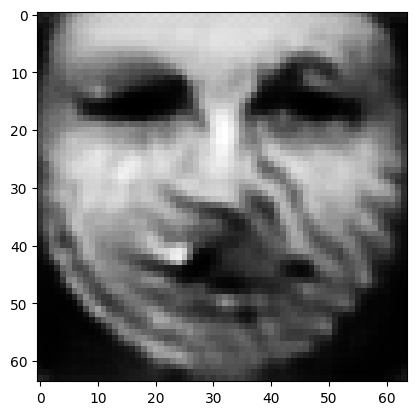

tensor([[2.1432e-04, 2.3958e-03, 2.0471e-03, 9.6239e-01, 1.3277e-04, 7.7493e-04,
         3.2111e-05, 1.2248e-03, 4.2356e-03, 6.1365e-05, 1.3777e-04, 1.8881e-04,
         3.8191e-03, 3.4732e-04, 2.6302e-05, 4.6011e-05, 6.3266e-04, 8.1952e-05,
         5.8455e-04, 9.6238e-05, 6.6460e-05, 7.0319e-06, 4.7445e-04, 8.0714e-05,
         1.6887e-03, 4.3412e-03, 9.5864e-05, 2.6662e-04, 1.1999e-03, 8.4942e-04,
         2.4484e-03, 1.7117e-04, 1.5740e-04, 9.2830e-05, 3.0427e-03, 3.3604e-04,
         3.5768e-04, 3.7813e-03, 8.4112e-04, 2.3397e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.03833813965320587
tensor([[2.0975e-04, 2.3439e-03, 2.0091e-03, 9.6329e-01, 1.2902e-04, 7.5419e-04,
         3.1233e-05, 1.1963e-03, 4.1262e-03, 5.9260e-05, 1.3337e-04, 1.8315e-04,
         3.7260e-03, 3.3876e-04, 2.5719e-05, 4.4777e-05, 6.2086e-04, 7.9933e-05,
         5.7122e-04, 9.3562e-05, 6.4464e-05, 6.8688e-06, 4.6255e-04, 7.9142e-05,
         1.6541e-03, 4.2295e-03, 9.3109e-0

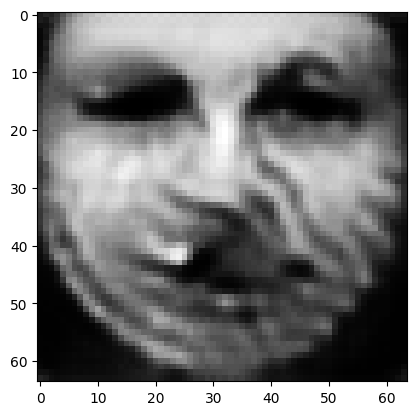

tensor([[1.9837e-04, 2.1398e-03, 1.9118e-03, 9.6635e-01, 1.1702e-04, 7.0060e-04,
         2.8633e-05, 1.1197e-03, 3.7745e-03, 5.3525e-05, 1.2026e-04, 1.6498e-04,
         3.3591e-03, 3.0421e-04, 2.3630e-05, 4.1041e-05, 5.8133e-04, 7.3446e-05,
         5.2808e-04, 8.5369e-05, 5.7622e-05, 6.3938e-06, 4.0656e-04, 7.3982e-05,
         1.5300e-03, 3.8224e-03, 8.4136e-05, 2.3306e-04, 1.0491e-03, 7.3755e-04,
         2.1664e-03, 1.5669e-04, 1.3911e-04, 8.0791e-05, 2.7062e-03, 2.9491e-04,
         3.1974e-04, 3.5120e-03, 7.4313e-04, 2.0076e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.03422492742538452
tensor([[1.9547e-04, 2.1027e-03, 1.8818e-03, 9.6697e-01, 1.1444e-04, 6.8473e-04,
         2.7992e-05, 1.1025e-03, 3.6983e-03, 5.2104e-05, 1.1758e-04, 1.6105e-04,
         3.2823e-03, 2.9915e-04, 2.3257e-05, 4.0214e-05, 5.7209e-04, 7.2157e-05,
         5.1963e-04, 8.3339e-05, 5.6254e-05, 6.2880e-06, 3.9779e-04, 7.2918e-05,
         1.5074e-03, 3.7534e-03, 8.2248e-0

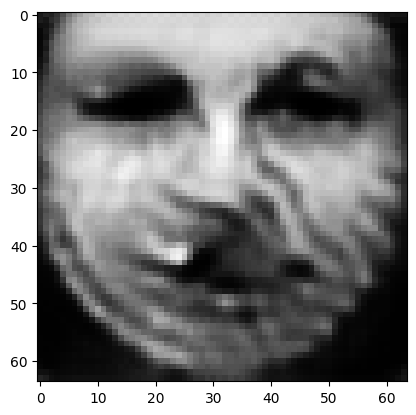

tensor([[1.8559e-04, 1.9701e-03, 1.7865e-03, 9.6914e-01, 1.0525e-04, 6.3810e-04,
         2.5739e-05, 1.0412e-03, 3.4481e-03, 4.7700e-05, 1.0834e-04, 1.4836e-04,
         3.0332e-03, 2.7685e-04, 2.1840e-05, 3.7392e-05, 5.3866e-04, 6.7443e-05,
         4.8828e-04, 7.7104e-05, 5.1629e-05, 5.9139e-06, 3.6373e-04, 6.8687e-05,
         1.4187e-03, 3.4800e-03, 7.5850e-05, 2.0896e-04, 9.3422e-04, 6.6744e-04,
         1.9742e-03, 1.4750e-04, 1.2637e-04, 7.1915e-05, 2.4868e-03, 2.6998e-04,
         2.9421e-04, 3.3278e-03, 6.6158e-04, 1.7556e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.031342774629592896
tensor([[1.8386e-04, 1.9357e-03, 1.7701e-03, 9.6964e-01, 1.0318e-04, 6.3078e-04,
         2.5327e-05, 1.0302e-03, 3.3926e-03, 4.6894e-05, 1.0639e-04, 1.4570e-04,
         2.9751e-03, 2.7023e-04, 2.1479e-05, 3.6829e-05, 5.3176e-04, 6.6326e-05,
         4.8157e-04, 7.5920e-05, 5.0577e-05, 5.8431e-06, 3.5424e-04, 6.7741e-05,
         1.3947e-03, 3.4115e-03, 7.4472e-

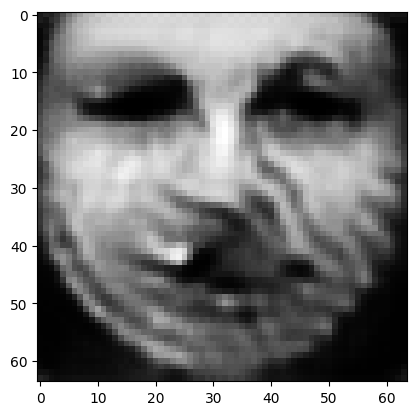

tensor([[1.7777e-04, 1.8101e-03, 1.7198e-03, 9.7141e-01, 9.6100e-05, 6.0781e-04,
         2.3916e-05, 9.9055e-04, 3.2030e-03, 4.4208e-05, 9.9523e-05, 1.3687e-04,
         2.7656e-03, 2.4568e-04, 2.0209e-05, 3.5021e-05, 5.0924e-04, 6.2472e-05,
         4.5740e-04, 7.2127e-05, 4.7154e-05, 5.5905e-06, 3.1959e-04, 6.4422e-05,
         1.3102e-03, 3.1522e-03, 6.9670e-05, 1.8898e-04, 8.6371e-04, 6.0951e-04,
         1.7969e-03, 1.3905e-04, 1.1638e-04, 6.4936e-05, 2.3147e-03, 2.4322e-04,
         2.6888e-04, 3.1616e-03, 6.1382e-04, 1.5926e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.029003776609897614
tensor([[1.7717e-04, 1.7797e-03, 1.7142e-03, 9.7183e-01, 9.4462e-05, 6.0702e-04,
         2.3660e-05, 9.8412e-04, 3.1642e-03, 4.3815e-05, 9.8157e-05, 1.3524e-04,
         2.7122e-03, 2.3851e-04, 1.9890e-05, 3.4728e-05, 5.0378e-04, 6.1564e-05,
         4.5232e-04, 7.1430e-05, 4.6387e-05, 5.5382e-06, 3.0903e-04, 6.3508e-05,
         1.2842e-03, 3.0799e-03, 6.8849e-

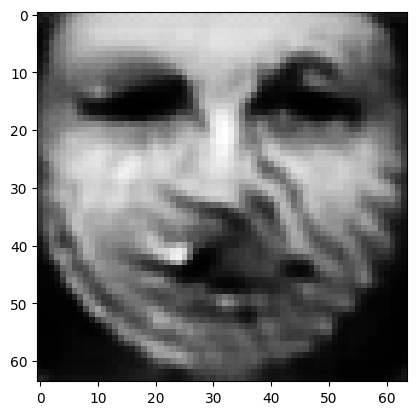

tensor([[1.7248e-04, 1.6864e-03, 1.6704e-03, 9.7327e-01, 8.9205e-05, 5.8907e-04,
         2.2569e-05, 9.5096e-04, 3.0144e-03, 4.1651e-05, 9.2612e-05, 1.2833e-04,
         2.5472e-03, 2.1979e-04, 1.8900e-05, 3.3290e-05, 4.8462e-04, 5.8660e-05,
         4.3234e-04, 6.8431e-05, 4.3665e-05, 5.3169e-06, 2.8250e-04, 6.0599e-05,
         1.2140e-03, 2.8645e-03, 6.5293e-05, 1.7224e-04, 8.1101e-04, 5.6382e-04,
         1.6444e-03, 1.3184e-04, 1.0821e-04, 5.9546e-05, 2.1745e-03, 2.2027e-04,
         2.4696e-04, 3.0137e-03, 5.8130e-04, 1.4762e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.027096446603536606
tensor([[1.7130e-04, 1.6662e-03, 1.6589e-03, 9.7359e-01, 8.7978e-05, 5.8424e-04,
         2.2319e-05, 9.4248e-04, 2.9805e-03, 4.1127e-05, 9.1358e-05, 1.2668e-04,
         2.5115e-03, 2.1585e-04, 1.8670e-05, 3.2933e-05, 4.7995e-04, 5.7986e-05,
         4.2773e-04, 6.7681e-05, 4.3034e-05, 5.2620e-06, 2.7696e-04, 5.9890e-05,
         1.1977e-03, 2.8179e-03, 6.4500e-

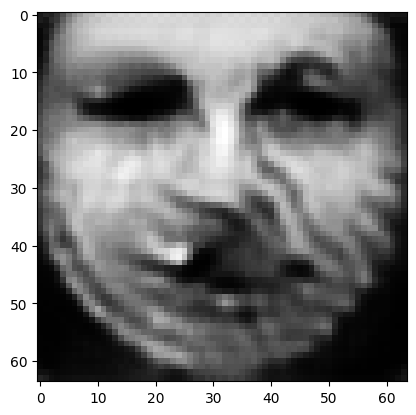

tensor([[1.6619e-04, 1.5905e-03, 1.6112e-03, 9.7479e-01, 8.3562e-05, 5.6433e-04,
         2.1344e-05, 9.0744e-04, 2.8558e-03, 3.9094e-05, 8.6389e-05, 1.2073e-04,
         2.3885e-03, 2.0140e-04, 1.7836e-05, 3.1503e-05, 4.6308e-04, 5.5447e-05,
         4.0900e-04, 6.5139e-05, 4.0779e-05, 5.0570e-06, 2.5786e-04, 5.7356e-05,
         1.1446e-03, 2.6447e-03, 6.1304e-05, 1.5809e-04, 7.5730e-04, 5.2714e-04,
         1.5313e-03, 1.2615e-04, 1.0158e-04, 5.5327e-05, 2.0573e-03, 2.0503e-04,
         2.2976e-04, 2.8797e-03, 5.5129e-04, 1.3722e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
loss(generator):  0.025530541315674782
tensor([[1.6513e-04, 1.5738e-03, 1.6011e-03, 9.7506e-01, 8.2548e-05, 5.6044e-04,
         2.1132e-05, 8.9970e-04, 2.8300e-03, 3.8674e-05, 8.5306e-05, 1.1947e-04,
         2.3615e-03, 1.9801e-04, 1.7652e-05, 3.1198e-05, 4.5892e-04, 5.4876e-05,
         4.0469e-04, 6.4627e-05, 4.0290e-05, 5.0113e-06, 2.5322e-04, 5.6739e-05,
         1.1316e-03, 2.6039e-03, 6.0623e-

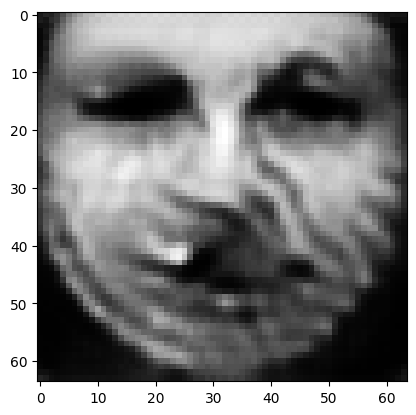

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=3)

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=4)

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=5)

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=6)

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=7)

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=8)

In [ ]:
z = init_avg_z().detach()
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 10, 0.00, 0.99, target=9)

In [ ]:
z = torch.randn(1, 16, 32, 32).to(device)
z = z.requires_grad_(True)
optimize_z_eps(z, 500, 1000, 0.00, 0.99, target=9)